In [1]:
import subprocess 
import torch as ch
from torch import Tensor
import torch.linalg as LA
from torch.distributions import Uniform
from torch.distributions.multivariate_normal import MultivariateNormal
import pandas as pd
import numpy as np
import csv
import json
from cox.utils import Parameters
from cox.store import Store

from cox.readers import CollectionReader
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import math 

import sys 
sys.path.append('../..')
from delphi.stats.linear_regression import TruncatedRegression
from delphi import oracle
from delphi.utils import constants as consts
from delphi.utils.helpers import setup_store_with_metadata

OUT_DIR = '/home/gridsan/stefanou/Regression/'
TABLE_NAME = 'logs'

# set environment variable so that stores can create output files
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

In [2]:
args = Parameters({
    "bias": True,
    "samples": 1000,
    "c": 0,
    "batch_size": 5,
    "lr": 1e-1,
    "var_lr": 1e-2,
    "var_": 1,
    "trials": 3,
    "norm": False,
    "workers": 8,
    "steps": 1000,
    "x_lower": -10,
    "x_upper": 10,
    "lower": -1,
    "upper": 1,
    "device": "cuda",
    "num_samples": 100,
})
mse_loss = ch.nn.MSELoss()

I will start by generating the ground-truth for our expriment.

gt weight:  Parameter containing:
tensor([[0.8355]], requires_grad=True)
gt bias:  Parameter containing:
tensor([[-0.8888]], requires_grad=True)
alpha:  tensor([0.3800])
gt ols coef:  [[0.83543706]]
gt ols intercept:  [-0.9875288]
trunc ols coef:  [[0.45437628]]
trunc ols intercept:  [0.72016466]


Text(0, 0.5, 'y')

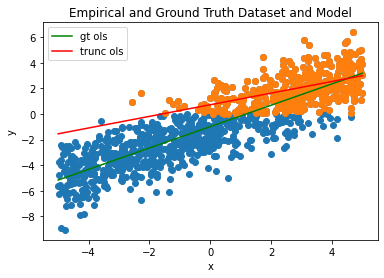

In [30]:
# distribution for generating feature vectors
d, k = 1, 1
w = Uniform(-1, 1)
# m = MultivariateNormal(ch.zeros(d), ch.eye(d)/d)
m = Uniform(-5, 5)
phi = oracle.Left(Tensor([0.0]))
# phi = oracle.Identity()

# generate ground truth
gt = ch.nn.Linear(in_features=k, out_features=1)
gt.weight = ch.nn.Parameter(w.sample(ch.Size([k, d])))

# gt.bias = ch.nn.Parameter(ch.ones(1, 1)) if args.bias else None
gt.bias = ch.nn.Parameter(w.sample(ch.Size([1, 1]))) if args.bias else None

print("gt weight: ", gt.weight)
print("gt bias: ", gt.bias)

# create base classifier
with ch.no_grad():
    # generate data
    X = m.sample(ch.Size([args.samples, d])) if isinstance(m, Uniform) else m.sample(ch.Size([args.samples]))

    y = gt(X)

noise_var = Tensor([2.0])[...,None]
# remove synthetic data from the computation graph
with ch.no_grad():
    # add noise to ground-truth pedictions
    noised = y + ch.sqrt(noise_var) * ch.randn(X.size(0), 1)
    # truncate based off of the standardized data
    indices = phi(noised).flatten().nonzero(as_tuple=False).flatten()
    y_trunc, x_trunc = noised[indices], X[indices]
    alpha = Tensor([y_trunc.size(0) / args.samples])
    print("alpha: ", alpha)
    
# ground-truth OLS
gt_ols = LinearRegression()
gt_ols.fit(X, noised)
print("gt ols coef: ", gt_ols.coef_)
print("gt ols intercept: ", gt_ols.intercept_)

trunc_ols = LinearRegression()
trunc_ols.fit(x_trunc, y_trunc)
trunc_ols_pred = trunc_ols.predict(x_trunc)
print("trunc ols coef: ", trunc_ols.coef_)
print("trunc ols intercept: ", trunc_ols.intercept_)

# data for plotting regressions
unnorm_data = np.linspace(-5, 5, 100).reshape(100, 1)
norm_data = np.linspace(-1, 1, 100).reshape(100, 1)

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised)
plt.scatter(x_trunc, y_trunc)
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt ols')
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='red', label='trunc ols')
plt.legend()
plt.title("Empirical and Ground Truth Dataset and Model")
ax.set_xlabel("x")
ax.set_ylabel("y")

Now, we want to standardize our truncated dataset, so that our empirical estimates are located on the l2 ball. First we will divide all of our covariate features by $B\sqrt{k}$, so that all of our covariate features $||x_{i}||_{2}^{2} \leq 1$, and reside on the $\ell_{2}$ ball. This way the norm of $w$ will be multiplied by $B\sqrt{k}$.

In [31]:
max_x_trunc_norm = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()
print("max truncated x norm", max_x_trunc_norm)

beta = max_x_trunc_norm*math.sqrt(X.size(1))
print("beta: ", beta)

x_trunc_norm = x_trunc / beta
print("x max l2: ", x_trunc_norm.norm(dim=-1).max())

max truncated x norm tensor(4.9969)
beta:  tensor(4.9969)
x max l2:  tensor(1.)


We now observe that the norm of the truncated x covariates is bounded by 1. So, now we will standardze our dependent variable so that it's ground-truth takes the form of the linear regression latent variable model with noise variance of 1. First, let's calculate the predicted values from our naive ols regression on teh truncated data.

First, we will standardize our data for the case where we assume that the empirical noise variance is the underlying noise variance of the ground truth regression.

emp noise var:  tensor([1.2282])
trunc reg noise var:  tensor([1.])


Text(0, 0.5, 'y')

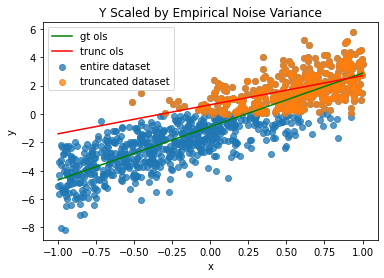

In [32]:
emp_noise_var = (y_trunc - trunc_ols_pred).var(0)
print("emp noise var: ", emp_noise_var)

emp_stand_y_trunc = y_trunc / ch.sqrt(emp_noise_var)
trunc_noise_var = (emp_stand_y_trunc - (trunc_ols_pred / ch.sqrt(emp_noise_var))).var(0)
print("trunc reg noise var: ", trunc_noise_var)

new_X, emp_stand_noised = X / beta, noised / ch.sqrt(emp_noise_var)

gt_emp_stand = LinearRegression()
gt_emp_stand.fit(new_X, emp_stand_noised)

trunc_emp_stand_ols = LinearRegression()
trunc_emp_stand_ols.fit(x_trunc_norm, emp_stand_y_trunc)

ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt ols')
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='red', label='trunc ols')
plt.legend()
plt.title('Y Scaled by Empirical Noise Variance')
ax.set_xlabel("x")
ax.set_ylabel("y")

First, we will standardize our data for the case where we assume that we know the underlying ground-truth noise variance.

trunc reg noise var:  tensor([0.6141])
reg noise var:  tensor([1.0073])


Text(0, 0.5, 'y')

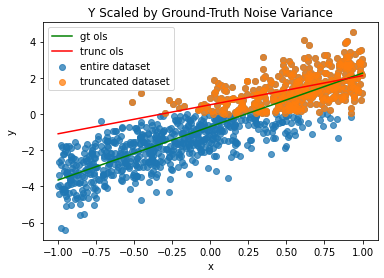

In [33]:
stand_noised, stand_y_trunc = noised / ch.sqrt(noise_var), y_trunc / ch.sqrt(noise_var)

gt_stand = LinearRegression()
gt_stand.fit(new_X, stand_noised)

trunc_stand_ols = LinearRegression()
trunc_stand_ols.fit(x_trunc_norm, stand_y_trunc)

trunc_noise_var = (stand_y_trunc - trunc_stand_ols.predict(x_trunc_norm)).var(0)
print("trunc reg noise var: ", trunc_noise_var)

reg_noise_var = (stand_noised - gt_stand.predict(new_X)).var(0)
print("reg noise var: ", reg_noise_var)

ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, gt_stand.predict(norm_data), color='green', label='gt ols')
plt.plot(norm_data, trunc_stand_ols.predict(norm_data), color='red', label='trunc ols')
plt.legend()
plt.title("Y Scaled by Ground-Truth Noise Variance")
ax.set_xlabel("x")
ax.set_ylabel("y")

Truncated Regression with Known Empirical Variance

In [34]:
known_emp_trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, bias=True, unknown=False, val=100, bs=10, n=100, tol=1e-2)
known_emp_trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)

known_emp_w_unnorm = (known_emp_trunc_reg.weight * ch.sqrt(emp_noise_var)) / beta
known_emp_bias_unnorm = ch.zeros(1, 1)
if args.bias: 
    known_emp_bias_unnorm = (known_emp_trunc_reg.intercept * ch.sqrt(emp_noise_var))

Iteration: 0.0 | Score: [-0.02536662295460701]
Iteration: 1.0 | Score: [-0.11982166767120361]
Iteration: 2.0 | Score: [-0.13763217628002167]
Iteration: 3.0 | Score: [-0.132592111825943]
Iteration: 4.0 | Score: [-0.19211918115615845]
Iteration: 5.0 | Score: [-0.21674875915050507]
Iteration: 6.0 | Score: [-0.12453445047140121]
Iteration: 7.0 | Score: [-0.16877827048301697]
Iteration: 8.0 | Score: [-0.15939711034297943]
Iteration: 9.0 | Score: [-0.14601503312587738]
Iteration: 10.0 | Score: [-0.1455003172159195]


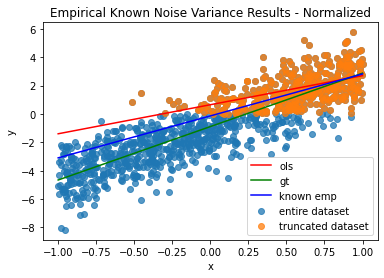

Text(0, 0.5, 'y')

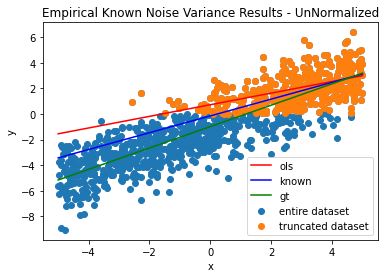

In [35]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, known_emp_trunc_reg(Tensor(norm_data)).detach().numpy(), label='known emp', color='blue')
plt.legend()
plt.title("Empirical Known Noise Variance Results - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='red', label='ols')
plt.plot(unnorm_data, (Tensor(unnorm_data)@known_emp_w_unnorm + known_emp_bias_unnorm).detach().numpy(), label='known', color='blue')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt')
plt.scatter(X, noised, label='entire dataset')
plt.scatter(x_trunc, y_trunc, label='truncated dataset')
plt.legend()
plt.title("Empirical Known Noise Variance Results - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")

Truncated Regression with Known Variance

In [36]:
known_trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, bias=args.bias, unknown=False, val=10, bs=100, n=100, tol=1e-2, steps=1500)
known_trunc_reg.fit(x_trunc_norm, stand_y_trunc)

known_weight_unnorm = (known_trunc_reg.weight * ch.sqrt(noise_var)) / beta
known_bias_unnorm = ch.zeros(1, 1)
if args.bias:  
    known_bias_unnorm = known_trunc_reg.intercept * ch.sqrt(noise_var)

Iteration: 0.0 | Score: [0.240791916847229]
Iteration: 1.0 | Score: [0.10804712772369385]
Iteration: 2.0 | Score: [0.03135845810174942]
Iteration: 3.0 | Score: [0.019305363297462463]
Iteration: 4.0 | Score: [-0.001671120524406433]


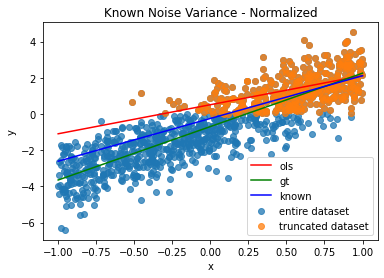

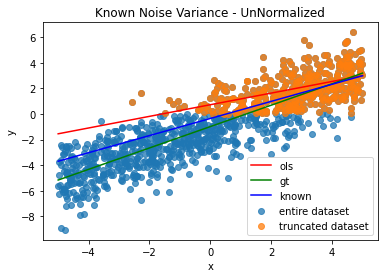

In [37]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, known_trunc_reg(Tensor(norm_data)).detach().numpy(), label='known', color='blue')
plt.legend()
plt.title("Known Noise Variance - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='r', label='ols')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt')
plt.plot(unnorm_data, (Tensor(unnorm_data)@known_weight_unnorm + known_bias_unnorm).detach().numpy(), label='known', color='blue')
plt.legend()
plt.title("Known Noise Variance - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

Truncated Regression with Unknown Noise Variance

In [40]:
unknown_trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, bias=True, unknown=True, bs=10, n=100, tol=1e-1, val=10, steps=2000)
unknown_trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)
with ch.no_grad():
    unknown_weight_unnorm = (((unknown_trunc_reg.weight * unknown_trunc_reg.variance) * ch.sqrt(emp_noise_var)) / beta)

    if args.bias: 
        unknown_bias_unnorm = ((unknown_trunc_reg.intercept * unknown_trunc_reg.variance) * ch.sqrt(emp_noise_var))
    

Iteration: 0.0 | Score: [-0.12165714800357819, 0.21924637258052826]
Iteration: 1.0 | Score: [-0.21214184165000916, 0.3598797619342804]
Iteration: 2.0 | Score: [-0.4744935631752014, 0.8935776948928833]
Iteration: 3.0 | Score: [-0.04646763205528259, -0.1492982804775238]
Iteration: 4.0 | Score: [-0.044621843844652176, -0.1630980223417282]
Iteration: 5.0 | Score: [-0.3639185428619385, 0.6632825136184692]
Iteration: 6.0 | Score: [-0.4053798019886017, 0.721343994140625]
Iteration: 7.0 | Score: [-0.3445623815059662, 0.590284526348114]
Iteration: 8.0 | Score: [0.07597371190786362, -0.5455248355865479]
Iteration: 9.0 | Score: [-0.20857703685760498, 0.2699781060218811]
Iteration: 10.0 | Score: [-0.27680179476737976, 0.4481775462627411]
Iteration: 11.0 | Score: [-0.0911467894911766, -0.055534347891807556]


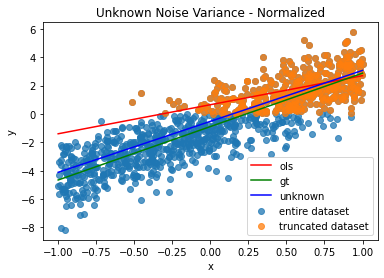

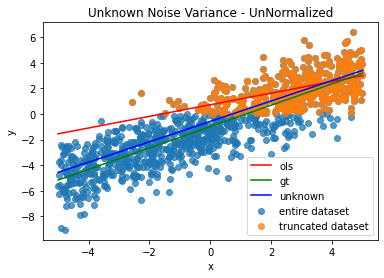

In [41]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, unknown_trunc_reg(Tensor(norm_data)).detach().numpy(), label='unknown', color='blue')
plt.legend()
ax.set_title("Unknown Noise Variance - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), label='ols', color='red')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='g', label='gt')
plt.plot(unnorm_data, (Tensor(unnorm_data)@unknown_weight_unnorm + unknown_bias_unnorm), color='blue', label='unknown')
plt.legend()
ax.set_title("Unknown Noise Variance - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

# Truncate at Zero and Run for High Variance

In [187]:
args.__setattr__('bs', 10)
args.__setattr__('steps', 2500)
args.__setattr__('step_lr', 100)
args.__setattr__('step_lr_gamma', .9)
args.__setattr__('tol', 1e-2)
args.__setattr__('trials', 20)
args.__setattr__('samples', 1000)
args.__setattr__('n', 100)

EXP = '2DimsVar4020Trials'

In [188]:
def run_trial(kwargs, X, y):
    """
    Runs a trial of a truncated regression experiment. Runs a maximum 
    of three trials of an experiment. The experiment terminates when either 
    the norm of teh score is less than 3e-1, or when three trials is up. After 
    three trials it returns the best truncated regression experiment.
    :param kwargs: keyword arguments for experiment 
    :param X: independent variable
    :param y: dependent variable
    :return: truncated regression experiment and time that experiment took
    """
    st = datetime.datetime.now()        
    # run procedure until get reasonable score
    attempt, score, best_trunc_reg = 0, None, None
    while (score is None or score.norm() > 1e-1) and attempt < 3:
        trunc_reg = TruncatedRegression(**kwargs)
        trunc_reg.fit(X, y)
        grad = trunc_reg.score()
        if score is None or grad.norm() < score.norm(): 
            score, best_trunc_reg = grad, trunc_reg
        attempt += 1
    total_time = int((datetime.datetime.now() - st).total_seconds())
    return best_trunc_reg, total_time    

In [ ]:
 # expriment parameters
w_lower, w_upper = -1, 1
d, k = 2, 1
# distribution for generating feature vectors
W = Uniform(w_lower, w_upper)
dist = Uniform(-5, 5)
phi = oracle.Left(0.0)

# generate ground truth
gt = ch.nn.Linear(in_features=d, out_features=k)
gt.weight = ch.nn.Parameter(W.sample(ch.Size([k, d])))
gt.bias = ch.nn.Parameter(W.sample(ch.Size([1, 1]))) if args.bias else None

for i in range(args.trials):
    # create store and add table
    store = Store(OUT_DIR + EXP)
    store.add_table(TABLE_NAME, { 
        'ols_r2': float,
        'ols_param_mse': float,
        'ols_var_l1': float,
        'known_emp_r2': float,
        'known_emp_param_mse': float,
        'known_emp_time': int,
        'known_r2': float,
        'known_param_mse': float,
        'known_time': int,
        'unknown_r2': float, 
        'unknown_param_mse': float,
        'unknown_var_l1': float,
        'unknown_time': int,
        'alpha': float, 
        'num_samples': int,
        'noise_var': float, 
    })
    
    # create base classifier
    with ch.no_grad():
        # generate data
        X = dist.sample(ch.Size([args.samples, d])) if isinstance(dist, Uniform) else dist.sample(ch.Size([args.samples]))
        y = gt(X)
        
    for noise_var in range(1, 41): 
        noise_var = Tensor([noise_var])[None,...]
        # add noise to ground-truth pedictions
        noised = y + ch.sqrt(noise_var)*ch.randn(X.size(0), 1)
        # truncate based off of the standardized data
        indices = phi(noised).flatten().nonzero(as_tuple=False).flatten()
        y_trunc, x_trunc = noised[indices], X[indices]
        alpha = Tensor([y_trunc.size(0) / args.samples])
        
        # normalize x features so that ||x_{i}||_{2}^{2} <= 1
        l_inf = LA.norm(x_trunc, dim=-1, ord=float('inf')).max() # find max l_inf
        # calculate normalizing constant
        beta = l_inf*math.sqrt(d)
        """
        Divide input features by normalizing constant. By doing so, 
        the weights will be increased by a magnitude of beta.
        """
        x_trunc_norm = x_trunc / beta
         # normalize entire dataset by beta
        x_norm = X / beta
        
        # ground-truth ols
        gt_ols = LinearRegression()
        gt_ols.fit(X, noised)
        gt_params = ch.cat([Tensor(gt_ols.coef_).T, Tensor(gt_ols.intercept_)[..., None]]).flatten()
        
        # empirical linear regression
        ols = LinearRegression() 
        ols.fit(x_trunc, y_trunc)
        ols_var = ch.var(Tensor(ols.predict(x_trunc)) - y_trunc, dim=0)[..., None]
        ols_params = ch.cat([Tensor(ols.coef_).T, Tensor(ols.intercept_)[..., None]]).flatten()
        # check r2 for entire dataset
        ols_pred = ols.predict(X)

        # ols results
        store[TABLE_NAME].update_row({
            'ols_r2': r2_score(noised.flatten(), ols_pred.flatten()), 
            'ols_var_l1': ch.abs(ols_var - noise_var),
            'ols_param_mse': mse_loss(ols_params, gt_params),
        })
        
        val = int(.1*x_trunc.size(0))
        
        """
        Run dataset on truncated regression with known variance, while 
        assuming that the empirical noise variance is the underlying noise 
        variance of our linear regression. This means that we want to standardize 
        our dependent variable by the empirical noise variance. 
        """
        # variance of the residuals
        emp_noise_var = (y_trunc - ols.predict(x_trunc)).var(0)
        # standardize y trunc by the empirical noise variance
        emp_stand_y_trunc = y_trunc / ch.sqrt(ols_var)
        # standardize noised by the empirical noise variance
        emp_stand_noised = noised / ch.sqrt(emp_noise_var)
        
        known_emp_kwargs = { 
            'phi': phi, 
            'alpha': alpha, 
            'bias': args.bias, 
            'unknown': False, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps, 
            'val': val
        }
        known_emp_trunc_reg, total_time = run_trial(known_emp_kwargs, x_trunc_norm, emp_stand_y_trunc)
        
        with ch.no_grad():
            w, w0 = (known_emp_trunc_reg.weight * ch.sqrt(emp_noise_var)) / beta, known_emp_trunc_reg.intercept[..., None] * ch.sqrt(emp_noise_var)
            known_emp_params = ch.cat([w, w0]).flatten()
        
            # known emp results
            store[TABLE_NAME].update_row({
                'known_emp_r2': r2_score(noised.flatten(), X@w + w0), 
                'known_emp_param_mse': mse_loss(known_emp_params, gt_params),
                'known_emp_time': total_time, 
            })

        """
        Run dataset on truncated regression with known variance. This means that we want to standardize 
        our dependent variable by the true noise variance. 
        """
        # standardize y trunc by actual noise variance
        stand_y_trunc = y_trunc / ch.sqrt(noise_var)
        # standardize noised by actual noise variance
        stand_noised = noised / ch.sqrt(noise_var)
        # run procedure until get reasonable score
        known_kwargs = { 
            'phi': phi, 
            'alpha': alpha, 
            'bias': args.bias, 
            'unknown': False, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps, 
            'val': val
        }
        known_trunc_reg, total_time = run_trial(known_kwargs, x_trunc_norm, stand_y_trunc)
        
        with ch.no_grad():
            w, w0 = (known_trunc_reg.weight * ch.sqrt(noise_var)) / beta, known_trunc_reg.intercept[..., None] * ch.sqrt(noise_var)
            known_params = ch.cat([w, w0]).flatten()
            # known results
            store[TABLE_NAME].update_row({
                'known_r2': r2_score(noised.flatten(), X@w + w0), 
                'known_param_mse': mse_loss(known_params, gt_params),
                'known_time': total_time, 
            })

        
        # truncated regression with unknown variance
        # run procedure until get reasonable score
        unknown_kwargs = { 
            'phi': phi, 
            'alpha': alpha, 
            'bias': args.bias, 
            'unknown': True, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps, 
            'val': val
        }
        unknown_trunc_reg, total_time = run_trial(unknown_kwargs, x_trunc_norm, emp_stand_y_trunc)
    
        with ch.no_grad():
            unknown_var = unknown_trunc_reg.variance * emp_noise_var
            w, w0 = (((unknown_trunc_reg.weight * unknown_trunc_reg.variance) * ch.sqrt(emp_noise_var)) / beta).detach(), ((unknown_trunc_reg.intercept * unknown_trunc_reg.variance * ch.sqrt(emp_noise_var)))
            unknown_params = ch.cat([w, w0]).flatten()

            # known emp results
            store[TABLE_NAME].update_row({
                'unknown_r2': r2_score(noised.flatten(), X@w + w0), 
                'unknown_param_mse': mse_loss(unknown_params, gt_params),
                'unknown_var_l1': float(ch.abs(unknown_var - noise_var)),
                'unknown_time': total_time, 
            })
        
        # add additional exp data to store
        store[TABLE_NAME].update_row({ 
            'alpha': float(alpha.flatten()),
            'num_samples': x_trunc.size(0),
            'noise_var': noise_var, 
        })

        # append row to table
        store[TABLE_NAME].flush_row()
    store.close()    

Logging in: /home/gridsan/stefanou/Regression/2DimsVar4020Trials/6f84b774-b321-4ffc-8796-e760d5f6d130
Iteration: 0.0 | Score: [0.0830618143081665]
Iteration: 1.0 | Score: [-0.0812845528125763]
Iteration: 2.0 | Score: [0.03461581468582153]
Iteration: 3.0 | Score: [-0.026973746716976166]
Iteration: 4.0 | Score: [-0.03726600855588913]
Iteration: 5.0 | Score: [-0.055792756378650665]
Iteration: 6.0 | Score: [-0.027719847857952118]
Iteration: 7.0 | Score: [0.021095365285873413]
Iteration: 8.0 | Score: [-0.03883293271064758]
Iteration: 9.0 | Score: [0.039807144552469254]
Iteration: 10.0 | Score: [-0.01012294739484787]
Iteration: 11.0 | Score: [0.00038089603185653687]
Iteration: 0.0 | Score: [0.34254005551338196]
Iteration: 1.0 | Score: [0.2350040227174759]
Iteration: 2.0 | Score: [0.18083563446998596]
Iteration: 3.0 | Score: [0.2172386348247528]
Iteration: 4.0 | Score: [0.13467222452163696]
Iteration: 5.0 | Score: [0.18359002470970154]
Iteration: 6.0 | Score: [0.12948741018772125]
Iteration: 

Iteration: 23.0 | Score: [0.09005311131477356, -0.1576692909002304]
Iteration: 24.0 | Score: [-0.029517361894249916, 0.12643760442733765]
Iteration: 25.0 | Score: [0.09465013444423676, -0.15947701036930084]
Iteration: 0.0 | Score: [-0.00025071948766708374]
Iteration: 1.0 | Score: [-0.25835102796554565]
Iteration: 2.0 | Score: [-0.09129488468170166]
Iteration: 3.0 | Score: [-0.24960368871688843]
Iteration: 4.0 | Score: [-0.10595571994781494]
Iteration: 5.0 | Score: [-0.26180899143218994]
Iteration: 6.0 | Score: [-0.14796200394630432]
Iteration: 7.0 | Score: [-0.22083139419555664]
Iteration: 8.0 | Score: [-0.15225203335285187]
Iteration: 9.0 | Score: [-0.2162838578224182]
Iteration: 10.0 | Score: [-0.1280345320701599]
Iteration: 11.0 | Score: [-0.21133816242218018]
Iteration: 12.0 | Score: [-0.17801940441131592]
Iteration: 13.0 | Score: [-0.1843462884426117]
Iteration: 14.0 | Score: [-0.16461071372032166]
Iteration: 15.0 | Score: [-0.19607573747634888]
Iteration: 16.0 | Score: [-0.176622

Iteration: 22.0 | Score: [-0.08798035234212875, 0.3488798141479492]
Iteration: 23.0 | Score: [-0.10734088718891144, 0.38674628734588623]
Iteration: 24.0 | Score: [-0.08448472619056702, 0.3200652599334717]
Iteration: 25.0 | Score: [-0.07465598732233047, 0.31711238622665405]
Iteration: 0.0 | Score: [-0.1289902776479721]
Iteration: 1.0 | Score: [-0.23333165049552917]
Iteration: 2.0 | Score: [-0.3519366383552551]
Iteration: 3.0 | Score: [-0.28989189863204956]
Iteration: 4.0 | Score: [-0.2900141179561615]
Iteration: 5.0 | Score: [-0.40442365407943726]
Iteration: 6.0 | Score: [-0.2874034345149994]
Iteration: 7.0 | Score: [-0.3248862326145172]
Iteration: 8.0 | Score: [-0.33625417947769165]
Iteration: 9.0 | Score: [-0.3106245994567871]
Iteration: 10.0 | Score: [-0.34358328580856323]
Iteration: 11.0 | Score: [-0.3319161534309387]
Iteration: 12.0 | Score: [-0.29147979617118835]
Iteration: 13.0 | Score: [-0.362106055021286]
Iteration: 14.0 | Score: [-0.2956715524196625]
Iteration: 15.0 | Score: [

Iteration: 25.0 | Score: [0.21561026573181152]
Iteration: 0.0 | Score: [0.16776850819587708]
Iteration: 1.0 | Score: [-0.15007656812667847]
Iteration: 2.0 | Score: [-0.06740335375070572]
Iteration: 3.0 | Score: [-0.12083414196968079]
Iteration: 4.0 | Score: [-0.0955609604716301]
Iteration: 5.0 | Score: [-0.10787703096866608]
Iteration: 6.0 | Score: [-0.08869338780641556]
Iteration: 7.0 | Score: [-0.09676594287157059]
Iteration: 8.0 | Score: [-0.06723305583000183]
Iteration: 9.0 | Score: [-0.08734745532274246]
Iteration: 10.0 | Score: [-0.07426662743091583]
Iteration: 11.0 | Score: [-0.07648948580026627]
Iteration: 12.0 | Score: [-0.09745658934116364]
Iteration: 13.0 | Score: [-0.09341542422771454]
Iteration: 14.0 | Score: [-0.09140783548355103]
Iteration: 15.0 | Score: [-0.05888763815164566]
Iteration: 16.0 | Score: [-0.07332082837820053]
Iteration: 17.0 | Score: [-0.09671780467033386]
Iteration: 18.0 | Score: [-0.09925763309001923]
Iteration: 19.0 | Score: [-0.07001438736915588]
Itera

Iteration: 2.0 | Score: [0.2711719870567322, -0.6767805218696594]
Iteration: 3.0 | Score: [0.08784821629524231, -0.31011340022087097]
Iteration: 4.0 | Score: [0.06481271982192993, -0.26729485392570496]
Iteration: 5.0 | Score: [0.13019916415214539, -0.41117027401924133]
Iteration: 6.0 | Score: [0.13227364420890808, -0.42813795804977417]
Iteration: 7.0 | Score: [0.21231023967266083, -0.5756753087043762]
Iteration: 8.0 | Score: [0.2984795868396759, -0.7765746116638184]
Iteration: 9.0 | Score: [0.2739918828010559, -0.7039658427238464]
Iteration: 10.0 | Score: [0.3141655921936035, -0.7936747074127197]
Iteration: 11.0 | Score: [0.1917891800403595, -0.5215813517570496]
Iteration: 12.0 | Score: [0.29024240374565125, -0.7607032656669617]
Iteration: 13.0 | Score: [0.19139787554740906, -0.5568772554397583]
Iteration: 14.0 | Score: [0.29160183668136597, -0.773124098777771]
Iteration: 15.0 | Score: [0.2935759723186493, -0.8063124418258667]
Iteration: 16.0 | Score: [0.27940112352371216, -0.759079754

Iteration: 15.0 | Score: [-0.06269553303718567]
Iteration: 16.0 | Score: [-0.048739537596702576]
Iteration: 17.0 | Score: [-0.07817874848842621]
Iteration: 18.0 | Score: [-0.05532759428024292]
Iteration: 19.0 | Score: [-0.05692042410373688]
Iteration: 20.0 | Score: [-0.03760502114892006]
Iteration: 21.0 | Score: [-0.060224249958992004]
Iteration: 22.0 | Score: [-0.0312606617808342]
Iteration: 23.0 | Score: [-0.06107531115412712]
Iteration: 24.0 | Score: [-0.04761528968811035]
Iteration: 25.0 | Score: [-0.03320569172501564]
Iteration: 0.0 | Score: [0.14581552147865295, -0.1675529181957245]
Iteration: 1.0 | Score: [0.13125456869602203, -0.2647561728954315]
Iteration: 2.0 | Score: [-0.08517085015773773, 0.10321032255887985]
Iteration: 3.0 | Score: [-0.13046586513519287, 0.1550922840833664]
Iteration: 4.0 | Score: [0.3981090188026428, -1.0588221549987793]
Iteration: 5.0 | Score: [-0.08761966973543167, 0.053821414709091187]
Iteration: 6.0 | Score: [-0.029978236183524132, -0.0407271496951580

Iteration: 25.0 | Score: [0.19716987013816833]
Iteration: 0.0 | Score: [0.04094063490629196]
Iteration: 1.0 | Score: [-0.14214038848876953]
Iteration: 2.0 | Score: [-0.13735443353652954]
Iteration: 3.0 | Score: [-0.1618654876947403]
Iteration: 4.0 | Score: [-0.20320284366607666]
Iteration: 5.0 | Score: [-0.1681569516658783]
Iteration: 6.0 | Score: [-0.21599595248699188]
Iteration: 7.0 | Score: [-0.16193364560604095]
Iteration: 8.0 | Score: [-0.15622557699680328]
Iteration: 9.0 | Score: [-0.14663290977478027]
Iteration: 10.0 | Score: [-0.16681554913520813]
Iteration: 11.0 | Score: [-0.18448644876480103]
Iteration: 12.0 | Score: [-0.17030984163284302]
Iteration: 13.0 | Score: [-0.19240868091583252]
Iteration: 14.0 | Score: [-0.18676476180553436]
Iteration: 15.0 | Score: [-0.1847297102212906]
Iteration: 16.0 | Score: [-0.1100141704082489]
Iteration: 17.0 | Score: [-0.15682484209537506]
Iteration: 18.0 | Score: [-0.15939146280288696]
Iteration: 19.0 | Score: [-0.18050986528396606]
Iteratio

Iteration: 3.0 | Score: [-0.008069355972111225, 0.025873534381389618]
Iteration: 4.0 | Score: [-0.23661983013153076, 0.4686048626899719]
Iteration: 5.0 | Score: [-0.0019785729236900806, 0.007420405745506287]
Iteration: 0.0 | Score: [0.23535531759262085]
Iteration: 1.0 | Score: [-0.0034977346658706665]
Iteration: 0.0 | Score: [0.38867679238319397]
Iteration: 1.0 | Score: [0.03946603834629059]
Iteration: 2.0 | Score: [0.026613011956214905]
Iteration: 3.0 | Score: [0.044309891760349274]
Iteration: 4.0 | Score: [0.031112123280763626]
Iteration: 5.0 | Score: [0.049056634306907654]
Iteration: 6.0 | Score: [0.05776303634047508]
Iteration: 7.0 | Score: [0.08260263502597809]
Iteration: 8.0 | Score: [0.06538669764995575]
Iteration: 9.0 | Score: [0.02246776781976223]
Iteration: 10.0 | Score: [0.05180850252509117]
Iteration: 11.0 | Score: [0.05922740697860718]
Iteration: 12.0 | Score: [0.03747757896780968]
Iteration: 13.0 | Score: [0.03753707557916641]
Iteration: 14.0 | Score: [0.06697971373796463

Iteration: 24.0 | Score: [0.05843808129429817]
Iteration: 25.0 | Score: [0.031709037721157074]
Iteration: 0.0 | Score: [0.10886850208044052, 0.13594764471054077]
Iteration: 1.0 | Score: [-0.1567564159631729, 0.5284218788146973]
Iteration: 2.0 | Score: [0.11161072552204132, -0.04297073185443878]
Iteration: 3.0 | Score: [-0.14886048436164856, 0.4476251006126404]
Iteration: 4.0 | Score: [0.07666996866464615, -0.00672517716884613]
Iteration: 5.0 | Score: [-0.26422742009162903, 0.6267260313034058]
Iteration: 6.0 | Score: [-0.03766264393925667, 0.18627730011940002]
Iteration: 7.0 | Score: [-0.18825672566890717, 0.5034832954406738]
Iteration: 8.0 | Score: [-0.12749835848808289, 0.3799847662448883]
Iteration: 9.0 | Score: [-0.0390363410115242, 0.1854725182056427]
Iteration: 10.0 | Score: [-0.12070684880018234, 0.37218499183654785]
Iteration: 11.0 | Score: [0.0594814196228981, -0.0006338357925415039]
Iteration: 12.0 | Score: [-0.23742468655109406, 0.5815266370773315]
Iteration: 13.0 | Score: [-

Iteration: 21.0 | Score: [-0.192189022898674, 0.3185250461101532]
Iteration: 22.0 | Score: [-0.20912501215934753, 0.42437633872032166]
Iteration: 23.0 | Score: [-0.20623598992824554, 0.40587174892425537]
Iteration: 24.0 | Score: [-0.2789609432220459, 0.5560098886489868]
Iteration: 25.0 | Score: [-0.20197120308876038, 0.35081151127815247]
Iteration: 0.0 | Score: [0.40945562720298767, -0.4775497317314148]
Iteration: 1.0 | Score: [0.017909729853272438, 0.08611452579498291]
Iteration: 2.0 | Score: [0.42902135848999023, -0.7151473760604858]
Iteration: 3.0 | Score: [-0.02145266719162464, 0.10683774948120117]
Iteration: 4.0 | Score: [0.35938531160354614, -0.735807478427887]
Iteration: 5.0 | Score: [-0.05144765228033066, 0.128025621175766]
Iteration: 6.0 | Score: [0.31761714816093445, -0.6198645830154419]
Iteration: 7.0 | Score: [0.024814503267407417, 0.006806120276451111]
Iteration: 8.0 | Score: [0.347716748714447, -0.6921671628952026]
Iteration: 9.0 | Score: [0.060116689652204514, -0.1006305

Iteration: 16.0 | Score: [-0.12116020917892456]
Iteration: 17.0 | Score: [-0.09100499004125595]
Iteration: 18.0 | Score: [-0.13955619931221008]
Iteration: 19.0 | Score: [-0.10190786421298981]
Iteration: 20.0 | Score: [-0.12041980028152466]
Iteration: 21.0 | Score: [-0.1100340336561203]
Iteration: 22.0 | Score: [-0.13254845142364502]
Iteration: 23.0 | Score: [-0.12441714853048325]
Iteration: 24.0 | Score: [-0.11962480843067169]
Iteration: 25.0 | Score: [-0.12263811379671097]
Iteration: 0.0 | Score: [0.3943711519241333]
Iteration: 1.0 | Score: [0.07570113241672516]
Iteration: 2.0 | Score: [0.01460392214357853]
Iteration: 3.0 | Score: [0.05325191468000412]
Iteration: 4.0 | Score: [0.06364016234874725]
Iteration: 5.0 | Score: [0.030463851988315582]
Iteration: 6.0 | Score: [0.03785499930381775]
Iteration: 7.0 | Score: [0.03887515887618065]
Iteration: 8.0 | Score: [0.020003512501716614]
Iteration: 9.0 | Score: [0.037568025290966034]
Iteration: 10.0 | Score: [0.06280944496393204]
Iteration: 1

Iteration: 12.0 | Score: [-0.06525379419326782]
Iteration: 13.0 | Score: [-0.07470379024744034]
Iteration: 14.0 | Score: [-0.07340233027935028]
Iteration: 15.0 | Score: [-0.06989167630672455]
Iteration: 16.0 | Score: [-0.08263784646987915]
Iteration: 17.0 | Score: [-0.06891083717346191]
Iteration: 18.0 | Score: [-0.051953140646219254]
Iteration: 19.0 | Score: [-0.05692059174180031]
Iteration: 20.0 | Score: [-0.09319031983613968]
Iteration: 21.0 | Score: [-0.08316144347190857]
Iteration: 22.0 | Score: [-0.06490878760814667]
Iteration: 23.0 | Score: [-0.042745474725961685]
Iteration: 24.0 | Score: [-0.06294998526573181]
Iteration: 25.0 | Score: [-0.07514949142932892]
Iteration: 0.0 | Score: [0.46916547417640686]
Iteration: 1.0 | Score: [0.13405196368694305]
Iteration: 2.0 | Score: [0.12631431221961975]
Iteration: 3.0 | Score: [0.0921841412782669]
Iteration: 4.0 | Score: [0.11893387138843536]
Iteration: 5.0 | Score: [0.10375076532363892]
Iteration: 6.0 | Score: [0.11355806142091751]
Itera

Iteration: 23.0 | Score: [0.120615653693676]
Iteration: 24.0 | Score: [0.10382639616727829]
Iteration: 25.0 | Score: [0.12368174642324448]
Iteration: 0.0 | Score: [0.18490520119667053]
Iteration: 1.0 | Score: [-0.02920588105916977]
Iteration: 2.0 | Score: [0.023807957768440247]
Iteration: 3.0 | Score: [-0.01758965477347374]
Iteration: 4.0 | Score: [-0.007983636111021042]
Iteration: 0.0 | Score: [0.363675981760025]
Iteration: 1.0 | Score: [0.03946848213672638]
Iteration: 2.0 | Score: [0.02814757265150547]
Iteration: 3.0 | Score: [0.016256187111139297]
Iteration: 4.0 | Score: [0.050513677299022675]
Iteration: 5.0 | Score: [0.011230789124965668]
Iteration: 6.0 | Score: [0.007636958733201027]
Iteration: 0.0 | Score: [0.12355383485555649, -0.15065443515777588]
Iteration: 1.0 | Score: [-0.05811460688710213, 0.07912357151508331]
Iteration: 2.0 | Score: [-0.105503611266613, 0.11028176546096802]
Iteration: 3.0 | Score: [-0.07151183485984802, 0.03157594054937363]
Iteration: 4.0 | Score: [-0.1222

Iteration: 0.0 | Score: [0.3272709846496582]
Iteration: 1.0 | Score: [-0.011111743748188019]
Iteration: 2.0 | Score: [-0.06130775064229965]
Iteration: 3.0 | Score: [-0.038796961307525635]
Iteration: 4.0 | Score: [-0.07067100703716278]
Iteration: 5.0 | Score: [-0.041893720626831055]
Iteration: 6.0 | Score: [-0.029921913519501686]
Iteration: 7.0 | Score: [-0.04373693838715553]
Iteration: 8.0 | Score: [-0.06437020748853683]
Iteration: 9.0 | Score: [-0.07666558772325516]
Iteration: 10.0 | Score: [-0.046409230679273605]
Iteration: 11.0 | Score: [-0.04877419397234917]
Iteration: 12.0 | Score: [-0.04464320093393326]
Iteration: 13.0 | Score: [-0.04701383784413338]
Iteration: 14.0 | Score: [-0.038390785455703735]
Iteration: 15.0 | Score: [-0.04119189828634262]
Iteration: 16.0 | Score: [-0.05514632910490036]
Iteration: 17.0 | Score: [-0.04394420236349106]
Iteration: 18.0 | Score: [-0.029690556228160858]
Iteration: 19.0 | Score: [-0.05181987211108208]
Iteration: 20.0 | Score: [-0.0443122908473014

Iteration: 12.0 | Score: [0.177962988615036]
Iteration: 13.0 | Score: [0.1965290755033493]
Iteration: 14.0 | Score: [0.16955114901065826]
Iteration: 15.0 | Score: [0.1835736185312271]
Iteration: 16.0 | Score: [0.1943916380405426]
Iteration: 17.0 | Score: [0.17169751226902008]
Iteration: 18.0 | Score: [0.16505879163742065]
Iteration: 19.0 | Score: [0.1797914206981659]
Iteration: 20.0 | Score: [0.19292525947093964]
Iteration: 21.0 | Score: [0.180300772190094]
Iteration: 22.0 | Score: [0.17962655425071716]
Iteration: 23.0 | Score: [0.17563095688819885]
Iteration: 24.0 | Score: [0.19562071561813354]
Iteration: 25.0 | Score: [0.1772833913564682]
Iteration: 0.0 | Score: [0.021060042083263397]
Iteration: 1.0 | Score: [-0.22548772394657135]
Iteration: 2.0 | Score: [-0.15246643126010895]
Iteration: 3.0 | Score: [-0.18074044585227966]
Iteration: 4.0 | Score: [-0.13247695565223694]
Iteration: 5.0 | Score: [-0.20189762115478516]
Iteration: 6.0 | Score: [-0.13180139660835266]
Iteration: 7.0 | Score

Iteration: 24.0 | Score: [0.26363855600357056, -0.4796227216720581]
Iteration: 25.0 | Score: [0.19687601923942566, -0.36982035636901855]
Iteration: 0.0 | Score: [0.19671708345413208]
Iteration: 1.0 | Score: [0.06946342438459396]
Iteration: 2.0 | Score: [0.008170366287231445]
Iteration: 0.0 | Score: [0.3745418190956116]
Iteration: 1.0 | Score: [0.05084933340549469]
Iteration: 2.0 | Score: [0.022189758718013763]
Iteration: 3.0 | Score: [0.025144530460238457]
Iteration: 4.0 | Score: [0.03777078539133072]
Iteration: 5.0 | Score: [0.023310203105211258]
Iteration: 6.0 | Score: [0.005204480141401291]
Iteration: 0.0 | Score: [0.2551865577697754, -0.4325215220451355]
Iteration: 1.0 | Score: [-0.04439824819564819, 0.011337202042341232]
Iteration: 2.0 | Score: [-0.008015110157430172, -0.1453125923871994]
Iteration: 3.0 | Score: [-0.05214749649167061, -0.04545673355460167]
Iteration: 4.0 | Score: [-0.09266285598278046, 0.006912831217050552]
Iteration: 5.0 | Score: [0.387567937374115, -1.1436325311

Iteration: 10.0 | Score: [-0.16173674166202545, 0.26721662282943726]
Iteration: 11.0 | Score: [0.14054350554943085, -0.3906323313713074]
Iteration: 12.0 | Score: [-0.028687916696071625, 0.007837004959583282]
Iteration: 13.0 | Score: [-0.09009260684251785, 0.11719239503145218]
Iteration: 14.0 | Score: [0.0302497036755085, -0.10450994968414307]
Iteration: 15.0 | Score: [-0.0627555251121521, 0.06021660566329956]
Iteration: 16.0 | Score: [-0.014995829202234745, -0.02619730308651924]
Iteration: 17.0 | Score: [-0.08305362612009048, 0.09414428472518921]
Iteration: 18.0 | Score: [-0.0323757529258728, 0.027017980813980103]
Iteration: 19.0 | Score: [6.220865907380357e-05, -0.08529388904571533]
Iteration: 20.0 | Score: [-0.021362945437431335, 0.010956574231386185]
Iteration: 21.0 | Score: [-0.08336204290390015, 0.10821986198425293]
Iteration: 22.0 | Score: [-0.033783167600631714, -0.012984106317162514]
Iteration: 23.0 | Score: [-0.08270861208438873, 0.10339315980672836]
Iteration: 24.0 | Score: [

Iteration: 12.0 | Score: [0.25512054562568665]
Iteration: 13.0 | Score: [0.23135003447532654]
Iteration: 14.0 | Score: [0.2361525446176529]
Iteration: 15.0 | Score: [0.23768270015716553]
Iteration: 16.0 | Score: [0.25069659948349]
Iteration: 17.0 | Score: [0.24980255961418152]
Iteration: 18.0 | Score: [0.27225369215011597]
Iteration: 19.0 | Score: [0.23157106339931488]
Iteration: 20.0 | Score: [0.22478410601615906]
Iteration: 21.0 | Score: [0.224190354347229]
Iteration: 22.0 | Score: [0.23431217670440674]
Iteration: 23.0 | Score: [0.2317434847354889]
Iteration: 24.0 | Score: [0.2356370985507965]
Iteration: 25.0 | Score: [0.24560147523880005]
Iteration: 0.0 | Score: [0.5414804220199585]
Iteration: 1.0 | Score: [0.32979992032051086]
Iteration: 2.0 | Score: [0.3701159358024597]
Iteration: 3.0 | Score: [0.29462388157844543]
Iteration: 4.0 | Score: [0.39574381709098816]
Iteration: 5.0 | Score: [0.32056674361228943]
Iteration: 6.0 | Score: [0.32903429865837097]
Iteration: 7.0 | Score: [0.360

Iteration: 7.0 | Score: [-0.1746080219745636, 0.246609628200531]
Iteration: 8.0 | Score: [0.014102154411375523, -0.11784063279628754]
Iteration: 9.0 | Score: [-0.08481865376234055, 0.08791857957839966]
Iteration: 10.0 | Score: [-0.019176403060555458, -0.06769759953022003]
Iteration: 11.0 | Score: [-0.03163459151983261, -0.01966453343629837]
Iteration: 12.0 | Score: [-0.03715268522500992, -0.043063677847385406]
Iteration: 13.0 | Score: [-0.0013888922985643148, -0.09072122722864151]
Iteration: 14.0 | Score: [-0.07556241750717163, 0.08502005785703659]
Iteration: 15.0 | Score: [0.012972392141819, -0.1520032286643982]
Iteration: 16.0 | Score: [-0.06557992100715637, 0.05933201685547829]
Iteration: 17.0 | Score: [-0.017517078667879105, -0.0832696259021759]
Iteration: 18.0 | Score: [-0.04350338876247406, 0.03220486640930176]
Iteration: 19.0 | Score: [-0.06573966145515442, 0.06815369427204132]
Iteration: 20.0 | Score: [-0.015839405357837677, -0.040461450815200806]
Iteration: 21.0 | Score: [-0.0

Iteration: 7.0 | Score: [-0.2875262200832367]
Iteration: 8.0 | Score: [-0.303195983171463]
Iteration: 9.0 | Score: [-0.3340556025505066]
Iteration: 10.0 | Score: [-0.2921019494533539]
Iteration: 11.0 | Score: [-0.27801573276519775]
Iteration: 12.0 | Score: [-0.3029745817184448]
Iteration: 13.0 | Score: [-0.29252251982688904]
Iteration: 14.0 | Score: [-0.30212604999542236]
Iteration: 15.0 | Score: [-0.32667094469070435]
Iteration: 16.0 | Score: [-0.3055107891559601]
Iteration: 17.0 | Score: [-0.307466059923172]
Iteration: 18.0 | Score: [-0.2984182834625244]
Iteration: 19.0 | Score: [-0.3084917366504669]
Iteration: 20.0 | Score: [-0.3171594440937042]
Iteration: 21.0 | Score: [-0.28009942173957825]
Iteration: 22.0 | Score: [-0.3143417239189148]
Iteration: 23.0 | Score: [-0.30893537402153015]
Iteration: 24.0 | Score: [-0.2988826036453247]
Iteration: 25.0 | Score: [-0.30422770977020264]
Iteration: 0.0 | Score: [0.32355761528015137]
Iteration: 1.0 | Score: [0.1196661964058876]
Iteration: 2.0

Iteration: 5.0 | Score: [0.09361012279987335]
Iteration: 6.0 | Score: [0.10395374149084091]
Iteration: 7.0 | Score: [0.11129255592823029]
Iteration: 8.0 | Score: [0.11794006824493408]
Iteration: 9.0 | Score: [0.10575301200151443]
Iteration: 10.0 | Score: [0.12354017794132233]
Iteration: 11.0 | Score: [0.1182127371430397]
Iteration: 12.0 | Score: [0.12789270281791687]
Iteration: 13.0 | Score: [0.11855076253414154]
Iteration: 14.0 | Score: [0.12053097039461136]
Iteration: 15.0 | Score: [0.07911187410354614]
Iteration: 16.0 | Score: [0.12432034313678741]
Iteration: 17.0 | Score: [0.11837160587310791]
Iteration: 18.0 | Score: [0.10601140558719635]
Iteration: 19.0 | Score: [0.147116020321846]
Iteration: 20.0 | Score: [0.13212700188159943]
Iteration: 21.0 | Score: [0.09523405879735947]
Iteration: 22.0 | Score: [0.11705006659030914]
Iteration: 23.0 | Score: [0.1055469959974289]
Iteration: 24.0 | Score: [0.09130487591028214]
Iteration: 25.0 | Score: [0.10340867936611176]
Iteration: 0.0 | Score

Iteration: 20.0 | Score: [-0.33838537335395813, 0.8203574419021606]
Iteration: 21.0 | Score: [-0.3700937330722809, 0.8844119310379028]
Iteration: 22.0 | Score: [-0.3621006906032562, 0.8482205867767334]
Iteration: 23.0 | Score: [-0.4038633108139038, 0.9552547931671143]
Iteration: 24.0 | Score: [-0.39603757858276367, 0.9137829542160034]
Iteration: 25.0 | Score: [-0.3774358630180359, 0.8920617699623108]
Iteration: 0.0 | Score: [0.12660643458366394]
Iteration: 1.0 | Score: [-0.10910593718290329]
Iteration: 2.0 | Score: [-0.09883075952529907]
Iteration: 3.0 | Score: [-0.08196759968996048]
Iteration: 4.0 | Score: [-0.08049487322568893]
Iteration: 5.0 | Score: [-0.09512770920991898]
Iteration: 6.0 | Score: [-0.09380552172660828]
Iteration: 7.0 | Score: [-0.11789831519126892]
Iteration: 8.0 | Score: [-0.09532273560762405]
Iteration: 9.0 | Score: [-0.08232725411653519]
Iteration: 10.0 | Score: [-0.07691546529531479]
Iteration: 11.0 | Score: [-0.10726156830787659]
Iteration: 12.0 | Score: [-0.08

Iteration: 25.0 | Score: [0.10171656310558319]
Iteration: 0.0 | Score: [0.1435125172138214]
Iteration: 1.0 | Score: [-0.0853704959154129]
Iteration: 2.0 | Score: [-0.09435507655143738]
Iteration: 3.0 | Score: [-0.006927799433469772]
Iteration: 0.0 | Score: [0.41627824306488037]
Iteration: 1.0 | Score: [0.07404563575983047]
Iteration: 2.0 | Score: [0.05399860441684723]
Iteration: 3.0 | Score: [0.06282641738653183]
Iteration: 4.0 | Score: [0.04751649871468544]
Iteration: 5.0 | Score: [0.056686826050281525]
Iteration: 6.0 | Score: [0.0756770446896553]
Iteration: 7.0 | Score: [0.06411347538232803]
Iteration: 8.0 | Score: [0.04311930388212204]
Iteration: 9.0 | Score: [0.07100675255060196]
Iteration: 10.0 | Score: [0.052406616508960724]
Iteration: 11.0 | Score: [0.028980454429984093]
Iteration: 12.0 | Score: [0.04138375073671341]
Iteration: 13.0 | Score: [0.04174549877643585]
Iteration: 14.0 | Score: [0.028253672644495964]
Iteration: 15.0 | Score: [0.06114000082015991]
Iteration: 16.0 | Scor

Iteration: 1.0 | Score: [-0.12703414261341095, 0.305691123008728]
Iteration: 2.0 | Score: [-0.3101068437099457, 0.5766087770462036]
Iteration: 3.0 | Score: [-0.2604821026325226, 0.4816458821296692]
Iteration: 4.0 | Score: [-0.03444434702396393, -0.020779721438884735]
Iteration: 5.0 | Score: [-0.17337261140346527, 0.28105026483535767]
Iteration: 6.0 | Score: [-0.25729653239250183, 0.4344342052936554]
Iteration: 7.0 | Score: [-0.1899838000535965, 0.33535537123680115]
Iteration: 8.0 | Score: [0.09603935480117798, -0.2957724928855896]
Iteration: 9.0 | Score: [-0.1565287709236145, 0.26391708850860596]
Iteration: 10.0 | Score: [-0.24739456176757812, 0.4424997866153717]
Iteration: 11.0 | Score: [-0.185061976313591, 0.31231456995010376]
Iteration: 12.0 | Score: [-0.13734003901481628, 0.18129615485668182]
Iteration: 13.0 | Score: [-0.13344493508338928, 0.1783393919467926]
Iteration: 14.0 | Score: [-0.233860582113266, 0.38050180673599243]
Iteration: 15.0 | Score: [-0.17125526070594788, 0.2807014

Iteration: 24.0 | Score: [0.08206041902303696]
Iteration: 25.0 | Score: [0.08362910151481628]
Iteration: 0.0 | Score: [0.34069496393203735, -0.4051322937011719]
Iteration: 1.0 | Score: [0.24381981790065765, -0.34859269857406616]
Iteration: 2.0 | Score: [0.2243637591600418, -0.38566020131111145]
Iteration: 3.0 | Score: [0.019390270113945007, -0.013587579131126404]
Iteration: 4.0 | Score: [0.16463200747966766, -0.3485538363456726]
Iteration: 5.0 | Score: [0.06973794102668762, -0.10218113660812378]
Iteration: 6.0 | Score: [0.17853711545467377, -0.3304488956928253]
Iteration: 7.0 | Score: [0.03931714966893196, -0.09642422944307327]
Iteration: 8.0 | Score: [0.1642196923494339, -0.3171304166316986]
Iteration: 9.0 | Score: [0.1761237382888794, -0.35191377997398376]
Iteration: 10.0 | Score: [0.1694793403148651, -0.3492397964000702]
Iteration: 11.0 | Score: [0.10913173109292984, -0.20747467875480652]
Iteration: 12.0 | Score: [0.1305273026227951, -0.27753645181655884]
Iteration: 13.0 | Score: [0

Iteration: 10.0 | Score: [0.028769325464963913]
Iteration: 11.0 | Score: [0.06385499984025955]
Iteration: 12.0 | Score: [0.06803452968597412]
Iteration: 13.0 | Score: [0.06469060480594635]
Iteration: 14.0 | Score: [0.0664084404706955]
Iteration: 15.0 | Score: [0.07469674944877625]
Iteration: 16.0 | Score: [0.0704164132475853]
Iteration: 17.0 | Score: [0.06076114624738693]
Iteration: 18.0 | Score: [0.04591132327914238]
Iteration: 19.0 | Score: [0.05263067036867142]
Iteration: 20.0 | Score: [0.07766836881637573]
Iteration: 21.0 | Score: [0.0738462284207344]
Iteration: 22.0 | Score: [0.05490828678011894]
Iteration: 23.0 | Score: [0.06943454593420029]
Iteration: 24.0 | Score: [0.07079830765724182]
Iteration: 25.0 | Score: [0.06949804723262787]
Iteration: 0.0 | Score: [0.30868443846702576, -0.28633081912994385]
Iteration: 1.0 | Score: [0.1567753702402115, -0.1343981921672821]
Iteration: 2.0 | Score: [0.23036208748817444, -0.3172198235988617]
Iteration: 3.0 | Score: [-0.017996978014707565, 0

Iteration: 13.0 | Score: [-0.0030225180089473724, -0.07891736924648285]
Iteration: 14.0 | Score: [0.09432432055473328, -0.2784998416900635]
Iteration: 15.0 | Score: [0.04090308025479317, -0.15510597825050354]
Iteration: 16.0 | Score: [0.1457352191209793, -0.37305882573127747]
Iteration: 17.0 | Score: [0.19136983156204224, -0.47327178716659546]
Iteration: 18.0 | Score: [0.02293730340898037, -0.15678007900714874]
Iteration: 19.0 | Score: [0.07557567209005356, -0.2601069211959839]
Iteration: 20.0 | Score: [0.04227970167994499, -0.16324184834957123]
Iteration: 21.0 | Score: [0.09113883972167969, -0.28581011295318604]
Iteration: 22.0 | Score: [0.006393661722540855, -0.10709074139595032]
Iteration: 23.0 | Score: [0.044398676604032516, -0.2024538815021515]
Iteration: 24.0 | Score: [0.12457108497619629, -0.3569808304309845]
Iteration: 25.0 | Score: [0.11816678941249847, -0.33565160632133484]
Iteration: 0.0 | Score: [0.2122751772403717, -0.195256307721138]
Iteration: 1.0 | Score: [0.08090353012

Iteration: 4.0 | Score: [0.01597345434129238, 0.12779784202575684]
Iteration: 5.0 | Score: [-0.08773893117904663, 0.32309043407440186]
Iteration: 6.0 | Score: [0.04386097565293312, 0.060046758502721786]
Iteration: 7.0 | Score: [0.016872456297278404, 0.10631591081619263]
Iteration: 8.0 | Score: [-0.11172635853290558, 0.36106550693511963]
Iteration: 9.0 | Score: [-0.10009290277957916, 0.3413783311843872]
Iteration: 10.0 | Score: [0.06475956737995148, -0.025410238653421402]
Iteration: 11.0 | Score: [-0.08051369339227676, 0.2887403070926666]
Iteration: 12.0 | Score: [-0.09874290227890015, 0.3252304196357727]
Iteration: 13.0 | Score: [-0.0787559449672699, 0.27338796854019165]
Iteration: 14.0 | Score: [-0.012058584950864315, 0.13867874443531036]
Iteration: 15.0 | Score: [-0.1384989321231842, 0.3897337317466736]
Iteration: 16.0 | Score: [-0.024148598313331604, 0.15681010484695435]
Iteration: 17.0 | Score: [-0.008938753046095371, 0.12217001616954803]
Iteration: 18.0 | Score: [-0.07961017638444

Iteration: 13.0 | Score: [0.233802929520607, -0.5205341577529907]
Iteration: 14.0 | Score: [0.19855454564094543, -0.4471774697303772]
Iteration: 15.0 | Score: [0.2508292496204376, -0.5429666042327881]
Iteration: 16.0 | Score: [0.24227803945541382, -0.5160278677940369]
Iteration: 17.0 | Score: [0.19225722551345825, -0.44418516755104065]
Iteration: 18.0 | Score: [0.235834538936615, -0.48987478017807007]
Iteration: 19.0 | Score: [0.1896529495716095, -0.4256519079208374]
Iteration: 20.0 | Score: [0.20350193977355957, -0.44284671545028687]
Iteration: 21.0 | Score: [0.26780515909194946, -0.5780407190322876]
Iteration: 22.0 | Score: [0.25295642018318176, -0.529711902141571]
Iteration: 23.0 | Score: [0.2331395149230957, -0.5198336243629456]
Iteration: 24.0 | Score: [0.24872684478759766, -0.5324632525444031]
Iteration: 25.0 | Score: [0.2102278620004654, -0.44231152534484863]
Iteration: 0.0 | Score: [0.17556706070899963, -0.18786369264125824]
Iteration: 1.0 | Score: [-0.07182854413986206, 0.1535

Iteration: 21.0 | Score: [-0.06530418992042542, 0.28058433532714844]
Iteration: 22.0 | Score: [-0.09743430465459824, 0.34419405460357666]
Iteration: 23.0 | Score: [-0.02685459703207016, 0.20319154858589172]
Iteration: 24.0 | Score: [-0.03661492094397545, 0.25048956274986267]
Iteration: 25.0 | Score: [-0.0948130190372467, 0.3249194920063019]
Iteration: 0.0 | Score: [0.25505563616752625, -0.41551345586776733]
Iteration: 1.0 | Score: [0.01949787139892578, -0.09355431795120239]
Iteration: 2.0 | Score: [-0.054449643939733505, 0.012449577450752258]
Iteration: 3.0 | Score: [-0.04636078700423241, -0.015366032719612122]
Iteration: 4.0 | Score: [-0.00016779467114247382, -0.15734054148197174]
Iteration: 5.0 | Score: [-0.042376380413770676, -0.038524188101291656]
Iteration: 6.0 | Score: [-0.061908308416604996, -0.03154710680246353]
Iteration: 7.0 | Score: [0.12098276615142822, -0.39092153310775757]
Iteration: 8.0 | Score: [0.2765685021877289, -0.7936711311340332]
Iteration: 9.0 | Score: [0.3113241

Iteration: 12.0 | Score: [0.3765265941619873, -0.6651477217674255]
Iteration: 13.0 | Score: [0.4242077171802521, -0.7813231348991394]
Iteration: 14.0 | Score: [0.33631250262260437, -0.592522144317627]
Iteration: 15.0 | Score: [0.23797495663166046, -0.40257763862609863]
Iteration: 16.0 | Score: [0.41433843970298767, -0.7502455711364746]
Iteration: 17.0 | Score: [0.42860907316207886, -0.7788704633712769]
Iteration: 18.0 | Score: [0.3613969087600708, -0.6355174779891968]
Iteration: 19.0 | Score: [0.2540096044540405, -0.4175475239753723]
Iteration: 20.0 | Score: [0.38467851281166077, -0.6978343725204468]
Iteration: 21.0 | Score: [0.442931205034256, -0.8198736310005188]
Iteration: 22.0 | Score: [0.3430687487125397, -0.5878075361251831]
Iteration: 23.0 | Score: [0.34328222274780273, -0.6076197028160095]
Iteration: 24.0 | Score: [0.36534425616264343, -0.6470343470573425]
Iteration: 25.0 | Score: [0.3715001940727234, -0.6750937700271606]
Iteration: 0.0 | Score: [0.11160551756620407]
Iteration:

Iteration: 3.0 | Score: [0.12759967148303986, -0.1525445431470871]
Iteration: 4.0 | Score: [0.043385621160268784, -0.022538848221302032]
Iteration: 5.0 | Score: [-0.09202319383621216, 0.2550352215766907]
Iteration: 6.0 | Score: [-0.12295244634151459, 0.3239867687225342]
Iteration: 7.0 | Score: [0.020441977307200432, 0.03228095918893814]
Iteration: 8.0 | Score: [-0.09240278601646423, 0.2620493173599243]
Iteration: 9.0 | Score: [-0.16879791021347046, 0.40755385160446167]
Iteration: 10.0 | Score: [-0.09505684673786163, 0.2584185302257538]
Iteration: 11.0 | Score: [-0.05909455940127373, 0.2059682011604309]
Iteration: 12.0 | Score: [0.0283295139670372, 0.005405724048614502]
Iteration: 13.0 | Score: [-0.02261771261692047, 0.10111559182405472]
Iteration: 14.0 | Score: [-0.13335755467414856, 0.33903056383132935]
Iteration: 15.0 | Score: [0.0268718134611845, 0.023290760815143585]
Iteration: 16.0 | Score: [-0.12350736558437347, 0.31358450651168823]
Iteration: 17.0 | Score: [-0.07480107992887497,

Iteration: 8.0 | Score: [-0.11241227388381958, 0.09364911168813705]
Iteration: 9.0 | Score: [0.07611807435750961, -0.30488473176956177]
Iteration: 10.0 | Score: [-0.03403773531317711, -0.058696530759334564]
Iteration: 11.0 | Score: [-0.1449834406375885, 0.1428234577178955]
Iteration: 12.0 | Score: [0.19742995500564575, -0.5866974592208862]
Iteration: 13.0 | Score: [0.014360339380800724, -0.1510896235704422]
Iteration: 14.0 | Score: [0.02955666556954384, -0.19184476137161255]
Iteration: 15.0 | Score: [0.03095514141023159, -0.2213200181722641]
Iteration: 16.0 | Score: [0.025657689198851585, -0.21202901005744934]
Iteration: 17.0 | Score: [0.034888576716184616, -0.25185051560401917]
Iteration: 18.0 | Score: [0.07090490311384201, -0.26881107687950134]
Iteration: 19.0 | Score: [0.06870070099830627, -0.2787940204143524]
Iteration: 20.0 | Score: [-0.011391359381377697, -0.06870177388191223]
Iteration: 21.0 | Score: [0.03467574343085289, -0.22886419296264648]
Iteration: 22.0 | Score: [0.0344564

Iteration: 8.0 | Score: [0.08261077105998993]
Iteration: 9.0 | Score: [0.047992825508117676]
Iteration: 10.0 | Score: [0.056300509721040726]
Iteration: 11.0 | Score: [0.03802713751792908]
Iteration: 12.0 | Score: [0.07045532763004303]
Iteration: 13.0 | Score: [0.031802382320165634]
Iteration: 14.0 | Score: [0.052266400307416916]
Iteration: 15.0 | Score: [0.04900118708610535]
Iteration: 16.0 | Score: [0.06097917631268501]
Iteration: 17.0 | Score: [0.052843399345874786]
Iteration: 18.0 | Score: [0.03209652379155159]
Iteration: 19.0 | Score: [0.035539284348487854]
Iteration: 20.0 | Score: [0.02013075351715088]
Iteration: 21.0 | Score: [0.021307125687599182]
Iteration: 22.0 | Score: [0.042215075343847275]
Iteration: 23.0 | Score: [0.054626110941171646]
Iteration: 24.0 | Score: [0.03951659053564072]
Iteration: 25.0 | Score: [0.04956617206335068]
Iteration: 0.0 | Score: [0.4030579626560211]
Iteration: 1.0 | Score: [0.07099059969186783]
Iteration: 2.0 | Score: [0.05632411688566208]
Iteration:

Iteration: 19.0 | Score: [-0.15844669938087463]
Iteration: 20.0 | Score: [-0.1252109855413437]
Iteration: 21.0 | Score: [-0.15033715963363647]
Iteration: 22.0 | Score: [-0.15273085236549377]
Iteration: 23.0 | Score: [-0.15578413009643555]
Iteration: 24.0 | Score: [-0.1424255669116974]
Iteration: 25.0 | Score: [-0.1747221052646637]
Iteration: 0.0 | Score: [0.35544416308403015]
Iteration: 1.0 | Score: [0.08410053700208664]
Iteration: 2.0 | Score: [0.15370893478393555]
Iteration: 3.0 | Score: [0.11971015483140945]
Iteration: 4.0 | Score: [0.05149640887975693]
Iteration: 5.0 | Score: [0.13376888632774353]
Iteration: 6.0 | Score: [0.15656939148902893]
Iteration: 7.0 | Score: [0.1386900097131729]
Iteration: 8.0 | Score: [0.08511489629745483]
Iteration: 9.0 | Score: [0.13849110901355743]
Iteration: 10.0 | Score: [0.16285225749015808]
Iteration: 11.0 | Score: [0.09258873760700226]
Iteration: 12.0 | Score: [0.0976213663816452]
Iteration: 13.0 | Score: [0.11638294160366058]
Iteration: 14.0 | Sco

Iteration: 3.0 | Score: [0.07223523408174515]
Iteration: 4.0 | Score: [0.05900173634290695]
Iteration: 5.0 | Score: [0.09490415453910828]
Iteration: 6.0 | Score: [0.05130390822887421]
Iteration: 7.0 | Score: [0.07960604131221771]
Iteration: 8.0 | Score: [0.06567473709583282]
Iteration: 9.0 | Score: [0.07850600779056549]
Iteration: 10.0 | Score: [0.0754462331533432]
Iteration: 11.0 | Score: [0.09540421515703201]
Iteration: 12.0 | Score: [0.07369834184646606]
Iteration: 13.0 | Score: [0.0787503570318222]
Iteration: 14.0 | Score: [0.07973439991474152]
Iteration: 15.0 | Score: [0.06547317653894424]
Iteration: 16.0 | Score: [0.09291022270917892]
Iteration: 17.0 | Score: [0.083049476146698]
Iteration: 18.0 | Score: [0.07047805935144424]
Iteration: 19.0 | Score: [0.08956701308488846]
Iteration: 20.0 | Score: [0.08800624310970306]
Iteration: 21.0 | Score: [0.10905181616544724]
Iteration: 22.0 | Score: [0.07596629112958908]
Iteration: 23.0 | Score: [0.07582356035709381]
Iteration: 24.0 | Score:

Iteration: 8.0 | Score: [0.03088790737092495, 0.023258522152900696]
Iteration: 9.0 | Score: [-0.021695062518119812, 0.14950451254844666]
Iteration: 10.0 | Score: [0.4087616801261902, -0.9542738199234009]
Iteration: 11.0 | Score: [0.20301322638988495, -0.4004766047000885]
Iteration: 12.0 | Score: [0.035070933401584625, 0.025423049926757812]
Iteration: 13.0 | Score: [-0.033014241605997086, 0.1563112437725067]
Iteration: 14.0 | Score: [0.3151872158050537, -0.6898775100708008]
Iteration: 15.0 | Score: [0.19636157155036926, -0.3456449508666992]
Iteration: 16.0 | Score: [0.08964159339666367, -0.10199742019176483]
Iteration: 17.0 | Score: [0.08019184321165085, -0.07427782565355301]
Iteration: 18.0 | Score: [0.1015688106417656, -0.17293986678123474]
Iteration: 19.0 | Score: [0.2935178577899933, -0.6272355318069458]
Iteration: 20.0 | Score: [0.16892802715301514, -0.2897452414035797]
Iteration: 21.0 | Score: [0.07797215133905411, -0.062196195125579834]
Iteration: 22.0 | Score: [0.104903146624565

Iteration: 22.0 | Score: [-0.038916997611522675, 0.012529745697975159]
Iteration: 23.0 | Score: [-0.019792629405856133, -0.04981575906276703]
Iteration: 24.0 | Score: [-0.11806491762399673, 0.17860043048858643]
Iteration: 25.0 | Score: [-0.0952414944767952, 0.14369699358940125]
Iteration: 0.0 | Score: [0.35427090525627136]
Iteration: 1.0 | Score: [0.16801005601882935]
Iteration: 2.0 | Score: [0.08102358132600784]
Iteration: 3.0 | Score: [0.2000659853219986]
Iteration: 4.0 | Score: [0.09230562299489975]
Iteration: 5.0 | Score: [0.16132935881614685]
Iteration: 6.0 | Score: [0.14118893444538116]
Iteration: 7.0 | Score: [0.1439950317144394]
Iteration: 8.0 | Score: [0.12322098016738892]
Iteration: 9.0 | Score: [0.12924599647521973]
Iteration: 10.0 | Score: [0.10296642780303955]
Iteration: 11.0 | Score: [0.14823602139949799]
Iteration: 12.0 | Score: [0.09485247731208801]
Iteration: 13.0 | Score: [0.13176319003105164]
Iteration: 14.0 | Score: [0.1348496377468109]
Iteration: 15.0 | Score: [0.1

Iteration: 16.0 | Score: [-0.11706559360027313]
Iteration: 17.0 | Score: [-0.13398297131061554]
Iteration: 18.0 | Score: [-0.11685165762901306]
Iteration: 19.0 | Score: [-0.13940592110157013]
Iteration: 20.0 | Score: [-0.14779870212078094]
Iteration: 21.0 | Score: [-0.13654620945453644]
Iteration: 22.0 | Score: [-0.1352248638868332]
Iteration: 23.0 | Score: [-0.13616320490837097]
Iteration: 24.0 | Score: [-0.1497533619403839]
Iteration: 25.0 | Score: [-0.13779312372207642]
Iteration: 0.0 | Score: [0.41076481342315674]
Iteration: 1.0 | Score: [0.1982666254043579]
Iteration: 2.0 | Score: [0.1643446981906891]
Iteration: 3.0 | Score: [0.2741928696632385]
Iteration: 4.0 | Score: [0.18267162144184113]
Iteration: 5.0 | Score: [0.21815088391304016]
Iteration: 6.0 | Score: [0.19713550806045532]
Iteration: 7.0 | Score: [0.16330866515636444]
Iteration: 8.0 | Score: [0.19957509636878967]
Iteration: 9.0 | Score: [0.1796092689037323]
Iteration: 10.0 | Score: [0.18847651779651642]
Iteration: 11.0 | S

Iteration: 10.0 | Score: [-0.054236724972724915, 0.34060490131378174]
Iteration: 11.0 | Score: [0.24105945229530334, -0.28385624289512634]
Iteration: 12.0 | Score: [0.08104874193668365, 0.040636107325553894]
Iteration: 13.0 | Score: [0.10423953086137772, -0.016143329441547394]
Iteration: 14.0 | Score: [0.10086211562156677, 0.013756997883319855]
Iteration: 15.0 | Score: [-0.004056864883750677, 0.21704846620559692]
Iteration: 16.0 | Score: [0.08636295050382614, 0.04065071791410446]
Iteration: 17.0 | Score: [0.022163189947605133, 0.2056550681591034]
Iteration: 18.0 | Score: [-0.0240588691085577, 0.2775880694389343]
Iteration: 19.0 | Score: [0.1306917667388916, -0.03985760733485222]
Iteration: 20.0 | Score: [0.022376233711838722, 0.22406446933746338]
Iteration: 21.0 | Score: [0.034303512424230576, 0.11752085387706757]
Iteration: 22.0 | Score: [0.09896716475486755, 0.03705459088087082]
Iteration: 23.0 | Score: [0.06654763966798782, 0.11436605453491211]
Iteration: 24.0 | Score: [0.1094262078

Iteration: 21.0 | Score: [0.10763853788375854]
Iteration: 22.0 | Score: [0.08330868184566498]
Iteration: 23.0 | Score: [0.09681297093629837]
Iteration: 24.0 | Score: [0.10273752361536026]
Iteration: 25.0 | Score: [0.1212909072637558]
Iteration: 0.0 | Score: [0.5400925874710083]
Iteration: 1.0 | Score: [0.4077310860157013]
Iteration: 2.0 | Score: [0.3367411494255066]
Iteration: 3.0 | Score: [0.3469655513763428]
Iteration: 4.0 | Score: [0.3581444323062897]
Iteration: 5.0 | Score: [0.3318282961845398]
Iteration: 6.0 | Score: [0.36618080735206604]
Iteration: 7.0 | Score: [0.335766077041626]
Iteration: 8.0 | Score: [0.3639390170574188]
Iteration: 9.0 | Score: [0.35625559091567993]
Iteration: 10.0 | Score: [0.3379451632499695]
Iteration: 11.0 | Score: [0.3389354348182678]
Iteration: 12.0 | Score: [0.3233626186847687]
Iteration: 13.0 | Score: [0.33341994881629944]
Iteration: 14.0 | Score: [0.3503911793231964]
Iteration: 15.0 | Score: [0.35028016567230225]
Iteration: 16.0 | Score: [0.351742923

Iteration: 7.0 | Score: [0.08077456802129745, 0.10589692741632462]
Iteration: 8.0 | Score: [-0.04122699052095413, 0.2944129705429077]
Iteration: 9.0 | Score: [0.07008671760559082, 0.14117291569709778]
Iteration: 10.0 | Score: [-0.0019216755172237754, 0.2735835909843445]
Iteration: 11.0 | Score: [0.05020769312977791, 0.14500820636749268]
Iteration: 12.0 | Score: [0.121604785323143, 0.006569951772689819]
Iteration: 13.0 | Score: [0.0272977314889431, 0.20680253207683563]
Iteration: 14.0 | Score: [0.06100870296359062, 0.15434463322162628]
Iteration: 15.0 | Score: [-0.029273569583892822, 0.307217001914978]
Iteration: 16.0 | Score: [0.0692339614033699, 0.10649131238460541]
Iteration: 17.0 | Score: [0.03254205733537674, 0.20732833445072174]
Iteration: 18.0 | Score: [0.06994271278381348, 0.12703201174736023]
Iteration: 19.0 | Score: [0.12490440905094147, -0.0031966567039489746]
Iteration: 20.0 | Score: [0.0869947001338005, 0.08198359608650208]
Iteration: 21.0 | Score: [0.05055024474859238, 0.1

Iteration: 15.0 | Score: [-0.01738177053630352, 0.15918654203414917]
Iteration: 16.0 | Score: [0.13106735050678253, -0.15513622760772705]
Iteration: 17.0 | Score: [0.0017288944218307734, 0.11966510862112045]
Iteration: 18.0 | Score: [-0.0422101691365242, 0.1961151659488678]
Iteration: 19.0 | Score: [0.06390717625617981, -0.034588251262903214]
Iteration: 20.0 | Score: [-0.048822853714227676, 0.2504171133041382]
Iteration: 21.0 | Score: [-0.029735995456576347, 0.17023107409477234]
Iteration: 22.0 | Score: [-0.016368236392736435, 0.16571402549743652]
Iteration: 23.0 | Score: [0.03498509153723717, 0.08926895260810852]
Iteration: 24.0 | Score: [0.02890356071293354, 0.07657678425312042]
Iteration: 25.0 | Score: [-0.013977251015603542, 0.17683179676532745]
Iteration: 0.0 | Score: [0.10182265192270279, 0.01991170272231102]
Iteration: 1.0 | Score: [-0.08228931576013565, 0.28184953331947327]
Iteration: 2.0 | Score: [-0.2956816256046295, 0.6007166504859924]
Iteration: 3.0 | Score: [0.407875746488

Iteration: 17.0 | Score: [0.1898573338985443, -0.42186611890792847]
Iteration: 18.0 | Score: [0.00437217066064477, -0.014279285445809364]
Iteration: 19.0 | Score: [0.049598608165979385, -0.14844056963920593]
Iteration: 20.0 | Score: [0.0769132450222969, -0.15674957633018494]
Iteration: 21.0 | Score: [0.01040565874427557, -0.06445348262786865]
Iteration: 22.0 | Score: [0.0518200546503067, -0.1329868882894516]
Iteration: 23.0 | Score: [0.0528295561671257, -0.12906765937805176]
Iteration: 24.0 | Score: [0.08772697299718857, -0.24975590407848358]
Iteration: 25.0 | Score: [0.06073463335633278, -0.15713311731815338]
Iteration: 0.0 | Score: [0.37573838233947754]
Iteration: 1.0 | Score: [0.23970945179462433]
Iteration: 2.0 | Score: [0.11658807098865509]
Iteration: 3.0 | Score: [0.24218034744262695]
Iteration: 4.0 | Score: [0.12711262702941895]
Iteration: 5.0 | Score: [0.1826765388250351]
Iteration: 6.0 | Score: [0.14229321479797363]
Iteration: 7.0 | Score: [0.18506255745887756]
Iteration: 8.0 

Iteration: 15.0 | Score: [0.23090992867946625, -0.4905785322189331]
Iteration: 16.0 | Score: [0.1905849277973175, -0.39750027656555176]
Iteration: 17.0 | Score: [0.22969950735569, -0.5083184242248535]
Iteration: 18.0 | Score: [0.2035672962665558, -0.40982407331466675]
Iteration: 19.0 | Score: [0.23361140489578247, -0.4990527033805847]
Iteration: 20.0 | Score: [0.2224528193473816, -0.44463446736335754]
Iteration: 21.0 | Score: [0.2068425565958023, -0.4472905099391937]
Iteration: 22.0 | Score: [0.17217324674129486, -0.3796122372150421]
Iteration: 23.0 | Score: [0.1842903196811676, -0.3673608601093292]
Iteration: 24.0 | Score: [0.19795136153697968, -0.3951299786567688]
Iteration: 25.0 | Score: [0.15386563539505005, -0.31282830238342285]
Iteration: 0.0 | Score: [0.1278042495250702, 0.039269156754016876]
Iteration: 1.0 | Score: [-0.0845469981431961, 0.2831004559993744]
Iteration: 2.0 | Score: [0.09727777540683746, -0.16012859344482422]
Iteration: 3.0 | Score: [-0.16603806614875793, 0.332978

Iteration: 7.0 | Score: [0.12534178793430328, -0.17668259143829346]
Iteration: 8.0 | Score: [-0.008286735974252224, 0.08236585557460785]
Iteration: 9.0 | Score: [0.0881805568933487, -0.08501186221837997]
Iteration: 10.0 | Score: [-0.010115258395671844, 0.11129046231508255]
Iteration: 11.0 | Score: [0.09007790684700012, -0.14002859592437744]
Iteration: 12.0 | Score: [-0.029276130720973015, 0.16019457578659058]
Iteration: 13.0 | Score: [0.1072966456413269, -0.1430431604385376]
Iteration: 14.0 | Score: [0.020904647186398506, 0.041961491107940674]
Iteration: 15.0 | Score: [0.08709992468357086, -0.10588550567626953]
Iteration: 16.0 | Score: [-0.016952604055404663, 0.11406530439853668]
Iteration: 17.0 | Score: [0.06611640751361847, -0.05524655431509018]
Iteration: 18.0 | Score: [-0.027701497077941895, 0.15374460816383362]
Iteration: 19.0 | Score: [0.07151954621076584, -0.0744086429476738]
Iteration: 20.0 | Score: [-0.021770093590021133, 0.12827099859714508]
Iteration: 21.0 | Score: [0.023455

Iteration: 2.0 | Score: [-0.10092318058013916]
Iteration: 3.0 | Score: [-0.07040321081876755]
Iteration: 4.0 | Score: [-0.08419770747423172]
Iteration: 5.0 | Score: [-0.06571415811777115]
Iteration: 6.0 | Score: [-0.05066391080617905]
Iteration: 7.0 | Score: [-0.0285782590508461]
Iteration: 8.0 | Score: [-0.06268426775932312]
Iteration: 9.0 | Score: [-0.03984314948320389]
Iteration: 10.0 | Score: [-0.053408920764923096]
Iteration: 11.0 | Score: [-0.06118050962686539]
Iteration: 12.0 | Score: [-0.07032231986522675]
Iteration: 13.0 | Score: [-0.059073589742183685]
Iteration: 14.0 | Score: [-0.05193119868636131]
Iteration: 15.0 | Score: [-0.03633388131856918]
Iteration: 16.0 | Score: [-0.06938480585813522]
Iteration: 17.0 | Score: [-0.04918259009718895]
Iteration: 18.0 | Score: [-0.0505739189684391]
Iteration: 19.0 | Score: [-0.047392040491104126]
Iteration: 20.0 | Score: [-0.05380073934793472]
Iteration: 21.0 | Score: [-0.059595126658678055]
Iteration: 22.0 | Score: [-0.02352135628461837

Iteration: 4.0 | Score: [0.009544097818434238, -0.1418924182653427]
Iteration: 5.0 | Score: [-0.2223384529352188, 0.3259223401546478]
Iteration: 6.0 | Score: [0.6452077031135559, -1.861931324005127]
Iteration: 7.0 | Score: [-0.15004512667655945, 0.18167783319950104]
Iteration: 8.0 | Score: [-0.051416173577308655, -0.04354975372552872]
Iteration: 9.0 | Score: [-0.11593367159366608, 0.0775359570980072]
Iteration: 10.0 | Score: [0.005541407037526369, -0.16921351850032806]
Iteration: 11.0 | Score: [-0.04326936975121498, 0.002466648817062378]
Iteration: 12.0 | Score: [-0.06763754040002823, -0.006947353482246399]
Iteration: 13.0 | Score: [-0.12036408483982086, 0.12133593112230301]
Iteration: 14.0 | Score: [0.06052258983254433, -0.30715757608413696]
Iteration: 15.0 | Score: [-0.1411634385585785, 0.14809393882751465]
Iteration: 16.0 | Score: [-0.10058595985174179, 0.04371882975101471]
Iteration: 17.0 | Score: [-0.10504753887653351, 0.08091404289007187]
Iteration: 18.0 | Score: [-0.074438229203

Iteration: 12.0 | Score: [-0.14308828115463257]
Iteration: 13.0 | Score: [-0.17070209980010986]
Iteration: 14.0 | Score: [-0.16516561806201935]
Iteration: 15.0 | Score: [-0.20016279816627502]
Iteration: 16.0 | Score: [-0.16318145394325256]
Iteration: 17.0 | Score: [-0.19423046708106995]
Iteration: 18.0 | Score: [-0.16547518968582153]
Iteration: 19.0 | Score: [-0.17821726202964783]
Iteration: 20.0 | Score: [-0.18449939787387848]
Iteration: 21.0 | Score: [-0.17534853518009186]
Iteration: 22.0 | Score: [-0.1469690501689911]
Iteration: 23.0 | Score: [-0.17320352792739868]
Iteration: 24.0 | Score: [-0.1455354243516922]
Iteration: 25.0 | Score: [-0.17140987515449524]
Iteration: 0.0 | Score: [0.45767030119895935]
Iteration: 1.0 | Score: [0.308177649974823]
Iteration: 2.0 | Score: [0.2421216368675232]
Iteration: 3.0 | Score: [0.2938009202480316]
Iteration: 4.0 | Score: [0.2557118833065033]
Iteration: 5.0 | Score: [0.3174138069152832]
Iteration: 6.0 | Score: [0.28663522005081177]
Iteration: 7.0

Iteration: 6.0 | Score: [-0.170457124710083, 0.2184111326932907]
Iteration: 7.0 | Score: [-0.024836814031004906, -0.07926521450281143]
Iteration: 8.0 | Score: [-0.1420459747314453, 0.17543573677539825]
Iteration: 9.0 | Score: [-0.01961323246359825, -0.08036567270755768]
Iteration: 10.0 | Score: [-0.14926695823669434, 0.16325727105140686]
Iteration: 11.0 | Score: [-0.026478376239538193, -0.07434768974781036]
Iteration: 12.0 | Score: [-0.16181273758411407, 0.221721351146698]
Iteration: 13.0 | Score: [-0.04234812781214714, -0.019950225949287415]
Iteration: 14.0 | Score: [-0.1688978374004364, 0.22445032000541687]
Iteration: 15.0 | Score: [-0.037674594670534134, -0.049108847975730896]
Iteration: 16.0 | Score: [-0.1393938958644867, 0.15177088975906372]
Iteration: 17.0 | Score: [-0.039594102650880814, -0.039561137557029724]
Iteration: 18.0 | Score: [-0.0959249958395958, 0.08361339569091797]
Iteration: 19.0 | Score: [-0.09846930205821991, 0.08326678723096848]
Iteration: 20.0 | Score: [-0.10176

Iteration: 14.0 | Score: [-0.06338127702474594, -0.018644601106643677]
Iteration: 15.0 | Score: [-0.1344308853149414, 0.15044550597667694]
Iteration: 16.0 | Score: [-0.04931631311774254, -0.07690112292766571]
Iteration: 17.0 | Score: [-0.11291172355413437, 0.08751063793897629]
Iteration: 18.0 | Score: [-0.14672936499118805, 0.16528058052062988]
Iteration: 19.0 | Score: [-0.10414661467075348, 0.0838857889175415]
Iteration: 20.0 | Score: [-0.11814519017934799, 0.11860133707523346]
Iteration: 21.0 | Score: [-0.07245345413684845, -0.006767198443412781]
Iteration: 22.0 | Score: [-0.03956346958875656, -0.06767521798610687]
Iteration: 23.0 | Score: [-0.0421367771923542, -0.03446400165557861]
Iteration: 24.0 | Score: [-0.09256993234157562, 0.04554269462823868]
Iteration: 25.0 | Score: [-0.13502295315265656, 0.1294810175895691]
Iteration: 0.0 | Score: [0.4139842391014099]
Iteration: 1.0 | Score: [0.20313021540641785]
Iteration: 2.0 | Score: [0.25931409001350403]
Iteration: 3.0 | Score: [0.26567

Iteration: 11.0 | Score: [0.03224273398518562, -0.06751671433448792]
Iteration: 12.0 | Score: [-0.030739516019821167, 0.09170909970998764]
Iteration: 13.0 | Score: [0.09199628978967667, -0.1916227787733078]
Iteration: 14.0 | Score: [0.09511245787143707, -0.181392639875412]
Iteration: 15.0 | Score: [-0.014939441345632076, 0.03313136100769043]
Iteration: 16.0 | Score: [-0.02086557261645794, 0.0681430846452713]
Iteration: 17.0 | Score: [0.03518160805106163, -0.06319297850131989]
Iteration: 18.0 | Score: [0.02242158353328705, -0.0591103732585907]
Iteration: 19.0 | Score: [0.020402567461133003, 0.0004015117883682251]
Iteration: 20.0 | Score: [0.012292294763028622, 0.0030400753021240234]
Iteration: 21.0 | Score: [0.04858339577913284, -0.09669620543718338]
Iteration: 22.0 | Score: [0.0045469063334167, 0.004876084625720978]
Iteration: 0.0 | Score: [0.08666400611400604]
Iteration: 1.0 | Score: [-0.2065543383359909]
Iteration: 2.0 | Score: [-0.038994550704956055]
Iteration: 3.0 | Score: [-0.1324

Iteration: 24.0 | Score: [-0.15222126245498657, 0.09176177531480789]
Iteration: 25.0 | Score: [-0.0760471373796463, -0.007235020399093628]
Iteration: 0.0 | Score: [0.20491066575050354, -0.16002146899700165]
Iteration: 1.0 | Score: [0.28614622354507446, -0.46085125207901]
Iteration: 2.0 | Score: [-0.14654667675495148, 0.3144397437572479]
Iteration: 3.0 | Score: [0.09064149111509323, -0.13089674711227417]
Iteration: 4.0 | Score: [0.25096791982650757, -0.546869158744812]
Iteration: 5.0 | Score: [-0.020174741744995117, 0.04744185879826546]
Iteration: 6.0 | Score: [-0.02433086559176445, 0.06801166385412216]
Iteration: 7.0 | Score: [-0.09409672766923904, 0.1928500086069107]
Iteration: 8.0 | Score: [-0.028112147003412247, 0.06326109170913696]
Iteration: 9.0 | Score: [0.2026275396347046, -0.4216712713241577]
Iteration: 10.0 | Score: [-0.049161072820425034, 0.09248314052820206]
Iteration: 11.0 | Score: [0.12119162827730179, -0.27627938985824585]
Iteration: 12.0 | Score: [-0.029765086248517036, 

Iteration: 10.0 | Score: [-0.27276721596717834, 0.5789934396743774]
Iteration: 11.0 | Score: [-0.07606729865074158, 0.18059250712394714]
Iteration: 12.0 | Score: [-0.023865120485424995, 0.02867577224969864]
Iteration: 13.0 | Score: [-0.15818800032138824, 0.33882319927215576]
Iteration: 14.0 | Score: [-0.12483562529087067, 0.29580557346343994]
Iteration: 15.0 | Score: [-0.09685628116130829, 0.20485520362854004]
Iteration: 16.0 | Score: [-0.17433714866638184, 0.3635307848453522]
Iteration: 17.0 | Score: [-0.14287686347961426, 0.2980629801750183]
Iteration: 18.0 | Score: [-0.19711457192897797, 0.39018362760543823]
Iteration: 19.0 | Score: [-0.11504236608743668, 0.2692943811416626]
Iteration: 20.0 | Score: [-0.12466896325349808, 0.2788258194923401]
Iteration: 21.0 | Score: [-0.14187251031398773, 0.3000279664993286]
Iteration: 22.0 | Score: [-0.17162646353244781, 0.33613455295562744]
Iteration: 23.0 | Score: [-0.1473141610622406, 0.30322688817977905]
Iteration: 24.0 | Score: [-0.12986023724

Iteration: 17.0 | Score: [0.16954432427883148, -0.15012820065021515]
Iteration: 18.0 | Score: [0.12408960610628128, -0.05350332334637642]
Iteration: 19.0 | Score: [0.1717112511396408, -0.15236636996269226]
Iteration: 20.0 | Score: [0.13619068264961243, -0.10463109612464905]
Iteration: 21.0 | Score: [0.16618499159812927, -0.09732578694820404]
Iteration: 22.0 | Score: [0.10905088484287262, -0.033767715096473694]
Iteration: 23.0 | Score: [0.16467297077178955, -0.10891464352607727]
Iteration: 24.0 | Score: [0.16738785803318024, -0.1441507488489151]
Iteration: 25.0 | Score: [0.13738347589969635, -0.0810902863740921]
Iteration: 0.0 | Score: [0.06180759146809578]
Iteration: 1.0 | Score: [-0.07539872080087662]
Iteration: 2.0 | Score: [-0.18317589163780212]
Iteration: 3.0 | Score: [-0.06705676019191742]
Iteration: 4.0 | Score: [-0.08228056132793427]
Iteration: 5.0 | Score: [-0.14859452843666077]
Iteration: 6.0 | Score: [-0.06762074679136276]
Iteration: 7.0 | Score: [-0.17257368564605713]
Iterat

Iteration: 8.0 | Score: [0.11151757091283798, -0.19298316538333893]
Iteration: 9.0 | Score: [-0.05461393669247627, 0.1623484194278717]
Iteration: 10.0 | Score: [-0.17881989479064941, 0.3813527822494507]
Iteration: 11.0 | Score: [-0.01488273311406374, 0.08425644785165787]
Iteration: 12.0 | Score: [-0.016081634908914566, 0.05103873461484909]
Iteration: 13.0 | Score: [-0.012501701712608337, 0.0978948175907135]
Iteration: 14.0 | Score: [0.098236583173275, -0.1720564067363739]
Iteration: 15.0 | Score: [-0.0539429634809494, 0.13229545950889587]
Iteration: 16.0 | Score: [0.0371917262673378, -0.07619604468345642]
Iteration: 17.0 | Score: [-0.07712920755147934, 0.18171852827072144]
Iteration: 18.0 | Score: [-0.08924947679042816, 0.23890455067157745]
Iteration: 19.0 | Score: [-0.03413980081677437, 0.07793833315372467]
Iteration: 20.0 | Score: [-0.005302765406668186, 0.02038421854376793]
Iteration: 21.0 | Score: [-0.025690266862511635, 0.06933076679706573]
Iteration: 22.0 | Score: [0.059099234640

Iteration: 7.0 | Score: [0.0637301355600357, -0.16356529295444489]
Iteration: 8.0 | Score: [0.228870689868927, -0.5264913439750671]
Iteration: 9.0 | Score: [-0.04923347756266594, 0.0723721832036972]
Iteration: 10.0 | Score: [0.06791143864393234, -0.18925856053829193]
Iteration: 11.0 | Score: [-0.11012333631515503, 0.16700181365013123]
Iteration: 12.0 | Score: [0.1455768197774887, -0.3638074994087219]
Iteration: 13.0 | Score: [-0.027453595772385597, -0.02066991850733757]
Iteration: 14.0 | Score: [0.1895090937614441, -0.46496403217315674]
Iteration: 15.0 | Score: [0.05922896787524223, -0.17004477977752686]
Iteration: 16.0 | Score: [-0.04415835067629814, 0.05970694124698639]
Iteration: 17.0 | Score: [0.04319605231285095, -0.11760087311267853]
Iteration: 18.0 | Score: [-0.01718216948211193, -0.013890475034713745]
Iteration: 19.0 | Score: [0.09443807601928711, -0.24453610181808472]
Iteration: 20.0 | Score: [-0.017675841227173805, 0.001438915729522705]
Iteration: 21.0 | Score: [0.09404818713

Iteration: 13.0 | Score: [0.09906531870365143]
Iteration: 14.0 | Score: [0.07882354408502579]
Iteration: 15.0 | Score: [0.12298086285591125]
Iteration: 16.0 | Score: [0.08213219046592712]
Iteration: 17.0 | Score: [0.08511489629745483]
Iteration: 18.0 | Score: [0.0941954031586647]
Iteration: 19.0 | Score: [0.09739863872528076]
Iteration: 20.0 | Score: [0.086616650223732]
Iteration: 21.0 | Score: [0.11412255465984344]
Iteration: 22.0 | Score: [0.07364878058433533]
Iteration: 23.0 | Score: [0.10017309337854385]
Iteration: 24.0 | Score: [0.10480500757694244]
Iteration: 25.0 | Score: [0.07872100174427032]
Iteration: 0.0 | Score: [-0.06270620226860046, 0.346309632062912]
Iteration: 1.0 | Score: [-0.4071851968765259, 0.8889621496200562]
Iteration: 2.0 | Score: [-0.2554354965686798, 0.586097240447998]
Iteration: 3.0 | Score: [-0.4101937413215637, 0.8513538241386414]
Iteration: 4.0 | Score: [-0.2998855412006378, 0.6521416902542114]
Iteration: 5.0 | Score: [-0.4015200138092041, 0.816920518875122

Iteration: 24.0 | Score: [-0.08706600964069366]
Iteration: 25.0 | Score: [-0.08458377420902252]
Iteration: 0.0 | Score: [0.3153698444366455, -0.334765762090683]
Iteration: 1.0 | Score: [0.17761214077472687, -0.16913405060768127]
Iteration: 2.0 | Score: [0.5407050848007202, -1.0187036991119385]
Iteration: 3.0 | Score: [-0.10381410270929337, 0.2745867371559143]
Iteration: 4.0 | Score: [-0.030768554657697678, 0.13522253930568695]
Iteration: 5.0 | Score: [0.016774943098425865, 0.05153932794928551]
Iteration: 6.0 | Score: [0.2555270493030548, -0.44507652521133423]
Iteration: 7.0 | Score: [0.12027378380298615, -0.1825915277004242]
Iteration: 8.0 | Score: [0.27586331963539124, -0.5078976154327393]
Iteration: 9.0 | Score: [0.2826707661151886, -0.52248615026474]
Iteration: 10.0 | Score: [0.1785484254360199, -0.3024745583534241]
Iteration: 11.0 | Score: [0.06394457817077637, -0.06827115267515182]
Iteration: 12.0 | Score: [0.11069213598966599, -0.14034229516983032]
Iteration: 13.0 | Score: [0.082

Iteration: 8.0 | Score: [0.1377926617860794]
Iteration: 9.0 | Score: [0.19788405299186707]
Iteration: 10.0 | Score: [0.12475793808698654]
Iteration: 11.0 | Score: [0.14438435435295105]
Iteration: 12.0 | Score: [0.15048307180404663]
Iteration: 13.0 | Score: [0.16732817888259888]
Iteration: 14.0 | Score: [0.1645919680595398]
Iteration: 15.0 | Score: [0.13493143022060394]
Iteration: 16.0 | Score: [0.12570050358772278]
Iteration: 17.0 | Score: [0.17928139865398407]
Iteration: 18.0 | Score: [0.1677069216966629]
Iteration: 19.0 | Score: [0.1547589898109436]
Iteration: 20.0 | Score: [0.14546580612659454]
Iteration: 21.0 | Score: [0.1253771185874939]
Iteration: 22.0 | Score: [0.16048762202262878]
Iteration: 23.0 | Score: [0.13536900281906128]
Iteration: 24.0 | Score: [0.1549679934978485]
Iteration: 25.0 | Score: [0.14125341176986694]
Iteration: 0.0 | Score: [0.3632752597332001]
Iteration: 1.0 | Score: [0.04410760849714279]
Iteration: 2.0 | Score: [-0.004281310364603996]
Iteration: 0.0 | Score:

Iteration: 6.0 | Score: [-0.19369792938232422, 0.27590495347976685]
Iteration: 7.0 | Score: [-0.03861849755048752, -0.07579339295625687]
Iteration: 8.0 | Score: [-0.2546486556529999, 0.38070017099380493]
Iteration: 9.0 | Score: [-0.028254659846425056, -0.12043102830648422]
Iteration: 10.0 | Score: [-0.21152669191360474, 0.31021782755851746]
Iteration: 11.0 | Score: [-0.14662225544452667, 0.15764127671718597]
Iteration: 12.0 | Score: [-0.15274108946323395, 0.18741175532341003]
Iteration: 13.0 | Score: [-0.1488713026046753, 0.16759708523750305]
Iteration: 14.0 | Score: [-0.2364453822374344, 0.3460575342178345]
Iteration: 15.0 | Score: [-0.15018513798713684, 0.16371896862983704]
Iteration: 16.0 | Score: [-0.14252546429634094, 0.14011281728744507]
Iteration: 17.0 | Score: [-0.1614515483379364, 0.18796080350875854]
Iteration: 18.0 | Score: [-0.1262337863445282, 0.10352976620197296]
Iteration: 19.0 | Score: [-0.20893967151641846, 0.2893168032169342]
Iteration: 20.0 | Score: [-0.1741064339876

Iteration: 4.0 | Score: [-0.0012146754888817668, -0.027873799204826355]
Iteration: 5.0 | Score: [-0.1833476424217224, 0.3260711431503296]
Iteration: 6.0 | Score: [0.040389008820056915, -0.12319615483283997]
Iteration: 7.0 | Score: [-0.03152228146791458, 0.024522483348846436]
Iteration: 8.0 | Score: [0.0634855329990387, -0.2021142840385437]
Iteration: 9.0 | Score: [-0.10002461820840836, 0.15295720100402832]
Iteration: 10.0 | Score: [-0.021562064066529274, 0.001438535749912262]
Iteration: 11.0 | Score: [-0.11416453868150711, 0.16386446356773376]
Iteration: 12.0 | Score: [-0.01877620629966259, 0.008638963103294373]
Iteration: 13.0 | Score: [0.1883850246667862, -0.45627856254577637]
Iteration: 14.0 | Score: [-0.07394947856664658, 0.10601828992366791]
Iteration: 15.0 | Score: [-0.0808558538556099, 0.11685331910848618]
Iteration: 16.0 | Score: [0.04146869480609894, -0.09542619436979294]
Iteration: 17.0 | Score: [-0.022084102034568787, 0.0038624629378318787]
Iteration: 18.0 | Score: [-0.03098

Iteration: 3.0 | Score: [-0.01983322948217392]
Iteration: 4.0 | Score: [-0.05528121441602707]
Iteration: 5.0 | Score: [-0.07050542533397675]
Iteration: 6.0 | Score: [0.017376281321048737]
Iteration: 7.0 | Score: [-0.048805564641952515]
Iteration: 8.0 | Score: [-0.03871721774339676]
Iteration: 9.0 | Score: [-0.049680136144161224]
Iteration: 10.0 | Score: [-0.06141655519604683]
Iteration: 11.0 | Score: [-0.025713860988616943]
Iteration: 12.0 | Score: [-0.03335621953010559]
Iteration: 13.0 | Score: [-0.06782802939414978]
Iteration: 14.0 | Score: [-0.013415373861789703]
Iteration: 15.0 | Score: [-0.06358883529901505]
Iteration: 16.0 | Score: [-0.051366496831178665]
Iteration: 17.0 | Score: [-0.02386898547410965]
Iteration: 18.0 | Score: [-0.05290539190173149]
Iteration: 19.0 | Score: [-0.035737670958042145]
Iteration: 20.0 | Score: [-0.0612848736345768]
Iteration: 21.0 | Score: [-0.0615505650639534]
Iteration: 22.0 | Score: [-0.015672292560338974]
Iteration: 23.0 | Score: [-0.0486050844192

Iteration: 4.0 | Score: [0.000736352289095521, 0.030127208679914474]
Iteration: 5.0 | Score: [0.08795449882745743, -0.12906211614608765]
Iteration: 6.0 | Score: [-0.04648851230740547, 0.10570888221263885]
Iteration: 7.0 | Score: [-0.034565020352602005, 0.08724769204854965]
Iteration: 8.0 | Score: [0.15569575130939484, -0.3047671318054199]
Iteration: 9.0 | Score: [-0.06414172053337097, 0.1564035713672638]
Iteration: 10.0 | Score: [-0.012341784313321114, 0.03634236752986908]
Iteration: 11.0 | Score: [-0.025318900123238564, 0.06997008621692657]
Iteration: 12.0 | Score: [0.1048809140920639, -0.1840001344680786]
Iteration: 13.0 | Score: [0.03035818599164486, -0.05872289836406708]
Iteration: 14.0 | Score: [-0.05836905539035797, 0.12945733964443207]
Iteration: 15.0 | Score: [0.10394464433193207, -0.17753851413726807]
Iteration: 16.0 | Score: [0.12585510313510895, -0.22681808471679688]
Iteration: 17.0 | Score: [-0.03767380490899086, 0.11175552010536194]
Iteration: 18.0 | Score: [0.015030743554

Iteration: 12.0 | Score: [0.0904773697257042]
Iteration: 13.0 | Score: [0.0828089714050293]
Iteration: 14.0 | Score: [0.07490235567092896]
Iteration: 15.0 | Score: [0.034504201263189316]
Iteration: 16.0 | Score: [0.06330667436122894]
Iteration: 17.0 | Score: [0.07473969459533691]
Iteration: 18.0 | Score: [0.06661705672740936]
Iteration: 19.0 | Score: [0.08409231901168823]
Iteration: 20.0 | Score: [0.084217868745327]
Iteration: 21.0 | Score: [0.06763800978660583]
Iteration: 22.0 | Score: [0.059817299246788025]
Iteration: 23.0 | Score: [0.058587413281202316]
Iteration: 24.0 | Score: [0.0728604793548584]
Iteration: 25.0 | Score: [0.0620073527097702]
Iteration: 0.0 | Score: [0.09026764333248138, 0.03406620770692825]
Iteration: 1.0 | Score: [-0.12459145486354828, 0.3206839859485626]
Iteration: 2.0 | Score: [-0.14472925662994385, 0.30856382846832275]
Iteration: 3.0 | Score: [-0.22938773036003113, 0.4362005889415741]
Iteration: 4.0 | Score: [-0.31938183307647705, 0.5895967483520508]
Iteration

Iteration: 21.0 | Score: [-0.21370463073253632]
Iteration: 22.0 | Score: [-0.2011255919933319]
Iteration: 23.0 | Score: [-0.2198038399219513]
Iteration: 24.0 | Score: [-0.19875432550907135]
Iteration: 25.0 | Score: [-0.21158263087272644]
Iteration: 0.0 | Score: [0.20836141705513]
Iteration: 1.0 | Score: [-0.025448672473430634]
Iteration: 2.0 | Score: [0.0184982568025589]
Iteration: 3.0 | Score: [0.008779898285865784]
Iteration: 0.0 | Score: [0.44017690420150757]
Iteration: 1.0 | Score: [0.08596774935722351]
Iteration: 2.0 | Score: [0.08871132135391235]
Iteration: 3.0 | Score: [0.11386232078075409]
Iteration: 4.0 | Score: [0.09992183744907379]
Iteration: 5.0 | Score: [0.08632372319698334]
Iteration: 6.0 | Score: [0.08804948627948761]
Iteration: 7.0 | Score: [0.07903648167848587]
Iteration: 8.0 | Score: [0.08417408913373947]
Iteration: 9.0 | Score: [0.06855103373527527]
Iteration: 10.0 | Score: [0.0782691240310669]
Iteration: 11.0 | Score: [0.10518630594015121]
Iteration: 12.0 | Score: [

Iteration: 2.0 | Score: [-0.16308993101119995]
Iteration: 3.0 | Score: [-0.20097002387046814]
Iteration: 4.0 | Score: [-0.1556527018547058]
Iteration: 5.0 | Score: [-0.23649168014526367]
Iteration: 6.0 | Score: [-0.14087773859500885]
Iteration: 7.0 | Score: [-0.17901086807250977]
Iteration: 8.0 | Score: [-0.1861591935157776]
Iteration: 9.0 | Score: [-0.16779804229736328]
Iteration: 10.0 | Score: [-0.19067060947418213]
Iteration: 11.0 | Score: [-0.1964920461177826]
Iteration: 12.0 | Score: [-0.21085581183433533]
Iteration: 13.0 | Score: [-0.18636706471443176]
Iteration: 14.0 | Score: [-0.18034790456295013]
Iteration: 15.0 | Score: [-0.1868048459291458]
Iteration: 16.0 | Score: [-0.17034411430358887]
Iteration: 17.0 | Score: [-0.19065794348716736]
Iteration: 18.0 | Score: [-0.16390055418014526]
Iteration: 19.0 | Score: [-0.1971997618675232]
Iteration: 20.0 | Score: [-0.1919354498386383]
Iteration: 21.0 | Score: [-0.1796196848154068]
Iteration: 22.0 | Score: [-0.19726291298866272]
Iterati

Iteration: 24.0 | Score: [-0.0747491642832756, 0.15974244475364685]
Iteration: 25.0 | Score: [-0.09436769038438797, 0.18216608464717865]
Iteration: 0.0 | Score: [0.25605103373527527, -0.13189125061035156]
Iteration: 1.0 | Score: [0.2135453075170517, -0.17932255566120148]
Iteration: 2.0 | Score: [0.3694680333137512, -0.6060811281204224]
Iteration: 3.0 | Score: [0.12352491170167923, -0.08692916482686996]
Iteration: 4.0 | Score: [0.055122919380664825, 0.05356220901012421]
Iteration: 5.0 | Score: [0.16133573651313782, -0.16313621401786804]
Iteration: 6.0 | Score: [-0.04367046058177948, 0.22655043005943298]
Iteration: 7.0 | Score: [0.12326677143573761, -0.09581825882196426]
Iteration: 8.0 | Score: [-0.030777458101511, 0.19767102599143982]
Iteration: 9.0 | Score: [0.1703367680311203, -0.2133600413799286]
Iteration: 10.0 | Score: [0.09300955384969711, -0.03852051496505737]
Iteration: 11.0 | Score: [0.03563816845417023, 0.053303271532058716]
Iteration: 12.0 | Score: [0.0569194033741951, 0.0135

Iteration: 14.0 | Score: [0.048301782459020615, 0.007529058493673801]
Iteration: 15.0 | Score: [0.08015725016593933, -0.055619172751903534]
Iteration: 16.0 | Score: [0.09761276096105576, -0.10654594004154205]
Iteration: 17.0 | Score: [0.03405437991023064, 0.006985479034483433]
Iteration: 18.0 | Score: [0.09277917444705963, -0.1140950545668602]
Iteration: 19.0 | Score: [0.05157985910773277, -0.045072607696056366]
Iteration: 20.0 | Score: [0.04644588753581047, -0.03261313587427139]
Iteration: 21.0 | Score: [0.06299018114805222, -0.042579036206007004]
Iteration: 22.0 | Score: [0.10508957505226135, -0.14732296764850616]
Iteration: 23.0 | Score: [0.038736287504434586, -0.01614772155880928]
Iteration: 24.0 | Score: [0.1328132003545761, -0.1931847184896469]
Iteration: 25.0 | Score: [0.06121575087308884, -0.014099283143877983]
Iteration: 0.0 | Score: [0.22075600922107697]
Iteration: 1.0 | Score: [0.031019464135169983]
Iteration: 2.0 | Score: [-0.0008346140384674072]
Iteration: 0.0 | Score: [0.

Iteration: 4.0 | Score: [0.08228497207164764]
Iteration: 5.0 | Score: [0.059974923729896545]
Iteration: 6.0 | Score: [0.11486753821372986]
Iteration: 7.0 | Score: [0.05859535187482834]
Iteration: 8.0 | Score: [0.09403051435947418]
Iteration: 9.0 | Score: [0.06853803992271423]
Iteration: 10.0 | Score: [0.07814568281173706]
Iteration: 11.0 | Score: [0.06183350831270218]
Iteration: 12.0 | Score: [0.03981112316250801]
Iteration: 13.0 | Score: [0.05789797008037567]
Iteration: 14.0 | Score: [0.07730697840452194]
Iteration: 15.0 | Score: [0.0704096332192421]
Iteration: 16.0 | Score: [0.0628621056675911]
Iteration: 17.0 | Score: [0.06333091855049133]
Iteration: 18.0 | Score: [0.06496459245681763]
Iteration: 19.0 | Score: [0.059619903564453125]
Iteration: 20.0 | Score: [0.07791481912136078]
Iteration: 21.0 | Score: [0.0566120445728302]
Iteration: 22.0 | Score: [0.06167292594909668]
Iteration: 23.0 | Score: [0.04160461574792862]
Iteration: 24.0 | Score: [0.08307299017906189]
Iteration: 25.0 | Sc

Iteration: 0.0 | Score: [0.22913330793380737, -0.14700080454349518]
Iteration: 1.0 | Score: [-0.0713675245642662, 0.3988649547100067]
Iteration: 2.0 | Score: [0.7238330841064453, -1.6980414390563965]
Iteration: 3.0 | Score: [0.054657962173223495, 0.08571426570415497]
Iteration: 4.0 | Score: [0.31610608100891113, -0.6113837957382202]
Iteration: 5.0 | Score: [0.15976513922214508, -0.20488978922367096]
Iteration: 6.0 | Score: [-0.07872448116540909, 0.3212813138961792]
Iteration: 7.0 | Score: [0.00022289033222477883, 0.18338274955749512]
Iteration: 8.0 | Score: [-0.02967759035527706, 0.2198701798915863]
Iteration: 9.0 | Score: [0.536633312702179, -1.2183363437652588]
Iteration: 10.0 | Score: [0.14088678359985352, -0.12973809242248535]
Iteration: 11.0 | Score: [0.2263491004705429, -0.39810121059417725]
Iteration: 12.0 | Score: [0.07105669379234314, -0.014312684535980225]
Iteration: 13.0 | Score: [-0.023231910541653633, 0.21630069613456726]
Iteration: 14.0 | Score: [0.08538849651813507, -0.0

Iteration: 12.0 | Score: [-0.1092860996723175]
Iteration: 13.0 | Score: [-0.10825176537036896]
Iteration: 14.0 | Score: [-0.09327305853366852]
Iteration: 15.0 | Score: [-0.1404927670955658]
Iteration: 16.0 | Score: [-0.124986931681633]
Iteration: 17.0 | Score: [-0.13971726596355438]
Iteration: 18.0 | Score: [-0.12992426753044128]
Iteration: 19.0 | Score: [-0.12252005189657211]
Iteration: 20.0 | Score: [-0.11417382210493088]
Iteration: 21.0 | Score: [-0.1088445782661438]
Iteration: 22.0 | Score: [-0.15264739096164703]
Iteration: 23.0 | Score: [-0.13586030900478363]
Iteration: 24.0 | Score: [-0.12906965613365173]
Iteration: 25.0 | Score: [-0.12098613381385803]
Iteration: 0.0 | Score: [0.1771678775548935]
Iteration: 1.0 | Score: [-0.12708494067192078]
Iteration: 2.0 | Score: [-0.10620766878128052]
Iteration: 3.0 | Score: [-0.036220915615558624]
Iteration: 4.0 | Score: [-0.021851327270269394]
Iteration: 5.0 | Score: [-0.10250341147184372]
Iteration: 6.0 | Score: [-0.09702490270137787]
Iter

Iteration: 23.0 | Score: [-0.27735668420791626]
Iteration: 24.0 | Score: [-0.26208940148353577]
Iteration: 25.0 | Score: [-0.27128177881240845]
Iteration: 0.0 | Score: [-0.15939578413963318]
Iteration: 1.0 | Score: [-0.35227078199386597]
Iteration: 2.0 | Score: [-0.39995622634887695]
Iteration: 3.0 | Score: [-0.24824681878089905]
Iteration: 4.0 | Score: [-0.32445788383483887]
Iteration: 5.0 | Score: [-0.38146358728408813]
Iteration: 6.0 | Score: [-0.28989121317863464]
Iteration: 7.0 | Score: [-0.34383225440979004]
Iteration: 8.0 | Score: [-0.3035544753074646]
Iteration: 9.0 | Score: [-0.33565276861190796]
Iteration: 10.0 | Score: [-0.3522908091545105]
Iteration: 11.0 | Score: [-0.3085765242576599]
Iteration: 12.0 | Score: [-0.32222288846969604]
Iteration: 13.0 | Score: [-0.32373881340026855]
Iteration: 14.0 | Score: [-0.316206157207489]
Iteration: 15.0 | Score: [-0.33288121223449707]
Iteration: 16.0 | Score: [-0.32954519987106323]
Iteration: 17.0 | Score: [-0.3132626712322235]
Iteratio

Iteration: 25.0 | Score: [0.08971502631902695, -0.030386626720428467]
Iteration: 0.0 | Score: [0.2764095067977905]
Iteration: 1.0 | Score: [0.11172628402709961]
Iteration: 2.0 | Score: [0.102888323366642]
Iteration: 3.0 | Score: [0.07213222980499268]
Iteration: 4.0 | Score: [0.07560327649116516]
Iteration: 5.0 | Score: [0.09642896801233292]
Iteration: 6.0 | Score: [0.07732679694890976]
Iteration: 7.0 | Score: [0.05216239020228386]
Iteration: 8.0 | Score: [0.08883874118328094]
Iteration: 9.0 | Score: [0.03116331249475479]
Iteration: 10.0 | Score: [0.09464147686958313]
Iteration: 11.0 | Score: [0.09056030213832855]
Iteration: 12.0 | Score: [0.08455400168895721]
Iteration: 13.0 | Score: [0.04953768476843834]
Iteration: 14.0 | Score: [0.05823788791894913]
Iteration: 15.0 | Score: [0.09595213830471039]
Iteration: 16.0 | Score: [0.07480447739362717]
Iteration: 17.0 | Score: [0.07980675995349884]
Iteration: 18.0 | Score: [0.08591604232788086]
Iteration: 19.0 | Score: [0.09743881225585938]
Ite

Iteration: 6.0 | Score: [0.18346580862998962]
Iteration: 7.0 | Score: [0.18837259709835052]
Iteration: 8.0 | Score: [0.215713232755661]
Iteration: 9.0 | Score: [0.17028631269931793]
Iteration: 10.0 | Score: [0.20783115923404694]
Iteration: 11.0 | Score: [0.18330252170562744]
Iteration: 12.0 | Score: [0.1857878565788269]
Iteration: 13.0 | Score: [0.20695625245571136]
Iteration: 14.0 | Score: [0.18695876002311707]
Iteration: 15.0 | Score: [0.1983955055475235]
Iteration: 16.0 | Score: [0.18336212635040283]
Iteration: 17.0 | Score: [0.184227854013443]
Iteration: 18.0 | Score: [0.219602569937706]
Iteration: 19.0 | Score: [0.21278515458106995]
Iteration: 20.0 | Score: [0.17252285778522491]
Iteration: 21.0 | Score: [0.19025912880897522]
Iteration: 22.0 | Score: [0.1841614544391632]
Iteration: 23.0 | Score: [0.20353609323501587]
Iteration: 24.0 | Score: [0.1854514330625534]
Iteration: 25.0 | Score: [0.20548385381698608]
Iteration: 0.0 | Score: [0.49485519528388977]
Iteration: 1.0 | Score: [0.2

Iteration: 19.0 | Score: [0.19013790786266327, -0.4115232229232788]
Iteration: 20.0 | Score: [0.08246511220932007, -0.23291932046413422]
Iteration: 21.0 | Score: [0.07305657118558884, -0.2151368111371994]
Iteration: 22.0 | Score: [0.1530408263206482, -0.3283339738845825]
Iteration: 23.0 | Score: [0.11479729413986206, -0.3346238434314728]
Iteration: 24.0 | Score: [0.15079206228256226, -0.34655430912971497]
Iteration: 25.0 | Score: [0.097148098051548, -0.23877477645874023]
Iteration: 0.0 | Score: [0.1817093938589096, 0.15961886942386627]
Iteration: 1.0 | Score: [0.8712576627731323, -1.714171051979065]
Iteration: 2.0 | Score: [-0.18420261144638062, 0.6826959848403931]
Iteration: 3.0 | Score: [0.006369512528181076, 0.30042940378189087]
Iteration: 4.0 | Score: [-0.04426838085055351, 0.3912411034107208]
Iteration: 5.0 | Score: [0.043477002531290054, 0.1918434500694275]
Iteration: 6.0 | Score: [-0.07715276628732681, 0.4100911617279053]
Iteration: 7.0 | Score: [0.10955902934074402, 0.078171320

Iteration: 6.0 | Score: [-0.2993244528770447, 0.5766846537590027]
Iteration: 7.0 | Score: [-0.2165079265832901, 0.4069506824016571]
Iteration: 8.0 | Score: [-0.3255622684955597, 0.6163121461868286]
Iteration: 9.0 | Score: [-0.35578128695487976, 0.6607469320297241]
Iteration: 10.0 | Score: [-0.320692241191864, 0.607793927192688]
Iteration: 11.0 | Score: [-0.24405379593372345, 0.47433605790138245]
Iteration: 12.0 | Score: [-0.17900215089321136, 0.3357403576374054]
Iteration: 13.0 | Score: [-0.31378257274627686, 0.5689718127250671]
Iteration: 14.0 | Score: [-0.2910645604133606, 0.562724232673645]
Iteration: 15.0 | Score: [-0.21004757285118103, 0.3758118152618408]
Iteration: 16.0 | Score: [-0.24818040430545807, 0.4561811685562134]
Iteration: 17.0 | Score: [-0.30758965015411377, 0.561894953250885]
Iteration: 18.0 | Score: [-0.29550376534461975, 0.5555880069732666]
Iteration: 19.0 | Score: [-0.26063254475593567, 0.49889421463012695]
Iteration: 20.0 | Score: [-0.31093472242355347, 0.589724898

Iteration: 21.0 | Score: [-0.06641176342964172]
Iteration: 22.0 | Score: [-0.045807354152202606]
Iteration: 23.0 | Score: [-0.02999269962310791]
Iteration: 24.0 | Score: [-0.05387610197067261]
Iteration: 25.0 | Score: [-0.052774157375097275]
Iteration: 0.0 | Score: [0.30039891600608826, -0.452930748462677]
Iteration: 1.0 | Score: [0.02202284149825573, -0.019373632967472076]
Iteration: 2.0 | Score: [0.08437512814998627, -0.2473839372396469]
Iteration: 3.0 | Score: [0.10741878300905228, -0.28768444061279297]
Iteration: 4.0 | Score: [0.36993110179901123, -0.9271883964538574]
Iteration: 5.0 | Score: [0.2874932885169983, -0.7208867073059082]
Iteration: 6.0 | Score: [0.08742790669202805, -0.23603031039237976]
Iteration: 7.0 | Score: [-0.026033956557512283, -0.031606368720531464]
Iteration: 8.0 | Score: [0.10191641747951508, -0.2920014262199402]
Iteration: 9.0 | Score: [0.24352598190307617, -0.6167358160018921]
Iteration: 10.0 | Score: [0.05007733404636383, -0.15349364280700684]
Iteration: 11

Iteration: 12.0 | Score: [-0.14863845705986023, 0.2984393537044525]
Iteration: 13.0 | Score: [-0.1268301159143448, 0.22966428101062775]
Iteration: 14.0 | Score: [-0.05562608689069748, 0.04610171169042587]
Iteration: 15.0 | Score: [-0.12564116716384888, 0.21480637788772583]
Iteration: 16.0 | Score: [-0.14410439133644104, 0.29076337814331055]
Iteration: 17.0 | Score: [-0.1506374031305313, 0.286894291639328]
Iteration: 18.0 | Score: [-0.1435343474149704, 0.2558474838733673]
Iteration: 19.0 | Score: [-0.12753836810588837, 0.22229523956775665]
Iteration: 20.0 | Score: [-0.18280598521232605, 0.31265705823898315]
Iteration: 21.0 | Score: [-0.15589533746242523, 0.25647732615470886]
Iteration: 22.0 | Score: [-0.12618158757686615, 0.2333158254623413]
Iteration: 23.0 | Score: [-0.10001629590988159, 0.16127294301986694]
Iteration: 24.0 | Score: [-0.15190161764621735, 0.2630600929260254]
Iteration: 25.0 | Score: [-0.12361903488636017, 0.21748408675193787]
Iteration: 0.0 | Score: [0.31820148229599, 

Iteration: 10.0 | Score: [0.15879933536052704, -0.3252286911010742]
Iteration: 11.0 | Score: [0.4198039770126343, -0.8911978602409363]
Iteration: 12.0 | Score: [0.20991361141204834, -0.4409927427768707]
Iteration: 13.0 | Score: [0.26610833406448364, -0.5318298935890198]
Iteration: 14.0 | Score: [0.2557646334171295, -0.4787585139274597]
Iteration: 15.0 | Score: [0.28628528118133545, -0.5990263819694519]
Iteration: 16.0 | Score: [0.2513637840747833, -0.49408939480781555]
Iteration: 17.0 | Score: [0.28416550159454346, -0.5760742425918579]
Iteration: 18.0 | Score: [0.3344741761684418, -0.6906508207321167]
Iteration: 19.0 | Score: [0.3002129793167114, -0.6137784123420715]
Iteration: 20.0 | Score: [0.26582464575767517, -0.5263705253601074]
Iteration: 21.0 | Score: [0.28672611713409424, -0.5957095623016357]
Iteration: 22.0 | Score: [0.23578158020973206, -0.46247217059135437]
Iteration: 23.0 | Score: [0.2600255012512207, -0.5407304167747498]
Iteration: 24.0 | Score: [0.24866023659706116, -0.52

Iteration: 18.0 | Score: [-0.10126307606697083, 0.44890642166137695]
Iteration: 19.0 | Score: [-0.07294631749391556, 0.35965675115585327]
Iteration: 20.0 | Score: [-0.0785454586148262, 0.3284674882888794]
Iteration: 21.0 | Score: [-0.10023454576730728, 0.4074956476688385]
Iteration: 22.0 | Score: [-0.01804143749177456, 0.22961100935935974]
Iteration: 23.0 | Score: [-0.07753424346446991, 0.35144323110580444]
Iteration: 24.0 | Score: [-0.07681596279144287, 0.3720046281814575]
Iteration: 25.0 | Score: [-0.11794807016849518, 0.43933793902397156]
Iteration: 0.0 | Score: [0.1295265108346939, 0.1663270890712738]
Iteration: 1.0 | Score: [-0.12334489077329636, 0.5204668045043945]
Iteration: 2.0 | Score: [-0.004061789717525244, 0.2653464674949646]
Iteration: 3.0 | Score: [-0.14284123480319977, 0.502656877040863]
Iteration: 4.0 | Score: [0.15187926590442657, -0.11382455378770828]
Iteration: 5.0 | Score: [0.038493819534778595, 0.09237053990364075]
Iteration: 6.0 | Score: [-0.18082024157047272, 0.5

Iteration: 0.0 | Score: [0.21618765592575073, -0.23160803318023682]
Iteration: 1.0 | Score: [-0.10311651229858398, 0.24930518865585327]
Iteration: 2.0 | Score: [0.1662045419216156, -0.30815860629081726]
Iteration: 3.0 | Score: [-0.09926391392946243, 0.1749742329120636]
Iteration: 4.0 | Score: [0.1095305010676384, -0.22166284918785095]
Iteration: 5.0 | Score: [-0.0838402658700943, 0.1262359768152237]
Iteration: 6.0 | Score: [0.15154610574245453, -0.3627605438232422]
Iteration: 7.0 | Score: [-0.09084518998861313, 0.14311183989048004]
Iteration: 8.0 | Score: [0.028720568865537643, -0.11059664934873581]
Iteration: 9.0 | Score: [-0.043212518095970154, 0.05191647261381149]
Iteration: 10.0 | Score: [0.1111617460846901, -0.25633418560028076]
Iteration: 11.0 | Score: [-0.01585937850177288, -0.01894380897283554]
Iteration: 12.0 | Score: [0.12720151245594025, -0.26868706941604614]
Iteration: 13.0 | Score: [-0.03127077966928482, 0.03206323832273483]
Iteration: 14.0 | Score: [0.08260364085435867, -

Iteration: 15.0 | Score: [-0.12197712063789368, 0.23079611361026764]
Iteration: 16.0 | Score: [-0.14218541979789734, 0.28401973843574524]
Iteration: 17.0 | Score: [-0.1715298593044281, 0.3378307521343231]
Iteration: 18.0 | Score: [-0.1675480455160141, 0.34813064336776733]
Iteration: 19.0 | Score: [-0.11181177198886871, 0.22416481375694275]
Iteration: 20.0 | Score: [-0.1362297385931015, 0.27359244227409363]
Iteration: 21.0 | Score: [-0.1547248661518097, 0.3192681074142456]
Iteration: 22.0 | Score: [-0.07661712169647217, 0.19635151326656342]
Iteration: 23.0 | Score: [-0.10127028077840805, 0.20973354578018188]
Iteration: 24.0 | Score: [-0.11333837360143661, 0.22615647315979004]
Iteration: 25.0 | Score: [-0.16078642010688782, 0.3215271830558777]
Iteration: 0.0 | Score: [0.4763481616973877, -0.6206855773925781]
Iteration: 1.0 | Score: [0.501715362071991, -0.8203662633895874]
Iteration: 2.0 | Score: [0.35946691036224365, -0.5820155739784241]
Iteration: 3.0 | Score: [0.4724998474121094, -0.88

Iteration: 13.0 | Score: [-0.09097550064325333]
Iteration: 14.0 | Score: [-0.13494157791137695]
Iteration: 15.0 | Score: [-0.10505014657974243]
Iteration: 16.0 | Score: [-0.12736254930496216]
Iteration: 17.0 | Score: [-0.11318285763263702]
Iteration: 18.0 | Score: [-0.1492338925600052]
Iteration: 19.0 | Score: [-0.12925675511360168]
Iteration: 20.0 | Score: [-0.1250472366809845]
Iteration: 21.0 | Score: [-0.1317421942949295]
Iteration: 22.0 | Score: [-0.11422079801559448]
Iteration: 23.0 | Score: [-0.10831603407859802]
Iteration: 24.0 | Score: [-0.10638915002346039]
Iteration: 25.0 | Score: [-0.1043621152639389]
Iteration: 0.0 | Score: [0.1459055244922638]
Iteration: 1.0 | Score: [-0.03637227416038513]
Iteration: 2.0 | Score: [-0.004420772194862366]
Iteration: 0.0 | Score: [0.46574831008911133]
Iteration: 1.0 | Score: [0.12960541248321533]
Iteration: 2.0 | Score: [0.12259265035390854]
Iteration: 3.0 | Score: [0.12166833132505417]
Iteration: 4.0 | Score: [0.11555230617523193]
Iteration:

Iteration: 23.0 | Score: [-0.2624898850917816, 0.367158979177475]
Iteration: 24.0 | Score: [-0.24846549332141876, 0.32604143023490906]
Iteration: 25.0 | Score: [-0.2554978132247925, 0.3373749256134033]
Iteration: 0.0 | Score: [0.464931845664978]
Iteration: 1.0 | Score: [0.3197360634803772]
Iteration: 2.0 | Score: [0.2713741362094879]
Iteration: 3.0 | Score: [0.3202425241470337]
Iteration: 4.0 | Score: [0.32947173714637756]
Iteration: 5.0 | Score: [0.29305794835090637]
Iteration: 6.0 | Score: [0.34042924642562866]
Iteration: 7.0 | Score: [0.26600638031959534]
Iteration: 8.0 | Score: [0.30929428339004517]
Iteration: 9.0 | Score: [0.28494390845298767]
Iteration: 10.0 | Score: [0.2933735251426697]
Iteration: 11.0 | Score: [0.3011012077331543]
Iteration: 12.0 | Score: [0.28492507338523865]
Iteration: 13.0 | Score: [0.2854034900665283]
Iteration: 14.0 | Score: [0.2657111883163452]
Iteration: 15.0 | Score: [0.3138282299041748]
Iteration: 16.0 | Score: [0.27620941400527954]
Iteration: 17.0 | S

Iteration: 14.0 | Score: [-0.12872314453125]
Iteration: 15.0 | Score: [-0.13323497772216797]
Iteration: 16.0 | Score: [-0.1389358937740326]
Iteration: 17.0 | Score: [-0.14004042744636536]
Iteration: 18.0 | Score: [-0.13613879680633545]
Iteration: 19.0 | Score: [-0.12135156989097595]
Iteration: 20.0 | Score: [-0.1441153734922409]
Iteration: 21.0 | Score: [-0.15150216221809387]
Iteration: 22.0 | Score: [-0.14286065101623535]
Iteration: 23.0 | Score: [-0.12381726503372192]
Iteration: 24.0 | Score: [-0.15478606522083282]
Iteration: 25.0 | Score: [-0.14053469896316528]
Iteration: 0.0 | Score: [0.1805758774280548]
Iteration: 1.0 | Score: [-0.10421162843704224]
Iteration: 2.0 | Score: [0.056730858981609344]
Iteration: 3.0 | Score: [-0.09265205264091492]
Iteration: 4.0 | Score: [0.03747047483921051]
Iteration: 5.0 | Score: [-0.059222713112831116]
Iteration: 6.0 | Score: [0.0157456174492836]
Iteration: 7.0 | Score: [-0.06288599967956543]
Iteration: 8.0 | Score: [0.03573666512966156]
Iteration: 

Iteration: 5.0 | Score: [-0.002373822033405304]
Iteration: 0.0 | Score: [0.241965189576149]
Iteration: 1.0 | Score: [-0.14885598421096802]
Iteration: 2.0 | Score: [-0.16035409271717072]
Iteration: 3.0 | Score: [-0.148617222905159]
Iteration: 4.0 | Score: [-0.15795515477657318]
Iteration: 5.0 | Score: [-0.15756821632385254]
Iteration: 6.0 | Score: [-0.16446107625961304]
Iteration: 7.0 | Score: [-0.1436213254928589]
Iteration: 8.0 | Score: [-0.1444636732339859]
Iteration: 9.0 | Score: [-0.1480472981929779]
Iteration: 10.0 | Score: [-0.15078097581863403]
Iteration: 11.0 | Score: [-0.1564508080482483]
Iteration: 12.0 | Score: [-0.12946021556854248]
Iteration: 13.0 | Score: [-0.1417839229106903]
Iteration: 14.0 | Score: [-0.15500356256961823]
Iteration: 15.0 | Score: [-0.12258950620889664]
Iteration: 16.0 | Score: [-0.15068484842777252]
Iteration: 17.0 | Score: [-0.1513206660747528]
Iteration: 18.0 | Score: [-0.13187925517559052]
Iteration: 19.0 | Score: [-0.11619336903095245]
Iteration: 20

Iteration: 21.0 | Score: [-0.0861244946718216]
Iteration: 22.0 | Score: [-0.08858053386211395]
Iteration: 23.0 | Score: [-0.10425522923469543]
Iteration: 24.0 | Score: [-0.10034982860088348]
Iteration: 25.0 | Score: [-0.1153588593006134]
Iteration: 0.0 | Score: [0.2995854318141937]
Iteration: 1.0 | Score: [-0.044876549392938614]
Iteration: 2.0 | Score: [-0.05631110817193985]
Iteration: 3.0 | Score: [-0.05566566437482834]
Iteration: 4.0 | Score: [-0.03829284757375717]
Iteration: 5.0 | Score: [-0.036383189260959625]
Iteration: 6.0 | Score: [-0.033300817012786865]
Iteration: 7.0 | Score: [-0.04490673542022705]
Iteration: 8.0 | Score: [-0.055874813348054886]
Iteration: 9.0 | Score: [-0.027620527893304825]
Iteration: 10.0 | Score: [-0.02378135174512863]
Iteration: 11.0 | Score: [-0.05284237861633301]
Iteration: 12.0 | Score: [-0.03371834009885788]
Iteration: 13.0 | Score: [-0.03321390971541405]
Iteration: 14.0 | Score: [-0.04363947734236717]
Iteration: 15.0 | Score: [-0.04004927724599838]
I

Iteration: 11.0 | Score: [0.22032944858074188, -0.4998078942298889]
Iteration: 12.0 | Score: [0.3428511321544647, -0.7561408877372742]
Iteration: 13.0 | Score: [0.3049890697002411, -0.6614441871643066]
Iteration: 14.0 | Score: [0.36520323157310486, -0.8152915239334106]
Iteration: 15.0 | Score: [0.24619407951831818, -0.5604199171066284]
Iteration: 16.0 | Score: [0.3346274495124817, -0.7311056852340698]
Iteration: 17.0 | Score: [0.2772882580757141, -0.6197080016136169]
Iteration: 18.0 | Score: [0.29826468229293823, -0.6806684136390686]
Iteration: 19.0 | Score: [0.2687596082687378, -0.6153580546379089]
Iteration: 20.0 | Score: [0.28486016392707825, -0.6531741619110107]
Iteration: 21.0 | Score: [0.23341889679431915, -0.5291445255279541]
Iteration: 22.0 | Score: [0.3257243037223816, -0.7288563847541809]
Iteration: 23.0 | Score: [0.2509141266345978, -0.5723856091499329]
Iteration: 24.0 | Score: [0.2542157769203186, -0.6140056252479553]
Iteration: 25.0 | Score: [0.24150606989860535, -0.569604

Iteration: 3.0 | Score: [0.11253540962934494]
Iteration: 4.0 | Score: [0.03769947588443756]
Iteration: 5.0 | Score: [0.0766277015209198]
Iteration: 6.0 | Score: [0.07330309599637985]
Iteration: 7.0 | Score: [0.1006414145231247]
Iteration: 8.0 | Score: [0.06507978588342667]
Iteration: 9.0 | Score: [0.11136437952518463]
Iteration: 10.0 | Score: [0.08767057955265045]
Iteration: 11.0 | Score: [0.037331510335206985]
Iteration: 12.0 | Score: [0.08112092316150665]
Iteration: 13.0 | Score: [0.06876450777053833]
Iteration: 14.0 | Score: [0.08221566677093506]
Iteration: 15.0 | Score: [0.1007651686668396]
Iteration: 16.0 | Score: [0.07570409029722214]
Iteration: 17.0 | Score: [0.09712358564138412]
Iteration: 18.0 | Score: [0.1002066433429718]
Iteration: 19.0 | Score: [0.09004656970500946]
Iteration: 20.0 | Score: [0.062296099960803986]
Iteration: 21.0 | Score: [0.07035752385854721]
Iteration: 22.0 | Score: [0.08568966388702393]
Iteration: 23.0 | Score: [0.10419656336307526]
Iteration: 24.0 | Scor

Iteration: 10.0 | Score: [0.04018742963671684]
Iteration: 11.0 | Score: [0.0820215716958046]
Iteration: 12.0 | Score: [0.0938861221075058]
Iteration: 13.0 | Score: [0.08893369138240814]
Iteration: 14.0 | Score: [0.052695099264383316]
Iteration: 15.0 | Score: [0.0840693935751915]
Iteration: 16.0 | Score: [0.06705454736948013]
Iteration: 17.0 | Score: [0.06040485203266144]
Iteration: 18.0 | Score: [0.0652461051940918]
Iteration: 19.0 | Score: [0.06312127411365509]
Iteration: 20.0 | Score: [0.07231364399194717]
Iteration: 21.0 | Score: [0.07151354849338531]
Iteration: 22.0 | Score: [0.0863509550690651]
Iteration: 23.0 | Score: [0.05685393884778023]
Iteration: 24.0 | Score: [0.06491058319807053]
Iteration: 25.0 | Score: [0.057644087821245193]
Iteration: 0.0 | Score: [-0.06512191146612167]
Iteration: 1.0 | Score: [-0.29848670959472656]
Iteration: 2.0 | Score: [-0.18234701454639435]
Iteration: 3.0 | Score: [-0.2332214117050171]
Iteration: 4.0 | Score: [-0.262420117855072]
Iteration: 5.0 | Sc

Iteration: 8.0 | Score: [0.13148996233940125]
Iteration: 9.0 | Score: [0.08441361039876938]
Iteration: 10.0 | Score: [0.10165653377771378]
Iteration: 11.0 | Score: [0.07198408246040344]
Iteration: 12.0 | Score: [0.08403552323579788]
Iteration: 13.0 | Score: [0.08478175848722458]
Iteration: 14.0 | Score: [0.10687841475009918]
Iteration: 15.0 | Score: [0.08269412070512772]
Iteration: 16.0 | Score: [0.10155873000621796]
Iteration: 17.0 | Score: [0.11735830456018448]
Iteration: 18.0 | Score: [0.12051784247159958]
Iteration: 19.0 | Score: [0.10755965113639832]
Iteration: 20.0 | Score: [0.09545055031776428]
Iteration: 21.0 | Score: [0.10986995697021484]
Iteration: 22.0 | Score: [0.10430675745010376]
Iteration: 23.0 | Score: [0.10119166970252991]
Iteration: 24.0 | Score: [0.10070464015007019]
Iteration: 25.0 | Score: [0.11465056985616684]
Iteration: 0.0 | Score: [0.12877090275287628]
Iteration: 1.0 | Score: [-0.07046248763799667]
Iteration: 2.0 | Score: [-0.04855678975582123]
Iteration: 3.0 |

Iteration: 1.0 | Score: [0.19798901677131653, -0.28041011095046997]
Iteration: 2.0 | Score: [0.041391465812921524, -0.04081391543149948]
Iteration: 3.0 | Score: [0.2044084072113037, -0.39985620975494385]
Iteration: 4.0 | Score: [0.3225187659263611, -0.6876112818717957]
Iteration: 5.0 | Score: [0.0007683839648962021, 0.01889169216156006]
Iteration: 6.0 | Score: [0.3228544294834137, -0.684241771697998]
Iteration: 7.0 | Score: [0.15904434025287628, -0.32183581590652466]
Iteration: 8.0 | Score: [0.166475310921669, -0.4081140160560608]
Iteration: 9.0 | Score: [0.07126176357269287, -0.15648697316646576]
Iteration: 10.0 | Score: [0.21207724511623383, -0.471967875957489]
Iteration: 11.0 | Score: [0.09780613332986832, -0.2215333878993988]
Iteration: 12.0 | Score: [0.13341033458709717, -0.2667420506477356]
Iteration: 13.0 | Score: [0.17463096976280212, -0.3603322505950928]
Iteration: 14.0 | Score: [0.017443781718611717, -0.042436666786670685]
Iteration: 15.0 | Score: [0.1612582802772522, -0.3282

Iteration: 7.0 | Score: [0.09555865079164505, -0.2355443835258484]
Iteration: 8.0 | Score: [0.06268049776554108, -0.1866636574268341]
Iteration: 9.0 | Score: [0.08392995595932007, -0.21910609304904938]
Iteration: 10.0 | Score: [0.17881621420383453, -0.4547331631183624]
Iteration: 11.0 | Score: [0.04941461980342865, -0.18354059755802155]
Iteration: 12.0 | Score: [0.1261443942785263, -0.32445839047431946]
Iteration: 13.0 | Score: [-0.009439034387469292, -0.06934799253940582]
Iteration: 14.0 | Score: [0.07719267904758453, -0.22725163400173187]
Iteration: 15.0 | Score: [0.11756201088428497, -0.3263533115386963]
Iteration: 16.0 | Score: [0.13117800652980804, -0.3360034227371216]
Iteration: 17.0 | Score: [0.11318152397871017, -0.2854756712913513]
Iteration: 18.0 | Score: [0.0674171894788742, -0.20595282316207886]
Iteration: 19.0 | Score: [-0.019725140184164047, -0.043637435883283615]
Iteration: 20.0 | Score: [0.11631196737289429, -0.3161749243736267]
Iteration: 21.0 | Score: [0.1440194100141

Iteration: 8.0 | Score: [-0.04062622785568237]
Iteration: 9.0 | Score: [-0.062054309993982315]
Iteration: 10.0 | Score: [-0.028074882924556732]
Iteration: 11.0 | Score: [-0.0397409051656723]
Iteration: 12.0 | Score: [-0.018702855333685875]
Iteration: 13.0 | Score: [-0.04915482923388481]
Iteration: 14.0 | Score: [-0.015537844970822334]
Iteration: 15.0 | Score: [-0.014008114114403725]
Iteration: 16.0 | Score: [-0.03376101329922676]
Iteration: 17.0 | Score: [-0.029932716861367226]
Iteration: 18.0 | Score: [-0.062361739575862885]
Iteration: 19.0 | Score: [-0.02910429611802101]
Iteration: 20.0 | Score: [-0.01958119496703148]
Iteration: 21.0 | Score: [-0.04900335520505905]
Iteration: 22.0 | Score: [-0.04539113491773605]
Iteration: 23.0 | Score: [-0.03735482692718506]
Iteration: 24.0 | Score: [-0.04343724995851517]
Iteration: 25.0 | Score: [-0.05047837644815445]
Iteration: 0.0 | Score: [0.005943580996245146, 0.2926650643348694]
Iteration: 1.0 | Score: [-0.22587354481220245, 0.6201258897781372

Iteration: 10.0 | Score: [0.38149070739746094, -0.683716356754303]
Iteration: 11.0 | Score: [0.3613000214099884, -0.6691401600837708]
Iteration: 12.0 | Score: [0.2672904133796692, -0.45643526315689087]
Iteration: 13.0 | Score: [0.2777567505836487, -0.5060324668884277]
Iteration: 14.0 | Score: [0.17393484711647034, -0.2711639106273651]
Iteration: 15.0 | Score: [0.25159987807273865, -0.4103390574455261]
Iteration: 16.0 | Score: [0.41379407048225403, -0.7468687295913696]
Iteration: 17.0 | Score: [0.19740909337997437, -0.3136213719844818]
Iteration: 18.0 | Score: [0.29890453815460205, -0.5352970957756042]
Iteration: 19.0 | Score: [0.3360098898410797, -0.61624675989151]
Iteration: 20.0 | Score: [0.23830412328243256, -0.3884173631668091]
Iteration: 21.0 | Score: [0.3372948467731476, -0.5763502717018127]
Iteration: 22.0 | Score: [0.2589235007762909, -0.43082064390182495]
Iteration: 23.0 | Score: [0.25615552067756653, -0.43923208117485046]
Iteration: 24.0 | Score: [0.273586243391037, -0.460932

Iteration: 19.0 | Score: [0.1947053223848343, -0.42939332127571106]
Iteration: 20.0 | Score: [0.060077618807554245, -0.1497342735528946]
Iteration: 21.0 | Score: [0.1231638714671135, -0.262336790561676]
Iteration: 22.0 | Score: [0.08858351409435272, -0.1889912486076355]
Iteration: 23.0 | Score: [0.13766880333423615, -0.3412366509437561]
Iteration: 24.0 | Score: [0.04412519186735153, -0.16794227063655853]
Iteration: 25.0 | Score: [0.13620993494987488, -0.3094857633113861]
Iteration: 0.0 | Score: [0.2854050397872925]
Iteration: 1.0 | Score: [0.19779324531555176]
Iteration: 2.0 | Score: [0.05928218364715576]
Iteration: 3.0 | Score: [0.1512402892112732]
Iteration: 4.0 | Score: [0.12311796844005585]
Iteration: 5.0 | Score: [0.1391274482011795]
Iteration: 6.0 | Score: [0.12039075791835785]
Iteration: 7.0 | Score: [0.12111254036426544]
Iteration: 8.0 | Score: [0.17137157917022705]
Iteration: 9.0 | Score: [0.12028700113296509]
Iteration: 10.0 | Score: [0.1510176807641983]
Iteration: 11.0 | Sco

Iteration: 7.0 | Score: [0.13559399545192719, -0.20897619426250458]
Iteration: 8.0 | Score: [0.0005735656595788896, 0.10207892209291458]
Iteration: 9.0 | Score: [-0.07842926681041718, 0.28001391887664795]
Iteration: 10.0 | Score: [0.11138889938592911, -0.136788010597229]
Iteration: 11.0 | Score: [-0.1546981930732727, 0.41312405467033386]
Iteration: 12.0 | Score: [-0.027525274083018303, 0.13935285806655884]
Iteration: 13.0 | Score: [-0.04248664528131485, 0.16125346720218658]
Iteration: 14.0 | Score: [-0.01716265082359314, 0.13701610267162323]
Iteration: 15.0 | Score: [0.018953070044517517, 0.07934482395648956]
Iteration: 16.0 | Score: [0.05743835121393204, -0.05621054768562317]
Iteration: 17.0 | Score: [0.023684313520789146, 0.05256127566099167]
Iteration: 18.0 | Score: [-0.07736268639564514, 0.23487047851085663]
Iteration: 19.0 | Score: [-0.04861081764101982, 0.16239401698112488]
Iteration: 20.0 | Score: [-0.053310781717300415, 0.18151742219924927]
Iteration: 21.0 | Score: [-0.05478885

Iteration: 25.0 | Score: [0.02889549918472767, 0.06960736215114594]
Iteration: 0.0 | Score: [-0.05472191423177719]
Iteration: 1.0 | Score: [-0.1804002821445465]
Iteration: 2.0 | Score: [-0.2620703876018524]
Iteration: 3.0 | Score: [-0.21618016064167023]
Iteration: 4.0 | Score: [-0.27149686217308044]
Iteration: 5.0 | Score: [-0.29543691873550415]
Iteration: 6.0 | Score: [-0.23964823782444]
Iteration: 7.0 | Score: [-0.2641679346561432]
Iteration: 8.0 | Score: [-0.209578275680542]
Iteration: 9.0 | Score: [-0.2498646229505539]
Iteration: 10.0 | Score: [-0.21030782163143158]
Iteration: 11.0 | Score: [-0.25227412581443787]
Iteration: 12.0 | Score: [-0.2254706770181656]
Iteration: 13.0 | Score: [-0.2341713309288025]
Iteration: 14.0 | Score: [-0.2527785003185272]
Iteration: 15.0 | Score: [-0.21066021919250488]
Iteration: 16.0 | Score: [-0.2506770193576813]
Iteration: 17.0 | Score: [-0.2323777824640274]
Iteration: 18.0 | Score: [-0.25853943824768066]
Iteration: 19.0 | Score: [-0.237042814493179

Iteration: 13.0 | Score: [-0.004335894249379635, -0.05599309504032135]
Iteration: 14.0 | Score: [-0.09164781868457794, 0.13863123953342438]
Iteration: 15.0 | Score: [-0.003101424314081669, -0.06278841197490692]
Iteration: 16.0 | Score: [-0.04355891793966293, 0.05304232984781265]
Iteration: 17.0 | Score: [0.06118663400411606, -0.1548767238855362]
Iteration: 18.0 | Score: [-0.004155125934630632, -0.05474518984556198]
Iteration: 19.0 | Score: [-0.031589943915605545, 0.027965553104877472]
Iteration: 20.0 | Score: [-0.015028965659439564, -0.008551172912120819]
Iteration: 21.0 | Score: [-0.11073572933673859, 0.18031112849712372]
Iteration: 22.0 | Score: [-0.033772051334381104, 0.00400184839963913]
Iteration: 23.0 | Score: [-0.049873560667037964, 0.06615588068962097]
Iteration: 24.0 | Score: [0.031621191650629044, -0.10620152950286865]
Iteration: 25.0 | Score: [-0.034327879548072815, 0.01374518871307373]
Iteration: 0.0 | Score: [0.0841742604970932]
Iteration: 1.0 | Score: [-0.1552757769823074

Iteration: 20.0 | Score: [0.17856808006763458, -0.34156203269958496]
Iteration: 21.0 | Score: [0.16549530625343323, -0.335199773311615]
Iteration: 22.0 | Score: [0.19176745414733887, -0.38854435086250305]
Iteration: 23.0 | Score: [0.21866634488105774, -0.4407312273979187]
Iteration: 24.0 | Score: [0.24335582554340363, -0.4724160134792328]
Iteration: 25.0 | Score: [0.1378428190946579, -0.2834278345108032]
Iteration: 0.0 | Score: [0.15256880223751068]
Iteration: 1.0 | Score: [0.012437932193279266]
Iteration: 2.0 | Score: [-0.0650198683142662]
Iteration: 3.0 | Score: [-0.08196476101875305]
Iteration: 4.0 | Score: [-0.02015639841556549]
Iteration: 5.0 | Score: [-0.03565366566181183]
Iteration: 6.0 | Score: [0.00955159217119217]
Iteration: 0.0 | Score: [0.17994511127471924]
Iteration: 1.0 | Score: [-0.16397908329963684]
Iteration: 2.0 | Score: [-0.19020342826843262]
Iteration: 3.0 | Score: [-0.1677406132221222]
Iteration: 4.0 | Score: [-0.22709870338439941]
Iteration: 5.0 | Score: [-0.15211

Iteration: 7.0 | Score: [-0.15380698442459106]
Iteration: 8.0 | Score: [-0.15791237354278564]
Iteration: 9.0 | Score: [-0.16193345189094543]
Iteration: 10.0 | Score: [-0.1804395616054535]
Iteration: 11.0 | Score: [-0.1675948053598404]
Iteration: 12.0 | Score: [-0.14441338181495667]
Iteration: 13.0 | Score: [-0.18656767904758453]
Iteration: 14.0 | Score: [-0.17142421007156372]
Iteration: 15.0 | Score: [-0.198220893740654]
Iteration: 16.0 | Score: [-0.16689684987068176]
Iteration: 17.0 | Score: [-0.16100016236305237]
Iteration: 18.0 | Score: [-0.16005390882492065]
Iteration: 19.0 | Score: [-0.17163726687431335]
Iteration: 20.0 | Score: [-0.16061681509017944]
Iteration: 21.0 | Score: [-0.15750564634799957]
Iteration: 22.0 | Score: [-0.15760166943073273]
Iteration: 23.0 | Score: [-0.16087549924850464]
Iteration: 24.0 | Score: [-0.16469664871692657]
Iteration: 25.0 | Score: [-0.1732771247625351]
Iteration: 0.0 | Score: [0.35003525018692017]
Iteration: 1.0 | Score: [0.1755450814962387]
Itera

Iteration: 8.0 | Score: [0.13949769735336304]
Iteration: 9.0 | Score: [0.15951615571975708]
Iteration: 10.0 | Score: [0.1195433959364891]
Iteration: 11.0 | Score: [0.12011725455522537]
Iteration: 12.0 | Score: [0.14557243883609772]
Iteration: 13.0 | Score: [0.15455582737922668]
Iteration: 14.0 | Score: [0.15547293424606323]
Iteration: 15.0 | Score: [0.1720418930053711]
Iteration: 16.0 | Score: [0.13955193758010864]
Iteration: 17.0 | Score: [0.1232939213514328]
Iteration: 18.0 | Score: [0.16514074802398682]
Iteration: 19.0 | Score: [0.124688059091568]
Iteration: 20.0 | Score: [0.12092426419258118]
Iteration: 21.0 | Score: [0.13487862050533295]
Iteration: 22.0 | Score: [0.14327481389045715]
Iteration: 23.0 | Score: [0.1543114185333252]
Iteration: 24.0 | Score: [0.1474389135837555]
Iteration: 25.0 | Score: [0.15475861728191376]
Iteration: 0.0 | Score: [0.23877392709255219]
Iteration: 1.0 | Score: [-0.003331407904624939]
Iteration: 0.0 | Score: [0.2486402541399002]
Iteration: 1.0 | Score: 

Iteration: 3.0 | Score: [0.020771993324160576, -0.0722336694598198]
Iteration: 4.0 | Score: [0.4567410945892334, -0.9793450236320496]
Iteration: 5.0 | Score: [0.06199898198246956, -0.11696727573871613]
Iteration: 6.0 | Score: [0.37652239203453064, -0.8249567747116089]
Iteration: 7.0 | Score: [0.053680457174777985, -0.12722976505756378]
Iteration: 8.0 | Score: [0.24081987142562866, -0.5377393364906311]
Iteration: 9.0 | Score: [0.07362397760152817, -0.19780422747135162]
Iteration: 10.0 | Score: [0.27583059668540955, -0.5816831588745117]
Iteration: 11.0 | Score: [0.07405658811330795, -0.16955465078353882]
Iteration: 12.0 | Score: [0.3100223243236542, -0.6649366021156311]
Iteration: 13.0 | Score: [0.11279132962226868, -0.23879586160182953]
Iteration: 14.0 | Score: [0.22824794054031372, -0.5058807134628296]
Iteration: 15.0 | Score: [0.1360437422990799, -0.26007023453712463]
Iteration: 16.0 | Score: [0.28029605746269226, -0.6233958601951599]
Iteration: 17.0 | Score: [0.14565660059452057, -0.

Iteration: 14.0 | Score: [0.0358852818608284]
Iteration: 15.0 | Score: [0.049687258899211884]
Iteration: 16.0 | Score: [0.050733353942632675]
Iteration: 17.0 | Score: [0.05358120799064636]
Iteration: 18.0 | Score: [0.047156982123851776]
Iteration: 19.0 | Score: [0.043253835290670395]
Iteration: 20.0 | Score: [0.05291837453842163]
Iteration: 21.0 | Score: [0.05227542668581009]
Iteration: 22.0 | Score: [0.05041047930717468]
Iteration: 23.0 | Score: [0.042038869112730026]
Iteration: 24.0 | Score: [0.05778580904006958]
Iteration: 25.0 | Score: [0.07882902026176453]
Iteration: 0.0 | Score: [0.2483208030462265, -0.23766852915287018]
Iteration: 1.0 | Score: [0.4033030569553375, -0.692254900932312]
Iteration: 2.0 | Score: [0.20354390144348145, -0.34962496161460876]
Iteration: 3.0 | Score: [0.3867713510990143, -0.8201518058776855]
Iteration: 4.0 | Score: [0.14271602034568787, -0.2735674977302551]
Iteration: 5.0 | Score: [-0.058260489255189896, 0.12649551033973694]
Iteration: 6.0 | Score: [-0.07

Iteration: 15.0 | Score: [0.21062834560871124, -0.5045441389083862]
Iteration: 16.0 | Score: [0.10662763565778732, -0.30039194226264954]
Iteration: 17.0 | Score: [0.10396328568458557, -0.28547751903533936]
Iteration: 18.0 | Score: [0.12254752963781357, -0.3393417298793793]
Iteration: 19.0 | Score: [0.17263846099376678, -0.43365639448165894]
Iteration: 20.0 | Score: [0.09254815429449081, -0.27048614621162415]
Iteration: 21.0 | Score: [0.12342193722724915, -0.3377112150192261]
Iteration: 22.0 | Score: [0.05933108925819397, -0.20813673734664917]
Iteration: 23.0 | Score: [0.12933608889579773, -0.3377494812011719]
Iteration: 24.0 | Score: [0.1220519170165062, -0.31478798389434814]
Iteration: 25.0 | Score: [0.08905726671218872, -0.27227726578712463]
Iteration: 0.0 | Score: [0.18177039921283722, -0.10027238726615906]
Iteration: 1.0 | Score: [-0.017593180760741234, 0.18762700259685516]
Iteration: 2.0 | Score: [-0.05355159193277359, 0.20802250504493713]
Iteration: 3.0 | Score: [-0.0411711819469

Iteration: 3.0 | Score: [-0.2121448665857315, 0.48600155115127563]
Iteration: 4.0 | Score: [-0.2765286862850189, 0.6259700059890747]
Iteration: 5.0 | Score: [-0.4873756766319275, 0.992505669593811]
Iteration: 6.0 | Score: [-0.3088204562664032, 0.6383452415466309]
Iteration: 7.0 | Score: [-0.3696606755256653, 0.7544264197349548]
Iteration: 8.0 | Score: [-0.28640586137771606, 0.5759887099266052]
Iteration: 9.0 | Score: [-0.34094226360321045, 0.6850554347038269]
Iteration: 10.0 | Score: [-0.407235324382782, 0.817903995513916]
Iteration: 11.0 | Score: [-0.2539835274219513, 0.5154352188110352]
Iteration: 12.0 | Score: [-0.16790422797203064, 0.33151108026504517]
Iteration: 13.0 | Score: [-0.4094424545764923, 0.8240184187889099]
Iteration: 14.0 | Score: [-0.20269303023815155, 0.43540114164352417]
Iteration: 15.0 | Score: [-0.2927548885345459, 0.6147148013114929]
Iteration: 16.0 | Score: [-0.2920522391796112, 0.6104084253311157]
Iteration: 17.0 | Score: [-0.27249875664711, 0.5511919856071472]


Iteration: 2.0 | Score: [-0.18753066658973694, 0.6181606650352478]
Iteration: 3.0 | Score: [-0.1845693290233612, 0.5795668959617615]
Iteration: 4.0 | Score: [-0.15921728312969208, 0.5361816883087158]
Iteration: 5.0 | Score: [-0.0574929416179657, 0.3064735531806946]
Iteration: 6.0 | Score: [-0.23393361270427704, 0.6314343810081482]
Iteration: 7.0 | Score: [-0.2790094017982483, 0.7200770378112793]
Iteration: 8.0 | Score: [-0.2366674393415451, 0.6478996872901917]
Iteration: 9.0 | Score: [-0.05222354829311371, 0.26809972524642944]
Iteration: 10.0 | Score: [-0.11697385460138321, 0.39180850982666016]
Iteration: 11.0 | Score: [-0.1414710283279419, 0.4196888208389282]
Iteration: 12.0 | Score: [-0.14742234349250793, 0.4884489178657532]
Iteration: 13.0 | Score: [-0.20704831182956696, 0.6181125640869141]
Iteration: 14.0 | Score: [-0.1862625926733017, 0.5253949165344238]
Iteration: 15.0 | Score: [-0.23533205687999725, 0.6332062482833862]
Iteration: 16.0 | Score: [-0.14491012692451477, 0.4653671979

Iteration: 24.0 | Score: [0.09726172685623169]
Iteration: 25.0 | Score: [0.12157614529132843]
Iteration: 0.0 | Score: [0.24185514450073242]
Iteration: 1.0 | Score: [0.043496064841747284]
Iteration: 2.0 | Score: [0.08225633203983307]
Iteration: 3.0 | Score: [0.0787520557641983]
Iteration: 4.0 | Score: [0.03052837960422039]
Iteration: 5.0 | Score: [0.09297724068164825]
Iteration: 6.0 | Score: [0.05420905724167824]
Iteration: 7.0 | Score: [0.021561304107308388]
Iteration: 8.0 | Score: [0.04145797714591026]
Iteration: 9.0 | Score: [0.08175842463970184]
Iteration: 10.0 | Score: [0.03376465290784836]
Iteration: 11.0 | Score: [0.032364822924137115]
Iteration: 12.0 | Score: [0.06916773319244385]
Iteration: 13.0 | Score: [0.03439221531152725]
Iteration: 14.0 | Score: [0.053733401000499725]
Iteration: 15.0 | Score: [0.02182333543896675]
Iteration: 16.0 | Score: [0.049897752702236176]
Iteration: 17.0 | Score: [0.05711070075631142]
Iteration: 18.0 | Score: [0.04084780067205429]
Iteration: 19.0 | S

Iteration: 1.0 | Score: [-0.3482365310192108, 0.8557764291763306]
Iteration: 2.0 | Score: [-0.09041127562522888, 0.297760009765625]
Iteration: 3.0 | Score: [-0.10457917302846909, 0.28548306226730347]
Iteration: 4.0 | Score: [0.028732668608427048, -0.0661989226937294]
Iteration: 5.0 | Score: [-0.021946892142295837, 0.046838678419589996]
Iteration: 6.0 | Score: [-0.24416641891002655, 0.5769773721694946]
Iteration: 7.0 | Score: [0.30803269147872925, -0.7754342555999756]
Iteration: 8.0 | Score: [-0.13619068264961243, 0.3379545509815216]
Iteration: 9.0 | Score: [-0.11036562919616699, 0.25518175959587097]
Iteration: 10.0 | Score: [-0.27395549416542053, 0.6291898488998413]
Iteration: 11.0 | Score: [0.03128087893128395, -0.08123302459716797]
Iteration: 12.0 | Score: [-0.12369788438081741, 0.30167317390441895]
Iteration: 13.0 | Score: [-0.07854419946670532, 0.19638961553573608]
Iteration: 14.0 | Score: [-0.09926547855138779, 0.19721584022045135]
Iteration: 15.0 | Score: [-0.08230182528495789, 0

Iteration: 10.0 | Score: [-0.017455385997891426, -0.004876788705587387]
Iteration: 11.0 | Score: [-0.05032583326101303, 0.09795238077640533]
Iteration: 12.0 | Score: [-0.046837709844112396, 0.03911956399679184]
Iteration: 13.0 | Score: [-0.16038694977760315, 0.35633036494255066]
Iteration: 14.0 | Score: [-0.09058699011802673, 0.17347067594528198]
Iteration: 15.0 | Score: [-0.027846507728099823, 0.02803020551800728]
Iteration: 16.0 | Score: [-0.006843998562544584, -0.09907688945531845]
Iteration: 17.0 | Score: [-0.02381645329296589, 0.0002150610089302063]
Iteration: 18.0 | Score: [-0.02325277216732502, -0.009570475667715073]
Iteration: 19.0 | Score: [-0.03185892105102539, 0.05108814686536789]
Iteration: 20.0 | Score: [-0.0800713300704956, 0.11782903969287872]
Iteration: 21.0 | Score: [-0.07698458433151245, 0.09860813617706299]
Iteration: 22.0 | Score: [0.010953482240438461, -0.053119782358407974]
Iteration: 23.0 | Score: [-0.01767527125775814, 0.006690673530101776]
Iteration: 24.0 | Sco

Iteration: 19.0 | Score: [0.08607445657253265, -0.14993926882743835]
Iteration: 20.0 | Score: [0.17917762696743011, -0.3515690565109253]
Iteration: 21.0 | Score: [0.022273575887084007, -0.023153770714998245]
Iteration: 22.0 | Score: [0.10782144963741302, -0.2311238944530487]
Iteration: 23.0 | Score: [0.006706702057272196, -0.052655432373285294]
Iteration: 24.0 | Score: [0.06582935899496078, -0.1848107874393463]
Iteration: 25.0 | Score: [-0.01989094540476799, 0.010397545993328094]
Iteration: 0.0 | Score: [0.19928616285324097]
Iteration: 1.0 | Score: [0.02083638124167919]
Iteration: 2.0 | Score: [-0.048451971262693405]
Iteration: 3.0 | Score: [0.006725990679115057]
Iteration: 0.0 | Score: [0.40316227078437805]
Iteration: 1.0 | Score: [0.13905145227909088]
Iteration: 2.0 | Score: [0.05731440708041191]
Iteration: 3.0 | Score: [0.10607132315635681]
Iteration: 4.0 | Score: [0.07666350901126862]
Iteration: 5.0 | Score: [0.12327612191438675]
Iteration: 6.0 | Score: [0.0911245048046112]
Iterati

Iteration: 23.0 | Score: [-0.12721575796604156]
Iteration: 24.0 | Score: [-0.12407322973012924]
Iteration: 25.0 | Score: [-0.11058743298053741]
Iteration: 0.0 | Score: [0.13875797390937805]
Iteration: 1.0 | Score: [0.013542868196964264]
Iteration: 2.0 | Score: [-0.10471530258655548]
Iteration: 3.0 | Score: [-0.027081303298473358]
Iteration: 4.0 | Score: [-0.09032908082008362]
Iteration: 5.0 | Score: [-0.0063738226890563965]
Iteration: 0.0 | Score: [0.19784703850746155]
Iteration: 1.0 | Score: [-0.09134849905967712]
Iteration: 2.0 | Score: [-0.15041367709636688]
Iteration: 3.0 | Score: [-0.10815557837486267]
Iteration: 4.0 | Score: [-0.15826104581356049]
Iteration: 5.0 | Score: [-0.12814608216285706]
Iteration: 6.0 | Score: [-0.11730111390352249]
Iteration: 7.0 | Score: [-0.11209089308977127]
Iteration: 8.0 | Score: [-0.11482303589582443]
Iteration: 9.0 | Score: [-0.1342601478099823]
Iteration: 10.0 | Score: [-0.09608861058950424]
Iteration: 11.0 | Score: [-0.1346198320388794]
Iteration

Iteration: 10.0 | Score: [-0.019178055226802826, -0.0526704341173172]
Iteration: 11.0 | Score: [-0.15514275431632996, 0.25837820768356323]
Iteration: 12.0 | Score: [0.0067389244213700294, -0.11153637617826462]
Iteration: 13.0 | Score: [-0.16151903569698334, 0.27902182936668396]
Iteration: 14.0 | Score: [-0.14916950464248657, 0.23443353176116943]
Iteration: 15.0 | Score: [-0.04291512817144394, 0.0031573399901390076]
Iteration: 16.0 | Score: [-0.06462222337722778, 0.05728039890527725]
Iteration: 17.0 | Score: [0.0691068023443222, -0.2695621848106384]
Iteration: 18.0 | Score: [-0.06157016381621361, 0.05349154770374298]
Iteration: 19.0 | Score: [0.015998737886548042, -0.14725404977798462]
Iteration: 20.0 | Score: [-0.10514842718839645, 0.1275043487548828]
Iteration: 21.0 | Score: [-0.07278700917959213, 0.03859328478574753]
Iteration: 22.0 | Score: [-0.10197918862104416, 0.1216026023030281]
Iteration: 23.0 | Score: [-0.06725496798753738, 0.07550738751888275]
Iteration: 24.0 | Score: [-0.030

Iteration: 22.0 | Score: [0.029659122228622437, 0.10935179889202118]
Iteration: 23.0 | Score: [-0.006147248670458794, 0.16316181421279907]
Iteration: 24.0 | Score: [-0.054573480039834976, 0.24820595979690552]
Iteration: 25.0 | Score: [0.020976603031158447, 0.08485099673271179]
Iteration: 0.0 | Score: [0.17168575525283813]
Iteration: 1.0 | Score: [0.04148286208510399]
Iteration: 2.0 | Score: [0.09891963750123978]
Iteration: 3.0 | Score: [0.05489325895905495]
Iteration: 4.0 | Score: [0.0014805570244789124]
Iteration: 0.0 | Score: [0.3866288363933563]
Iteration: 1.0 | Score: [0.07373210787773132]
Iteration: 2.0 | Score: [0.07307669520378113]
Iteration: 3.0 | Score: [0.05854064226150513]
Iteration: 4.0 | Score: [0.0749376118183136]
Iteration: 5.0 | Score: [0.05260251462459564]
Iteration: 6.0 | Score: [0.08198648691177368]
Iteration: 7.0 | Score: [0.07725892961025238]
Iteration: 8.0 | Score: [0.08035270869731903]
Iteration: 9.0 | Score: [0.0732194259762764]
Iteration: 10.0 | Score: [0.07224

Iteration: 3.0 | Score: [-0.028248513117432594]
Iteration: 4.0 | Score: [-0.05367961525917053]
Iteration: 5.0 | Score: [-0.03893895447254181]
Iteration: 6.0 | Score: [-0.0014272555708885193]
Iteration: 0.0 | Score: [0.4492220878601074]
Iteration: 1.0 | Score: [0.09414735436439514]
Iteration: 2.0 | Score: [0.10140562057495117]
Iteration: 3.0 | Score: [0.06593578308820724]
Iteration: 4.0 | Score: [0.09235227108001709]
Iteration: 5.0 | Score: [0.05721546337008476]
Iteration: 6.0 | Score: [0.07999785244464874]
Iteration: 7.0 | Score: [0.06412319839000702]
Iteration: 8.0 | Score: [0.05898973345756531]
Iteration: 9.0 | Score: [0.07391753792762756]
Iteration: 10.0 | Score: [0.04978296160697937]
Iteration: 11.0 | Score: [0.08035846054553986]
Iteration: 12.0 | Score: [0.06046856567263603]
Iteration: 13.0 | Score: [0.06815525889396667]
Iteration: 14.0 | Score: [0.08469343185424805]
Iteration: 15.0 | Score: [0.05607009679079056]
Iteration: 16.0 | Score: [0.07769131660461426]
Iteration: 17.0 | Sco

Iteration: 5.0 | Score: [-0.005623518489301205, 0.09161339700222015]
Iteration: 6.0 | Score: [0.052863530814647675, -0.030490726232528687]
Iteration: 7.0 | Score: [-0.18549565970897675, 0.438843309879303]
Iteration: 8.0 | Score: [0.2694701552391052, -0.4907662868499756]
Iteration: 9.0 | Score: [0.03962840139865875, -0.012863069772720337]
Iteration: 10.0 | Score: [-0.037003472447395325, 0.14046253263950348]
Iteration: 11.0 | Score: [-0.07473202049732208, 0.25261276960372925]
Iteration: 12.0 | Score: [-0.08843185007572174, 0.24125520884990692]
Iteration: 13.0 | Score: [0.05476173758506775, -0.05759283900260925]
Iteration: 14.0 | Score: [-0.036295417696237564, 0.15767912566661835]
Iteration: 15.0 | Score: [0.2038019597530365, -0.35731178522109985]
Iteration: 16.0 | Score: [-0.015007387846708298, 0.09661148488521576]
Iteration: 17.0 | Score: [-0.015637628734111786, 0.11694198846817017]
Iteration: 18.0 | Score: [-0.0850633978843689, 0.21706372499465942]
Iteration: 19.0 | Score: [-0.03560154

Iteration: 22.0 | Score: [-0.028287654742598534, -0.0018280819058418274]
Iteration: 23.0 | Score: [-0.06389160454273224, 0.07477725297212601]
Iteration: 24.0 | Score: [-0.03833947703242302, -0.005300302058458328]
Iteration: 25.0 | Score: [-0.0522279217839241, 0.025801558047533035]
Iteration: 0.0 | Score: [0.4807789623737335]
Iteration: 1.0 | Score: [0.3238239288330078]
Iteration: 2.0 | Score: [0.28097671270370483]
Iteration: 3.0 | Score: [0.3103328347206116]
Iteration: 4.0 | Score: [0.2531672716140747]
Iteration: 5.0 | Score: [0.3421938717365265]
Iteration: 6.0 | Score: [0.2900006175041199]
Iteration: 7.0 | Score: [0.32290247082710266]
Iteration: 8.0 | Score: [0.32945501804351807]
Iteration: 9.0 | Score: [0.3058212101459503]
Iteration: 10.0 | Score: [0.32486727833747864]
Iteration: 11.0 | Score: [0.29604268074035645]
Iteration: 12.0 | Score: [0.33857640624046326]
Iteration: 13.0 | Score: [0.3042641580104828]
Iteration: 14.0 | Score: [0.3054569959640503]
Iteration: 15.0 | Score: [0.2901

Iteration: 12.0 | Score: [-0.0781543105840683, 0.30620187520980835]
Iteration: 13.0 | Score: [0.04192149266600609, 0.05576015263795853]
Iteration: 14.0 | Score: [0.1152975857257843, -0.0791909396648407]
Iteration: 15.0 | Score: [-0.07869451493024826, 0.3110678195953369]
Iteration: 16.0 | Score: [0.2441740483045578, -0.35510146617889404]
Iteration: 17.0 | Score: [0.0005464835558086634, 0.15555772185325623]
Iteration: 18.0 | Score: [0.06442996114492416, -0.005399666726589203]
Iteration: 19.0 | Score: [0.05321367084980011, 0.03526334464550018]
Iteration: 20.0 | Score: [-0.024537475779652596, 0.19308291375637054]
Iteration: 21.0 | Score: [0.02300874888896942, 0.10289602726697922]
Iteration: 22.0 | Score: [-0.0042268563993275166, 0.16947510838508606]
Iteration: 23.0 | Score: [0.11532111465930939, -0.10936490446329117]
Iteration: 24.0 | Score: [0.005830802954733372, 0.12173314392566681]
Iteration: 25.0 | Score: [0.08524619787931442, -0.018229417502880096]
Iteration: 0.0 | Score: [0.328353255

Iteration: 17.0 | Score: [0.14664119482040405]
Iteration: 18.0 | Score: [0.1277400404214859]
Iteration: 19.0 | Score: [0.16345186531543732]
Iteration: 20.0 | Score: [0.14774611592292786]
Iteration: 21.0 | Score: [0.1394936740398407]
Iteration: 22.0 | Score: [0.16636988520622253]
Iteration: 23.0 | Score: [0.15135324001312256]
Iteration: 24.0 | Score: [0.13432486355304718]
Iteration: 25.0 | Score: [0.1536496877670288]
Iteration: 0.0 | Score: [0.1585005223751068]
Iteration: 1.0 | Score: [-0.031724125146865845]
Iteration: 2.0 | Score: [-0.05027858540415764]
Iteration: 3.0 | Score: [-0.037160664796829224]
Iteration: 4.0 | Score: [0.0033370405435562134]
Iteration: 0.0 | Score: [0.40064549446105957]
Iteration: 1.0 | Score: [0.05800671875476837]
Iteration: 2.0 | Score: [0.02823827788233757]
Iteration: 3.0 | Score: [-0.003942228853702545]
Iteration: 0.0 | Score: [0.34468919038772583, -0.40373024344444275]
Iteration: 1.0 | Score: [0.7295802235603333, -1.3617502450942993]
Iteration: 2.0 | Score: 

Iteration: 5.0 | Score: [-0.11981358379125595, 0.3065516948699951]
Iteration: 6.0 | Score: [0.15676622092723846, -0.32300034165382385]
Iteration: 7.0 | Score: [-0.21925581991672516, 0.48435577750205994]
Iteration: 8.0 | Score: [0.06233875826001167, -0.09872587025165558]
Iteration: 9.0 | Score: [-0.17439019680023193, 0.3989848494529724]
Iteration: 10.0 | Score: [-0.19241279363632202, 0.43823838233947754]
Iteration: 11.0 | Score: [0.035096995532512665, -0.0436980165541172]
Iteration: 12.0 | Score: [-0.22205102443695068, 0.4819027781486511]
Iteration: 13.0 | Score: [-0.17516373097896576, 0.3909793496131897]
Iteration: 14.0 | Score: [0.015032041817903519, -0.004148844629526138]
Iteration: 15.0 | Score: [-0.13085128366947174, 0.3186371624469757]
Iteration: 16.0 | Score: [-0.12181022763252258, 0.280384361743927]
Iteration: 17.0 | Score: [-0.11378780752420425, 0.25973156094551086]
Iteration: 18.0 | Score: [-0.16687193512916565, 0.3946336805820465]
Iteration: 19.0 | Score: [-0.1654880195856094

Iteration: 14.0 | Score: [0.19755081832408905]
Iteration: 15.0 | Score: [0.24750679731369019]
Iteration: 16.0 | Score: [0.23342108726501465]
Iteration: 17.0 | Score: [0.23062962293624878]
Iteration: 18.0 | Score: [0.24920912086963654]
Iteration: 19.0 | Score: [0.23378896713256836]
Iteration: 20.0 | Score: [0.2340419441461563]
Iteration: 21.0 | Score: [0.2633456289768219]
Iteration: 22.0 | Score: [0.2128554880619049]
Iteration: 23.0 | Score: [0.2331751585006714]
Iteration: 24.0 | Score: [0.2399558275938034]
Iteration: 25.0 | Score: [0.20271629095077515]
Iteration: 0.0 | Score: [0.23953062295913696]
Iteration: 1.0 | Score: [0.0006322581321001053]
Iteration: 0.0 | Score: [0.32899534702301025]
Iteration: 1.0 | Score: [-0.02004748024046421]
Iteration: 2.0 | Score: [-0.024833831936120987]
Iteration: 3.0 | Score: [-0.06374365091323853]
Iteration: 4.0 | Score: [-0.02157605066895485]
Iteration: 5.0 | Score: [-0.04881826415657997]
Iteration: 6.0 | Score: [-0.023554407060146332]
Iteration: 7.0 | 

Iteration: 14.0 | Score: [-0.07789525389671326]
Iteration: 15.0 | Score: [-0.08758824318647385]
Iteration: 16.0 | Score: [-0.0941905677318573]
Iteration: 17.0 | Score: [-0.09786234050989151]
Iteration: 18.0 | Score: [-0.07830755412578583]
Iteration: 19.0 | Score: [-0.11382345855236053]
Iteration: 20.0 | Score: [-0.08205829560756683]
Iteration: 21.0 | Score: [-0.08709639310836792]
Iteration: 22.0 | Score: [-0.07169783115386963]
Iteration: 23.0 | Score: [-0.06593288481235504]
Iteration: 24.0 | Score: [-0.08641862869262695]
Iteration: 25.0 | Score: [-0.0872209221124649]
Iteration: 0.0 | Score: [0.3338700532913208, -0.48260194063186646]
Iteration: 1.0 | Score: [0.14992275834083557, -0.2424362599849701]
Iteration: 2.0 | Score: [0.02707226388156414, -0.061141639947891235]
Iteration: 3.0 | Score: [0.0990724191069603, -0.20923328399658203]
Iteration: 4.0 | Score: [-0.02345896139740944, -0.01790119707584381]
Iteration: 5.0 | Score: [0.12595272064208984, -0.3063385784626007]
Iteration: 6.0 | Sco

Iteration: 21.0 | Score: [-0.050501998513936996]
Iteration: 22.0 | Score: [-0.0715322345495224]
Iteration: 23.0 | Score: [-0.06201929599046707]
Iteration: 24.0 | Score: [-0.07396140694618225]
Iteration: 25.0 | Score: [-0.06109031289815903]
Iteration: 0.0 | Score: [0.03491600230336189, 0.2585239112377167]
Iteration: 1.0 | Score: [-0.07982468605041504, 0.35727518796920776]
Iteration: 2.0 | Score: [-0.15252423286437988, 0.43235087394714355]
Iteration: 3.0 | Score: [-0.1385672688484192, 0.3952370584011078]
Iteration: 4.0 | Score: [-0.15645776689052582, 0.4188787639141083]
Iteration: 5.0 | Score: [-0.16464784741401672, 0.4390798509120941]
Iteration: 6.0 | Score: [-0.10872676223516464, 0.2951865792274475]
Iteration: 7.0 | Score: [-0.1295396238565445, 0.3216630220413208]
Iteration: 8.0 | Score: [-0.16968946158885956, 0.41087642312049866]
Iteration: 9.0 | Score: [-0.18811146914958954, 0.46059462428092957]
Iteration: 10.0 | Score: [-0.16500115394592285, 0.41022610664367676]
Iteration: 11.0 | Sc

Iteration: 18.0 | Score: [0.40122541785240173]
Iteration: 19.0 | Score: [0.38431477546691895]
Iteration: 20.0 | Score: [0.39572277665138245]
Iteration: 21.0 | Score: [0.39711251854896545]
Iteration: 22.0 | Score: [0.39852455258369446]
Iteration: 23.0 | Score: [0.39266717433929443]
Iteration: 24.0 | Score: [0.37211790680885315]
Iteration: 25.0 | Score: [0.3888007700443268]
Iteration: 0.0 | Score: [0.10119809955358505]
Iteration: 1.0 | Score: [-0.08573628962039948]
Iteration: 2.0 | Score: [-0.04423970729112625]
Iteration: 3.0 | Score: [-0.08175137639045715]
Iteration: 4.0 | Score: [-0.08664680272340775]
Iteration: 5.0 | Score: [-0.0738799124956131]
Iteration: 6.0 | Score: [-0.08926507085561752]
Iteration: 7.0 | Score: [-0.0930563285946846]
Iteration: 8.0 | Score: [-0.0799710750579834]
Iteration: 9.0 | Score: [-0.11385951936244965]
Iteration: 10.0 | Score: [-0.11060699820518494]
Iteration: 11.0 | Score: [-0.07997098565101624]
Iteration: 12.0 | Score: [-0.08208750933408737]
Iteration: 13.0

Iteration: 8.0 | Score: [0.1309707909822464, -0.29941242933273315]
Iteration: 9.0 | Score: [0.22555989027023315, -0.4730105698108673]
Iteration: 10.0 | Score: [0.17014989256858826, -0.3705640733242035]
Iteration: 11.0 | Score: [0.19461217522621155, -0.4132762849330902]
Iteration: 12.0 | Score: [0.23096156120300293, -0.4785311222076416]
Iteration: 13.0 | Score: [0.16130441427230835, -0.36403003334999084]
Iteration: 14.0 | Score: [0.23414620757102966, -0.5230108499526978]
Iteration: 15.0 | Score: [0.09998386353254318, -0.23589175939559937]
Iteration: 16.0 | Score: [0.14990106225013733, -0.35070109367370605]
Iteration: 17.0 | Score: [0.20156338810920715, -0.45082569122314453]
Iteration: 18.0 | Score: [0.055197857320308685, -0.15133507549762726]
Iteration: 19.0 | Score: [0.15646134316921234, -0.3391299247741699]
Iteration: 20.0 | Score: [0.15634998679161072, -0.3357115387916565]
Iteration: 21.0 | Score: [0.07977709174156189, -0.1884922981262207]
Iteration: 22.0 | Score: [0.1386021822690963

Iteration: 14.0 | Score: [0.015974480658769608, -0.0731506422162056]
Iteration: 15.0 | Score: [-0.09367284923791885, 0.1661349982023239]
Iteration: 16.0 | Score: [-0.12614092230796814, 0.23386475443840027]
Iteration: 17.0 | Score: [-0.10803741216659546, 0.1646476686000824]
Iteration: 18.0 | Score: [-0.12055564671754837, 0.20664067566394806]
Iteration: 19.0 | Score: [-0.07527139782905579, 0.08936282992362976]
Iteration: 20.0 | Score: [-0.08141521364450455, 0.14641492068767548]
Iteration: 21.0 | Score: [-0.0671321228146553, 0.09341299533843994]
Iteration: 22.0 | Score: [-0.08314143866300583, 0.16528169810771942]
Iteration: 23.0 | Score: [-0.08094419538974762, 0.09937237203121185]
Iteration: 24.0 | Score: [-0.13986511528491974, 0.23786824941635132]
Iteration: 25.0 | Score: [-0.062495339661836624, 0.12202981114387512]
Iteration: 0.0 | Score: [0.23037390410900116, -0.2899325489997864]
Iteration: 1.0 | Score: [-0.07429748773574829, 0.17159835994243622]
Iteration: 2.0 | Score: [0.219377070665

Iteration: 5.0 | Score: [0.131315216422081]
Iteration: 6.0 | Score: [0.11257509887218475]
Iteration: 7.0 | Score: [0.11428604274988174]
Iteration: 8.0 | Score: [0.11999527364969254]
Iteration: 9.0 | Score: [0.11905717849731445]
Iteration: 10.0 | Score: [0.09748273342847824]
Iteration: 11.0 | Score: [0.10010863095521927]
Iteration: 12.0 | Score: [0.08530010282993317]
Iteration: 13.0 | Score: [0.08922555297613144]
Iteration: 14.0 | Score: [0.09697964042425156]
Iteration: 15.0 | Score: [0.10064759850502014]
Iteration: 16.0 | Score: [0.12451695650815964]
Iteration: 17.0 | Score: [0.08865755796432495]
Iteration: 18.0 | Score: [0.0986580178141594]
Iteration: 19.0 | Score: [0.10031475871801376]
Iteration: 20.0 | Score: [0.10710830986499786]
Iteration: 21.0 | Score: [0.10239909589290619]
Iteration: 22.0 | Score: [0.10757645964622498]
Iteration: 23.0 | Score: [0.07887887209653854]
Iteration: 24.0 | Score: [0.13264280557632446]
Iteration: 25.0 | Score: [0.09593217074871063]
Iteration: 0.0 | Scor

Iteration: 19.0 | Score: [0.3344722390174866, -0.5345733165740967]
Iteration: 20.0 | Score: [0.21162518858909607, -0.28382816910743713]
Iteration: 21.0 | Score: [0.35117700695991516, -0.5709295868873596]
Iteration: 22.0 | Score: [0.27444297075271606, -0.40502411127090454]
Iteration: 23.0 | Score: [0.23546257615089417, -0.3064010441303253]
Iteration: 24.0 | Score: [0.2800236940383911, -0.4031885862350464]
Iteration: 25.0 | Score: [0.2625054717063904, -0.3729894757270813]
Iteration: 0.0 | Score: [0.17827045917510986, 0.07280541956424713]
Iteration: 1.0 | Score: [0.08145494014024734, 0.14502006769180298]
Iteration: 2.0 | Score: [-0.10828002542257309, 0.45906296372413635]
Iteration: 3.0 | Score: [-0.023364191874861717, 0.29393434524536133]
Iteration: 4.0 | Score: [-0.06825417280197144, 0.38219934701919556]
Iteration: 5.0 | Score: [0.04176070913672447, 0.10605171322822571]
Iteration: 6.0 | Score: [-0.15282122790813446, 0.500984251499176]
Iteration: 7.0 | Score: [0.21994349360466003, -0.2632

Iteration: 11.0 | Score: [0.06684539467096329, -0.19069312512874603]
Iteration: 12.0 | Score: [0.15007081627845764, -0.352122962474823]
Iteration: 13.0 | Score: [-0.031093675643205643, 0.04925861582159996]
Iteration: 14.0 | Score: [-0.05354306846857071, 0.11202749609947205]
Iteration: 15.0 | Score: [-0.13610608875751495, 0.25107041001319885]
Iteration: 16.0 | Score: [-0.03387634828686714, 0.033923253417015076]
Iteration: 17.0 | Score: [-0.025030210614204407, 0.00672493688762188]
Iteration: 18.0 | Score: [0.07907576113939285, -0.21291787922382355]
Iteration: 19.0 | Score: [0.040577467530965805, -0.12628446519374847]
Iteration: 20.0 | Score: [-0.001239244476892054, -0.04952096566557884]
Iteration: 21.0 | Score: [-0.007643682882189751, -0.014133695513010025]
Iteration: 22.0 | Score: [-0.11058322340250015, 0.18993926048278809]
Iteration: 23.0 | Score: [-0.07853112369775772, 0.1188502311706543]
Iteration: 24.0 | Score: [-0.03678816929459572, 0.06028638780117035]
Iteration: 25.0 | Score: [0.

Iteration: 18.0 | Score: [-0.24196311831474304, 0.4701899290084839]
Iteration: 19.0 | Score: [-0.20990009605884552, 0.407837450504303]
Iteration: 20.0 | Score: [-0.24543094635009766, 0.4937889575958252]
Iteration: 21.0 | Score: [-0.2784758508205414, 0.5344047546386719]
Iteration: 22.0 | Score: [-0.22578079998493195, 0.4504181146621704]
Iteration: 23.0 | Score: [-0.2511761486530304, 0.5051400065422058]
Iteration: 24.0 | Score: [-0.22618460655212402, 0.4763227105140686]
Iteration: 25.0 | Score: [-0.2554057240486145, 0.5001208782196045]
Iteration: 0.0 | Score: [-0.22082458436489105]
Iteration: 1.0 | Score: [-0.46946996450424194]
Iteration: 2.0 | Score: [-0.430641233921051]
Iteration: 3.0 | Score: [-0.482314795255661]
Iteration: 4.0 | Score: [-0.40774470567703247]
Iteration: 5.0 | Score: [-0.4270452558994293]
Iteration: 6.0 | Score: [-0.4154748022556305]
Iteration: 7.0 | Score: [-0.455061137676239]
Iteration: 8.0 | Score: [-0.44139933586120605]
Iteration: 9.0 | Score: [-0.45369261503219604

Iteration: 15.0 | Score: [-0.180637925863266, 0.3781515061855316]
Iteration: 16.0 | Score: [-0.030428968369960785, 0.0904698297381401]
Iteration: 17.0 | Score: [-0.19119711220264435, 0.3899284601211548]
Iteration: 18.0 | Score: [-0.07067263126373291, 0.18046677112579346]
Iteration: 19.0 | Score: [-0.12355269491672516, 0.26827242970466614]
Iteration: 20.0 | Score: [-0.09156106412410736, 0.20115965604782104]
Iteration: 21.0 | Score: [-0.15974357724189758, 0.3401552438735962]
Iteration: 22.0 | Score: [-0.12036538869142532, 0.2638741731643677]
Iteration: 23.0 | Score: [-0.060206737369298935, 0.10469815880060196]
Iteration: 24.0 | Score: [-0.14079900085926056, 0.2892993092536926]
Iteration: 25.0 | Score: [-0.09906958043575287, 0.16637694835662842]
Iteration: 0.0 | Score: [0.33459556102752686]
Iteration: 1.0 | Score: [0.15817002952098846]
Iteration: 2.0 | Score: [0.08359745889902115]
Iteration: 3.0 | Score: [0.1959739774465561]
Iteration: 4.0 | Score: [0.1091718077659607]
Iteration: 5.0 | Sc

Iteration: 13.0 | Score: [-0.05654047057032585, 0.03904527798295021]
Iteration: 14.0 | Score: [-0.018219150602817535, -0.012517819181084633]
Iteration: 15.0 | Score: [-0.05558273196220398, 0.07272211462259293]
Iteration: 16.0 | Score: [0.005532780196517706, -0.04321487993001938]
Iteration: 17.0 | Score: [-0.06455104798078537, 0.09053441882133484]
Iteration: 18.0 | Score: [-0.006056480575352907, -0.017031166702508926]
Iteration: 19.0 | Score: [0.003115285886451602, -0.0675593912601471]
Iteration: 20.0 | Score: [0.005906017497181892, -0.04927050694823265]
Iteration: 21.0 | Score: [-0.013505135662853718, -0.01778120920062065]
Iteration: 22.0 | Score: [-0.05674289911985397, 0.02571495808660984]
Iteration: 23.0 | Score: [0.023409154266119003, -0.13679562509059906]
Iteration: 24.0 | Score: [-0.03076508827507496, 0.007221332751214504]
Iteration: 25.0 | Score: [-0.0021923105232417583, -0.01957308128476143]
Iteration: 0.0 | Score: [0.32310950756073]
Iteration: 1.0 | Score: [0.12278468906879425]

Iteration: 18.0 | Score: [0.010839221999049187, -0.012353166937828064]
Iteration: 19.0 | Score: [-0.05590807646512985, 0.15364903211593628]
Iteration: 20.0 | Score: [-0.09729339927434921, 0.23052313923835754]
Iteration: 21.0 | Score: [0.009806692600250244, -0.000183984637260437]
Iteration: 0.0 | Score: [0.4239041209220886]
Iteration: 1.0 | Score: [0.27028200030326843]
Iteration: 2.0 | Score: [0.25140580534935]
Iteration: 3.0 | Score: [0.17704717814922333]
Iteration: 4.0 | Score: [0.20990724861621857]
Iteration: 5.0 | Score: [0.16566430032253265]
Iteration: 6.0 | Score: [0.2712160050868988]
Iteration: 7.0 | Score: [0.21185308694839478]
Iteration: 8.0 | Score: [0.2524796426296234]
Iteration: 9.0 | Score: [0.19741886854171753]
Iteration: 10.0 | Score: [0.23700407147407532]
Iteration: 11.0 | Score: [0.2343827486038208]
Iteration: 12.0 | Score: [0.2680250108242035]
Iteration: 13.0 | Score: [0.21459639072418213]
Iteration: 14.0 | Score: [0.20587031543254852]
Iteration: 15.0 | Score: [0.21735

Iteration: 6.0 | Score: [0.17682017385959625, -0.3819078803062439]
Iteration: 7.0 | Score: [0.22115463018417358, -0.48245513439178467]
Iteration: 8.0 | Score: [0.3224583864212036, -0.7138900756835938]
Iteration: 9.0 | Score: [0.34345412254333496, -0.7653743028640747]
Iteration: 10.0 | Score: [0.18815435469150543, -0.3747193217277527]
Iteration: 11.0 | Score: [0.2435799241065979, -0.5313090085983276]
Iteration: 12.0 | Score: [0.12704408168792725, -0.272207647562027]
Iteration: 13.0 | Score: [0.055721234530210495, -0.18864433467388153]
Iteration: 14.0 | Score: [0.31068989634513855, -0.719010591506958]
Iteration: 15.0 | Score: [0.22656847536563873, -0.49569523334503174]
Iteration: 16.0 | Score: [0.1716838926076889, -0.36855995655059814]
Iteration: 17.0 | Score: [0.19144873321056366, -0.39178016781806946]
Iteration: 18.0 | Score: [0.23290929198265076, -0.5155419111251831]
Iteration: 19.0 | Score: [0.2658158242702484, -0.5957419872283936]
Iteration: 20.0 | Score: [0.2276906967163086, -0.522

Iteration: 3.0 | Score: [-0.2378803789615631]
Iteration: 4.0 | Score: [-0.2007060945034027]
Iteration: 5.0 | Score: [-0.19475942850112915]
Iteration: 6.0 | Score: [-0.1871861219406128]
Iteration: 7.0 | Score: [-0.22562441229820251]
Iteration: 8.0 | Score: [-0.2302696406841278]
Iteration: 9.0 | Score: [-0.21024197340011597]
Iteration: 10.0 | Score: [-0.23843833804130554]
Iteration: 11.0 | Score: [-0.2039433866739273]
Iteration: 12.0 | Score: [-0.21534544229507446]
Iteration: 13.0 | Score: [-0.20782822370529175]
Iteration: 14.0 | Score: [-0.22027555108070374]
Iteration: 15.0 | Score: [-0.2327747642993927]
Iteration: 16.0 | Score: [-0.2430688738822937]
Iteration: 17.0 | Score: [-0.21094532310962677]
Iteration: 18.0 | Score: [-0.2267179787158966]
Iteration: 19.0 | Score: [-0.22326728701591492]
Iteration: 20.0 | Score: [-0.2161322683095932]
Iteration: 21.0 | Score: [-0.2203853726387024]
Iteration: 22.0 | Score: [-0.21855387091636658]
Iteration: 23.0 | Score: [-0.23765377700328827]
Iteration

Iteration: 16.0 | Score: [0.22885020077228546, -0.41345858573913574]
Iteration: 17.0 | Score: [0.0629945769906044, -0.05044156312942505]
Iteration: 18.0 | Score: [0.10979098081588745, -0.2055014967918396]
Iteration: 19.0 | Score: [0.050251659005880356, -0.07462089508771896]
Iteration: 20.0 | Score: [0.043238937854766846, -0.07814869284629822]
Iteration: 21.0 | Score: [0.0751371681690216, -0.11048866808414459]
Iteration: 22.0 | Score: [0.0264191422611475, -0.02396712452173233]
Iteration: 23.0 | Score: [0.1405087113380432, -0.2471339851617813]
Iteration: 24.0 | Score: [0.13170745968818665, -0.2049541026353836]
Iteration: 25.0 | Score: [0.09930947422981262, -0.15925361216068268]
Iteration: 0.0 | Score: [0.10295718908309937]
Iteration: 1.0 | Score: [-0.11734727025032043]
Iteration: 2.0 | Score: [-0.009101055562496185]
Iteration: 0.0 | Score: [0.24096541106700897]
Iteration: 1.0 | Score: [-0.12471172213554382]
Iteration: 2.0 | Score: [-0.11274103820323944]
Iteration: 3.0 | Score: [-0.066933

Iteration: 18.0 | Score: [0.13110890984535217]
Iteration: 19.0 | Score: [0.16126038134098053]
Iteration: 20.0 | Score: [0.1685345470905304]
Iteration: 21.0 | Score: [0.14994801580905914]
Iteration: 22.0 | Score: [0.15075747668743134]
Iteration: 23.0 | Score: [0.15042170882225037]
Iteration: 24.0 | Score: [0.15675221383571625]
Iteration: 25.0 | Score: [0.16422401368618011]
Iteration: 0.0 | Score: [0.18833330273628235]
Iteration: 1.0 | Score: [0.044107481837272644]
Iteration: 2.0 | Score: [-0.05216322839260101]
Iteration: 3.0 | Score: [0.0042159948498010635]
Iteration: 0.0 | Score: [0.2285260111093521]
Iteration: 1.0 | Score: [-0.09585908055305481]
Iteration: 2.0 | Score: [-0.133914053440094]
Iteration: 3.0 | Score: [-0.16474713385105133]
Iteration: 4.0 | Score: [-0.0999215841293335]
Iteration: 5.0 | Score: [-0.1313769817352295]
Iteration: 6.0 | Score: [-0.10852962732315063]
Iteration: 7.0 | Score: [-0.15345793962478638]
Iteration: 8.0 | Score: [-0.11766428500413895]
Iteration: 9.0 | Sco

Iteration: 24.0 | Score: [-0.016905225813388824, 0.05416478216648102]
Iteration: 25.0 | Score: [0.00893518514931202, 0.018142487853765488]
Iteration: 0.0 | Score: [0.22141942381858826]
Iteration: 1.0 | Score: [0.0025577815249562263]
Iteration: 0.0 | Score: [0.2853052318096161]
Iteration: 1.0 | Score: [-0.10762425512075424]
Iteration: 2.0 | Score: [-0.08016245067119598]
Iteration: 3.0 | Score: [-0.092808797955513]
Iteration: 4.0 | Score: [-0.0903732031583786]
Iteration: 5.0 | Score: [-0.08777688443660736]
Iteration: 6.0 | Score: [-0.08995183557271957]
Iteration: 7.0 | Score: [-0.11411011219024658]
Iteration: 8.0 | Score: [-0.11002930253744125]
Iteration: 9.0 | Score: [-0.11732599884271622]
Iteration: 10.0 | Score: [-0.09119762480258942]
Iteration: 11.0 | Score: [-0.08374623954296112]
Iteration: 12.0 | Score: [-0.07965292036533356]
Iteration: 13.0 | Score: [-0.07757054269313812]
Iteration: 14.0 | Score: [-0.12091215699911118]
Iteration: 15.0 | Score: [-0.1253664493560791]
Iteration: 16.0

Iteration: 22.0 | Score: [-0.0462324321269989]
Iteration: 23.0 | Score: [-0.06315198540687561]
Iteration: 24.0 | Score: [-0.06604320555925369]
Iteration: 25.0 | Score: [-0.050217270851135254]
Iteration: 0.0 | Score: [0.43548348546028137]
Iteration: 1.0 | Score: [0.07202489674091339]
Iteration: 2.0 | Score: [0.07852521538734436]
Iteration: 3.0 | Score: [0.05839371681213379]
Iteration: 4.0 | Score: [0.08215300738811493]
Iteration: 5.0 | Score: [0.07745247334241867]
Iteration: 6.0 | Score: [0.1004091203212738]
Iteration: 7.0 | Score: [0.07241766899824142]
Iteration: 8.0 | Score: [0.058722905814647675]
Iteration: 9.0 | Score: [0.06230330467224121]
Iteration: 10.0 | Score: [0.0824776142835617]
Iteration: 11.0 | Score: [0.06435631960630417]
Iteration: 12.0 | Score: [0.06376293301582336]
Iteration: 13.0 | Score: [0.059637926518917084]
Iteration: 14.0 | Score: [0.05601482465863228]
Iteration: 15.0 | Score: [0.08598332852125168]
Iteration: 16.0 | Score: [0.07193382829427719]
Iteration: 17.0 | S

Iteration: 9.0 | Score: [0.1790265142917633]
Iteration: 10.0 | Score: [0.2015828788280487]
Iteration: 11.0 | Score: [0.18724747002124786]
Iteration: 12.0 | Score: [0.2072928249835968]
Iteration: 13.0 | Score: [0.22055085003376007]
Iteration: 14.0 | Score: [0.1756012737751007]
Iteration: 15.0 | Score: [0.19688700139522552]
Iteration: 16.0 | Score: [0.1996697187423706]
Iteration: 17.0 | Score: [0.1809781789779663]
Iteration: 18.0 | Score: [0.2155364751815796]
Iteration: 19.0 | Score: [0.23298315703868866]
Iteration: 20.0 | Score: [0.19892171025276184]
Iteration: 21.0 | Score: [0.1558544933795929]
Iteration: 22.0 | Score: [0.18665099143981934]
Iteration: 23.0 | Score: [0.1788322925567627]
Iteration: 24.0 | Score: [0.20320461690425873]
Iteration: 25.0 | Score: [0.19063591957092285]
Iteration: 0.0 | Score: [0.1951931118965149]
Iteration: 1.0 | Score: [0.059422850608825684]
Iteration: 2.0 | Score: [-0.03105057403445244]
Iteration: 3.0 | Score: [0.09664656221866608]
Iteration: 4.0 | Score: [0

Iteration: 15.0 | Score: [0.0599403977394104]
Iteration: 16.0 | Score: [0.04552328586578369]
Iteration: 17.0 | Score: [0.026264697313308716]
Iteration: 18.0 | Score: [0.03578820824623108]
Iteration: 19.0 | Score: [0.0428956001996994]
Iteration: 20.0 | Score: [0.06157609075307846]
Iteration: 21.0 | Score: [0.028698325157165527]
Iteration: 22.0 | Score: [0.03324740380048752]
Iteration: 23.0 | Score: [0.05706566572189331]
Iteration: 24.0 | Score: [0.04405338317155838]
Iteration: 25.0 | Score: [0.06475943326950073]
Iteration: 0.0 | Score: [0.3809261918067932]
Iteration: 1.0 | Score: [0.03747476637363434]
Iteration: 2.0 | Score: [-0.014980817213654518]
Iteration: 3.0 | Score: [-0.0009886827319860458]
Iteration: 0.0 | Score: [0.2834744155406952, -0.3799763023853302]
Iteration: 1.0 | Score: [0.005670958198606968, 0.03342840448021889]
Iteration: 2.0 | Score: [0.6064971685409546, -1.2857718467712402]
Iteration: 3.0 | Score: [0.026102978736162186, -0.07185252010822296]
Iteration: 4.0 | Score: [0

Iteration: 21.0 | Score: [-0.2647387683391571]
Iteration: 22.0 | Score: [-0.27433669567108154]
Iteration: 23.0 | Score: [-0.24469918012619019]
Iteration: 24.0 | Score: [-0.2803988754749298]
Iteration: 25.0 | Score: [-0.2750369906425476]
Iteration: 0.0 | Score: [0.10829690843820572]
Iteration: 1.0 | Score: [-0.10829979926347733]
Iteration: 2.0 | Score: [-0.052867114543914795]
Iteration: 3.0 | Score: [-0.06830774247646332]
Iteration: 4.0 | Score: [-0.04781234636902809]
Iteration: 5.0 | Score: [-0.05402354151010513]
Iteration: 6.0 | Score: [-0.06401211768388748]
Iteration: 7.0 | Score: [-0.06951099634170532]
Iteration: 8.0 | Score: [-0.04753071069717407]
Iteration: 9.0 | Score: [-0.08035789430141449]
Iteration: 10.0 | Score: [-0.05710187926888466]
Iteration: 11.0 | Score: [-0.06942866742610931]
Iteration: 12.0 | Score: [-0.07393387705087662]
Iteration: 13.0 | Score: [-0.03389110788702965]
Iteration: 14.0 | Score: [-0.04939970374107361]
Iteration: 15.0 | Score: [-0.04143912345170975]
Itera

Iteration: 3.0 | Score: [0.06729257106781006]
Iteration: 4.0 | Score: [0.19749712944030762]
Iteration: 5.0 | Score: [0.19629687070846558]
Iteration: 6.0 | Score: [0.11937951296567917]
Iteration: 7.0 | Score: [0.19274255633354187]
Iteration: 8.0 | Score: [0.12489254027605057]
Iteration: 9.0 | Score: [0.1475580632686615]
Iteration: 10.0 | Score: [0.15449056029319763]
Iteration: 11.0 | Score: [0.1188412755727768]
Iteration: 12.0 | Score: [0.1870175302028656]
Iteration: 13.0 | Score: [0.17795291543006897]
Iteration: 14.0 | Score: [0.15627218782901764]
Iteration: 15.0 | Score: [0.15962395071983337]
Iteration: 16.0 | Score: [0.13412445783615112]
Iteration: 17.0 | Score: [0.15361589193344116]
Iteration: 18.0 | Score: [0.1889202892780304]
Iteration: 19.0 | Score: [0.1650576889514923]
Iteration: 20.0 | Score: [0.17034192383289337]
Iteration: 21.0 | Score: [0.18735149502754211]
Iteration: 22.0 | Score: [0.1293019950389862]
Iteration: 23.0 | Score: [0.1701565533876419]
Iteration: 24.0 | Score: [0

Iteration: 1.0 | Score: [-0.007758974563330412, 0.22371533513069153]
Iteration: 2.0 | Score: [-0.02826743945479393, 0.20271161198616028]
Iteration: 3.0 | Score: [-0.21270157396793365, 0.6298485398292542]
Iteration: 4.0 | Score: [0.12743255496025085, -0.23382294178009033]
Iteration: 5.0 | Score: [-0.07761631906032562, 0.28054580092430115]
Iteration: 6.0 | Score: [0.37671926617622375, -0.8882789611816406]
Iteration: 7.0 | Score: [0.16745229065418243, -0.34589725732803345]
Iteration: 8.0 | Score: [0.07822170853614807, -0.11135254800319672]
Iteration: 9.0 | Score: [0.1098368838429451, -0.19387391209602356]
Iteration: 10.0 | Score: [0.07272834330797195, -0.06675580143928528]
Iteration: 11.0 | Score: [-0.13065533339977264, 0.41315656900405884]
Iteration: 12.0 | Score: [0.03711412847042084, 0.028096608817577362]
Iteration: 13.0 | Score: [0.2088346630334854, -0.4770115911960602]
Iteration: 14.0 | Score: [-0.08584018051624298, 0.3104621171951294]
Iteration: 15.0 | Score: [0.12838636338710785, -

Iteration: 15.0 | Score: [0.041973188519477844, -0.2066991627216339]
Iteration: 16.0 | Score: [0.03243209049105644, -0.16939741373062134]
Iteration: 17.0 | Score: [0.0009369429899379611, -0.08535417914390564]
Iteration: 18.0 | Score: [-0.08085890859365463, 0.10344094038009644]
Iteration: 19.0 | Score: [-0.09967488795518875, 0.14955441653728485]
Iteration: 20.0 | Score: [-0.09781942516565323, 0.14775416254997253]
Iteration: 21.0 | Score: [-0.06165801361203194, 0.050752997398376465]
Iteration: 22.0 | Score: [-0.10451648384332657, 0.1317932903766632]
Iteration: 23.0 | Score: [-0.006584363989531994, -0.09057465195655823]
Iteration: 24.0 | Score: [-0.013477000407874584, -0.07004103064537048]
Iteration: 25.0 | Score: [-0.05988278612494469, 0.030709579586982727]
Iteration: 0.0 | Score: [0.12539339065551758]
Iteration: 1.0 | Score: [-0.028420832008123398]
Iteration: 2.0 | Score: [-0.038017988204956055]
Iteration: 3.0 | Score: [0.021804101765155792]
Iteration: 4.0 | Score: [-0.09574395418167114

Iteration: 2.0 | Score: [-0.03953178599476814]
Iteration: 3.0 | Score: [-0.054876264184713364]
Iteration: 4.0 | Score: [-0.031130243092775345]
Iteration: 5.0 | Score: [-0.04393177479505539]
Iteration: 6.0 | Score: [-0.043999187648296356]
Iteration: 7.0 | Score: [-0.062111660838127136]
Iteration: 8.0 | Score: [-0.03925410658121109]
Iteration: 9.0 | Score: [-0.07084794342517853]
Iteration: 10.0 | Score: [-0.031911276280879974]
Iteration: 11.0 | Score: [-0.015335075557231903]
Iteration: 12.0 | Score: [-0.03549180179834366]
Iteration: 13.0 | Score: [-0.06339741498231888]
Iteration: 14.0 | Score: [-0.06986068934202194]
Iteration: 15.0 | Score: [-0.05368915945291519]
Iteration: 16.0 | Score: [-0.06143048778176308]
Iteration: 17.0 | Score: [-0.04742516204714775]
Iteration: 18.0 | Score: [-0.04901670292019844]
Iteration: 19.0 | Score: [-0.06416638940572739]
Iteration: 20.0 | Score: [-0.07936608791351318]
Iteration: 21.0 | Score: [-0.06453336030244827]
Iteration: 22.0 | Score: [-0.0496450550854

Iteration: 21.0 | Score: [0.05601416900753975]
Iteration: 22.0 | Score: [0.013408850878477097]
Iteration: 23.0 | Score: [0.0306800976395607]
Iteration: 24.0 | Score: [0.04163193702697754]
Iteration: 25.0 | Score: [0.03665735945105553]
Iteration: 0.0 | Score: [0.33191850781440735]
Iteration: 1.0 | Score: [0.020433414727449417]
Iteration: 2.0 | Score: [4.58303838968277e-05]
Iteration: 0.0 | Score: [0.2682821750640869, -0.37832561135292053]
Iteration: 1.0 | Score: [0.17392724752426147, -0.27286678552627563]
Iteration: 2.0 | Score: [0.0833972841501236, -0.18429306149482727]
Iteration: 3.0 | Score: [0.09436802566051483, -0.18581220507621765]
Iteration: 4.0 | Score: [0.05129024386405945, -0.1426456719636917]
Iteration: 5.0 | Score: [0.10063653439283371, -0.26264601945877075]
Iteration: 6.0 | Score: [0.11947957426309586, -0.31476926803588867]
Iteration: 7.0 | Score: [0.04933963716030121, -0.16435924172401428]
Iteration: 8.0 | Score: [0.17473068833351135, -0.3998079299926758]
Iteration: 9.0 | 

Iteration: 14.0 | Score: [0.25844496488571167, -0.3261032998561859]
Iteration: 15.0 | Score: [0.21033884584903717, -0.27849748730659485]
Iteration: 16.0 | Score: [0.27189600467681885, -0.3769683241844177]
Iteration: 17.0 | Score: [0.21201886236667633, -0.26190513372421265]
Iteration: 18.0 | Score: [0.24853459000587463, -0.3101804554462433]
Iteration: 19.0 | Score: [0.21672359108924866, -0.28043192625045776]
Iteration: 20.0 | Score: [0.22072023153305054, -0.2569970488548279]
Iteration: 21.0 | Score: [0.22500501573085785, -0.29093343019485474]
Iteration: 22.0 | Score: [0.22887051105499268, -0.3231368660926819]
Iteration: 23.0 | Score: [0.23264138400554657, -0.32610780000686646]
Iteration: 24.0 | Score: [0.2301742434501648, -0.29915207624435425]
Iteration: 25.0 | Score: [0.21382828056812286, -0.2612902522087097]
Iteration: 0.0 | Score: [0.31287235021591187, -0.36141589283943176]
Iteration: 1.0 | Score: [0.09690636396408081, -0.05992782115936279]
Iteration: 2.0 | Score: [0.0784136652946472

Iteration: 21.0 | Score: [-0.08530468493700027, 0.40067124366760254]
Iteration: 22.0 | Score: [-0.032199472188949585, 0.3070265054702759]
Iteration: 23.0 | Score: [-0.07866261154413223, 0.4129149615764618]
Iteration: 24.0 | Score: [-0.027079662308096886, 0.28494131565093994]
Iteration: 25.0 | Score: [-0.07897824794054031, 0.3984234631061554]
Iteration: 0.0 | Score: [-0.10679779201745987, 0.39932531118392944]
Iteration: 1.0 | Score: [-0.19674745202064514, 0.4760597348213196]
Iteration: 2.0 | Score: [-0.2505563497543335, 0.48959413170814514]
Iteration: 3.0 | Score: [-0.4464196562767029, 0.8082147836685181]
Iteration: 4.0 | Score: [-0.24932453036308289, 0.4619255065917969]
Iteration: 5.0 | Score: [-0.3334170877933502, 0.6170170307159424]
Iteration: 6.0 | Score: [-0.22219915688037872, 0.39413291215896606]
Iteration: 7.0 | Score: [-0.35877394676208496, 0.6636900901794434]
Iteration: 8.0 | Score: [-0.25928911566734314, 0.45984864234924316]
Iteration: 9.0 | Score: [-0.22736161947250366, 0.365

Iteration: 6.0 | Score: [-0.11762314289808273]
Iteration: 7.0 | Score: [-0.10616831481456757]
Iteration: 8.0 | Score: [-0.1381330043077469]
Iteration: 9.0 | Score: [-0.038676030933856964]
Iteration: 10.0 | Score: [-0.12271788716316223]
Iteration: 11.0 | Score: [-0.09122417867183685]
Iteration: 12.0 | Score: [-0.05711011588573456]
Iteration: 13.0 | Score: [-0.1353551149368286]
Iteration: 14.0 | Score: [-0.0978713184595108]
Iteration: 15.0 | Score: [-0.09980997443199158]
Iteration: 16.0 | Score: [-0.1300397366285324]
Iteration: 17.0 | Score: [-0.07094240933656693]
Iteration: 18.0 | Score: [-0.10659552365541458]
Iteration: 19.0 | Score: [-0.10626326501369476]
Iteration: 20.0 | Score: [-0.09552434831857681]
Iteration: 21.0 | Score: [-0.08887578547000885]
Iteration: 22.0 | Score: [-0.0619426891207695]
Iteration: 23.0 | Score: [-0.11516785621643066]
Iteration: 24.0 | Score: [-0.0946025550365448]
Iteration: 25.0 | Score: [-0.10146230459213257]
Iteration: 0.0 | Score: [0.42505180835723877]
Ite

Iteration: 14.0 | Score: [-0.45309439301490784]
Iteration: 15.0 | Score: [-0.4561513066291809]
Iteration: 16.0 | Score: [-0.46978551149368286]
Iteration: 17.0 | Score: [-0.4609716534614563]
Iteration: 18.0 | Score: [-0.4558132290840149]
Iteration: 19.0 | Score: [-0.48132818937301636]
Iteration: 20.0 | Score: [-0.44372373819351196]
Iteration: 21.0 | Score: [-0.46194183826446533]
Iteration: 22.0 | Score: [-0.4469608664512634]
Iteration: 23.0 | Score: [-0.43438398838043213]
Iteration: 24.0 | Score: [-0.4811210632324219]
Iteration: 25.0 | Score: [-0.4553983211517334]
Iteration: 0.0 | Score: [0.3304707705974579]
Iteration: 1.0 | Score: [0.2229163646697998]
Iteration: 2.0 | Score: [0.1671667844057083]
Iteration: 3.0 | Score: [0.16143590211868286]
Iteration: 4.0 | Score: [0.10879476368427277]
Iteration: 5.0 | Score: [0.09846028685569763]
Iteration: 6.0 | Score: [0.14142951369285583]
Iteration: 7.0 | Score: [0.12389833480119705]
Iteration: 8.0 | Score: [0.152557373046875]
Iteration: 9.0 | Scor

Iteration: 7.0 | Score: [-0.07740935683250427, -0.02774810418486595]
Iteration: 8.0 | Score: [-0.08142616599798203, -0.021451707929372787]
Iteration: 9.0 | Score: [0.025752730667591095, -0.2650415897369385]
Iteration: 10.0 | Score: [0.15669040381908417, -0.5452102422714233]
Iteration: 11.0 | Score: [-0.1847650557756424, 0.17567941546440125]
Iteration: 12.0 | Score: [-0.15799833834171295, 0.11533109843730927]
Iteration: 13.0 | Score: [-0.08654958754777908, 0.011386331170797348]
Iteration: 14.0 | Score: [-0.17099110782146454, 0.14436626434326172]
Iteration: 15.0 | Score: [-0.10662476718425751, 0.01788335293531418]
Iteration: 16.0 | Score: [-0.11207117140293121, 0.035822171717882156]
Iteration: 17.0 | Score: [-0.027230139821767807, -0.1293228268623352]
Iteration: 18.0 | Score: [-0.031075000762939453, -0.09982305020093918]
Iteration: 19.0 | Score: [-0.08407308906316757, -0.029636071994900703]
Iteration: 20.0 | Score: [-0.09635672718286514, 0.019663970917463303]
Iteration: 21.0 | Score: [-0

Iteration: 14.0 | Score: [0.06796307116746902, 0.09270979464054108]
Iteration: 15.0 | Score: [0.11902090162038803, -0.0139874666929245]
Iteration: 16.0 | Score: [0.14155730605125427, -0.0784885510802269]
Iteration: 17.0 | Score: [0.04757518321275711, 0.13820897042751312]
Iteration: 18.0 | Score: [0.033838674426078796, 0.1452583223581314]
Iteration: 19.0 | Score: [0.05440250411629677, 0.0818043053150177]
Iteration: 20.0 | Score: [0.12748242914676666, -0.04871648550033569]
Iteration: 21.0 | Score: [0.08653615415096283, 0.03740416839718819]
Iteration: 22.0 | Score: [0.02853579632937908, 0.1666336953639984]
Iteration: 23.0 | Score: [0.11921695619821548, -0.022060494869947433]
Iteration: 24.0 | Score: [0.06700027734041214, 0.0741138756275177]
Iteration: 25.0 | Score: [0.07137716561555862, 0.06091831624507904]
Iteration: 0.0 | Score: [0.3797109127044678, -0.46913084387779236]
Iteration: 1.0 | Score: [0.2405661940574646, -0.3109419345855713]
Iteration: 2.0 | Score: [0.06058471277356148, -0.03

Iteration: 20.0 | Score: [-0.1644539088010788, 0.35195305943489075]
Iteration: 21.0 | Score: [-0.20435869693756104, 0.43837887048721313]
Iteration: 22.0 | Score: [-0.16753636300563812, 0.34287360310554504]
Iteration: 23.0 | Score: [-0.1615850031375885, 0.33012163639068604]
Iteration: 24.0 | Score: [-0.16640305519104004, 0.3553049564361572]
Iteration: 25.0 | Score: [-0.15474970638751984, 0.30993956327438354]
Iteration: 0.0 | Score: [0.048888299614191055, -0.006914287805557251]
Iteration: 1.0 | Score: [0.023532025516033173, -0.08857662230730057]
Iteration: 2.0 | Score: [-0.22579026222229004, 0.33529314398765564]
Iteration: 3.0 | Score: [-0.3152777850627899, 0.48309144377708435]
Iteration: 4.0 | Score: [-0.11883044987916946, 0.0865369439125061]
Iteration: 5.0 | Score: [-0.25512275099754333, 0.3312602937221527]
Iteration: 6.0 | Score: [-0.05854037031531334, -0.08454862982034683]
Iteration: 7.0 | Score: [-0.07288490980863571, -0.0774284303188324]
Iteration: 8.0 | Score: [-0.1969365775585174

Iteration: 8.0 | Score: [0.0038170251064002514, -0.14952336251735687]
Iteration: 9.0 | Score: [-0.10171841830015182, 0.08296801149845123]
Iteration: 10.0 | Score: [0.22563903033733368, -0.6388567686080933]
Iteration: 11.0 | Score: [0.06890124082565308, -0.3209778070449829]
Iteration: 12.0 | Score: [-0.041969094425439835, -0.06231993809342384]
Iteration: 13.0 | Score: [0.08589893579483032, -0.321911096572876]
Iteration: 14.0 | Score: [0.01774689368903637, -0.22815938293933868]
Iteration: 15.0 | Score: [-0.021686987951397896, -0.1002013310790062]
Iteration: 16.0 | Score: [0.058710724115371704, -0.27132776379585266]
Iteration: 17.0 | Score: [0.07147940993309021, -0.32673174142837524]
Iteration: 18.0 | Score: [-0.010897915810346603, -0.12903614342212677]
Iteration: 19.0 | Score: [-0.0575859472155571, -0.04063378646969795]
Iteration: 20.0 | Score: [0.06171170622110367, -0.29916220903396606]
Iteration: 21.0 | Score: [-0.0067825885489583015, -0.15847247838974]
Iteration: 22.0 | Score: [-0.030

Iteration: 11.0 | Score: [-0.0028978262562304735, 0.10722959786653519]
Iteration: 12.0 | Score: [0.06266072392463684, -0.03937724605202675]
Iteration: 13.0 | Score: [0.04872691631317139, -0.02886633574962616]
Iteration: 14.0 | Score: [0.1201329231262207, -0.15860244631767273]
Iteration: 15.0 | Score: [0.05907227471470833, -0.01836765930056572]
Iteration: 16.0 | Score: [0.08246584981679916, -0.05470222234725952]
Iteration: 17.0 | Score: [0.052730802446603775, -0.055723126977682114]
Iteration: 18.0 | Score: [0.14180119335651398, -0.2087671011686325]
Iteration: 19.0 | Score: [0.04810018092393875, -0.0029114410281181335]
Iteration: 20.0 | Score: [0.08261355012655258, -0.07418958097696304]
Iteration: 21.0 | Score: [0.02080480009317398, 0.05679696053266525]
Iteration: 22.0 | Score: [0.05081332102417946, -0.014148302376270294]
Iteration: 23.0 | Score: [0.11055944859981537, -0.13083790242671967]
Iteration: 24.0 | Score: [0.05838652700185776, -0.012667208909988403]
Iteration: 25.0 | Score: [0.0

Iteration: 20.0 | Score: [-0.17163336277008057]
Iteration: 21.0 | Score: [-0.16160066425800323]
Iteration: 22.0 | Score: [-0.17293180525302887]
Iteration: 23.0 | Score: [-0.16709518432617188]
Iteration: 24.0 | Score: [-0.16062453389167786]
Iteration: 25.0 | Score: [-0.15722636878490448]
Iteration: 0.0 | Score: [0.23320165276527405]
Iteration: 1.0 | Score: [0.06474655121564865]
Iteration: 2.0 | Score: [0.06116114556789398]
Iteration: 3.0 | Score: [0.05539943650364876]
Iteration: 4.0 | Score: [0.05171230062842369]
Iteration: 5.0 | Score: [0.06268253177404404]
Iteration: 6.0 | Score: [0.04797706753015518]
Iteration: 7.0 | Score: [0.0515814945101738]
Iteration: 8.0 | Score: [0.024400735273957253]
Iteration: 9.0 | Score: [0.028788961470127106]
Iteration: 10.0 | Score: [0.0222206711769104]
Iteration: 11.0 | Score: [0.04527726769447327]
Iteration: 12.0 | Score: [0.05560813099145889]
Iteration: 13.0 | Score: [0.06366107612848282]
Iteration: 14.0 | Score: [0.02800348773598671]
Iteration: 15.0 |

Iteration: 18.0 | Score: [-0.21952679753303528]
Iteration: 19.0 | Score: [-0.2394639253616333]
Iteration: 20.0 | Score: [-0.21644431352615356]
Iteration: 21.0 | Score: [-0.20357802510261536]
Iteration: 22.0 | Score: [-0.22345024347305298]
Iteration: 23.0 | Score: [-0.22997355461120605]
Iteration: 24.0 | Score: [-0.21704435348510742]
Iteration: 25.0 | Score: [-0.2109433114528656]
Iteration: 0.0 | Score: [0.3985122740268707]
Iteration: 1.0 | Score: [0.258730947971344]
Iteration: 2.0 | Score: [0.24248765408992767]
Iteration: 3.0 | Score: [0.2358013242483139]
Iteration: 4.0 | Score: [0.24076861143112183]
Iteration: 5.0 | Score: [0.23113255202770233]
Iteration: 6.0 | Score: [0.2175295054912567]
Iteration: 7.0 | Score: [0.2384846806526184]
Iteration: 8.0 | Score: [0.2026485949754715]
Iteration: 9.0 | Score: [0.2213066816329956]
Iteration: 10.0 | Score: [0.2096167802810669]
Iteration: 11.0 | Score: [0.23409080505371094]
Iteration: 12.0 | Score: [0.19874469935894012]
Iteration: 13.0 | Score: [

Iteration: 15.0 | Score: [0.03287143260240555]
Iteration: 16.0 | Score: [0.027004798874258995]
Iteration: 17.0 | Score: [0.041930682957172394]
Iteration: 18.0 | Score: [0.00015565380454063416]
Iteration: 0.0 | Score: [0.4349665343761444]
Iteration: 1.0 | Score: [0.10911661386489868]
Iteration: 2.0 | Score: [0.056406594812870026]
Iteration: 3.0 | Score: [0.1257006675004959]
Iteration: 4.0 | Score: [0.05334087088704109]
Iteration: 5.0 | Score: [0.08936791121959686]
Iteration: 6.0 | Score: [0.06538192927837372]
Iteration: 7.0 | Score: [0.09426434338092804]
Iteration: 8.0 | Score: [0.0959208756685257]
Iteration: 9.0 | Score: [0.12759174406528473]
Iteration: 10.0 | Score: [0.07762141525745392]
Iteration: 11.0 | Score: [0.11818282306194305]
Iteration: 12.0 | Score: [0.10416439175605774]
Iteration: 13.0 | Score: [0.11658298224210739]
Iteration: 14.0 | Score: [0.0799655020236969]
Iteration: 15.0 | Score: [0.10790641605854034]
Iteration: 16.0 | Score: [0.07529965788125992]
Iteration: 17.0 | Sco

Iteration: 6.0 | Score: [-0.11127728968858719]
Iteration: 7.0 | Score: [-0.13643643260002136]
Iteration: 8.0 | Score: [-0.11994509398937225]
Iteration: 9.0 | Score: [-0.1394539624452591]
Iteration: 10.0 | Score: [-0.15272365510463715]
Iteration: 11.0 | Score: [-0.10685630142688751]
Iteration: 12.0 | Score: [-0.10638895630836487]
Iteration: 13.0 | Score: [-0.13172291219234467]
Iteration: 14.0 | Score: [-0.12765377759933472]
Iteration: 15.0 | Score: [-0.11246838420629501]
Iteration: 16.0 | Score: [-0.13469643890857697]
Iteration: 17.0 | Score: [-0.1153738796710968]
Iteration: 18.0 | Score: [-0.12279050052165985]
Iteration: 19.0 | Score: [-0.11723575741052628]
Iteration: 20.0 | Score: [-0.14110887050628662]
Iteration: 21.0 | Score: [-0.11764124035835266]
Iteration: 22.0 | Score: [-0.12654922902584076]
Iteration: 23.0 | Score: [-0.11077030003070831]
Iteration: 24.0 | Score: [-0.11977258324623108]
Iteration: 25.0 | Score: [-0.11250118166208267]
Iteration: 0.0 | Score: [0.5090876221656799]
I

Iteration: 4.0 | Score: [-0.23065198957920074]
Iteration: 5.0 | Score: [-0.2507757544517517]
Iteration: 6.0 | Score: [-0.25265660881996155]
Iteration: 7.0 | Score: [-0.2602187693119049]
Iteration: 8.0 | Score: [-0.2294435203075409]
Iteration: 9.0 | Score: [-0.2285536676645279]
Iteration: 10.0 | Score: [-0.25652769207954407]
Iteration: 11.0 | Score: [-0.2916431427001953]
Iteration: 12.0 | Score: [-0.2798668146133423]
Iteration: 13.0 | Score: [-0.23342624306678772]
Iteration: 14.0 | Score: [-0.2512076497077942]
Iteration: 15.0 | Score: [-0.26458296179771423]
Iteration: 16.0 | Score: [-0.24337276816368103]
Iteration: 17.0 | Score: [-0.2524126470088959]
Iteration: 18.0 | Score: [-0.25195568799972534]
Iteration: 19.0 | Score: [-0.24175265431404114]
Iteration: 20.0 | Score: [-0.2451379895210266]
Iteration: 21.0 | Score: [-0.24549983441829681]
Iteration: 22.0 | Score: [-0.27989184856414795]
Iteration: 23.0 | Score: [-0.26194220781326294]
Iteration: 24.0 | Score: [-0.2787361145019531]
Iteratio

Iteration: 8.0 | Score: [-0.1662237048149109, 0.4290260970592499]
Iteration: 9.0 | Score: [-0.1304936707019806, 0.34657466411590576]
Iteration: 10.0 | Score: [-0.1630999743938446, 0.4291086196899414]
Iteration: 11.0 | Score: [-0.18039293587207794, 0.4282186031341553]
Iteration: 12.0 | Score: [-0.090360626578331, 0.2774467468261719]
Iteration: 13.0 | Score: [-0.12970227003097534, 0.3617737591266632]
Iteration: 14.0 | Score: [-0.15014146268367767, 0.35291826725006104]
Iteration: 15.0 | Score: [-0.09837694466114044, 0.2878952920436859]
Iteration: 16.0 | Score: [-0.16672483086585999, 0.40602242946624756]
Iteration: 17.0 | Score: [-0.14700423181056976, 0.39360296726226807]
Iteration: 18.0 | Score: [-0.10785350948572159, 0.2775455117225647]
Iteration: 19.0 | Score: [-0.1295114904642105, 0.33242499828338623]
Iteration: 20.0 | Score: [-0.1182800680398941, 0.3169133961200714]
Iteration: 21.0 | Score: [-0.09536413103342056, 0.27152585983276367]
Iteration: 22.0 | Score: [-0.11198803782463074, 0.3

Iteration: 4.0 | Score: [-0.045678913593292236, 0.13242822885513306]
Iteration: 5.0 | Score: [0.28510209918022156, -0.5584337711334229]
Iteration: 6.0 | Score: [0.28217533230781555, -0.5858649611473083]
Iteration: 7.0 | Score: [-0.03422188013792038, 0.09314616769552231]
Iteration: 8.0 | Score: [0.12294729799032211, -0.20638898015022278]
Iteration: 9.0 | Score: [0.244058296084404, -0.49573183059692383]
Iteration: 10.0 | Score: [0.017291666939854622, -0.03629913553595543]
Iteration: 11.0 | Score: [0.08697564899921417, -0.1530686616897583]
Iteration: 12.0 | Score: [0.05499034747481346, -0.11678431928157806]
Iteration: 13.0 | Score: [0.07429375499486923, -0.1083570122718811]
Iteration: 14.0 | Score: [0.09364695847034454, -0.16143208742141724]
Iteration: 15.0 | Score: [0.11387818306684494, -0.20100373029708862]
Iteration: 16.0 | Score: [0.10617268085479736, -0.210994154214859]
Iteration: 17.0 | Score: [0.0665375217795372, -0.12177711725234985]
Iteration: 18.0 | Score: [0.035905174911022186,

Iteration: 1.0 | Score: [0.07448932528495789]
Iteration: 2.0 | Score: [0.1098642647266388]
Iteration: 3.0 | Score: [0.02303263172507286]
Iteration: 4.0 | Score: [0.005545027554035187]
Iteration: 0.0 | Score: [0.3243595063686371]
Iteration: 1.0 | Score: [-0.017964933067560196]
Iteration: 2.0 | Score: [-0.021540358662605286]
Iteration: 3.0 | Score: [0.0016332464292645454]
Iteration: 0.0 | Score: [0.07016941905021667, -0.022055968642234802]
Iteration: 1.0 | Score: [-0.0314924530684948, 0.04665248095989227]
Iteration: 2.0 | Score: [-0.21539492905139923, 0.3402656018733978]
Iteration: 3.0 | Score: [-0.1359197199344635, 0.1817237138748169]
Iteration: 4.0 | Score: [-0.029892079532146454, -0.12235839664936066]
Iteration: 5.0 | Score: [-0.1646445244550705, 0.19239291548728943]
Iteration: 6.0 | Score: [-0.011358793824911118, -0.12226808071136475]
Iteration: 7.0 | Score: [-0.21792036294937134, 0.265276700258255]
Iteration: 8.0 | Score: [-0.19450488686561584, 0.2590063810348511]
Iteration: 9.0 | S

Iteration: 1.0 | Score: [-0.15896418690681458]
Iteration: 2.0 | Score: [-0.20275698602199554]
Iteration: 3.0 | Score: [-0.18838384747505188]
Iteration: 4.0 | Score: [-0.12150322645902634]
Iteration: 5.0 | Score: [-0.19260424375534058]
Iteration: 6.0 | Score: [-0.22107598185539246]
Iteration: 7.0 | Score: [-0.1661193072795868]
Iteration: 8.0 | Score: [-0.161257803440094]
Iteration: 9.0 | Score: [-0.18527022004127502]
Iteration: 10.0 | Score: [-0.24083656072616577]
Iteration: 11.0 | Score: [-0.19090767204761505]
Iteration: 12.0 | Score: [-0.17800398170948029]
Iteration: 13.0 | Score: [-0.19103717803955078]
Iteration: 14.0 | Score: [-0.1991005390882492]
Iteration: 15.0 | Score: [-0.1565323770046234]
Iteration: 16.0 | Score: [-0.19090493023395538]
Iteration: 17.0 | Score: [-0.20602327585220337]
Iteration: 18.0 | Score: [-0.18972186744213104]
Iteration: 19.0 | Score: [-0.18128959834575653]
Iteration: 20.0 | Score: [-0.2048453986644745]
Iteration: 21.0 | Score: [-0.22962823510169983]
Iterati

Iteration: 4.0 | Score: [-0.17420892417430878]
Iteration: 5.0 | Score: [-0.17028674483299255]
Iteration: 6.0 | Score: [-0.17291805148124695]
Iteration: 7.0 | Score: [-0.1892145276069641]
Iteration: 8.0 | Score: [-0.15728379786014557]
Iteration: 9.0 | Score: [-0.1680077612400055]
Iteration: 10.0 | Score: [-0.177346333861351]
Iteration: 11.0 | Score: [-0.2007499635219574]
Iteration: 12.0 | Score: [-0.15975412726402283]
Iteration: 13.0 | Score: [-0.18452049791812897]
Iteration: 14.0 | Score: [-0.1965017020702362]
Iteration: 15.0 | Score: [-0.17710521817207336]
Iteration: 16.0 | Score: [-0.1781463623046875]
Iteration: 17.0 | Score: [-0.19217151403427124]
Iteration: 18.0 | Score: [-0.18891498446464539]
Iteration: 19.0 | Score: [-0.18332917988300323]
Iteration: 20.0 | Score: [-0.19654493033885956]
Iteration: 21.0 | Score: [-0.2038123458623886]
Iteration: 22.0 | Score: [-0.17787665128707886]
Iteration: 23.0 | Score: [-0.18992380797863007]
Iteration: 24.0 | Score: [-0.17406423389911652]
Iterat

Iteration: 10.0 | Score: [0.10863520205020905]
Iteration: 11.0 | Score: [0.08287017047405243]
Iteration: 12.0 | Score: [0.0976552665233612]
Iteration: 13.0 | Score: [0.11406944692134857]
Iteration: 14.0 | Score: [0.10934142768383026]
Iteration: 15.0 | Score: [0.08727885782718658]
Iteration: 16.0 | Score: [0.11276546120643616]
Iteration: 17.0 | Score: [0.09449468553066254]
Iteration: 18.0 | Score: [0.06738288700580597]
Iteration: 19.0 | Score: [0.10828676074743271]
Iteration: 20.0 | Score: [0.08999425917863846]
Iteration: 21.0 | Score: [0.12726426124572754]
Iteration: 22.0 | Score: [0.12029684334993362]
Iteration: 23.0 | Score: [0.07618674635887146]
Iteration: 24.0 | Score: [0.11205462366342545]
Iteration: 25.0 | Score: [0.08683818578720093]
Iteration: 0.0 | Score: [0.19129163026809692]
Iteration: 1.0 | Score: [-0.02185641974210739]
Iteration: 2.0 | Score: [0.015556719154119492]
Iteration: 3.0 | Score: [-0.013590916991233826]
Iteration: 4.0 | Score: [-0.011675896123051643]
Iteration: 5.

Iteration: 1.0 | Score: [0.15009453892707825, -0.167338564991951]
Iteration: 2.0 | Score: [-0.10470300167798996, 0.26461172103881836]
Iteration: 3.0 | Score: [0.35608887672424316, -0.718720018863678]
Iteration: 4.0 | Score: [0.2911226153373718, -0.6007012128829956]
Iteration: 5.0 | Score: [-0.07083591818809509, 0.16346672177314758]
Iteration: 6.0 | Score: [0.41855600476264954, -0.9203649759292603]
Iteration: 7.0 | Score: [0.0106899943202734, 0.0012893825769424438]
Iteration: 8.0 | Score: [0.055285245180130005, -0.10436171293258667]
Iteration: 9.0 | Score: [0.10785500705242157, -0.22203797101974487]
Iteration: 10.0 | Score: [-0.023315798491239548, 0.05339517444372177]
Iteration: 11.0 | Score: [0.026054656133055687, -0.05323660373687744]
Iteration: 12.0 | Score: [0.1331537961959839, -0.262971967458725]
Iteration: 13.0 | Score: [-0.07191995531320572, 0.1498880535364151]
Iteration: 14.0 | Score: [0.12967440485954285, -0.24820998311042786]
Iteration: 15.0 | Score: [0.05717764422297478, -0.1

Iteration: 22.0 | Score: [0.1270662099123001, -0.31494805216789246]
Iteration: 23.0 | Score: [0.09641000628471375, -0.2631460130214691]
Iteration: 24.0 | Score: [0.0023863823153078556, -0.06253711134195328]
Iteration: 25.0 | Score: [0.07525619864463806, -0.19996044039726257]
Iteration: 0.0 | Score: [0.22275112569332123, -0.21240627765655518]
Iteration: 1.0 | Score: [0.05004238709807396, 0.007495862431824207]
Iteration: 2.0 | Score: [-0.06379646062850952, 0.172664612531662]
Iteration: 3.0 | Score: [0.17520277202129364, -0.3149607181549072]
Iteration: 4.0 | Score: [0.07952820509672165, -0.15669213235378265]
Iteration: 5.0 | Score: [0.09271054714918137, -0.20945505797863007]
Iteration: 6.0 | Score: [0.023286502808332443, -0.05268697068095207]
Iteration: 7.0 | Score: [0.07551241666078568, -0.17474572360515594]
Iteration: 8.0 | Score: [-0.012417575344443321, -0.0002632215619087219]
Iteration: 9.0 | Score: [-0.06141192093491554, 0.10134312510490417]
Iteration: 10.0 | Score: [0.03785493969917

Iteration: 19.0 | Score: [-0.09962352365255356, 0.04734450578689575]
Iteration: 20.0 | Score: [0.03856518492102623, -0.21963024139404297]
Iteration: 21.0 | Score: [0.08786332607269287, -0.3420947790145874]
Iteration: 22.0 | Score: [-0.08407295495271683, -0.0011840984225273132]
Iteration: 23.0 | Score: [0.05938214808702469, -0.28041648864746094]
Iteration: 24.0 | Score: [-0.009914970025420189, -0.14309485256671906]
Iteration: 25.0 | Score: [-0.02930475026369095, -0.09374742954969406]
Iteration: 0.0 | Score: [0.23518024384975433]
Iteration: 1.0 | Score: [0.04021056368947029]
Iteration: 2.0 | Score: [0.080599844455719]
Iteration: 3.0 | Score: [-0.002575478283688426]
Iteration: 0.0 | Score: [0.3737654685974121]
Iteration: 1.0 | Score: [0.043292172253131866]
Iteration: 2.0 | Score: [0.01794218271970749]
Iteration: 3.0 | Score: [-0.033518023788928986]
Iteration: 4.0 | Score: [-0.007186971604824066]
Iteration: 0.0 | Score: [0.21817776560783386, -0.3463078737258911]
Iteration: 1.0 | Score: [0.

Iteration: 10.0 | Score: [0.04229286313056946]
Iteration: 11.0 | Score: [0.07637231796979904]
Iteration: 12.0 | Score: [0.034713469445705414]
Iteration: 13.0 | Score: [0.024387618526816368]
Iteration: 14.0 | Score: [0.060636937618255615]
Iteration: 15.0 | Score: [0.03631626069545746]
Iteration: 16.0 | Score: [0.05638904869556427]
Iteration: 17.0 | Score: [0.056703269481658936]
Iteration: 18.0 | Score: [0.06797412782907486]
Iteration: 19.0 | Score: [0.04853544384241104]
Iteration: 20.0 | Score: [0.031141385436058044]
Iteration: 21.0 | Score: [0.0661776214838028]
Iteration: 22.0 | Score: [0.040879026055336]
Iteration: 23.0 | Score: [0.05115572735667229]
Iteration: 24.0 | Score: [0.053924549371004105]
Iteration: 25.0 | Score: [0.04068601131439209]
Iteration: 0.0 | Score: [0.37243759632110596, -0.4526195526123047]
Iteration: 1.0 | Score: [0.31375303864479065, -0.45654618740081787]
Iteration: 2.0 | Score: [0.17300577461719513, -0.24770234525203705]
Iteration: 3.0 | Score: [0.062845848500728

Iteration: 17.0 | Score: [0.04746047779917717]
Iteration: 18.0 | Score: [0.049769602715969086]
Iteration: 19.0 | Score: [0.03466947749257088]
Iteration: 20.0 | Score: [0.03801620379090309]
Iteration: 21.0 | Score: [0.021526101976633072]
Iteration: 22.0 | Score: [0.04884272813796997]
Iteration: 23.0 | Score: [0.04173131659626961]
Iteration: 24.0 | Score: [0.0355510450899601]
Iteration: 25.0 | Score: [0.026103360578417778]
Iteration: 0.0 | Score: [0.28321847319602966, -0.452934592962265]
Iteration: 1.0 | Score: [0.1157781258225441, -0.24368710815906525]
Iteration: 2.0 | Score: [0.2128208875656128, -0.5091643333435059]
Iteration: 3.0 | Score: [0.16224026679992676, -0.42163074016571045]
Iteration: 4.0 | Score: [-0.04527644068002701, -0.013543002307415009]
Iteration: 5.0 | Score: [-0.10027401149272919, 0.06773605942726135]
Iteration: 6.0 | Score: [0.1806357502937317, -0.45820915699005127]
Iteration: 7.0 | Score: [0.010631452314555645, -0.13147595524787903]
Iteration: 8.0 | Score: [0.0870922

Iteration: 18.0 | Score: [-0.15163080394268036]
Iteration: 19.0 | Score: [-0.12297089397907257]
Iteration: 20.0 | Score: [-0.12744808197021484]
Iteration: 21.0 | Score: [-0.157431960105896]
Iteration: 22.0 | Score: [-0.1288895606994629]
Iteration: 23.0 | Score: [-0.15174946188926697]
Iteration: 24.0 | Score: [-0.1457984447479248]
Iteration: 25.0 | Score: [-0.15345163643360138]
Iteration: 0.0 | Score: [0.29965585470199585]
Iteration: 1.0 | Score: [-0.07453447580337524]
Iteration: 2.0 | Score: [-0.08412206172943115]
Iteration: 3.0 | Score: [-0.07254493981599808]
Iteration: 4.0 | Score: [-0.09161731600761414]
Iteration: 5.0 | Score: [-0.08224800229072571]
Iteration: 6.0 | Score: [-0.06900180876255035]
Iteration: 7.0 | Score: [-0.08011756092309952]
Iteration: 8.0 | Score: [-0.06870430707931519]
Iteration: 9.0 | Score: [-0.0598730631172657]
Iteration: 10.0 | Score: [-0.08097532391548157]
Iteration: 11.0 | Score: [-0.08218297362327576]
Iteration: 12.0 | Score: [-0.10319755226373672]
Iteratio

Iteration: 1.0 | Score: [-0.0968891903758049]
Iteration: 2.0 | Score: [0.07534205913543701]
Iteration: 3.0 | Score: [-0.0569845587015152]
Iteration: 4.0 | Score: [-0.09031810611486435]
Iteration: 5.0 | Score: [0.07394631206989288]
Iteration: 6.0 | Score: [-0.07608495652675629]
Iteration: 7.0 | Score: [-0.03008592128753662]
Iteration: 8.0 | Score: [-0.0003113597631454468]
Iteration: 0.0 | Score: [0.4605732262134552]
Iteration: 1.0 | Score: [0.09947960823774338]
Iteration: 2.0 | Score: [0.0871608629822731]
Iteration: 3.0 | Score: [0.10246378183364868]
Iteration: 4.0 | Score: [0.12061547487974167]
Iteration: 5.0 | Score: [0.08086822926998138]
Iteration: 6.0 | Score: [0.12062713503837585]
Iteration: 7.0 | Score: [0.07306373119354248]
Iteration: 8.0 | Score: [0.08471447229385376]
Iteration: 9.0 | Score: [0.10499563813209534]
Iteration: 10.0 | Score: [0.12493915855884552]
Iteration: 11.0 | Score: [0.10545219480991364]
Iteration: 12.0 | Score: [0.10672900080680847]
Iteration: 13.0 | Score: [0

Iteration: 5.0 | Score: [0.04566185176372528]
Iteration: 6.0 | Score: [0.049511682242155075]
Iteration: 7.0 | Score: [0.04063865542411804]
Iteration: 8.0 | Score: [0.06526507437229156]
Iteration: 9.0 | Score: [0.04941995069384575]
Iteration: 10.0 | Score: [0.045923031866550446]
Iteration: 11.0 | Score: [0.033977337181568146]
Iteration: 12.0 | Score: [0.038290947675704956]
Iteration: 13.0 | Score: [0.043147020041942596]
Iteration: 14.0 | Score: [0.054720256477594376]
Iteration: 15.0 | Score: [0.07959829270839691]
Iteration: 16.0 | Score: [0.0579415038228035]
Iteration: 17.0 | Score: [0.0455733984708786]
Iteration: 18.0 | Score: [0.039320070296525955]
Iteration: 19.0 | Score: [0.04215375334024429]
Iteration: 20.0 | Score: [0.0717366486787796]
Iteration: 21.0 | Score: [0.05175115913152695]
Iteration: 22.0 | Score: [0.05048210546374321]
Iteration: 23.0 | Score: [0.02539224922657013]
Iteration: 24.0 | Score: [0.046396829187870026]
Iteration: 25.0 | Score: [0.031308285892009735]
Iteration: 0

Iteration: 19.0 | Score: [-0.0910409614443779]
Iteration: 20.0 | Score: [-0.0887540951371193]
Iteration: 21.0 | Score: [-0.07632308453321457]
Iteration: 22.0 | Score: [-0.08478059619665146]
Iteration: 23.0 | Score: [-0.08166620135307312]
Iteration: 24.0 | Score: [-0.0838690772652626]
Iteration: 25.0 | Score: [-0.08561760187149048]
Iteration: 0.0 | Score: [0.4854966402053833]
Iteration: 1.0 | Score: [0.12810981273651123]
Iteration: 2.0 | Score: [0.14864197373390198]
Iteration: 3.0 | Score: [0.11925087124109268]
Iteration: 4.0 | Score: [0.11331690847873688]
Iteration: 5.0 | Score: [0.10957454144954681]
Iteration: 6.0 | Score: [0.1258532553911209]
Iteration: 7.0 | Score: [0.12780340015888214]
Iteration: 8.0 | Score: [0.1042928546667099]
Iteration: 9.0 | Score: [0.08251629769802094]
Iteration: 10.0 | Score: [0.12618517875671387]
Iteration: 11.0 | Score: [0.09675538539886475]
Iteration: 12.0 | Score: [0.10502684116363525]
Iteration: 13.0 | Score: [0.10703881829977036]
Iteration: 14.0 | Scor

Iteration: 8.0 | Score: [-0.20400618016719818, 0.1965908259153366]
Iteration: 9.0 | Score: [-0.2495364397764206, 0.30531325936317444]
Iteration: 10.0 | Score: [-0.28811538219451904, 0.34528249502182007]
Iteration: 11.0 | Score: [-0.20735181868076324, 0.2321297526359558]
Iteration: 12.0 | Score: [-0.2544592320919037, 0.3345959782600403]
Iteration: 13.0 | Score: [-0.2831156253814697, 0.38619565963745117]
Iteration: 14.0 | Score: [-0.26457738876342773, 0.3538162410259247]
Iteration: 15.0 | Score: [-0.22940504550933838, 0.23621946573257446]
Iteration: 16.0 | Score: [-0.23719856142997742, 0.235615074634552]
Iteration: 17.0 | Score: [-0.22417551279067993, 0.2267758697271347]
Iteration: 18.0 | Score: [-0.24018703401088715, 0.28887739777565]
Iteration: 19.0 | Score: [-0.2410445511341095, 0.3081477880477905]
Iteration: 20.0 | Score: [-0.18100915849208832, 0.20608559250831604]
Iteration: 21.0 | Score: [-0.18837137520313263, 0.175228089094162]
Iteration: 22.0 | Score: [-0.21896669268608093, 0.216

Iteration: 5.0 | Score: [0.36067116260528564, -0.8423115015029907]
Iteration: 6.0 | Score: [0.03780107945203781, -0.03995264321565628]
Iteration: 7.0 | Score: [0.03711695596575737, -0.024087436497211456]
Iteration: 8.0 | Score: [0.06076565012335777, -0.06855093687772751]
Iteration: 9.0 | Score: [0.21931332349777222, -0.5015796422958374]
Iteration: 10.0 | Score: [0.10426794737577438, -0.15836773812770844]
Iteration: 11.0 | Score: [0.2496843934059143, -0.5340436697006226]
Iteration: 12.0 | Score: [0.22299616038799286, -0.5257086157798767]
Iteration: 13.0 | Score: [0.12146914005279541, -0.27404361963272095]
Iteration: 14.0 | Score: [0.11165641993284225, -0.21880275011062622]
Iteration: 15.0 | Score: [0.11181788891553879, -0.22488553822040558]
Iteration: 16.0 | Score: [0.17392022907733917, -0.38103151321411133]
Iteration: 17.0 | Score: [0.15334345400333405, -0.3085790276527405]
Iteration: 18.0 | Score: [0.2200489342212677, -0.49403902888298035]
Iteration: 19.0 | Score: [0.18401999771595, -

Iteration: 4.0 | Score: [-0.04772605374455452, 0.1523890197277069]
Iteration: 5.0 | Score: [-0.13599324226379395, 0.3485504686832428]
Iteration: 6.0 | Score: [-0.005441917106509209, 0.09202130883932114]
Iteration: 7.0 | Score: [-0.18671736121177673, 0.44513076543807983]
Iteration: 8.0 | Score: [0.19211353361606598, -0.40593793988227844]
Iteration: 9.0 | Score: [0.10088910907506943, -0.16473791003227234]
Iteration: 10.0 | Score: [0.03066578134894371, -0.016499347984790802]
Iteration: 11.0 | Score: [0.15789060294628143, -0.32460641860961914]
Iteration: 12.0 | Score: [0.03527816757559776, -0.055752865970134735]
Iteration: 13.0 | Score: [0.05735383927822113, -0.061608970165252686]
Iteration: 14.0 | Score: [-0.05728072300553322, 0.18376412987709045]
Iteration: 15.0 | Score: [-0.016224557533860207, 0.08396472781896591]
Iteration: 16.0 | Score: [0.06883425265550613, -0.13314685225486755]
Iteration: 17.0 | Score: [0.02411646395921707, 0.004698656499385834]
Iteration: 18.0 | Score: [-0.03646299

Iteration: 18.0 | Score: [0.10430408269166946]
Iteration: 19.0 | Score: [0.1026991605758667]
Iteration: 20.0 | Score: [0.0645797923207283]
Iteration: 21.0 | Score: [0.12213119864463806]
Iteration: 22.0 | Score: [0.08526065945625305]
Iteration: 23.0 | Score: [0.1163908988237381]
Iteration: 24.0 | Score: [0.09892981499433517]
Iteration: 25.0 | Score: [0.0795687586069107]
Iteration: 0.0 | Score: [0.3583083748817444]
Iteration: 1.0 | Score: [0.0700620710849762]
Iteration: 2.0 | Score: [0.0823640525341034]
Iteration: 3.0 | Score: [0.06142944470047951]
Iteration: 4.0 | Score: [0.08244147896766663]
Iteration: 5.0 | Score: [0.06501904129981995]
Iteration: 6.0 | Score: [0.04894976317882538]
Iteration: 7.0 | Score: [0.05980603024363518]
Iteration: 8.0 | Score: [0.07841769605875015]
Iteration: 9.0 | Score: [0.030425580218434334]
Iteration: 10.0 | Score: [0.00916958972811699]
Iteration: 0.0 | Score: [0.005994088016450405, 0.4859037399291992]
Iteration: 1.0 | Score: [-0.20274467766284943, 0.7786530

Iteration: 20.0 | Score: [0.11725509166717529]
Iteration: 21.0 | Score: [0.12499326467514038]
Iteration: 22.0 | Score: [0.10573549568653107]
Iteration: 23.0 | Score: [0.12934787571430206]
Iteration: 24.0 | Score: [0.09721553325653076]
Iteration: 25.0 | Score: [0.1247427687048912]
Iteration: 0.0 | Score: [-0.23550310730934143]
Iteration: 1.0 | Score: [-0.40039393305778503]
Iteration: 2.0 | Score: [-0.3572578430175781]
Iteration: 3.0 | Score: [-0.4273916184902191]
Iteration: 4.0 | Score: [-0.43418505787849426]
Iteration: 5.0 | Score: [-0.4092645049095154]
Iteration: 6.0 | Score: [-0.4094851016998291]
Iteration: 7.0 | Score: [-0.4292313754558563]
Iteration: 8.0 | Score: [-0.4485248029232025]
Iteration: 9.0 | Score: [-0.41922828555107117]
Iteration: 10.0 | Score: [-0.3927571177482605]
Iteration: 11.0 | Score: [-0.41731855273246765]
Iteration: 12.0 | Score: [-0.4274243414402008]
Iteration: 13.0 | Score: [-0.434072345495224]
Iteration: 14.0 | Score: [-0.39489316940307617]
Iteration: 15.0 | S

Iteration: 24.0 | Score: [-0.22169427573680878, 0.24765704572200775]
Iteration: 25.0 | Score: [-0.24308890104293823, 0.3162771165370941]
Iteration: 0.0 | Score: [0.4109359383583069]
Iteration: 1.0 | Score: [0.23344016075134277]
Iteration: 2.0 | Score: [0.20779386162757874]
Iteration: 3.0 | Score: [0.25500649213790894]
Iteration: 4.0 | Score: [0.21875600516796112]
Iteration: 5.0 | Score: [0.23553574085235596]
Iteration: 6.0 | Score: [0.2311600297689438]
Iteration: 7.0 | Score: [0.2420460283756256]
Iteration: 8.0 | Score: [0.1991194188594818]
Iteration: 9.0 | Score: [0.21912024915218353]
Iteration: 10.0 | Score: [0.1727074384689331]
Iteration: 11.0 | Score: [0.23705849051475525]
Iteration: 12.0 | Score: [0.20411455631256104]
Iteration: 13.0 | Score: [0.21651114523410797]
Iteration: 14.0 | Score: [0.1848326027393341]
Iteration: 15.0 | Score: [0.2256607711315155]
Iteration: 16.0 | Score: [0.2198762595653534]
Iteration: 17.0 | Score: [0.22027242183685303]
Iteration: 18.0 | Score: [0.2116377

Iteration: 15.0 | Score: [0.1650044322013855, -0.4293680489063263]
Iteration: 16.0 | Score: [0.2791700065135956, -0.6372119784355164]
Iteration: 17.0 | Score: [0.1948213428258896, -0.47931548953056335]
Iteration: 18.0 | Score: [0.2865391671657562, -0.6315692067146301]
Iteration: 19.0 | Score: [0.2200615555047989, -0.5313830375671387]
Iteration: 20.0 | Score: [0.33011147379875183, -0.7539329528808594]
Iteration: 21.0 | Score: [0.20270675420761108, -0.4789142608642578]
Iteration: 22.0 | Score: [0.32176536321640015, -0.7536894679069519]
Iteration: 23.0 | Score: [0.25656333565711975, -0.5817379355430603]
Iteration: 24.0 | Score: [0.3205626904964447, -0.7169837355613708]
Iteration: 25.0 | Score: [0.2165600210428238, -0.5035072565078735]
Iteration: 0.0 | Score: [0.18677544593811035, -0.1021735742688179]
Iteration: 1.0 | Score: [-0.12255724519491196, 0.36401668190956116]
Iteration: 2.0 | Score: [0.1561979204416275, -0.2615569531917572]
Iteration: 3.0 | Score: [-0.1024506464600563, 0.234923958

Iteration: 13.0 | Score: [0.12837037444114685, -0.19120649993419647]
Iteration: 14.0 | Score: [0.10382368415594101, -0.1350490301847458]
Iteration: 15.0 | Score: [0.026349829509854317, -0.0060913413763046265]
Iteration: 16.0 | Score: [0.07867920398712158, -0.10909122228622437]
Iteration: 17.0 | Score: [0.12555170059204102, -0.18787936866283417]
Iteration: 18.0 | Score: [0.023749416694045067, 0.010641500353813171]
Iteration: 19.0 | Score: [0.10441984236240387, -0.15447485446929932]
Iteration: 20.0 | Score: [0.09940847754478455, -0.1462520807981491]
Iteration: 21.0 | Score: [0.21663109958171844, -0.3908296823501587]
Iteration: 22.0 | Score: [0.04870980232954025, -0.058098673820495605]
Iteration: 23.0 | Score: [0.06925472617149353, -0.1179804652929306]
Iteration: 24.0 | Score: [0.06034635752439499, -0.07383517920970917]
Iteration: 25.0 | Score: [0.03158630430698395, -0.028350725769996643]
Iteration: 0.0 | Score: [0.11498498916625977, 0.28328004479408264]
Iteration: 1.0 | Score: [-0.221705

Iteration: 4.0 | Score: [-0.15834763646125793]
Iteration: 5.0 | Score: [-0.15815632045269012]
Iteration: 6.0 | Score: [-0.133965402841568]
Iteration: 7.0 | Score: [-0.12737923860549927]
Iteration: 8.0 | Score: [-0.1425953507423401]
Iteration: 9.0 | Score: [-0.1370728760957718]
Iteration: 10.0 | Score: [-0.1533830463886261]
Iteration: 11.0 | Score: [-0.14400583505630493]
Iteration: 12.0 | Score: [-0.1598043441772461]
Iteration: 13.0 | Score: [-0.1597302258014679]
Iteration: 14.0 | Score: [-0.13375143706798553]
Iteration: 15.0 | Score: [-0.13983064889907837]
Iteration: 16.0 | Score: [-0.16516372561454773]
Iteration: 17.0 | Score: [-0.14468243718147278]
Iteration: 18.0 | Score: [-0.1486799418926239]
Iteration: 19.0 | Score: [-0.1375831812620163]
Iteration: 20.0 | Score: [-0.12964284420013428]
Iteration: 21.0 | Score: [-0.15319353342056274]
Iteration: 22.0 | Score: [-0.17138056457042694]
Iteration: 23.0 | Score: [-0.15955325961112976]
Iteration: 24.0 | Score: [-0.14996832609176636]
Iterati

Iteration: 3.0 | Score: [0.07444757223129272]
Iteration: 4.0 | Score: [0.05066411942243576]
Iteration: 5.0 | Score: [0.07130855321884155]
Iteration: 6.0 | Score: [0.05518941581249237]
Iteration: 7.0 | Score: [0.03950182721018791]
Iteration: 8.0 | Score: [0.0778072401881218]
Iteration: 9.0 | Score: [0.05140111595392227]
Iteration: 10.0 | Score: [0.059334151446819305]
Iteration: 11.0 | Score: [0.06682412326335907]
Iteration: 12.0 | Score: [0.035946816205978394]
Iteration: 13.0 | Score: [0.07733810693025589]
Iteration: 14.0 | Score: [0.05660239979624748]
Iteration: 15.0 | Score: [0.04260387271642685]
Iteration: 16.0 | Score: [0.03502706438302994]
Iteration: 17.0 | Score: [0.034363195300102234]
Iteration: 18.0 | Score: [0.028054775670170784]
Iteration: 19.0 | Score: [0.06920520961284637]
Iteration: 20.0 | Score: [0.04623045772314072]
Iteration: 21.0 | Score: [0.06993776559829712]
Iteration: 22.0 | Score: [0.05574589595198631]
Iteration: 23.0 | Score: [0.06802666187286377]
Iteration: 24.0 |

Iteration: 22.0 | Score: [0.2057023048400879, -0.20046161115169525]
Iteration: 23.0 | Score: [0.18269070982933044, -0.16252179443836212]
Iteration: 24.0 | Score: [0.22950460016727448, -0.24551734328269958]
Iteration: 25.0 | Score: [0.2238478660583496, -0.2529933452606201]
Iteration: 0.0 | Score: [0.22622299194335938, -0.22720932960510254]
Iteration: 1.0 | Score: [0.06210515648126602, -0.021547894924879074]
Iteration: 2.0 | Score: [0.24011380970478058, -0.429054856300354]
Iteration: 3.0 | Score: [0.018482593819499016, 0.0038703307509422302]
Iteration: 4.0 | Score: [-0.03220276162028313, 0.05196831747889519]
Iteration: 5.0 | Score: [0.21874769032001495, -0.45144426822662354]
Iteration: 6.0 | Score: [0.11010515689849854, -0.24565553665161133]
Iteration: 7.0 | Score: [-0.07800202816724777, 0.16884608566761017]
Iteration: 8.0 | Score: [0.05938667058944702, -0.12961706519126892]
Iteration: 9.0 | Score: [0.01661551743745804, -0.027053453028202057]
Iteration: 10.0 | Score: [-0.0484222322702407

Iteration: 16.0 | Score: [0.22343866527080536]
Iteration: 17.0 | Score: [0.23441971838474274]
Iteration: 18.0 | Score: [0.22346362471580505]
Iteration: 19.0 | Score: [0.22645072638988495]
Iteration: 20.0 | Score: [0.23048262298107147]
Iteration: 21.0 | Score: [0.2325257509946823]
Iteration: 22.0 | Score: [0.20716895163059235]
Iteration: 23.0 | Score: [0.2270643413066864]
Iteration: 24.0 | Score: [0.23989883065223694]
Iteration: 25.0 | Score: [0.21367521584033966]
Iteration: 0.0 | Score: [0.2368318736553192]
Iteration: 1.0 | Score: [0.11899346113204956]
Iteration: 2.0 | Score: [0.08266772329807281]
Iteration: 3.0 | Score: [0.08583875000476837]
Iteration: 4.0 | Score: [0.08213178813457489]
Iteration: 5.0 | Score: [0.10842600464820862]
Iteration: 6.0 | Score: [0.0797957256436348]
Iteration: 7.0 | Score: [0.08733298629522324]
Iteration: 8.0 | Score: [0.065116748213768]
Iteration: 9.0 | Score: [0.08980066329240799]
Iteration: 10.0 | Score: [0.10596735775470734]
Iteration: 11.0 | Score: [0.0

Iteration: 19.0 | Score: [-0.32024475932121277, 0.7131822109222412]
Iteration: 20.0 | Score: [-0.2769647240638733, 0.6267231702804565]
Iteration: 21.0 | Score: [-0.28951236605644226, 0.6763377785682678]
Iteration: 22.0 | Score: [-0.2937813997268677, 0.6754645109176636]
Iteration: 23.0 | Score: [-0.2987281382083893, 0.6839239001274109]
Iteration: 24.0 | Score: [-0.304601788520813, 0.6788616180419922]
Iteration: 25.0 | Score: [-0.3263651132583618, 0.7177876234054565]
Iteration: 0.0 | Score: [0.012754823081195354, 0.43289870023727417]
Iteration: 1.0 | Score: [-0.047956403344869614, 0.44416743516921997]
Iteration: 2.0 | Score: [-0.190041184425354, 0.6842222213745117]
Iteration: 3.0 | Score: [-0.0266950074583292, 0.33851563930511475]
Iteration: 4.0 | Score: [-0.23747475445270538, 0.7335424423217773]
Iteration: 5.0 | Score: [-0.03217949718236923, 0.3270927369594574]
Iteration: 6.0 | Score: [-0.21032573282718658, 0.6826982498168945]
Iteration: 7.0 | Score: [-0.06132514029741287, 0.37165459990

Iteration: 22.0 | Score: [-0.07191560417413712]
Iteration: 23.0 | Score: [-0.08749239146709442]
Iteration: 24.0 | Score: [-0.06701220571994781]
Iteration: 25.0 | Score: [-0.1248038113117218]
Iteration: 0.0 | Score: [0.31244850158691406]
Iteration: 1.0 | Score: [-0.05906692147254944]
Iteration: 2.0 | Score: [-0.06342725455760956]
Iteration: 3.0 | Score: [-0.034901827573776245]
Iteration: 4.0 | Score: [-0.01885424554347992]
Iteration: 5.0 | Score: [-0.06602361798286438]
Iteration: 6.0 | Score: [-0.034225769340991974]
Iteration: 7.0 | Score: [-0.07743730396032333]
Iteration: 8.0 | Score: [-0.03504621982574463]
Iteration: 9.0 | Score: [-0.05080876499414444]
Iteration: 10.0 | Score: [-0.03444148227572441]
Iteration: 11.0 | Score: [-0.056311145424842834]
Iteration: 12.0 | Score: [-0.035312846302986145]
Iteration: 13.0 | Score: [-0.06108438968658447]
Iteration: 14.0 | Score: [-0.03930824249982834]
Iteration: 15.0 | Score: [-0.052014440298080444]
Iteration: 16.0 | Score: [-0.044612959027290344

Iteration: 7.0 | Score: [0.23944461345672607]
Iteration: 8.0 | Score: [0.21313515305519104]
Iteration: 9.0 | Score: [0.15815681219100952]
Iteration: 10.0 | Score: [0.15546883642673492]
Iteration: 11.0 | Score: [0.19074541330337524]
Iteration: 12.0 | Score: [0.17037904262542725]
Iteration: 13.0 | Score: [0.1960163116455078]
Iteration: 14.0 | Score: [0.17276379466056824]
Iteration: 15.0 | Score: [0.19397702813148499]
Iteration: 16.0 | Score: [0.1848922073841095]
Iteration: 17.0 | Score: [0.1833583116531372]
Iteration: 18.0 | Score: [0.18782559037208557]
Iteration: 19.0 | Score: [0.19005724787712097]
Iteration: 20.0 | Score: [0.16771668195724487]
Iteration: 21.0 | Score: [0.15506811439990997]
Iteration: 22.0 | Score: [0.18573126196861267]
Iteration: 23.0 | Score: [0.16651827096939087]
Iteration: 24.0 | Score: [0.21230138838291168]
Iteration: 25.0 | Score: [0.1828901171684265]
Iteration: 0.0 | Score: [0.24062807857990265]
Iteration: 1.0 | Score: [0.06690508127212524]
Iteration: 2.0 | Score

Iteration: 11.0 | Score: [0.41344553232192993, -0.719413161277771]
Iteration: 12.0 | Score: [0.11675750464200974, -0.14300522208213806]
Iteration: 13.0 | Score: [0.39448270201683044, -0.7331718802452087]
Iteration: 14.0 | Score: [0.2757916748523712, -0.4605839252471924]
Iteration: 15.0 | Score: [0.17974190413951874, -0.23515233397483826]
Iteration: 16.0 | Score: [0.29920101165771484, -0.5218876600265503]
Iteration: 17.0 | Score: [0.1527976244688034, -0.21249260008335114]
Iteration: 18.0 | Score: [0.27893534302711487, -0.44608408212661743]
Iteration: 19.0 | Score: [0.30651065707206726, -0.533767580986023]
Iteration: 20.0 | Score: [0.13914203643798828, -0.17885717749595642]
Iteration: 21.0 | Score: [0.3219614028930664, -0.5482971668243408]
Iteration: 22.0 | Score: [0.28189799189567566, -0.48141181468963623]
Iteration: 23.0 | Score: [0.2829156816005707, -0.4422518014907837]
Iteration: 24.0 | Score: [0.30297619104385376, -0.5353813171386719]
Iteration: 25.0 | Score: [0.20121803879737854, -

Iteration: 23.0 | Score: [-0.043957922607660294, 0.2055382877588272]
Iteration: 24.0 | Score: [0.005747084505856037, 0.15490266680717468]
Iteration: 25.0 | Score: [-0.009900969453155994, 0.1490767002105713]
Iteration: 0.0 | Score: [0.29106605052948, -0.3083709478378296]
Iteration: 1.0 | Score: [0.18648654222488403, -0.21389080584049225]
Iteration: 2.0 | Score: [-0.043303631246089935, 0.17888125777244568]
Iteration: 3.0 | Score: [0.05617556720972061, -0.04107155278325081]
Iteration: 4.0 | Score: [0.09490533918142319, -0.10669869184494019]
Iteration: 5.0 | Score: [0.11750850081443787, -0.19313713908195496]
Iteration: 6.0 | Score: [0.13916264474391937, -0.21134954690933228]
Iteration: 7.0 | Score: [0.18321801722049713, -0.3327595591545105]
Iteration: 8.0 | Score: [0.10308091342449188, -0.1694200336933136]
Iteration: 9.0 | Score: [0.06229683756828308, -0.09395311027765274]
Iteration: 10.0 | Score: [0.15683776140213013, -0.28612709045410156]
Iteration: 11.0 | Score: [0.010199097916483879, 0

Iteration: 16.0 | Score: [0.04762746021151543]
Iteration: 17.0 | Score: [0.06131826341152191]
Iteration: 18.0 | Score: [0.04432603716850281]
Iteration: 19.0 | Score: [0.038670167326927185]
Iteration: 20.0 | Score: [0.05200270935893059]
Iteration: 21.0 | Score: [0.06670954823493958]
Iteration: 22.0 | Score: [0.05672979727387428]
Iteration: 23.0 | Score: [0.08292423188686371]
Iteration: 24.0 | Score: [0.04344388097524643]
Iteration: 25.0 | Score: [0.0620955154299736]
Iteration: 0.0 | Score: [0.10491771250963211, -0.05825214087963104]
Iteration: 1.0 | Score: [-0.12085213512182236, 0.25144559144973755]
Iteration: 2.0 | Score: [-0.17419639229774475, 0.2951565384864807]
Iteration: 3.0 | Score: [-0.06742517650127411, 0.03617411106824875]
Iteration: 4.0 | Score: [-0.06558585911989212, 0.024268388748168945]
Iteration: 5.0 | Score: [0.21831858158111572, -0.6324421167373657]
Iteration: 6.0 | Score: [0.13273923099040985, -0.4964666962623596]
Iteration: 7.0 | Score: [-0.15358015894889832, 0.1827593

Iteration: 2.0 | Score: [-0.04270046949386597, 0.4698638617992401]
Iteration: 3.0 | Score: [0.07839042693376541, 0.18265509605407715]
Iteration: 4.0 | Score: [-0.03359528258442879, 0.4183189272880554]
Iteration: 5.0 | Score: [-0.22255773842334747, 0.7642302513122559]
Iteration: 6.0 | Score: [-0.06917840987443924, 0.4558124840259552]
Iteration: 7.0 | Score: [-0.16822130978107452, 0.6594120860099792]
Iteration: 8.0 | Score: [-0.11726348102092743, 0.5393903255462646]
Iteration: 9.0 | Score: [-0.0009285467094741762, 0.327099084854126]
Iteration: 10.0 | Score: [-0.1380276381969452, 0.5915486812591553]
Iteration: 11.0 | Score: [0.004369018599390984, 0.2740234136581421]
Iteration: 12.0 | Score: [-0.0956912413239479, 0.502727746963501]
Iteration: 13.0 | Score: [-0.17048513889312744, 0.6437157988548279]
Iteration: 14.0 | Score: [-0.031433697789907455, 0.368064820766449]
Iteration: 15.0 | Score: [-0.08050728589296341, 0.4435555636882782]
Iteration: 16.0 | Score: [-0.12334847450256348, 0.54941958

Iteration: 14.0 | Score: [-0.22228622436523438, 0.6371619701385498]
Iteration: 15.0 | Score: [-0.28476786613464355, 0.8054600954055786]
Iteration: 16.0 | Score: [-0.3132387697696686, 0.8405994772911072]
Iteration: 17.0 | Score: [-0.33678582310676575, 0.8729707598686218]
Iteration: 18.0 | Score: [-0.2851894795894623, 0.7832313776016235]
Iteration: 19.0 | Score: [-0.2768469750881195, 0.7761372327804565]
Iteration: 20.0 | Score: [-0.24511608481407166, 0.7169062495231628]
Iteration: 21.0 | Score: [-0.2994098961353302, 0.8149972558021545]
Iteration: 22.0 | Score: [-0.2796330749988556, 0.7848572134971619]
Iteration: 23.0 | Score: [-0.28015998005867004, 0.7798771858215332]
Iteration: 24.0 | Score: [-0.3126605153083801, 0.8463961482048035]
Iteration: 25.0 | Score: [-0.25679513812065125, 0.7511982321739197]
Iteration: 0.0 | Score: [0.372631698846817, -0.4507482647895813]
Iteration: 1.0 | Score: [0.25180870294570923, -0.3467710018157959]
Iteration: 2.0 | Score: [0.3993842601776123, -0.8056094646

Iteration: 1.0 | Score: [-0.22382259368896484]
Iteration: 2.0 | Score: [-0.2070881873369217]
Iteration: 3.0 | Score: [-0.23292510211467743]
Iteration: 4.0 | Score: [-0.2425186038017273]
Iteration: 5.0 | Score: [-0.22308795154094696]
Iteration: 6.0 | Score: [-0.2037033587694168]
Iteration: 7.0 | Score: [-0.222397580742836]
Iteration: 8.0 | Score: [-0.2200087010860443]
Iteration: 9.0 | Score: [-0.23700998723506927]
Iteration: 10.0 | Score: [-0.19834309816360474]
Iteration: 11.0 | Score: [-0.23346972465515137]
Iteration: 12.0 | Score: [-0.23543350398540497]
Iteration: 13.0 | Score: [-0.23499175906181335]
Iteration: 14.0 | Score: [-0.2350035011768341]
Iteration: 15.0 | Score: [-0.21378453075885773]
Iteration: 16.0 | Score: [-0.2349797636270523]
Iteration: 17.0 | Score: [-0.22160418331623077]
Iteration: 18.0 | Score: [-0.2530762851238251]
Iteration: 19.0 | Score: [-0.23007822036743164]
Iteration: 20.0 | Score: [-0.20454832911491394]
Iteration: 21.0 | Score: [-0.22286972403526306]
Iteration:

Iteration: 17.0 | Score: [0.28991222381591797, -0.5208291411399841]
Iteration: 18.0 | Score: [0.12894582748413086, -0.1887386590242386]
Iteration: 19.0 | Score: [0.2749621570110321, -0.522398054599762]
Iteration: 20.0 | Score: [0.16331936419010162, -0.26232045888900757]
Iteration: 21.0 | Score: [0.2476569414138794, -0.4061153531074524]
Iteration: 22.0 | Score: [0.18865078687667847, -0.30907928943634033]
Iteration: 23.0 | Score: [0.2526662349700928, -0.4580213725566864]
Iteration: 24.0 | Score: [0.13018760085105896, -0.21488609910011292]
Iteration: 25.0 | Score: [0.26960742473602295, -0.5054031610488892]
Iteration: 0.0 | Score: [0.2112637609243393]
Iteration: 1.0 | Score: [0.08891855925321579]
Iteration: 2.0 | Score: [0.029201440513134003]
Iteration: 3.0 | Score: [0.03544911742210388]
Iteration: 4.0 | Score: [0.015167905949056149]
Iteration: 5.0 | Score: [0.09315446019172668]
Iteration: 6.0 | Score: [0.05807707458734512]
Iteration: 7.0 | Score: [0.03614971414208412]
Iteration: 8.0 | Sco

Iteration: 3.0 | Score: [0.21110649406909943]
Iteration: 4.0 | Score: [0.17487317323684692]
Iteration: 5.0 | Score: [0.22563965618610382]
Iteration: 6.0 | Score: [0.1913267821073532]
Iteration: 7.0 | Score: [0.21022537350654602]
Iteration: 8.0 | Score: [0.18750697374343872]
Iteration: 9.0 | Score: [0.21003836393356323]
Iteration: 10.0 | Score: [0.19453293085098267]
Iteration: 11.0 | Score: [0.17521578073501587]
Iteration: 12.0 | Score: [0.2244754135608673]
Iteration: 13.0 | Score: [0.21523092687129974]
Iteration: 14.0 | Score: [0.209861621260643]
Iteration: 15.0 | Score: [0.22317948937416077]
Iteration: 16.0 | Score: [0.22021597623825073]
Iteration: 17.0 | Score: [0.18064604699611664]
Iteration: 18.0 | Score: [0.21681351959705353]
Iteration: 19.0 | Score: [0.21181079745292664]
Iteration: 20.0 | Score: [0.1887700855731964]
Iteration: 21.0 | Score: [0.224697545170784]
Iteration: 22.0 | Score: [0.2143109142780304]
Iteration: 23.0 | Score: [0.2134285867214203]
Iteration: 24.0 | Score: [0.2

Iteration: 13.0 | Score: [0.23003096878528595, -0.4020414352416992]
Iteration: 14.0 | Score: [0.14120720326900482, -0.2016434669494629]
Iteration: 15.0 | Score: [0.15238694846630096, -0.24680441617965698]
Iteration: 16.0 | Score: [0.12536105513572693, -0.1606391966342926]
Iteration: 17.0 | Score: [0.17868348956108093, -0.2993735671043396]
Iteration: 18.0 | Score: [0.17131194472312927, -0.2859615385532379]
Iteration: 19.0 | Score: [0.10236074030399323, -0.13963615894317627]
Iteration: 20.0 | Score: [0.185309499502182, -0.29232487082481384]
Iteration: 21.0 | Score: [0.09536824375391006, -0.118861123919487]
Iteration: 22.0 | Score: [0.21106596291065216, -0.33601072430610657]
Iteration: 23.0 | Score: [0.13063062727451324, -0.1832248866558075]
Iteration: 24.0 | Score: [0.1491108238697052, -0.22427722811698914]
Iteration: 25.0 | Score: [0.1651882827281952, -0.2659681439399719]
Iteration: 0.0 | Score: [0.37832111120224]
Iteration: 1.0 | Score: [0.21137535572052002]
Iteration: 2.0 | Score: [0.

Iteration: 23.0 | Score: [0.2203972190618515, -0.5216935873031616]
Iteration: 24.0 | Score: [0.2212824523448944, -0.5270938277244568]
Iteration: 25.0 | Score: [0.10986099392175674, -0.2614585757255554]
Iteration: 0.0 | Score: [0.14994701743125916, -0.17819085717201233]
Iteration: 1.0 | Score: [0.11269006133079529, -0.23605233430862427]
Iteration: 2.0 | Score: [-0.029038991779088974, -0.029844217002391815]
Iteration: 3.0 | Score: [0.07550668716430664, -0.2441701740026474]
Iteration: 4.0 | Score: [0.06732670217752457, -0.26283684372901917]
Iteration: 5.0 | Score: [-0.12497565895318985, 0.1212463527917862]
Iteration: 6.0 | Score: [-0.12544161081314087, 0.11301074177026749]
Iteration: 7.0 | Score: [0.05062459781765938, -0.25188252329826355]
Iteration: 8.0 | Score: [-0.11272943764925003, 0.1191813051700592]
Iteration: 9.0 | Score: [-0.060670897364616394, 0.020031137391924858]
Iteration: 10.0 | Score: [-0.02311907522380352, -0.09755444526672363]
Iteration: 11.0 | Score: [-0.11770358681678772

Iteration: 5.0 | Score: [-0.10037896782159805, 0.09531192481517792]
Iteration: 6.0 | Score: [-0.2212463766336441, 0.33810412883758545]
Iteration: 7.0 | Score: [-0.1366930603981018, 0.15025094151496887]
Iteration: 8.0 | Score: [-0.1624271422624588, 0.2543657422065735]
Iteration: 9.0 | Score: [-0.2983143627643585, 0.5193666219711304]
Iteration: 10.0 | Score: [-0.2952955365180969, 0.4916456639766693]
Iteration: 11.0 | Score: [-0.2542708218097687, 0.42247629165649414]
Iteration: 12.0 | Score: [-0.2895932197570801, 0.48201072216033936]
Iteration: 13.0 | Score: [-0.1981879323720932, 0.2831845283508301]
Iteration: 14.0 | Score: [-0.173958420753479, 0.24307915568351746]
Iteration: 15.0 | Score: [-0.27930960059165955, 0.48002293705940247]
Iteration: 16.0 | Score: [-0.206313818693161, 0.31641602516174316]
Iteration: 17.0 | Score: [-0.15887729823589325, 0.16234616935253143]
Iteration: 18.0 | Score: [-0.1479528695344925, 0.1760653853416443]
Iteration: 19.0 | Score: [-0.19852054119110107, 0.2762838

Iteration: 2.0 | Score: [0.4117547273635864, -0.8844203352928162]
Iteration: 3.0 | Score: [-0.08591374009847641, 0.14547759294509888]
Iteration: 4.0 | Score: [-0.042211417108774185, 0.05876438319683075]
Iteration: 5.0 | Score: [0.09599772840738297, -0.23178565502166748]
Iteration: 6.0 | Score: [0.28794851899147034, -0.7056854367256165]
Iteration: 7.0 | Score: [-0.12209203839302063, 0.20128333568572998]
Iteration: 8.0 | Score: [-0.06618804484605789, 0.07159891724586487]
Iteration: 9.0 | Score: [0.01683616079390049, -0.09560611844062805]
Iteration: 10.0 | Score: [0.04304556921124458, -0.12436209619045258]
Iteration: 11.0 | Score: [0.044593941420316696, -0.1920863538980484]
Iteration: 12.0 | Score: [-0.120698943734169, 0.17799466848373413]
Iteration: 13.0 | Score: [0.013682474382221699, -0.08578424155712128]
Iteration: 14.0 | Score: [0.027029486373066902, -0.0949067771434784]
Iteration: 15.0 | Score: [0.13510915637016296, -0.3428991734981537]
Iteration: 16.0 | Score: [-0.01462112553417682

Iteration: 3.0 | Score: [0.0012816566741093993, 0.000768125057220459]
Iteration: 0.0 | Score: [-0.04126828908920288]
Iteration: 1.0 | Score: [-0.26570239663124084]
Iteration: 2.0 | Score: [-0.21858595311641693]
Iteration: 3.0 | Score: [-0.18809416890144348]
Iteration: 4.0 | Score: [-0.17565980553627014]
Iteration: 5.0 | Score: [-0.21242813766002655]
Iteration: 6.0 | Score: [-0.1967470347881317]
Iteration: 7.0 | Score: [-0.17968526482582092]
Iteration: 8.0 | Score: [-0.23075389862060547]
Iteration: 9.0 | Score: [-0.21103601157665253]
Iteration: 10.0 | Score: [-0.21896685659885406]
Iteration: 11.0 | Score: [-0.2405451536178589]
Iteration: 12.0 | Score: [-0.21367549896240234]
Iteration: 13.0 | Score: [-0.20275245606899261]
Iteration: 14.0 | Score: [-0.2288556694984436]
Iteration: 15.0 | Score: [-0.17227736115455627]
Iteration: 16.0 | Score: [-0.1908249855041504]
Iteration: 17.0 | Score: [-0.20131562650203705]
Iteration: 18.0 | Score: [-0.20995862782001495]
Iteration: 19.0 | Score: [-0.196

Iteration: 10.0 | Score: [-0.09683779627084732]
Iteration: 11.0 | Score: [-0.05816725268959999]
Iteration: 12.0 | Score: [-0.07557225972414017]
Iteration: 13.0 | Score: [-0.09408029168844223]
Iteration: 14.0 | Score: [-0.0534948892891407]
Iteration: 15.0 | Score: [-0.08003516495227814]
Iteration: 16.0 | Score: [-0.07863713800907135]
Iteration: 17.0 | Score: [-0.045197099447250366]
Iteration: 18.0 | Score: [-0.08260419219732285]
Iteration: 19.0 | Score: [-0.05257255584001541]
Iteration: 20.0 | Score: [-0.0816388726234436]
Iteration: 21.0 | Score: [-0.06284917145967484]
Iteration: 22.0 | Score: [-0.0840100422501564]
Iteration: 23.0 | Score: [-0.07553407549858093]
Iteration: 24.0 | Score: [-0.06923173367977142]
Iteration: 25.0 | Score: [-0.07107346504926682]
Iteration: 0.0 | Score: [0.41130220890045166]
Iteration: 1.0 | Score: [0.02112863026559353]
Iteration: 2.0 | Score: [0.04356781393289566]
Iteration: 3.0 | Score: [0.053609441965818405]
Iteration: 4.0 | Score: [0.0319419763982296]
Iter

Iteration: 10.0 | Score: [-0.1379029005765915, 0.23526889085769653]
Iteration: 11.0 | Score: [-0.15032899379730225, 0.2562503218650818]
Iteration: 12.0 | Score: [-0.10683581233024597, 0.16449718177318573]
Iteration: 13.0 | Score: [-0.14305609464645386, 0.24988378584384918]
Iteration: 14.0 | Score: [-0.1034361943602562, 0.1400400996208191]
Iteration: 15.0 | Score: [-0.12377411127090454, 0.21096570789813995]
Iteration: 16.0 | Score: [-0.12497909367084503, 0.20914793014526367]
Iteration: 17.0 | Score: [-0.13655957579612732, 0.23467284440994263]
Iteration: 18.0 | Score: [-0.0936800166964531, 0.1357889473438263]
Iteration: 19.0 | Score: [-0.1462496668100357, 0.2773364782333374]
Iteration: 20.0 | Score: [-0.07791802287101746, 0.11302769184112549]
Iteration: 21.0 | Score: [-0.143782839179039, 0.23624922335147858]
Iteration: 22.0 | Score: [-0.12279501557350159, 0.17516857385635376]
Iteration: 23.0 | Score: [-0.10922443121671677, 0.19028985500335693]
Iteration: 24.0 | Score: [-0.069066956639289

Iteration: 10.0 | Score: [0.11520759761333466, -0.15310057997703552]
Iteration: 11.0 | Score: [0.10594411194324493, -0.1011471375823021]
Iteration: 12.0 | Score: [-0.060848359018564224, 0.20928442478179932]
Iteration: 13.0 | Score: [-0.03898635506629944, 0.15432123839855194]
Iteration: 14.0 | Score: [-0.02660299465060234, 0.12635371088981628]
Iteration: 15.0 | Score: [0.12273607403039932, -0.1759491264820099]
Iteration: 16.0 | Score: [0.10505122691392899, -0.15213212370872498]
Iteration: 17.0 | Score: [0.021123794838786125, 0.05554668605327606]
Iteration: 18.0 | Score: [0.13571761548519135, -0.1537477821111679]
Iteration: 19.0 | Score: [0.09197267889976501, -0.12164008617401123]
Iteration: 20.0 | Score: [0.013924788683652878, 0.06236270070075989]
Iteration: 21.0 | Score: [0.08270271122455597, -0.06066654622554779]
Iteration: 22.0 | Score: [0.03905845060944557, 0.013332478702068329]
Iteration: 23.0 | Score: [0.09981086105108261, -0.11907786130905151]
Iteration: 24.0 | Score: [0.02847004

Iteration: 9.0 | Score: [-0.11292077600955963]
Iteration: 10.0 | Score: [-0.14062978327274323]
Iteration: 11.0 | Score: [-0.1639118790626526]
Iteration: 12.0 | Score: [-0.13383212685585022]
Iteration: 13.0 | Score: [-0.16166795790195465]
Iteration: 14.0 | Score: [-0.13886915147304535]
Iteration: 15.0 | Score: [-0.13528670370578766]
Iteration: 16.0 | Score: [-0.16119255125522614]
Iteration: 17.0 | Score: [-0.15974532067775726]
Iteration: 18.0 | Score: [-0.13597680628299713]
Iteration: 19.0 | Score: [-0.15646198391914368]
Iteration: 20.0 | Score: [-0.14459842443466187]
Iteration: 21.0 | Score: [-0.13736729323863983]
Iteration: 22.0 | Score: [-0.16229037940502167]
Iteration: 23.0 | Score: [-0.1632949858903885]
Iteration: 24.0 | Score: [-0.14352785050868988]
Iteration: 25.0 | Score: [-0.16418340802192688]
Iteration: 0.0 | Score: [0.3936193287372589]
Iteration: 1.0 | Score: [0.15717217326164246]
Iteration: 2.0 | Score: [0.20102083683013916]
Iteration: 3.0 | Score: [0.14065030217170715]
Iter

Iteration: 7.0 | Score: [0.028408080339431763]
Iteration: 8.0 | Score: [0.024084508419036865]
Iteration: 9.0 | Score: [0.0793222039937973]
Iteration: 10.0 | Score: [0.045509301126003265]
Iteration: 11.0 | Score: [0.036899253726005554]
Iteration: 12.0 | Score: [0.06896698474884033]
Iteration: 13.0 | Score: [0.04522622376680374]
Iteration: 14.0 | Score: [0.034267865121364594]
Iteration: 15.0 | Score: [0.06259088963270187]
Iteration: 16.0 | Score: [0.05624483525753021]
Iteration: 17.0 | Score: [0.04536321014165878]
Iteration: 18.0 | Score: [0.04981197416782379]
Iteration: 19.0 | Score: [0.053230226039886475]
Iteration: 20.0 | Score: [0.051042720675468445]
Iteration: 21.0 | Score: [0.03251367434859276]
Iteration: 22.0 | Score: [0.05219726264476776]
Iteration: 23.0 | Score: [0.05398315191268921]
Iteration: 24.0 | Score: [0.05175521969795227]
Iteration: 25.0 | Score: [0.03749760240316391]
Iteration: 0.0 | Score: [0.4044349789619446]
Iteration: 1.0 | Score: [0.01579594984650612]
Iteration: 2.

Iteration: 22.0 | Score: [-0.10381767153739929]
Iteration: 23.0 | Score: [-0.11342624574899673]
Iteration: 24.0 | Score: [-0.08703871816396713]
Iteration: 25.0 | Score: [-0.10177354514598846]
Iteration: 0.0 | Score: [0.2543697655200958]
Iteration: 1.0 | Score: [-0.141670361161232]
Iteration: 2.0 | Score: [-0.11191848665475845]
Iteration: 3.0 | Score: [-0.09932807087898254]
Iteration: 4.0 | Score: [-0.12876810133457184]
Iteration: 5.0 | Score: [-0.09768516570329666]
Iteration: 6.0 | Score: [-0.12586401402950287]
Iteration: 7.0 | Score: [-0.10969652235507965]
Iteration: 8.0 | Score: [-0.12344656139612198]
Iteration: 9.0 | Score: [-0.08084513247013092]
Iteration: 10.0 | Score: [-0.12171969562768936]
Iteration: 11.0 | Score: [-0.11940337717533112]
Iteration: 12.0 | Score: [-0.1231599822640419]
Iteration: 13.0 | Score: [-0.11031194031238556]
Iteration: 14.0 | Score: [-0.09340215474367142]
Iteration: 15.0 | Score: [-0.0991629883646965]
Iteration: 16.0 | Score: [-0.07899612933397293]
Iteratio

Iteration: 24.0 | Score: [-0.14047008752822876]
Iteration: 25.0 | Score: [-0.13444991409778595]
Iteration: 0.0 | Score: [0.48651012778282166]
Iteration: 1.0 | Score: [0.1053890734910965]
Iteration: 2.0 | Score: [0.13147090375423431]
Iteration: 3.0 | Score: [0.09608712047338486]
Iteration: 4.0 | Score: [0.15826286375522614]
Iteration: 5.0 | Score: [0.1398295760154724]
Iteration: 6.0 | Score: [0.1700253039598465]
Iteration: 7.0 | Score: [0.1434008777141571]
Iteration: 8.0 | Score: [0.15730910003185272]
Iteration: 9.0 | Score: [0.14600804448127747]
Iteration: 10.0 | Score: [0.1372998207807541]
Iteration: 11.0 | Score: [0.1274527609348297]
Iteration: 12.0 | Score: [0.1528063863515854]
Iteration: 13.0 | Score: [0.12836341559886932]
Iteration: 14.0 | Score: [0.1600266396999359]
Iteration: 15.0 | Score: [0.10532306879758835]
Iteration: 16.0 | Score: [0.15202589333057404]
Iteration: 17.0 | Score: [0.13537418842315674]
Iteration: 18.0 | Score: [0.16152815520763397]
Iteration: 19.0 | Score: [0.1

Iteration: 19.0 | Score: [-0.16163477301597595, 0.36297911405563354]
Iteration: 20.0 | Score: [-0.0961543619632721, 0.22650693356990814]
Iteration: 21.0 | Score: [-0.07789105176925659, 0.18829266726970673]
Iteration: 22.0 | Score: [-0.1650143563747406, 0.37524425983428955]
Iteration: 23.0 | Score: [-0.1083080992102623, 0.2517387270927429]
Iteration: 24.0 | Score: [-0.09338287264108658, 0.2178395390510559]
Iteration: 25.0 | Score: [-0.12192733585834503, 0.2823590636253357]
Iteration: 0.0 | Score: [-0.0475585013628006, 0.5831555128097534]
Iteration: 1.0 | Score: [-0.11076334118843079, 0.623877227306366]
Iteration: 2.0 | Score: [-0.19925330579280853, 0.7397975921630859]
Iteration: 3.0 | Score: [-0.2947455644607544, 0.9014691114425659]
Iteration: 4.0 | Score: [-0.003951658960431814, 0.3088989555835724]
Iteration: 5.0 | Score: [-0.11079750210046768, 0.5403057336807251]
Iteration: 6.0 | Score: [-0.28372883796691895, 0.8436106443405151]
Iteration: 7.0 | Score: [-0.1915077567100525, 0.69964671

Iteration: 14.0 | Score: [-0.15789806842803955]
Iteration: 15.0 | Score: [-0.1543256938457489]
Iteration: 16.0 | Score: [-0.1962698996067047]
Iteration: 17.0 | Score: [-0.1976933628320694]
Iteration: 18.0 | Score: [-0.19588573276996613]
Iteration: 19.0 | Score: [-0.1722135841846466]
Iteration: 20.0 | Score: [-0.16512568295001984]
Iteration: 21.0 | Score: [-0.17098377645015717]
Iteration: 22.0 | Score: [-0.2014307677745819]
Iteration: 23.0 | Score: [-0.18907740712165833]
Iteration: 24.0 | Score: [-0.1763438582420349]
Iteration: 25.0 | Score: [-0.17213299870491028]
Iteration: 0.0 | Score: [0.14919868111610413]
Iteration: 1.0 | Score: [0.0454120859503746]
Iteration: 2.0 | Score: [0.0272509902715683]
Iteration: 3.0 | Score: [-0.026753410696983337]
Iteration: 4.0 | Score: [-0.020852666348218918]
Iteration: 5.0 | Score: [0.03859956935048103]
Iteration: 6.0 | Score: [-0.023423470556735992]
Iteration: 7.0 | Score: [-0.04694009944796562]
Iteration: 8.0 | Score: [0.002092428505420685]
Iteration:

Iteration: 11.0 | Score: [0.20370009541511536]
Iteration: 12.0 | Score: [0.19662441313266754]
Iteration: 13.0 | Score: [0.2020123451948166]
Iteration: 14.0 | Score: [0.18886275589466095]
Iteration: 15.0 | Score: [0.22919464111328125]
Iteration: 16.0 | Score: [0.18367989361286163]
Iteration: 17.0 | Score: [0.21218767762184143]
Iteration: 18.0 | Score: [0.20446090400218964]
Iteration: 19.0 | Score: [0.21048367023468018]
Iteration: 20.0 | Score: [0.22384989261627197]
Iteration: 21.0 | Score: [0.18101301789283752]
Iteration: 22.0 | Score: [0.20035375654697418]
Iteration: 23.0 | Score: [0.19657689332962036]
Iteration: 24.0 | Score: [0.19655172526836395]
Iteration: 25.0 | Score: [0.20824621617794037]
Iteration: 0.0 | Score: [0.33886271715164185]
Iteration: 1.0 | Score: [0.1343993842601776]
Iteration: 2.0 | Score: [0.20619410276412964]
Iteration: 3.0 | Score: [0.061572253704071045]
Iteration: 4.0 | Score: [0.16211991012096405]
Iteration: 5.0 | Score: [0.19905036687850952]
Iteration: 6.0 | Sco

Iteration: 18.0 | Score: [0.25243109464645386]
Iteration: 19.0 | Score: [0.23956920206546783]
Iteration: 20.0 | Score: [0.25973254442214966]
Iteration: 21.0 | Score: [0.2693862318992615]
Iteration: 22.0 | Score: [0.26933032274246216]
Iteration: 23.0 | Score: [0.2579960823059082]
Iteration: 24.0 | Score: [0.28116878867149353]
Iteration: 25.0 | Score: [0.2516157925128937]
Iteration: 0.0 | Score: [0.027344198897480965]
Iteration: 1.0 | Score: [-0.07193060964345932]
Iteration: 2.0 | Score: [-0.11926166713237762]
Iteration: 3.0 | Score: [-0.07837013155221939]
Iteration: 4.0 | Score: [-0.08446605503559113]
Iteration: 5.0 | Score: [-0.0592949241399765]
Iteration: 6.0 | Score: [-0.04525371640920639]
Iteration: 7.0 | Score: [-0.15590259432792664]
Iteration: 8.0 | Score: [-0.10566479712724686]
Iteration: 9.0 | Score: [-0.07159677147865295]
Iteration: 10.0 | Score: [-0.1260707676410675]
Iteration: 11.0 | Score: [-0.11556032299995422]
Iteration: 12.0 | Score: [-0.08118544518947601]
Iteration: 13.0

Iteration: 13.0 | Score: [0.12120625376701355]
Iteration: 14.0 | Score: [0.10334132611751556]
Iteration: 15.0 | Score: [0.13813059031963348]
Iteration: 16.0 | Score: [0.09837666153907776]
Iteration: 17.0 | Score: [0.10865899175405502]
Iteration: 18.0 | Score: [0.08615901321172714]
Iteration: 19.0 | Score: [0.12716934084892273]
Iteration: 20.0 | Score: [0.10671456158161163]
Iteration: 21.0 | Score: [0.12477441132068634]
Iteration: 22.0 | Score: [0.12965087592601776]
Iteration: 23.0 | Score: [0.1123846173286438]
Iteration: 24.0 | Score: [0.11599607765674591]
Iteration: 25.0 | Score: [0.11828327178955078]
Iteration: 0.0 | Score: [-0.05496147274971008]
Iteration: 1.0 | Score: [-0.21098977327346802]
Iteration: 2.0 | Score: [-0.22287198901176453]
Iteration: 3.0 | Score: [-0.21367952227592468]
Iteration: 4.0 | Score: [-0.2479608803987503]
Iteration: 5.0 | Score: [-0.22946354746818542]
Iteration: 6.0 | Score: [-0.24169187247753143]
Iteration: 7.0 | Score: [-0.21803560853004456]
Iteration: 8.0 

Iteration: 25.0 | Score: [-0.04837872460484505, 0.3759373128414154]
Iteration: 0.0 | Score: [0.3367173373699188, -0.4873165488243103]
Iteration: 1.0 | Score: [0.6519632339477539, -1.4163849353790283]
Iteration: 2.0 | Score: [0.07468308508396149, -0.17001833021640778]
Iteration: 3.0 | Score: [0.10163930058479309, -0.2485838532447815]
Iteration: 4.0 | Score: [0.1057175025343895, -0.25880131125450134]
Iteration: 5.0 | Score: [0.3758808970451355, -0.8945400714874268]
Iteration: 6.0 | Score: [0.0908009260892868, -0.24364183843135834]
Iteration: 7.0 | Score: [0.04187064617872238, -0.14040853083133698]
Iteration: 8.0 | Score: [0.03285692259669304, -0.10704980045557022]
Iteration: 9.0 | Score: [0.4366891086101532, -1.076479196548462]
Iteration: 10.0 | Score: [0.053269051015377045, -0.18586400151252747]
Iteration: 11.0 | Score: [0.016617627814412117, -0.09690257906913757]
Iteration: 12.0 | Score: [0.010997006669640541, -0.06953044980764389]
Iteration: 13.0 | Score: [0.18657128512859344, -0.4355

Iteration: 25.0 | Score: [0.37779557704925537, -0.44143933057785034]
Iteration: 0.0 | Score: [0.3757352828979492, -0.33009788393974304]
Iteration: 1.0 | Score: [0.10023079067468643, 0.03879793360829353]
Iteration: 2.0 | Score: [0.24551957845687866, -0.2553540766239166]
Iteration: 3.0 | Score: [0.1369745284318924, -0.11109954118728638]
Iteration: 4.0 | Score: [0.05517078563570976, 0.06220468878746033]
Iteration: 5.0 | Score: [0.3805185854434967, -0.6906675696372986]
Iteration: 6.0 | Score: [0.11032574623823166, -0.07956265658140182]
Iteration: 7.0 | Score: [0.13846230506896973, -0.12230928242206573]
Iteration: 8.0 | Score: [0.04329333081841469, 0.016077838838100433]
Iteration: 9.0 | Score: [0.08017449826002121, -0.015874547883868217]
Iteration: 10.0 | Score: [0.131853848695755, -0.14684650301933289]
Iteration: 11.0 | Score: [0.13018254935741425, -0.16474664211273193]
Iteration: 12.0 | Score: [0.0499647781252861, 0.03946246951818466]
Iteration: 13.0 | Score: [0.1214146539568901, -0.10518

Iteration: 4.0 | Score: [0.07233874499797821]
Iteration: 5.0 | Score: [0.05152922496199608]
Iteration: 6.0 | Score: [0.08443393558263779]
Iteration: 7.0 | Score: [0.06977762281894684]
Iteration: 8.0 | Score: [0.08513626456260681]
Iteration: 9.0 | Score: [0.10009612143039703]
Iteration: 10.0 | Score: [0.04118206724524498]
Iteration: 11.0 | Score: [0.09047169983386993]
Iteration: 12.0 | Score: [0.07528722286224365]
Iteration: 13.0 | Score: [0.0749872624874115]
Iteration: 14.0 | Score: [0.09642082452774048]
Iteration: 15.0 | Score: [0.0797974169254303]
Iteration: 16.0 | Score: [0.061336249113082886]
Iteration: 17.0 | Score: [0.07201731204986572]
Iteration: 18.0 | Score: [0.08774062991142273]
Iteration: 19.0 | Score: [0.06705676019191742]
Iteration: 20.0 | Score: [0.02406495250761509]
Iteration: 21.0 | Score: [0.0526619479060173]
Iteration: 22.0 | Score: [0.06096974015235901]
Iteration: 23.0 | Score: [0.06967668980360031]
Iteration: 24.0 | Score: [0.08089548349380493]
Iteration: 25.0 | Sco

Iteration: 12.0 | Score: [-0.11357492953538895]
Iteration: 13.0 | Score: [-0.0978347584605217]
Iteration: 14.0 | Score: [-0.11954537034034729]
Iteration: 15.0 | Score: [-0.13172033429145813]
Iteration: 16.0 | Score: [-0.10557632148265839]
Iteration: 17.0 | Score: [-0.11854318529367447]
Iteration: 18.0 | Score: [-0.08424460887908936]
Iteration: 19.0 | Score: [-0.12724603712558746]
Iteration: 20.0 | Score: [-0.12614181637763977]
Iteration: 21.0 | Score: [-0.10459986329078674]
Iteration: 22.0 | Score: [-0.10259053111076355]
Iteration: 23.0 | Score: [-0.10713665932416916]
Iteration: 24.0 | Score: [-0.10234057903289795]
Iteration: 25.0 | Score: [-0.10768827795982361]
Iteration: 0.0 | Score: [0.44707828760147095]
Iteration: 1.0 | Score: [0.14013449847698212]
Iteration: 2.0 | Score: [0.14243532717227936]
Iteration: 3.0 | Score: [0.10615340620279312]
Iteration: 4.0 | Score: [0.13338680565357208]
Iteration: 5.0 | Score: [0.13520203530788422]
Iteration: 6.0 | Score: [0.14320902526378632]
Iterati

Iteration: 0.0 | Score: [0.2572454512119293]
Iteration: 1.0 | Score: [0.05360552668571472]
Iteration: 2.0 | Score: [0.07221691310405731]
Iteration: 3.0 | Score: [0.062991663813591]
Iteration: 4.0 | Score: [0.0566474124789238]
Iteration: 5.0 | Score: [0.060541749000549316]
Iteration: 6.0 | Score: [0.06128928065299988]
Iteration: 7.0 | Score: [0.06812021136283875]
Iteration: 8.0 | Score: [0.059792645275592804]
Iteration: 9.0 | Score: [0.03147701174020767]
Iteration: 10.0 | Score: [0.05474191904067993]
Iteration: 11.0 | Score: [0.038508906960487366]
Iteration: 12.0 | Score: [0.052283838391304016]
Iteration: 13.0 | Score: [0.042896319180727005]
Iteration: 14.0 | Score: [0.0596497505903244]
Iteration: 15.0 | Score: [0.04822603613138199]
Iteration: 16.0 | Score: [0.06156526133418083]
Iteration: 17.0 | Score: [0.050730470567941666]
Iteration: 18.0 | Score: [0.049071185290813446]
Iteration: 19.0 | Score: [0.04749094322323799]
Iteration: 20.0 | Score: [0.052289627492427826]
Iteration: 21.0 | Sc

Iteration: 10.0 | Score: [-0.12086239457130432]
Iteration: 11.0 | Score: [-0.12228359282016754]
Iteration: 12.0 | Score: [-0.1319274753332138]
Iteration: 13.0 | Score: [-0.14106474816799164]
Iteration: 14.0 | Score: [-0.10641300678253174]
Iteration: 15.0 | Score: [-0.14666485786437988]
Iteration: 16.0 | Score: [-0.08613234758377075]
Iteration: 17.0 | Score: [-0.1040334701538086]
Iteration: 18.0 | Score: [-0.12315574288368225]
Iteration: 19.0 | Score: [-0.1403513252735138]
Iteration: 20.0 | Score: [-0.1357496976852417]
Iteration: 21.0 | Score: [-0.12015445530414581]
Iteration: 22.0 | Score: [-0.13355562090873718]
Iteration: 23.0 | Score: [-0.09182664006948471]
Iteration: 24.0 | Score: [-0.12377603352069855]
Iteration: 25.0 | Score: [-0.12477640062570572]
Iteration: 0.0 | Score: [0.5609577298164368]
Iteration: 1.0 | Score: [0.2114398330450058]
Iteration: 2.0 | Score: [0.24840423464775085]
Iteration: 3.0 | Score: [0.21886199712753296]
Iteration: 4.0 | Score: [0.2295697033405304]
Iteration

Iteration: 23.0 | Score: [0.022496549412608147, -0.06759481132030487]
Iteration: 24.0 | Score: [-0.011251509189605713, 0.003117576241493225]
Iteration: 25.0 | Score: [-0.009706733748316765, 0.00601988285779953]
Iteration: 0.0 | Score: [0.30195823311805725]
Iteration: 1.0 | Score: [0.15112093091011047]
Iteration: 2.0 | Score: [0.08986615389585495]
Iteration: 3.0 | Score: [0.13844741880893707]
Iteration: 4.0 | Score: [0.10875204205513]
Iteration: 5.0 | Score: [0.1309233158826828]
Iteration: 6.0 | Score: [0.12434466928243637]
Iteration: 7.0 | Score: [0.14118793606758118]
Iteration: 8.0 | Score: [0.10945883393287659]
Iteration: 9.0 | Score: [0.1499045491218567]
Iteration: 10.0 | Score: [0.11516900360584259]
Iteration: 11.0 | Score: [0.11830094456672668]
Iteration: 12.0 | Score: [0.11826401948928833]
Iteration: 13.0 | Score: [0.12554754316806793]
Iteration: 14.0 | Score: [0.10934092849493027]
Iteration: 15.0 | Score: [0.12201200425624847]
Iteration: 16.0 | Score: [0.09202199429273605]
Itera

Iteration: 9.0 | Score: [-0.1966899037361145]
Iteration: 10.0 | Score: [-0.14908917248249054]
Iteration: 11.0 | Score: [-0.1687285602092743]
Iteration: 12.0 | Score: [-0.16168606281280518]
Iteration: 13.0 | Score: [-0.17533433437347412]
Iteration: 14.0 | Score: [-0.10847771167755127]
Iteration: 15.0 | Score: [-0.13195011019706726]
Iteration: 16.0 | Score: [-0.1754157394170761]
Iteration: 17.0 | Score: [-0.1509069800376892]
Iteration: 18.0 | Score: [-0.13825303316116333]
Iteration: 19.0 | Score: [-0.17024073004722595]
Iteration: 20.0 | Score: [-0.18195539712905884]
Iteration: 21.0 | Score: [-0.14568540453910828]
Iteration: 22.0 | Score: [-0.16160860657691956]
Iteration: 23.0 | Score: [-0.14235198497772217]
Iteration: 24.0 | Score: [-0.1447080373764038]
Iteration: 25.0 | Score: [-0.15503209829330444]
Iteration: 0.0 | Score: [0.31964948773384094]
Iteration: 1.0 | Score: [0.1760861575603485]
Iteration: 2.0 | Score: [0.1410241425037384]
Iteration: 3.0 | Score: [0.19457699358463287]
Iteratio

Iteration: 3.0 | Score: [-0.036812618374824524]
Iteration: 4.0 | Score: [-0.04425284266471863]
Iteration: 5.0 | Score: [-0.06039842963218689]
Iteration: 6.0 | Score: [-0.05626931041479111]
Iteration: 7.0 | Score: [-0.0905623584985733]
Iteration: 8.0 | Score: [-0.03177092969417572]
Iteration: 9.0 | Score: [-0.04332386702299118]
Iteration: 10.0 | Score: [-0.04790608957409859]
Iteration: 11.0 | Score: [-0.04001465067267418]
Iteration: 12.0 | Score: [-0.07135312259197235]
Iteration: 13.0 | Score: [-0.07736673951148987]
Iteration: 14.0 | Score: [-0.05043219402432442]
Iteration: 15.0 | Score: [-0.05127909779548645]
Iteration: 16.0 | Score: [-0.09204006940126419]
Iteration: 17.0 | Score: [-0.03701779991388321]
Iteration: 18.0 | Score: [-0.035849276930093765]
Iteration: 19.0 | Score: [-0.04708360508084297]
Iteration: 20.0 | Score: [-0.04216403514146805]
Iteration: 21.0 | Score: [-0.055381156504154205]
Iteration: 22.0 | Score: [-0.05882161110639572]
Iteration: 23.0 | Score: [-0.0742339193820953

Iteration: 12.0 | Score: [0.13888593018054962]
Iteration: 13.0 | Score: [0.17661896347999573]
Iteration: 14.0 | Score: [0.16762246191501617]
Iteration: 15.0 | Score: [0.15425726771354675]
Iteration: 16.0 | Score: [0.12868362665176392]
Iteration: 17.0 | Score: [0.16615033149719238]
Iteration: 18.0 | Score: [0.1166505217552185]
Iteration: 19.0 | Score: [0.14768679440021515]
Iteration: 20.0 | Score: [0.15790405869483948]
Iteration: 21.0 | Score: [0.1489371657371521]
Iteration: 22.0 | Score: [0.1499745100736618]
Iteration: 23.0 | Score: [0.13797259330749512]
Iteration: 24.0 | Score: [0.14296278357505798]
Iteration: 25.0 | Score: [0.13547572493553162]
Iteration: 0.0 | Score: [0.5162169933319092]
Iteration: 1.0 | Score: [0.1806660294532776]
Iteration: 2.0 | Score: [0.15991616249084473]
Iteration: 3.0 | Score: [0.21483001112937927]
Iteration: 4.0 | Score: [0.18708263337612152]
Iteration: 5.0 | Score: [0.21644143760204315]
Iteration: 6.0 | Score: [0.1734987497329712]
Iteration: 7.0 | Score: [0

Iteration: 20.0 | Score: [0.2468664050102234, -0.5113812685012817]
Iteration: 21.0 | Score: [0.17931224405765533, -0.3946613371372223]
Iteration: 22.0 | Score: [0.17367269098758698, -0.3732079267501831]
Iteration: 23.0 | Score: [0.20355050265789032, -0.4265853464603424]
Iteration: 24.0 | Score: [0.22397230565547943, -0.4618695080280304]
Iteration: 25.0 | Score: [0.21549326181411743, -0.4474698007106781]
Iteration: 0.0 | Score: [0.13971802592277527, 0.2250833362340927]
Iteration: 1.0 | Score: [-0.02778634987771511, 0.4190901815891266]
Iteration: 2.0 | Score: [-0.15090997517108917, 0.5870908498764038]
Iteration: 3.0 | Score: [-0.13650962710380554, 0.5498749017715454]
Iteration: 4.0 | Score: [-0.014250319451093674, 0.2886609435081482]
Iteration: 5.0 | Score: [0.06526995450258255, 0.1348024308681488]
Iteration: 6.0 | Score: [-0.05329948663711548, 0.38219550251960754]
Iteration: 7.0 | Score: [0.0014197902055457234, 0.25644126534461975]
Iteration: 8.0 | Score: [0.17681559920310974, -0.105361

Iteration: 17.0 | Score: [-0.160477414727211, 0.2188960760831833]
Iteration: 18.0 | Score: [-0.24170641601085663, 0.3994644582271576]
Iteration: 19.0 | Score: [-0.19496890902519226, 0.327610045671463]
Iteration: 20.0 | Score: [-0.1908027082681656, 0.301830530166626]
Iteration: 21.0 | Score: [-0.24254310131072998, 0.3935750126838684]
Iteration: 22.0 | Score: [-0.239733025431633, 0.40136054158210754]
Iteration: 23.0 | Score: [-0.19051365554332733, 0.2875822186470032]
Iteration: 24.0 | Score: [-0.19089224934577942, 0.3007945418357849]
Iteration: 25.0 | Score: [-0.22756628692150116, 0.33309119939804077]
Iteration: 0.0 | Score: [0.2054232805967331]
Iteration: 1.0 | Score: [0.11080066859722137]
Iteration: 2.0 | Score: [0.032796889543533325]
Iteration: 3.0 | Score: [0.1183338537812233]
Iteration: 4.0 | Score: [0.04394075646996498]
Iteration: 5.0 | Score: [0.0669291540980339]
Iteration: 6.0 | Score: [0.0008782902732491493]
Iteration: 0.0 | Score: [0.3227304220199585]
Iteration: 1.0 | Score: [-

Iteration: 18.0 | Score: [-0.16457204520702362]
Iteration: 19.0 | Score: [-0.1787363588809967]
Iteration: 20.0 | Score: [-0.16461987793445587]
Iteration: 21.0 | Score: [-0.17204028367996216]
Iteration: 22.0 | Score: [-0.18247684836387634]
Iteration: 23.0 | Score: [-0.180216982960701]
Iteration: 24.0 | Score: [-0.2082822024822235]
Iteration: 25.0 | Score: [-0.1655571460723877]
Iteration: 0.0 | Score: [0.1428963840007782]
Iteration: 1.0 | Score: [0.008891597390174866]
Iteration: 0.0 | Score: [0.41886600852012634]
Iteration: 1.0 | Score: [0.048486508429050446]
Iteration: 2.0 | Score: [0.030040591955184937]
Iteration: 3.0 | Score: [0.020782819017767906]
Iteration: 4.0 | Score: [0.030793115496635437]
Iteration: 5.0 | Score: [0.011425664648413658]
Iteration: 6.0 | Score: [0.06930296868085861]
Iteration: 7.0 | Score: [-0.004617474041879177]
Iteration: 0.0 | Score: [0.2943701446056366, -0.4313192069530487]
Iteration: 1.0 | Score: [0.10819967091083527, -0.2033257782459259]
Iteration: 2.0 | Scor

Iteration: 8.0 | Score: [-0.07069606333971024, 0.06895598769187927]
Iteration: 9.0 | Score: [-0.0964607521891594, 0.11611812561750412]
Iteration: 10.0 | Score: [-0.04395861551165581, -0.003866627812385559]
Iteration: 11.0 | Score: [0.07103592902421951, -0.25530585646629333]
Iteration: 12.0 | Score: [0.10173157602548599, -0.2837410271167755]
Iteration: 13.0 | Score: [-0.009870696812868118, -0.054174572229385376]
Iteration: 14.0 | Score: [0.15418823063373566, -0.446201890707016]
Iteration: 15.0 | Score: [-0.07801719009876251, 0.060946278274059296]
Iteration: 16.0 | Score: [-0.07356979697942734, 0.07298029959201813]
Iteration: 17.0 | Score: [-0.09252042323350906, 0.11597902327775955]
Iteration: 18.0 | Score: [-0.05028977990150452, -0.014852985739707947]
Iteration: 19.0 | Score: [-0.05392248556017876, -0.009638458490371704]
Iteration: 20.0 | Score: [-0.07576024532318115, 0.044230394065380096]
Iteration: 21.0 | Score: [0.05018984153866768, -0.18000614643096924]
Iteration: 22.0 | Score: [0.0

Iteration: 24.0 | Score: [-0.06649397313594818, 0.09335820376873016]
Iteration: 25.0 | Score: [-0.07091252505779266, 0.09839589148759842]
Iteration: 0.0 | Score: [-0.09329676628112793, 0.36445683240890503]
Iteration: 1.0 | Score: [-0.2636508643627167, 0.5927403569221497]
Iteration: 2.0 | Score: [-0.3445037603378296, 0.6869141459465027]
Iteration: 3.0 | Score: [-0.25023505091667175, 0.478237122297287]
Iteration: 4.0 | Score: [-0.0994158685207367, 0.15842609107494354]
Iteration: 5.0 | Score: [-0.3669670820236206, 0.669813871383667]
Iteration: 6.0 | Score: [-0.2725355327129364, 0.4925369322299957]
Iteration: 7.0 | Score: [-0.3624286353588104, 0.6675695180892944]
Iteration: 8.0 | Score: [-0.08112631738185883, 0.06733810901641846]
Iteration: 9.0 | Score: [-0.44789648056030273, 0.827457845211029]
Iteration: 10.0 | Score: [-0.3297170102596283, 0.5875892639160156]
Iteration: 11.0 | Score: [-0.2953697443008423, 0.5306731462478638]
Iteration: 12.0 | Score: [-0.3369588255882263, 0.595136880874633

Iteration: 6.0 | Score: [-0.04423416405916214]
Iteration: 7.0 | Score: [-0.05754794925451279]
Iteration: 8.0 | Score: [-0.05231038108468056]
Iteration: 9.0 | Score: [-0.0452105849981308]
Iteration: 10.0 | Score: [-0.08427853137254715]
Iteration: 11.0 | Score: [-0.030619271099567413]
Iteration: 12.0 | Score: [-0.05569155514240265]
Iteration: 13.0 | Score: [-0.0687965378165245]
Iteration: 14.0 | Score: [-0.05628640949726105]
Iteration: 15.0 | Score: [-0.04985658824443817]
Iteration: 16.0 | Score: [-0.051896125078201294]
Iteration: 17.0 | Score: [-0.06765421479940414]
Iteration: 18.0 | Score: [-0.06446120142936707]
Iteration: 19.0 | Score: [-0.03898032754659653]
Iteration: 20.0 | Score: [-0.057768531143665314]
Iteration: 21.0 | Score: [-0.07027451694011688]
Iteration: 22.0 | Score: [-0.05872903764247894]
Iteration: 23.0 | Score: [-0.04349439963698387]
Iteration: 24.0 | Score: [-0.07087694853544235]
Iteration: 25.0 | Score: [-0.04295483976602554]
Iteration: 0.0 | Score: [0.2275018543004989

Iteration: 8.0 | Score: [0.022987769916653633, -0.13296037912368774]
Iteration: 9.0 | Score: [-0.04653983563184738, 0.020736992359161377]
Iteration: 10.0 | Score: [0.027231648564338684, -0.11969256401062012]
Iteration: 11.0 | Score: [-0.08003242313861847, 0.11441165953874588]
Iteration: 12.0 | Score: [0.0323960967361927, -0.1585732102394104]
Iteration: 13.0 | Score: [-0.059212975203990936, 0.0499928817152977]
Iteration: 14.0 | Score: [-0.032697297632694244, -0.010028542950749397]
Iteration: 15.0 | Score: [0.03781448304653168, -0.1519632637500763]
Iteration: 16.0 | Score: [0.03933892026543617, -0.1471250057220459]
Iteration: 17.0 | Score: [-0.04536701738834381, -0.007429963909089565]
Iteration: 18.0 | Score: [0.08954708278179169, -0.24899886548519135]
Iteration: 19.0 | Score: [-0.017262807115912437, -0.04677533358335495]
Iteration: 20.0 | Score: [0.03405708819627762, -0.16965550184249878]
Iteration: 21.0 | Score: [-0.006739651318639517, -0.10576120764017105]
Iteration: 22.0 | Score: [0.

Iteration: 5.0 | Score: [0.08525408804416656, -0.22486235201358795]
Iteration: 6.0 | Score: [-0.03618348762392998, 0.00861695222556591]
Iteration: 7.0 | Score: [-0.0995626449584961, 0.131679967045784]
Iteration: 8.0 | Score: [0.5353080034255981, -1.2632546424865723]
Iteration: 9.0 | Score: [0.04441433399915695, -0.1665821075439453]
Iteration: 10.0 | Score: [0.2004067450761795, -0.46250486373901367]
Iteration: 11.0 | Score: [0.030322739854454994, -0.12081491947174072]
Iteration: 12.0 | Score: [0.3323829472064972, -0.7895057797431946]
Iteration: 13.0 | Score: [0.02169759012758732, -0.1173100620508194]
Iteration: 14.0 | Score: [0.0644548162817955, -0.1721992939710617]
Iteration: 15.0 | Score: [0.1871381551027298, -0.4484863877296448]
Iteration: 16.0 | Score: [0.15732452273368835, -0.38869261741638184]
Iteration: 17.0 | Score: [0.07474170625209808, -0.19383661448955536]
Iteration: 18.0 | Score: [0.04059982672333717, -0.138275146484375]
Iteration: 19.0 | Score: [0.23585595190525055, -0.5612

Iteration: 3.0 | Score: [-0.2191896140575409]
Iteration: 4.0 | Score: [-0.31061115860939026]
Iteration: 5.0 | Score: [-0.23792845010757446]
Iteration: 6.0 | Score: [-0.2834775447845459]
Iteration: 7.0 | Score: [-0.30754169821739197]
Iteration: 8.0 | Score: [-0.30548128485679626]
Iteration: 9.0 | Score: [-0.30930039286613464]
Iteration: 10.0 | Score: [-0.30376407504081726]
Iteration: 11.0 | Score: [-0.29821011424064636]
Iteration: 12.0 | Score: [-0.2614217698574066]
Iteration: 13.0 | Score: [-0.2891029715538025]
Iteration: 14.0 | Score: [-0.2891555726528168]
Iteration: 15.0 | Score: [-0.26193517446517944]
Iteration: 16.0 | Score: [-0.28775379061698914]
Iteration: 17.0 | Score: [-0.3083309531211853]
Iteration: 18.0 | Score: [-0.2872215211391449]
Iteration: 19.0 | Score: [-0.2936432659626007]
Iteration: 20.0 | Score: [-0.29444682598114014]
Iteration: 21.0 | Score: [-0.26541024446487427]
Iteration: 22.0 | Score: [-0.2911084294319153]
Iteration: 23.0 | Score: [-0.29311051964759827]
Iteratio

Iteration: 10.0 | Score: [-0.15023721754550934, 0.31144648790359497]
Iteration: 11.0 | Score: [-0.08903671056032181, 0.1840083748102188]
Iteration: 12.0 | Score: [-0.13840141892433167, 0.2742147743701935]
Iteration: 13.0 | Score: [-0.011569426394999027, 0.05041152238845825]
Iteration: 14.0 | Score: [-0.1754029095172882, 0.34811142086982727]
Iteration: 15.0 | Score: [-0.027655500918626785, 0.02696092054247856]
Iteration: 16.0 | Score: [-0.09639834612607956, 0.207158163189888]
Iteration: 17.0 | Score: [-0.05427613481879234, 0.13728874921798706]
Iteration: 18.0 | Score: [-0.02068912796676159, 0.03142242133617401]
Iteration: 19.0 | Score: [-0.13671211898326874, 0.26145434379577637]
Iteration: 20.0 | Score: [-0.09919325262308121, 0.1751025915145874]
Iteration: 21.0 | Score: [-0.15489248931407928, 0.2919881045818329]
Iteration: 22.0 | Score: [-0.07418709993362427, 0.14412768185138702]
Iteration: 23.0 | Score: [-0.09925760328769684, 0.19084317982196808]
Iteration: 24.0 | Score: [-0.1422042548

Iteration: 21.0 | Score: [0.13009177148342133, -0.24253058433532715]
Iteration: 22.0 | Score: [0.16617371141910553, -0.3185773193836212]
Iteration: 23.0 | Score: [0.17699500918388367, -0.35046204924583435]
Iteration: 24.0 | Score: [0.17681534588336945, -0.3414183259010315]
Iteration: 25.0 | Score: [0.13471214473247528, -0.26859334111213684]
Iteration: 0.0 | Score: [0.13629500567913055, -0.036164332181215286]
Iteration: 1.0 | Score: [0.0527656227350235, 0.02502548135817051]
Iteration: 2.0 | Score: [-0.005255246534943581, 0.04552323371171951]
Iteration: 3.0 | Score: [-0.22290970385074615, 0.4613373875617981]
Iteration: 4.0 | Score: [-0.21310216188430786, 0.41039925813674927]
Iteration: 5.0 | Score: [0.15195755660533905, -0.3191909193992615]
Iteration: 6.0 | Score: [0.030793456360697746, -0.09531442821025848]
Iteration: 7.0 | Score: [-0.18755938112735748, 0.3225880265235901]
Iteration: 8.0 | Score: [0.17088234424591064, -0.3638611435890198]
Iteration: 9.0 | Score: [-0.0014036570210009813,

Iteration: 22.0 | Score: [-0.2127787172794342]
Iteration: 23.0 | Score: [-0.23858067393302917]
Iteration: 24.0 | Score: [-0.2062167525291443]
Iteration: 25.0 | Score: [-0.2075197696685791]
Iteration: 0.0 | Score: [0.060584813356399536]
Iteration: 1.0 | Score: [-0.12624728679656982]
Iteration: 2.0 | Score: [-0.09943810105323792]
Iteration: 3.0 | Score: [-0.10316821187734604]
Iteration: 4.0 | Score: [-0.11621829867362976]
Iteration: 5.0 | Score: [-0.1350945681333542]
Iteration: 6.0 | Score: [-0.08068756014108658]
Iteration: 7.0 | Score: [-0.08629867434501648]
Iteration: 8.0 | Score: [-0.08536025881767273]
Iteration: 9.0 | Score: [-0.11134397983551025]
Iteration: 10.0 | Score: [-0.10464277863502502]
Iteration: 11.0 | Score: [-0.08138155937194824]
Iteration: 12.0 | Score: [-0.08909022808074951]
Iteration: 13.0 | Score: [-0.10579133033752441]
Iteration: 14.0 | Score: [-0.10905102640390396]
Iteration: 15.0 | Score: [-0.07972870022058487]
Iteration: 16.0 | Score: [-0.10224530100822449]
Iterat

Iteration: 7.0 | Score: [-0.05328599363565445]
Iteration: 8.0 | Score: [-0.07125888764858246]
Iteration: 9.0 | Score: [-0.10928313434123993]
Iteration: 10.0 | Score: [-0.06470642983913422]
Iteration: 11.0 | Score: [-0.11473020911216736]
Iteration: 12.0 | Score: [-0.06273335963487625]
Iteration: 13.0 | Score: [-0.08534273505210876]
Iteration: 14.0 | Score: [-0.09815450012683868]
Iteration: 15.0 | Score: [-0.06163477525115013]
Iteration: 16.0 | Score: [-0.07423171401023865]
Iteration: 17.0 | Score: [-0.09155747294425964]
Iteration: 18.0 | Score: [-0.042524032294750214]
Iteration: 19.0 | Score: [-0.09099724888801575]
Iteration: 20.0 | Score: [-0.09268175065517426]
Iteration: 21.0 | Score: [-0.08949429541826248]
Iteration: 22.0 | Score: [-0.08587712049484253]
Iteration: 23.0 | Score: [-0.08099246770143509]
Iteration: 24.0 | Score: [-0.08340694010257721]
Iteration: 25.0 | Score: [-0.07273396849632263]
Iteration: 0.0 | Score: [0.35832908749580383]
Iteration: 1.0 | Score: [0.00751895178109407

Iteration: 18.0 | Score: [0.15914537012577057, -0.3698655664920807]
Iteration: 19.0 | Score: [0.15385735034942627, -0.3616277873516083]
Iteration: 20.0 | Score: [0.1728634238243103, -0.3933223783969879]
Iteration: 21.0 | Score: [0.23812395334243774, -0.5218520760536194]
Iteration: 22.0 | Score: [0.12702858448028564, -0.3362064063549042]
Iteration: 23.0 | Score: [0.15437692403793335, -0.32950559258461]
Iteration: 24.0 | Score: [0.09319685399532318, -0.22229020297527313]
Iteration: 25.0 | Score: [0.16980943083763123, -0.40018191933631897]
Iteration: 0.0 | Score: [0.4594138264656067, -0.6379350423812866]
Iteration: 1.0 | Score: [0.5298786163330078, -0.8845235109329224]
Iteration: 2.0 | Score: [0.0680420845746994, -0.10074703395366669]
Iteration: 3.0 | Score: [0.46072918176651, -0.9084352254867554]
Iteration: 4.0 | Score: [0.39769822359085083, -0.8122820854187012]
Iteration: 5.0 | Score: [0.11829164624214172, -0.22065657377243042]
Iteration: 6.0 | Score: [0.1684553176164627, -0.35774093866

Iteration: 18.0 | Score: [-0.09943946450948715]
Iteration: 19.0 | Score: [-0.12212739884853363]
Iteration: 20.0 | Score: [-0.11386418342590332]
Iteration: 21.0 | Score: [-0.10217688977718353]
Iteration: 22.0 | Score: [-0.12954993546009064]
Iteration: 23.0 | Score: [-0.10909885168075562]
Iteration: 24.0 | Score: [-0.10632988810539246]
Iteration: 25.0 | Score: [-0.11430281400680542]
Iteration: 0.0 | Score: [0.27618324756622314]
Iteration: 1.0 | Score: [-0.10122592002153397]
Iteration: 2.0 | Score: [-0.05506790801882744]
Iteration: 3.0 | Score: [-0.11724785715341568]
Iteration: 4.0 | Score: [-0.06140969321131706]
Iteration: 5.0 | Score: [-0.06513097882270813]
Iteration: 6.0 | Score: [-0.10414285957813263]
Iteration: 7.0 | Score: [-0.09163233637809753]
Iteration: 8.0 | Score: [-0.10763734579086304]
Iteration: 9.0 | Score: [-0.10679320991039276]
Iteration: 10.0 | Score: [-0.05943340063095093]
Iteration: 11.0 | Score: [-0.09242905676364899]
Iteration: 12.0 | Score: [-0.07021570950746536]
Ite

Iteration: 4.0 | Score: [-0.3518809378147125]
Iteration: 5.0 | Score: [-0.33469444513320923]
Iteration: 6.0 | Score: [-0.3582422435283661]
Iteration: 7.0 | Score: [-0.3191028833389282]
Iteration: 8.0 | Score: [-0.2958238124847412]
Iteration: 9.0 | Score: [-0.332488477230072]
Iteration: 10.0 | Score: [-0.3353465795516968]
Iteration: 11.0 | Score: [-0.33994802832603455]
Iteration: 12.0 | Score: [-0.3373231887817383]
Iteration: 13.0 | Score: [-0.3405682444572449]
Iteration: 14.0 | Score: [-0.32534098625183105]
Iteration: 15.0 | Score: [-0.34977471828460693]
Iteration: 16.0 | Score: [-0.31991899013519287]
Iteration: 17.0 | Score: [-0.2841668725013733]
Iteration: 18.0 | Score: [-0.3245338201522827]
Iteration: 19.0 | Score: [-0.3152616024017334]
Iteration: 20.0 | Score: [-0.3281765580177307]
Iteration: 21.0 | Score: [-0.3195057511329651]
Iteration: 22.0 | Score: [-0.34858235716819763]
Iteration: 23.0 | Score: [-0.31580057740211487]
Iteration: 24.0 | Score: [-0.3069799542427063]
Iteration: 25

Iteration: 23.0 | Score: [-0.07141090929508209]
Iteration: 24.0 | Score: [-0.07782091945409775]
Iteration: 25.0 | Score: [-0.0813579112291336]
Iteration: 0.0 | Score: [0.2728008031845093, -0.4853079319000244]
Iteration: 1.0 | Score: [0.04091697186231613, -0.15651185810565948]
Iteration: 2.0 | Score: [-0.10922505706548691, 0.05992087721824646]
Iteration: 3.0 | Score: [-0.04312630742788315, -0.08446668833494186]
Iteration: 4.0 | Score: [-0.14465487003326416, 0.08359844237565994]
Iteration: 5.0 | Score: [-0.043664176017045975, -0.09685482084751129]
Iteration: 6.0 | Score: [-0.09960632026195526, 0.002034105360507965]
Iteration: 7.0 | Score: [0.015698080882430077, -0.23653024435043335]
Iteration: 8.0 | Score: [-0.03641407936811447, -0.11076389253139496]
Iteration: 9.0 | Score: [-0.0039720130153000355, -0.19917793571949005]
Iteration: 10.0 | Score: [-0.07952617853879929, -0.04340917244553566]
Iteration: 11.0 | Score: [0.021438874304294586, -0.2509768605232239]
Iteration: 12.0 | Score: [-0.01

Iteration: 9.0 | Score: [-0.026192381978034973]
Iteration: 10.0 | Score: [-0.03626015782356262]
Iteration: 11.0 | Score: [-0.04874581843614578]
Iteration: 12.0 | Score: [-0.007632298395037651]
Iteration: 0.0 | Score: [0.4388454258441925]
Iteration: 1.0 | Score: [0.08129014074802399]
Iteration: 2.0 | Score: [0.07885491102933884]
Iteration: 3.0 | Score: [0.07064040005207062]
Iteration: 4.0 | Score: [0.08262073993682861]
Iteration: 5.0 | Score: [0.07115411758422852]
Iteration: 6.0 | Score: [0.0721050500869751]
Iteration: 7.0 | Score: [0.06823305785655975]
Iteration: 8.0 | Score: [0.03305945545434952]
Iteration: 9.0 | Score: [0.06164441257715225]
Iteration: 10.0 | Score: [0.07703547179698944]
Iteration: 11.0 | Score: [0.06771476566791534]
Iteration: 12.0 | Score: [0.08451057970523834]
Iteration: 13.0 | Score: [0.07183968275785446]
Iteration: 14.0 | Score: [0.07294358313083649]
Iteration: 15.0 | Score: [0.07356151938438416]
Iteration: 16.0 | Score: [0.07418082654476166]
Iteration: 17.0 | Sc

Iteration: 9.0 | Score: [0.05693226680159569]
Iteration: 10.0 | Score: [0.06190723553299904]
Iteration: 11.0 | Score: [0.07978670299053192]
Iteration: 12.0 | Score: [0.05727286636829376]
Iteration: 13.0 | Score: [0.0665995255112648]
Iteration: 14.0 | Score: [0.06402100622653961]
Iteration: 15.0 | Score: [0.07846905291080475]
Iteration: 16.0 | Score: [0.07161469757556915]
Iteration: 17.0 | Score: [0.08472280204296112]
Iteration: 18.0 | Score: [0.05415794253349304]
Iteration: 19.0 | Score: [0.061241526156663895]
Iteration: 20.0 | Score: [0.10595246404409409]
Iteration: 21.0 | Score: [0.06606359779834747]
Iteration: 22.0 | Score: [0.08741608262062073]
Iteration: 23.0 | Score: [0.05399347096681595]
Iteration: 24.0 | Score: [0.07369769364595413]
Iteration: 25.0 | Score: [0.11155147850513458]
Iteration: 0.0 | Score: [0.18337176740169525, -0.1415305733680725]
Iteration: 1.0 | Score: [0.019533658400177956, 0.10098490118980408]
Iteration: 2.0 | Score: [0.028168240562081337, 0.01657722145318985]

Iteration: 5.0 | Score: [-0.15285377204418182, 0.3920474648475647]
Iteration: 6.0 | Score: [-0.15061022341251373, 0.35363397002220154]
Iteration: 7.0 | Score: [-0.0452280156314373, 0.15855258703231812]
Iteration: 8.0 | Score: [-0.05270365998148918, 0.17507921159267426]
Iteration: 9.0 | Score: [-0.05121351778507233, 0.17141036689281464]
Iteration: 10.0 | Score: [-0.02042660489678383, 0.12848514318466187]
Iteration: 11.0 | Score: [-0.1274556815624237, 0.31679514050483704]
Iteration: 12.0 | Score: [0.09361235797405243, -0.1475195288658142]
Iteration: 13.0 | Score: [0.043463628739118576, -0.020678266882896423]
Iteration: 14.0 | Score: [-0.06319297105073929, 0.23100058734416962]
Iteration: 15.0 | Score: [-0.07184914499521255, 0.2115781009197235]
Iteration: 16.0 | Score: [-0.09046970307826996, 0.2457239031791687]
Iteration: 17.0 | Score: [-0.0067915949039161205, 0.08143564313650131]
Iteration: 18.0 | Score: [-0.025123650208115578, 0.12106639891862869]
Iteration: 19.0 | Score: [-0.04132297262

Iteration: 11.0 | Score: [0.17016719281673431, -0.46761399507522583]
Iteration: 12.0 | Score: [-0.11382733285427094, 0.18821953237056732]
Iteration: 13.0 | Score: [-0.10131781548261642, 0.1639067530632019]
Iteration: 14.0 | Score: [0.026758532971143723, -0.12973938882350922]
Iteration: 15.0 | Score: [-0.057502925395965576, 0.06764119863510132]
Iteration: 16.0 | Score: [-0.12444999814033508, 0.1973840594291687]
Iteration: 17.0 | Score: [-0.03780119866132736, 0.04353133589029312]
Iteration: 18.0 | Score: [-0.0670628622174263, 0.09341011941432953]
Iteration: 19.0 | Score: [-0.0974075123667717, 0.13786816596984863]
Iteration: 20.0 | Score: [-0.05578527972102165, 0.03355087339878082]
Iteration: 21.0 | Score: [-0.01910734549164772, -0.003719218075275421]
Iteration: 22.0 | Score: [-0.0728006362915039, 0.08556725829839706]
Iteration: 23.0 | Score: [-0.05525602027773857, 0.022780224680900574]
Iteration: 24.0 | Score: [-0.03404558449983597, 0.014722885563969612]
Iteration: 25.0 | Score: [-0.0671

Iteration: 9.0 | Score: [-0.12483294308185577]
Iteration: 10.0 | Score: [-0.12462037056684494]
Iteration: 11.0 | Score: [-0.09110691398382187]
Iteration: 12.0 | Score: [-0.1294131875038147]
Iteration: 13.0 | Score: [-0.11894325911998749]
Iteration: 14.0 | Score: [-0.14462512731552124]
Iteration: 15.0 | Score: [-0.13035181164741516]
Iteration: 16.0 | Score: [-0.13895806670188904]
Iteration: 17.0 | Score: [-0.09789018332958221]
Iteration: 18.0 | Score: [-0.12571018934249878]
Iteration: 19.0 | Score: [-0.12940244376659393]
Iteration: 20.0 | Score: [-0.0903729721903801]
Iteration: 21.0 | Score: [-0.12528066337108612]
Iteration: 22.0 | Score: [-0.11360061168670654]
Iteration: 23.0 | Score: [-0.1146974116563797]
Iteration: 24.0 | Score: [-0.12348232418298721]
Iteration: 25.0 | Score: [-0.11257022619247437]
Iteration: 0.0 | Score: [0.20320217311382294]
Iteration: 1.0 | Score: [0.0018588835373520851]
Iteration: 0.0 | Score: [0.2890825867652893]
Iteration: 1.0 | Score: [-0.08591913431882858]
It

Iteration: 22.0 | Score: [-0.07640799880027771]
Iteration: 23.0 | Score: [-0.04850056394934654]
Iteration: 24.0 | Score: [-0.04247689247131348]
Iteration: 25.0 | Score: [-0.08212826400995255]
Iteration: 0.0 | Score: [-0.09064216166734695, 0.4130970239639282]
Iteration: 1.0 | Score: [-0.06939283758401871, 0.23648375272750854]
Iteration: 2.0 | Score: [-0.4185464382171631, 0.9325473308563232]
Iteration: 3.0 | Score: [-0.3421877920627594, 0.7315697073936462]
Iteration: 4.0 | Score: [-0.4755673110485077, 0.977406919002533]
Iteration: 5.0 | Score: [-0.29796865582466125, 0.6678193807601929]
Iteration: 6.0 | Score: [-0.4501957893371582, 0.9674966931343079]
Iteration: 7.0 | Score: [0.04070021212100983, -0.2486499547958374]
Iteration: 8.0 | Score: [-0.16151505708694458, 0.2387840747833252]
Iteration: 9.0 | Score: [-0.46533265709877014, 0.9501836895942688]
Iteration: 10.0 | Score: [-0.25132304430007935, 0.4690134823322296]
Iteration: 11.0 | Score: [-0.251441091299057, 0.5162365436553955]
Iteratio

Iteration: 5.0 | Score: [-0.02218632772564888, -0.026981942355632782]
Iteration: 6.0 | Score: [-0.3202180564403534, 0.634430468082428]
Iteration: 7.0 | Score: [-0.2049431949853897, 0.3662061393260956]
Iteration: 8.0 | Score: [-0.22365210950374603, 0.4158787727355957]
Iteration: 9.0 | Score: [0.020550565794110298, -0.10245096683502197]
Iteration: 10.0 | Score: [-0.23831211030483246, 0.44742199778556824]
Iteration: 11.0 | Score: [-0.26159992814064026, 0.4967975616455078]
Iteration: 12.0 | Score: [-0.18053153157234192, 0.3217482268810272]
Iteration: 13.0 | Score: [-0.016198009252548218, -0.07899170368909836]
Iteration: 14.0 | Score: [-0.15949131548404694, 0.26113030314445496]
Iteration: 15.0 | Score: [-0.29486653208732605, 0.5313196778297424]
Iteration: 16.0 | Score: [-0.19408775866031647, 0.3423934876918793]
Iteration: 17.0 | Score: [-0.14896641671657562, 0.24376794695854187]
Iteration: 18.0 | Score: [-0.09575767815113068, 0.11860954016447067]
Iteration: 19.0 | Score: [-0.160847470164299

Iteration: 11.0 | Score: [-0.20273013412952423, 0.41632628440856934]
Iteration: 12.0 | Score: [-0.2195994257926941, 0.43948784470558167]
Iteration: 13.0 | Score: [-0.069989874958992, 0.13979597389698029]
Iteration: 14.0 | Score: [-0.1834079474210739, 0.35673627257347107]
Iteration: 15.0 | Score: [-0.08159595727920532, 0.15456071496009827]
Iteration: 16.0 | Score: [-0.07955406606197357, 0.12944981455802917]
Iteration: 17.0 | Score: [0.0033619976602494717, -0.05974258482456207]
Iteration: 18.0 | Score: [-0.17144589126110077, 0.344938725233078]
Iteration: 19.0 | Score: [-0.17815694212913513, 0.36406591534614563]
Iteration: 20.0 | Score: [-0.1354556381702423, 0.2821022868156433]
Iteration: 21.0 | Score: [-0.13382592797279358, 0.22620856761932373]
Iteration: 22.0 | Score: [-0.1017053872346878, 0.17886397242546082]
Iteration: 23.0 | Score: [-0.07659082859754562, 0.13556410372257233]
Iteration: 24.0 | Score: [-0.12846480309963226, 0.2203422486782074]
Iteration: 25.0 | Score: [-0.1437315493822

Iteration: 3.0 | Score: [0.07438785582780838]
Iteration: 4.0 | Score: [0.12058426439762115]
Iteration: 5.0 | Score: [0.0613824799656868]
Iteration: 6.0 | Score: [0.07643269002437592]
Iteration: 7.0 | Score: [0.06157297268509865]
Iteration: 8.0 | Score: [0.07124154269695282]
Iteration: 9.0 | Score: [0.08697959035634995]
Iteration: 10.0 | Score: [0.03934687748551369]
Iteration: 11.0 | Score: [0.08070363849401474]
Iteration: 12.0 | Score: [0.06227247416973114]
Iteration: 13.0 | Score: [0.06141347438097]
Iteration: 14.0 | Score: [0.036281101405620575]
Iteration: 15.0 | Score: [0.06866581737995148]
Iteration: 16.0 | Score: [0.08708366751670837]
Iteration: 17.0 | Score: [0.09683700650930405]
Iteration: 18.0 | Score: [0.053733907639980316]
Iteration: 19.0 | Score: [0.09368375688791275]
Iteration: 20.0 | Score: [0.0956999734044075]
Iteration: 21.0 | Score: [0.0830828845500946]
Iteration: 22.0 | Score: [0.06888917088508606]
Iteration: 23.0 | Score: [0.09967988729476929]
Iteration: 24.0 | Score:

Iteration: 22.0 | Score: [0.4033273756504059, -0.8273910284042358]
Iteration: 23.0 | Score: [0.35981178283691406, -0.764614999294281]
Iteration: 24.0 | Score: [0.38984414935112, -0.8189150094985962]
Iteration: 25.0 | Score: [0.4517398774623871, -0.9303245544433594]
Iteration: 0.0 | Score: [0.27064016461372375]
Iteration: 1.0 | Score: [0.12142208218574524]
Iteration: 2.0 | Score: [0.06529822945594788]
Iteration: 3.0 | Score: [0.06232847273349762]
Iteration: 4.0 | Score: [0.0943458303809166]
Iteration: 5.0 | Score: [0.0664057582616806]
Iteration: 6.0 | Score: [0.04583133012056351]
Iteration: 7.0 | Score: [0.0799095556139946]
Iteration: 8.0 | Score: [0.0956890732049942]
Iteration: 9.0 | Score: [0.06356878578662872]
Iteration: 10.0 | Score: [0.08161375671625137]
Iteration: 11.0 | Score: [0.06651754677295685]
Iteration: 12.0 | Score: [0.0698002427816391]
Iteration: 13.0 | Score: [0.08096238970756531]
Iteration: 14.0 | Score: [0.06340581178665161]
Iteration: 15.0 | Score: [0.0837461575865745

Iteration: 0.0 | Score: [0.26592013239860535, -0.17615966498851776]
Iteration: 1.0 | Score: [0.21396276354789734, -0.22322560846805573]
Iteration: 2.0 | Score: [0.10075223445892334, -0.06305275112390518]
Iteration: 3.0 | Score: [-0.0037851466331630945, 0.12677431106567383]
Iteration: 4.0 | Score: [0.17428773641586304, -0.27661412954330444]
Iteration: 5.0 | Score: [-0.09191092848777771, 0.2673538625240326]
Iteration: 6.0 | Score: [0.0940629094839096, -0.11819186061620712]
Iteration: 7.0 | Score: [0.04301105812191963, -0.001015990972518921]
Iteration: 8.0 | Score: [0.011041879653930664, 0.08359556645154953]
Iteration: 9.0 | Score: [0.127006396651268, -0.17214328050613403]
Iteration: 10.0 | Score: [0.17769673466682434, -0.2764286398887634]
Iteration: 11.0 | Score: [0.10692651569843292, -0.1385185718536377]
Iteration: 12.0 | Score: [0.2477826625108719, -0.47216475009918213]
Iteration: 13.0 | Score: [0.013639631681144238, 0.09412026405334473]
Iteration: 14.0 | Score: [0.16246207058429718, -

Iteration: 14.0 | Score: [-0.01765315979719162, 0.21289077401161194]
Iteration: 15.0 | Score: [-0.07750970870256424, 0.31856152415275574]
Iteration: 16.0 | Score: [-0.09973720461130142, 0.34156686067581177]
Iteration: 17.0 | Score: [-0.028225349262356758, 0.20045436918735504]
Iteration: 18.0 | Score: [-0.1983090043067932, 0.5298882722854614]
Iteration: 19.0 | Score: [-0.16173972189426422, 0.470897912979126]
Iteration: 20.0 | Score: [-0.133910670876503, 0.42156967520713806]
Iteration: 21.0 | Score: [-0.13532023131847382, 0.43684476613998413]
Iteration: 22.0 | Score: [-0.1396900713443756, 0.42153820395469666]
Iteration: 23.0 | Score: [-0.13153570890426636, 0.40781232714653015]
Iteration: 24.0 | Score: [-0.09712599217891693, 0.32043078541755676]
Iteration: 25.0 | Score: [-0.15868805348873138, 0.4927510619163513]
Iteration: 0.0 | Score: [0.2300666868686676, -0.06491875648498535]
Iteration: 1.0 | Score: [0.16269159317016602, -0.07558675110340118]
Iteration: 2.0 | Score: [-0.1031643152236938

Iteration: 17.0 | Score: [0.08827590197324753, -0.16391095519065857]
Iteration: 18.0 | Score: [0.06666862964630127, -0.11920727044343948]
Iteration: 19.0 | Score: [-0.0191995520144701, 0.05176775902509689]
Iteration: 20.0 | Score: [0.16821834444999695, -0.3870620131492615]
Iteration: 21.0 | Score: [-0.029946256428956985, 0.03326071426272392]
Iteration: 22.0 | Score: [0.13192617893218994, -0.26781734824180603]
Iteration: 23.0 | Score: [0.11783088743686676, -0.1865038275718689]
Iteration: 24.0 | Score: [0.09186210483312607, -0.1871136575937271]
Iteration: 25.0 | Score: [0.038736797869205475, -0.10155374556779861]
Iteration: 0.0 | Score: [0.3983786404132843, -0.46970003843307495]
Iteration: 1.0 | Score: [0.1457265317440033, -0.12889477610588074]
Iteration: 2.0 | Score: [0.20572368800640106, -0.30520474910736084]
Iteration: 3.0 | Score: [0.2162802666425705, -0.33573082089424133]
Iteration: 4.0 | Score: [0.29134494066238403, -0.5444793105125427]
Iteration: 5.0 | Score: [0.1636519879102707, 

Iteration: 21.0 | Score: [-0.16725710034370422, 0.4341035485267639]
Iteration: 22.0 | Score: [-0.17730531096458435, 0.4380720257759094]
Iteration: 23.0 | Score: [-0.18699140846729279, 0.4733564555644989]
Iteration: 24.0 | Score: [-0.18471509218215942, 0.46363282203674316]
Iteration: 25.0 | Score: [-0.22427816689014435, 0.5058187246322632]
Iteration: 0.0 | Score: [0.25699320435523987, -0.28582802414894104]
Iteration: 1.0 | Score: [0.3165777325630188, -0.5489856004714966]
Iteration: 2.0 | Score: [0.02494896948337555, 0.019280988723039627]
Iteration: 3.0 | Score: [-0.14397472143173218, 0.31230682134628296]
Iteration: 4.0 | Score: [0.09571544080972672, -0.14805127680301666]
Iteration: 5.0 | Score: [0.23526543378829956, -0.4847177267074585]
Iteration: 6.0 | Score: [0.055581316351890564, -0.08110155165195465]
Iteration: 7.0 | Score: [0.023926392197608948, -0.037820182740688324]
Iteration: 8.0 | Score: [0.16959665715694427, -0.3297421932220459]
Iteration: 9.0 | Score: [0.2819347381591797, -0.

Iteration: 23.0 | Score: [0.2437288910150528]
Iteration: 24.0 | Score: [0.234742671251297]
Iteration: 25.0 | Score: [0.21060600876808167]
Iteration: 0.0 | Score: [0.15675115585327148]
Iteration: 1.0 | Score: [-0.05253563076257706]
Iteration: 2.0 | Score: [-0.039063941687345505]
Iteration: 3.0 | Score: [-0.020876163616776466]
Iteration: 4.0 | Score: [-0.09251092374324799]
Iteration: 5.0 | Score: [-0.005801644176244736]
Iteration: 0.0 | Score: [0.45473697781562805]
Iteration: 1.0 | Score: [0.1215667799115181]
Iteration: 2.0 | Score: [0.0962957888841629]
Iteration: 3.0 | Score: [0.12189283967018127]
Iteration: 4.0 | Score: [0.09405452013015747]
Iteration: 5.0 | Score: [0.11105890572071075]
Iteration: 6.0 | Score: [0.09434538334608078]
Iteration: 7.0 | Score: [0.0959288701415062]
Iteration: 8.0 | Score: [0.07799423485994339]
Iteration: 9.0 | Score: [0.09814386814832687]
Iteration: 10.0 | Score: [0.1033153235912323]
Iteration: 11.0 | Score: [0.07468988001346588]
Iteration: 12.0 | Score: [0.

Iteration: 21.0 | Score: [0.09432215988636017]
Iteration: 22.0 | Score: [0.07879272848367691]
Iteration: 23.0 | Score: [0.08351337164640427]
Iteration: 24.0 | Score: [0.08835086226463318]
Iteration: 25.0 | Score: [0.08909863233566284]
Iteration: 0.0 | Score: [0.2891056537628174, -0.32998278737068176]
Iteration: 1.0 | Score: [0.16062109172344208, -0.18669481575489044]
Iteration: 2.0 | Score: [0.263724684715271, -0.4462161064147949]
Iteration: 3.0 | Score: [0.129703089594841, -0.2091430425643921]
Iteration: 4.0 | Score: [-0.07374785840511322, 0.1539483368396759]
Iteration: 5.0 | Score: [0.012115338817238808, 0.013283178210258484]
Iteration: 6.0 | Score: [0.09983979910612106, -0.1584266722202301]
Iteration: 7.0 | Score: [0.08271753787994385, -0.1641744077205658]
Iteration: 8.0 | Score: [-0.04746223986148834, 0.09854291379451752]
Iteration: 9.0 | Score: [0.11414335668087006, -0.20339210331439972]
Iteration: 10.0 | Score: [0.1602669507265091, -0.30266422033309937]
Iteration: 11.0 | Score: [

Iteration: 14.0 | Score: [-0.3735668659210205]
Iteration: 15.0 | Score: [-0.4021146893501282]
Iteration: 16.0 | Score: [-0.37441423535346985]
Iteration: 17.0 | Score: [-0.3867565989494324]
Iteration: 18.0 | Score: [-0.37705349922180176]
Iteration: 19.0 | Score: [-0.3609163165092468]
Iteration: 20.0 | Score: [-0.3810385465621948]
Iteration: 21.0 | Score: [-0.38274550437927246]
Iteration: 22.0 | Score: [-0.37706199288368225]
Iteration: 23.0 | Score: [-0.38228410482406616]
Iteration: 24.0 | Score: [-0.3774038553237915]
Iteration: 25.0 | Score: [-0.35802584886550903]
Iteration: 0.0 | Score: [0.163613423705101]
Iteration: 1.0 | Score: [-0.0127385463565588]
Iteration: 2.0 | Score: [-0.04823950678110123]
Iteration: 3.0 | Score: [-0.011377738788723946]
Iteration: 4.0 | Score: [-0.06870469450950623]
Iteration: 5.0 | Score: [-0.031407907605171204]
Iteration: 6.0 | Score: [-0.03824444115161896]
Iteration: 7.0 | Score: [-0.018654413521289825]
Iteration: 8.0 | Score: [-0.08217363804578781]
Iteratio

Iteration: 19.0 | Score: [0.08495651185512543, -0.08539731800556183]
Iteration: 20.0 | Score: [0.10971143841743469, -0.1489894539117813]
Iteration: 21.0 | Score: [0.1421712338924408, -0.17950232326984406]
Iteration: 22.0 | Score: [0.06801027804613113, -0.0504954531788826]
Iteration: 23.0 | Score: [0.1935189962387085, -0.29427456855773926]
Iteration: 24.0 | Score: [0.07156553119421005, -0.06531358510255814]
Iteration: 25.0 | Score: [0.10982454568147659, -0.1649201214313507]
Iteration: 0.0 | Score: [0.1648121178150177, -0.10401386022567749]
Iteration: 1.0 | Score: [-0.013431592844426632, 0.12733608484268188]
Iteration: 2.0 | Score: [-0.11233919858932495, 0.25599485635757446]
Iteration: 3.0 | Score: [0.11392765492200851, -0.2103584110736847]
Iteration: 4.0 | Score: [-0.038256172090768814, 0.07161753624677658]
Iteration: 5.0 | Score: [-0.07677547633647919, 0.1610633134841919]
Iteration: 6.0 | Score: [-0.07312985509634018, 0.11593872308731079]
Iteration: 7.0 | Score: [-0.14519187808036804, 

Iteration: 4.0 | Score: [0.012155364267528057, 0.08099184185266495]
Iteration: 5.0 | Score: [0.22663043439388275, -0.34721753001213074]
Iteration: 6.0 | Score: [-0.1529003083705902, 0.36953890323638916]
Iteration: 7.0 | Score: [-0.08738772571086884, 0.2673000991344452]
Iteration: 8.0 | Score: [-0.0018425147281959653, 0.10890499502420425]
Iteration: 9.0 | Score: [-0.10043026506900787, 0.27870309352874756]
Iteration: 10.0 | Score: [0.027818601578474045, 0.014584416523575783]
Iteration: 11.0 | Score: [-0.051718007773160934, 0.19226375222206116]
Iteration: 12.0 | Score: [-0.08379504829645157, 0.2280360460281372]
Iteration: 13.0 | Score: [0.11580856889486313, -0.18479295074939728]
Iteration: 14.0 | Score: [-0.10784345865249634, 0.29392147064208984]
Iteration: 15.0 | Score: [0.03333255648612976, 0.006413251161575317]
Iteration: 16.0 | Score: [-0.007051087450236082, 0.08794979006052017]
Iteration: 17.0 | Score: [0.055933356285095215, -0.016041405498981476]
Iteration: 18.0 | Score: [0.02519544

Iteration: 15.0 | Score: [0.0714695081114769, -0.0960913598537445]
Iteration: 16.0 | Score: [-0.106465645134449, 0.28873324394226074]
Iteration: 17.0 | Score: [0.0864020511507988, -0.135034441947937]
Iteration: 18.0 | Score: [-0.12480263411998749, 0.3001629114151001]
Iteration: 19.0 | Score: [0.048117682337760925, -0.055225953459739685]
Iteration: 20.0 | Score: [-0.10082678496837616, 0.24803948402404785]
Iteration: 21.0 | Score: [-0.01648794673383236, 0.0729583129286766]
Iteration: 22.0 | Score: [-0.06994874775409698, 0.18917454779148102]
Iteration: 23.0 | Score: [0.020642491057515144, -0.00966983288526535]
Iteration: 24.0 | Score: [-0.08068975806236267, 0.205946683883667]
Iteration: 25.0 | Score: [-0.01350019033998251, 0.07048995047807693]
Iteration: 0.0 | Score: [0.44947075843811035, -0.5150631070137024]
Iteration: 1.0 | Score: [0.2629147469997406, -0.24908611178398132]
Iteration: 2.0 | Score: [0.26331108808517456, -0.3035837411880493]
Iteration: 3.0 | Score: [0.25634586811065674, -0

Iteration: 8.0 | Score: [0.26358839869499207]
Iteration: 9.0 | Score: [0.2810017466545105]
Iteration: 10.0 | Score: [0.29270264506340027]
Iteration: 11.0 | Score: [0.28203877806663513]
Iteration: 12.0 | Score: [0.2606905400753021]
Iteration: 13.0 | Score: [0.2555130124092102]
Iteration: 14.0 | Score: [0.29504868388175964]
Iteration: 15.0 | Score: [0.29604294896125793]
Iteration: 16.0 | Score: [0.29859891533851624]
Iteration: 17.0 | Score: [0.26656076312065125]
Iteration: 18.0 | Score: [0.2744636833667755]
Iteration: 19.0 | Score: [0.2764129042625427]
Iteration: 20.0 | Score: [0.30171191692352295]
Iteration: 21.0 | Score: [0.29146692156791687]
Iteration: 22.0 | Score: [0.3041533827781677]
Iteration: 23.0 | Score: [0.2603575587272644]
Iteration: 24.0 | Score: [0.2670276463031769]
Iteration: 25.0 | Score: [0.29020214080810547]
Iteration: 0.0 | Score: [0.03077060729265213]
Iteration: 1.0 | Score: [-0.186712384223938]
Iteration: 2.0 | Score: [-0.22583159804344177]
Iteration: 3.0 | Score: [-

Iteration: 9.0 | Score: [-0.24892303347587585, 0.423057496547699]
Iteration: 10.0 | Score: [-0.19215548038482666, 0.3283096253871918]
Iteration: 11.0 | Score: [-0.16756810247898102, 0.24455398321151733]
Iteration: 12.0 | Score: [-0.13749058544635773, 0.19667698442935944]
Iteration: 13.0 | Score: [-0.18944573402404785, 0.3154059946537018]
Iteration: 14.0 | Score: [-0.06096935644745827, 0.01438537985086441]
Iteration: 15.0 | Score: [-0.20312045514583588, 0.3386716842651367]
Iteration: 16.0 | Score: [-0.16303442418575287, 0.2576984763145447]
Iteration: 17.0 | Score: [-0.15116359293460846, 0.20542515814304352]
Iteration: 18.0 | Score: [-0.22164727747440338, 0.3728850781917572]
Iteration: 19.0 | Score: [-0.1543792337179184, 0.23333537578582764]
Iteration: 20.0 | Score: [-0.1879855990409851, 0.30463749170303345]
Iteration: 21.0 | Score: [-0.18659962713718414, 0.2721565365791321]
Iteration: 22.0 | Score: [-0.14217481017112732, 0.19574576616287231]
Iteration: 23.0 | Score: [-0.1359416544437408

Iteration: 4.0 | Score: [-0.12731420993804932, 0.444802463054657]
Iteration: 5.0 | Score: [-0.29477182030677795, 0.7659932971000671]
Iteration: 6.0 | Score: [-0.1984761506319046, 0.603412389755249]
Iteration: 7.0 | Score: [-0.002596605336293578, 0.18366742134094238]
Iteration: 8.0 | Score: [-0.20560838282108307, 0.5975177884101868]
Iteration: 9.0 | Score: [-0.10313400626182556, 0.38249123096466064]
Iteration: 10.0 | Score: [-0.059785936027765274, 0.2926096022129059]
Iteration: 11.0 | Score: [-0.14791850745677948, 0.46024417877197266]
Iteration: 12.0 | Score: [-0.18405558168888092, 0.5465098023414612]
Iteration: 13.0 | Score: [-0.1722157746553421, 0.5404165983200073]
Iteration: 14.0 | Score: [-0.23740367591381073, 0.644493043422699]
Iteration: 15.0 | Score: [-0.14565764367580414, 0.4719320833683014]
Iteration: 16.0 | Score: [-0.15156087279319763, 0.46851691603660583]
Iteration: 17.0 | Score: [-0.13554297387599945, 0.4675365090370178]
Iteration: 18.0 | Score: [-0.14909787476062775, 0.475

Iteration: 1.0 | Score: [0.18642619252204895, -0.23515069484710693]
Iteration: 2.0 | Score: [-0.015252512879669666, 0.10024672746658325]
Iteration: 3.0 | Score: [0.19284431636333466, -0.35371583700180054]
Iteration: 4.0 | Score: [0.1501961499452591, -0.28958719968795776]
Iteration: 5.0 | Score: [-0.003947081509977579, 0.03514914959669113]
Iteration: 6.0 | Score: [0.12214214354753494, -0.2519250512123108]
Iteration: 7.0 | Score: [0.13696657121181488, -0.26747891306877136]
Iteration: 8.0 | Score: [-0.09894213825464249, 0.17953793704509735]
Iteration: 9.0 | Score: [0.15050005912780762, -0.3179665803909302]
Iteration: 10.0 | Score: [0.07336592674255371, -0.15225893259048462]
Iteration: 11.0 | Score: [-0.00408078683540225, 0.009154953062534332]
Iteration: 0.0 | Score: [0.5084218978881836]
Iteration: 1.0 | Score: [0.3795180916786194]
Iteration: 2.0 | Score: [0.2746414840221405]
Iteration: 3.0 | Score: [0.2722698152065277]
Iteration: 4.0 | Score: [0.3621174991130829]
Iteration: 5.0 | Score: [

Iteration: 21.0 | Score: [-0.18888750672340393, 0.14936882257461548]
Iteration: 22.0 | Score: [-0.06079386547207832, -0.13302360475063324]
Iteration: 23.0 | Score: [-0.19112639129161835, 0.13875997066497803]
Iteration: 24.0 | Score: [-0.13034723699092865, 0.019822463393211365]
Iteration: 25.0 | Score: [-0.10744398832321167, -0.03717970848083496]
Iteration: 0.0 | Score: [0.08204931765794754, 0.10804422944784164]
Iteration: 1.0 | Score: [-0.12540777027606964, 0.3554140329360962]
Iteration: 2.0 | Score: [-0.2033192217350006, 0.4278929829597473]
Iteration: 3.0 | Score: [-0.1882425844669342, 0.38177013397216797]
Iteration: 4.0 | Score: [-0.24584345519542694, 0.47686707973480225]
Iteration: 5.0 | Score: [-0.1400899887084961, 0.2753494381904602]
Iteration: 6.0 | Score: [-0.06965579837560654, 0.13015541434288025]
Iteration: 7.0 | Score: [-0.1081305518746376, 0.18721789121627808]
Iteration: 8.0 | Score: [-0.10982894897460938, 0.20750144124031067]
Iteration: 9.0 | Score: [-0.18023976683616638, 0

Iteration: 21.0 | Score: [0.09485968947410583]
Iteration: 22.0 | Score: [0.0940718948841095]
Iteration: 23.0 | Score: [0.03845731541514397]
Iteration: 24.0 | Score: [0.06961734592914581]
Iteration: 25.0 | Score: [0.07087245583534241]
Iteration: 0.0 | Score: [0.35308516025543213, -0.5581843256950378]
Iteration: 1.0 | Score: [0.33612585067749023, -0.6360388994216919]
Iteration: 2.0 | Score: [-0.005179641768336296, -0.038641393184661865]
Iteration: 3.0 | Score: [0.0075928461737930775, -0.07571794092655182]
Iteration: 4.0 | Score: [0.29407191276550293, -0.6810314059257507]
Iteration: 5.0 | Score: [0.1915256381034851, -0.44148892164230347]
Iteration: 6.0 | Score: [0.6136909127235413, -1.4673335552215576]
Iteration: 7.0 | Score: [0.03425654023885727, -0.14705228805541992]
Iteration: 8.0 | Score: [0.1875651478767395, -0.4615749716758728]
Iteration: 9.0 | Score: [0.14143672585487366, -0.35426318645477295]
Iteration: 10.0 | Score: [0.2132171094417572, -0.5383962392807007]
Iteration: 11.0 | Scor

Iteration: 7.0 | Score: [-0.16386745870113373]
Iteration: 8.0 | Score: [-0.15203970670700073]
Iteration: 9.0 | Score: [-0.16994629800319672]
Iteration: 10.0 | Score: [-0.15660320222377777]
Iteration: 11.0 | Score: [-0.1319672018289566]
Iteration: 12.0 | Score: [-0.14278212189674377]
Iteration: 13.0 | Score: [-0.1341111958026886]
Iteration: 14.0 | Score: [-0.1775909662246704]
Iteration: 15.0 | Score: [-0.16205760836601257]
Iteration: 16.0 | Score: [-0.16789110004901886]
Iteration: 17.0 | Score: [-0.13402466475963593]
Iteration: 18.0 | Score: [-0.1921909749507904]
Iteration: 19.0 | Score: [-0.1596965193748474]
Iteration: 20.0 | Score: [-0.11859666556119919]
Iteration: 21.0 | Score: [-0.15776151418685913]
Iteration: 22.0 | Score: [-0.1680091917514801]
Iteration: 23.0 | Score: [-0.14838120341300964]
Iteration: 24.0 | Score: [-0.15923789143562317]
Iteration: 25.0 | Score: [-0.16727791726589203]
Iteration: 0.0 | Score: [0.28296855092048645]
Iteration: 1.0 | Score: [-0.05713188275694847]
Iter

Iteration: 20.0 | Score: [0.20726102590560913, -0.026806682348251343]
Iteration: 21.0 | Score: [0.11112551391124725, 0.17844539880752563]
Iteration: 22.0 | Score: [0.10780654102563858, 0.19341301918029785]
Iteration: 23.0 | Score: [0.14727389812469482, 0.07821394503116608]
Iteration: 24.0 | Score: [0.11872223019599915, 0.1416616439819336]
Iteration: 25.0 | Score: [0.16525274515151978, 0.06000441312789917]
Iteration: 0.0 | Score: [0.2323012351989746, -0.10439783334732056]
Iteration: 1.0 | Score: [-0.011377958580851555, 0.23058316111564636]
Iteration: 2.0 | Score: [0.05569953843951225, 0.0880364328622818]
Iteration: 3.0 | Score: [0.07655169814825058, 0.023296594619750977]
Iteration: 4.0 | Score: [-0.07987213134765625, 0.300077348947525]
Iteration: 5.0 | Score: [-0.024293869733810425, 0.18244671821594238]
Iteration: 6.0 | Score: [0.059304285794496536, 0.010863885283470154]
Iteration: 7.0 | Score: [-0.0029503502883017063, 0.14490218460559845]
Iteration: 8.0 | Score: [0.05829058215022087, 0

Iteration: 19.0 | Score: [0.10285677760839462, 0.059948477894067764]
Iteration: 20.0 | Score: [0.07450851052999496, 0.09494039416313171]
Iteration: 21.0 | Score: [0.053832970559597015, 0.14137932658195496]
Iteration: 22.0 | Score: [0.09485818445682526, 0.06647678464651108]
Iteration: 23.0 | Score: [0.06971496343612671, 0.10182332247495651]
Iteration: 24.0 | Score: [0.003350405255332589, 0.24903838336467743]
Iteration: 25.0 | Score: [0.08603280782699585, 0.09197777509689331]
Iteration: 0.0 | Score: [0.14031745493412018, -0.10414154082536697]
Iteration: 1.0 | Score: [-0.20170268416404724, 0.3910309672355652]
Iteration: 2.0 | Score: [-0.18889489769935608, 0.3261106312274933]
Iteration: 3.0 | Score: [0.04731856659054756, -0.1846095621585846]
Iteration: 4.0 | Score: [0.2528028190135956, -0.641371488571167]
Iteration: 5.0 | Score: [0.07749991863965988, -0.22706113755702972]
Iteration: 6.0 | Score: [-0.2311047911643982, 0.34909588098526]
Iteration: 7.0 | Score: [-0.1183365061879158, 0.1584870

Iteration: 9.0 | Score: [0.052561551332473755, -0.07916360348463058]
Iteration: 10.0 | Score: [0.14776061475276947, -0.23447299003601074]
Iteration: 11.0 | Score: [0.014230410568416119, -0.014846010133624077]
Iteration: 12.0 | Score: [0.13212788105010986, -0.2148892730474472]
Iteration: 13.0 | Score: [0.19539299607276917, -0.3319850265979767]
Iteration: 14.0 | Score: [0.08841200172901154, -0.12618900835514069]
Iteration: 15.0 | Score: [0.133523091673851, -0.22348853945732117]
Iteration: 16.0 | Score: [0.19928444921970367, -0.37329450249671936]
Iteration: 17.0 | Score: [0.10077950358390808, -0.16161887347698212]
Iteration: 18.0 | Score: [0.13586778938770294, -0.2269810438156128]
Iteration: 19.0 | Score: [0.20384173095226288, -0.37541258335113525]
Iteration: 20.0 | Score: [0.13148938119411469, -0.21027907729148865]
Iteration: 21.0 | Score: [0.1346767097711563, -0.21985523402690887]
Iteration: 22.0 | Score: [0.21899445354938507, -0.40935391187667847]
Iteration: 23.0 | Score: [0.0991402044

Iteration: 24.0 | Score: [0.09290754795074463]
Iteration: 25.0 | Score: [0.08611690998077393]
Iteration: 0.0 | Score: [0.38958242535591125]
Iteration: 1.0 | Score: [-0.004696675576269627]
Iteration: 0.0 | Score: [0.26910969614982605, -0.33425912261009216]
Iteration: 1.0 | Score: [0.14121484756469727, -0.18384292721748352]
Iteration: 2.0 | Score: [0.05807486176490784, -0.09724505245685577]
Iteration: 3.0 | Score: [0.03221108391880989, -0.08289948105812073]
Iteration: 4.0 | Score: [-0.15588617324829102, 0.24787527322769165]
Iteration: 5.0 | Score: [0.13708637654781342, -0.2931502163410187]
Iteration: 6.0 | Score: [0.04531393200159073, -0.13155497610569]
Iteration: 7.0 | Score: [0.008283564820885658, -0.07036387920379639]
Iteration: 8.0 | Score: [0.14310340583324432, -0.3265226483345032]
Iteration: 9.0 | Score: [0.047514233738183975, -0.13397231698036194]
Iteration: 10.0 | Score: [0.04858935996890068, -0.1405627578496933]
Iteration: 11.0 | Score: [-0.031641263514757156, 0.0205157846212387

Iteration: 19.0 | Score: [0.3027281165122986]
Iteration: 20.0 | Score: [0.27611300349235535]
Iteration: 21.0 | Score: [0.27541276812553406]
Iteration: 22.0 | Score: [0.26899945735931396]
Iteration: 23.0 | Score: [0.29067462682724]
Iteration: 24.0 | Score: [0.30395832657814026]
Iteration: 25.0 | Score: [0.313681423664093]
Iteration: 0.0 | Score: [0.371463418006897]
Iteration: 1.0 | Score: [-0.0117921382188797]
Iteration: 2.0 | Score: [-0.013637521304190159]
Iteration: 3.0 | Score: [0.0035450877621769905]
Iteration: 0.0 | Score: [0.3877731263637543, -0.4814176559448242]
Iteration: 1.0 | Score: [0.33511096239089966, -0.5128110647201538]
Iteration: 2.0 | Score: [0.1987471580505371, -0.3142883777618408]
Iteration: 3.0 | Score: [0.16939525306224823, -0.2775048613548279]
Iteration: 4.0 | Score: [0.35163602232933044, -0.6901227831840515]
Iteration: 5.0 | Score: [0.0814395472407341, -0.13278156518936157]
Iteration: 6.0 | Score: [0.15455518662929535, -0.2987372875213623]
Iteration: 7.0 | Score: 

Iteration: 1.0 | Score: [0.06548109650611877]
Iteration: 2.0 | Score: [0.016776569187641144]
Iteration: 3.0 | Score: [0.06003056466579437]
Iteration: 4.0 | Score: [0.05728521943092346]
Iteration: 5.0 | Score: [0.05618960037827492]
Iteration: 6.0 | Score: [0.06928889453411102]
Iteration: 7.0 | Score: [0.04763481765985489]
Iteration: 8.0 | Score: [0.058314673602581024]
Iteration: 9.0 | Score: [0.046730887144804]
Iteration: 10.0 | Score: [0.03210226073861122]
Iteration: 11.0 | Score: [0.06647530198097229]
Iteration: 12.0 | Score: [0.02730325609445572]
Iteration: 13.0 | Score: [0.03868435323238373]
Iteration: 14.0 | Score: [0.04551286995410919]
Iteration: 15.0 | Score: [0.0513634979724884]
Iteration: 16.0 | Score: [0.06146986410021782]
Iteration: 17.0 | Score: [0.04675999656319618]
Iteration: 18.0 | Score: [0.045187294483184814]
Iteration: 19.0 | Score: [0.027450080960989]
Iteration: 20.0 | Score: [0.019418984651565552]
Iteration: 21.0 | Score: [0.08649291098117828]
Iteration: 22.0 | Score

Iteration: 11.0 | Score: [0.09195754677057266]
Iteration: 12.0 | Score: [0.08049963414669037]
Iteration: 13.0 | Score: [0.10111351311206818]
Iteration: 14.0 | Score: [0.07892771065235138]
Iteration: 15.0 | Score: [0.09501263499259949]
Iteration: 16.0 | Score: [0.06043695658445358]
Iteration: 17.0 | Score: [0.09665332734584808]
Iteration: 18.0 | Score: [0.10325995087623596]
Iteration: 19.0 | Score: [0.06425930559635162]
Iteration: 20.0 | Score: [0.09600082784891129]
Iteration: 21.0 | Score: [0.09758263826370239]
Iteration: 22.0 | Score: [0.08095065504312515]
Iteration: 23.0 | Score: [0.0831083282828331]
Iteration: 24.0 | Score: [0.10657112300395966]
Iteration: 25.0 | Score: [0.07733075320720673]
Iteration: 0.0 | Score: [0.3034994900226593, -0.31388458609580994]
Iteration: 1.0 | Score: [0.10719238221645355, -0.03682706505060196]
Iteration: 2.0 | Score: [-0.06515711545944214, 0.19842900335788727]
Iteration: 3.0 | Score: [0.10040245205163956, -0.12409963458776474]
Iteration: 4.0 | Score: [

Iteration: 2.0 | Score: [0.20364676415920258]
Iteration: 3.0 | Score: [0.16146564483642578]
Iteration: 4.0 | Score: [0.24066564440727234]
Iteration: 5.0 | Score: [0.27128303050994873]
Iteration: 6.0 | Score: [0.1530895233154297]
Iteration: 7.0 | Score: [0.18764682114124298]
Iteration: 8.0 | Score: [0.20684733986854553]
Iteration: 9.0 | Score: [0.20930029451847076]
Iteration: 10.0 | Score: [0.21708077192306519]
Iteration: 11.0 | Score: [0.23671886324882507]
Iteration: 12.0 | Score: [0.21537265181541443]
Iteration: 13.0 | Score: [0.2053288072347641]
Iteration: 14.0 | Score: [0.2643318772315979]
Iteration: 15.0 | Score: [0.23632857203483582]
Iteration: 16.0 | Score: [0.21299782395362854]
Iteration: 17.0 | Score: [0.2560882568359375]
Iteration: 18.0 | Score: [0.22549334168434143]
Iteration: 19.0 | Score: [0.23578518629074097]
Iteration: 20.0 | Score: [0.21032674610614777]
Iteration: 21.0 | Score: [0.2383359670639038]
Iteration: 22.0 | Score: [0.21606282889842987]
Iteration: 23.0 | Score: [

Iteration: 1.0 | Score: [0.1825658529996872]
Iteration: 2.0 | Score: [0.08806528151035309]
Iteration: 3.0 | Score: [0.17714199423789978]
Iteration: 4.0 | Score: [0.0829552561044693]
Iteration: 5.0 | Score: [0.0966900885105133]
Iteration: 6.0 | Score: [0.15278492867946625]
Iteration: 7.0 | Score: [0.06336866319179535]
Iteration: 8.0 | Score: [0.07468631863594055]
Iteration: 9.0 | Score: [0.12319803982973099]
Iteration: 10.0 | Score: [0.0729002058506012]
Iteration: 11.0 | Score: [0.10421967506408691]
Iteration: 12.0 | Score: [0.1245814859867096]
Iteration: 13.0 | Score: [0.10927018523216248]
Iteration: 14.0 | Score: [0.06348787248134613]
Iteration: 15.0 | Score: [0.09380976110696793]
Iteration: 16.0 | Score: [0.1030854880809784]
Iteration: 17.0 | Score: [0.07889207452535629]
Iteration: 18.0 | Score: [0.08454582840204239]
Iteration: 19.0 | Score: [0.09513860940933228]
Iteration: 20.0 | Score: [0.09361280500888824]
Iteration: 21.0 | Score: [0.08731738477945328]
Iteration: 22.0 | Score: [0.

Iteration: 5.0 | Score: [0.5030234456062317, -1.1963651180267334]
Iteration: 6.0 | Score: [0.3792680501937866, -0.9194480776786804]
Iteration: 7.0 | Score: [-0.04382247477769852, 0.04941210150718689]
Iteration: 8.0 | Score: [0.017766954377293587, -0.06899723410606384]
Iteration: 9.0 | Score: [-0.10856199264526367, 0.16998031735420227]
Iteration: 10.0 | Score: [0.03971152752637863, -0.09843382984399796]
Iteration: 11.0 | Score: [0.12312772870063782, -0.33444130420684814]
Iteration: 12.0 | Score: [0.045302875339984894, -0.14726528525352478]
Iteration: 13.0 | Score: [0.24902600049972534, -0.6129196882247925]
Iteration: 14.0 | Score: [0.05525442585349083, -0.15144763886928558]
Iteration: 15.0 | Score: [-0.0031244326382875443, -0.04641534388065338]
Iteration: 16.0 | Score: [0.15214583277702332, -0.3696689009666443]
Iteration: 17.0 | Score: [-0.012244808487594128, -0.02114717662334442]
Iteration: 18.0 | Score: [0.07317312061786652, -0.19536909461021423]
Iteration: 19.0 | Score: [0.0533821061

Iteration: 11.0 | Score: [-0.1528901755809784, 0.3071940243244171]
Iteration: 12.0 | Score: [-0.13695992529392242, 0.2751030921936035]
Iteration: 13.0 | Score: [-0.19171126186847687, 0.4306030869483948]
Iteration: 14.0 | Score: [-0.16275662183761597, 0.386324942111969]
Iteration: 15.0 | Score: [-0.15710273385047913, 0.3433484435081482]
Iteration: 16.0 | Score: [-0.25158601999282837, 0.5389330387115479]
Iteration: 17.0 | Score: [-0.1881454885005951, 0.4095284640789032]
Iteration: 18.0 | Score: [-0.2507372200489044, 0.5438714623451233]
Iteration: 19.0 | Score: [-0.17948418855667114, 0.39251968264579773]
Iteration: 20.0 | Score: [-0.21063774824142456, 0.45718643069267273]
Iteration: 21.0 | Score: [-0.09779555350542068, 0.23244702816009521]
Iteration: 22.0 | Score: [-0.17817457020282745, 0.390165239572525]
Iteration: 23.0 | Score: [-0.1871534138917923, 0.3985883295536041]
Iteration: 24.0 | Score: [-0.1651807725429535, 0.3681217133998871]
Iteration: 25.0 | Score: [-0.21003016829490662, 0.47

Iteration: 16.0 | Score: [0.40480053424835205, -0.8863182663917542]
Iteration: 17.0 | Score: [0.1536870151758194, -0.3015798330307007]
Iteration: 18.0 | Score: [0.3067062497138977, -0.6276875734329224]
Iteration: 19.0 | Score: [0.14967460930347443, -0.2778717577457428]
Iteration: 20.0 | Score: [0.32928943634033203, -0.6976363658905029]
Iteration: 21.0 | Score: [0.1401406079530716, -0.2862795889377594]
Iteration: 22.0 | Score: [0.2067314088344574, -0.43788468837738037]
Iteration: 23.0 | Score: [0.14875060319900513, -0.3088580369949341]
Iteration: 24.0 | Score: [0.2813723385334015, -0.5655068159103394]
Iteration: 25.0 | Score: [0.1503811478614807, -0.30294322967529297]
Iteration: 0.0 | Score: [0.14769215881824493, -0.2262871265411377]
Iteration: 1.0 | Score: [-0.0257259551435709, -0.0024413317441940308]
Iteration: 2.0 | Score: [0.6188507676124573, -1.6091346740722656]
Iteration: 3.0 | Score: [-0.0654304102063179, -0.0022767260670661926]
Iteration: 4.0 | Score: [0.9789720177650452, -2.852

Iteration: 4.0 | Score: [-0.4004403054714203, 0.9429907202720642]
Iteration: 5.0 | Score: [-0.4506794810295105, 1.0547542572021484]
Iteration: 6.0 | Score: [-0.40144041180610657, 0.9790471792221069]
Iteration: 7.0 | Score: [-0.45183324813842773, 1.07122004032135]
Iteration: 8.0 | Score: [-0.3664814829826355, 0.8994033932685852]
Iteration: 9.0 | Score: [-0.18631957471370697, 0.4926328957080841]
Iteration: 10.0 | Score: [-0.27986499667167664, 0.6799056529998779]
Iteration: 11.0 | Score: [-0.38617143034935, 0.935931921005249]
Iteration: 12.0 | Score: [-0.32135799527168274, 0.7893617153167725]
Iteration: 13.0 | Score: [-0.4501318335533142, 1.0511335134506226]
Iteration: 14.0 | Score: [-0.4126572012901306, 0.973037600517273]
Iteration: 15.0 | Score: [-0.31951895356178284, 0.8009294271469116]
Iteration: 16.0 | Score: [-0.38725894689559937, 0.9116600751876831]
Iteration: 17.0 | Score: [-0.3774448335170746, 0.9146630167961121]
Iteration: 18.0 | Score: [-0.2970796823501587, 0.7186121940612793]


Iteration: 11.0 | Score: [0.16108496487140656, -0.25059381127357483]
Iteration: 12.0 | Score: [0.17746895551681519, -0.265078604221344]
Iteration: 13.0 | Score: [0.07393370568752289, -0.05146883428096771]
Iteration: 14.0 | Score: [0.1543397307395935, -0.212363138794899]
Iteration: 15.0 | Score: [0.07487988471984863, -0.04866351932287216]
Iteration: 16.0 | Score: [0.15226203203201294, -0.23455509543418884]
Iteration: 17.0 | Score: [0.16342836618423462, -0.22035038471221924]
Iteration: 18.0 | Score: [0.15619906783103943, -0.19127550721168518]
Iteration: 19.0 | Score: [0.1726704239845276, -0.23367351293563843]
Iteration: 20.0 | Score: [0.14256349205970764, -0.21601909399032593]
Iteration: 21.0 | Score: [0.14355076849460602, -0.2147596925497055]
Iteration: 22.0 | Score: [0.17439469695091248, -0.2659429907798767]
Iteration: 23.0 | Score: [0.15663109719753265, -0.23858270049095154]
Iteration: 24.0 | Score: [0.16682657599449158, -0.2288513332605362]
Iteration: 25.0 | Score: [0.161187961697578

Iteration: 22.0 | Score: [-0.0882483646273613, 0.038143426179885864]
Iteration: 23.0 | Score: [-0.13379395008087158, 0.1303059458732605]
Iteration: 24.0 | Score: [-0.13256648182868958, 0.15144473314285278]
Iteration: 25.0 | Score: [-0.09712707251310349, 0.07262063026428223]
Iteration: 0.0 | Score: [0.0698055624961853, -0.1447296142578125]
Iteration: 1.0 | Score: [-0.22791898250579834, 0.30132579803466797]
Iteration: 2.0 | Score: [-0.18316848576068878, 0.16889052093029022]
Iteration: 3.0 | Score: [-0.02182733826339245, -0.16978785395622253]
Iteration: 4.0 | Score: [-0.26784926652908325, 0.3029550611972809]
Iteration: 5.0 | Score: [-0.08374689519405365, -0.07667674124240875]
Iteration: 6.0 | Score: [-0.032487884163856506, -0.21077343821525574]
Iteration: 7.0 | Score: [-0.2599383294582367, 0.2852720320224762]
Iteration: 8.0 | Score: [-0.16656169295310974, 0.12158837914466858]
Iteration: 9.0 | Score: [-0.26014769077301025, 0.26442232728004456]
Iteration: 10.0 | Score: [-0.08431091904640198

Iteration: 11.0 | Score: [0.08426503092050552, -0.052981555461883545]
Iteration: 12.0 | Score: [0.3626132011413574, -0.6369208097457886]
Iteration: 13.0 | Score: [0.09972233325242996, -0.09340745955705643]
Iteration: 14.0 | Score: [0.18184147775173187, -0.2601364552974701]
Iteration: 15.0 | Score: [0.02795243449509144, 0.0708187147974968]
Iteration: 16.0 | Score: [0.06794058531522751, -0.028924942016601562]
Iteration: 17.0 | Score: [0.15311752259731293, -0.15901590883731842]
Iteration: 18.0 | Score: [0.11464626342058182, -0.109895259141922]
Iteration: 19.0 | Score: [0.14678876101970673, -0.14381079375743866]
Iteration: 20.0 | Score: [0.11660947650671005, -0.10751734673976898]
Iteration: 21.0 | Score: [0.2016032487154007, -0.2917556166648865]
Iteration: 22.0 | Score: [0.10296952724456787, -0.07409065216779709]
Iteration: 23.0 | Score: [0.11485688388347626, -0.11268392950296402]
Iteration: 24.0 | Score: [0.13079695403575897, -0.1404084861278534]
Iteration: 25.0 | Score: [0.12036398798227

Iteration: 13.0 | Score: [-0.06766033172607422, 0.007445458322763443]
Iteration: 14.0 | Score: [-0.21711809933185577, 0.2768213152885437]
Iteration: 15.0 | Score: [-0.11814794689416885, 0.04926791042089462]
Iteration: 16.0 | Score: [-0.22246494889259338, 0.2969667315483093]
Iteration: 17.0 | Score: [-0.08354153484106064, -0.014559127390384674]
Iteration: 18.0 | Score: [-0.1325250267982483, 0.10582287609577179]
Iteration: 19.0 | Score: [-0.19748027622699738, 0.225516214966774]
Iteration: 20.0 | Score: [-0.14119987189769745, 0.10290199518203735]
Iteration: 21.0 | Score: [-0.17835985124111176, 0.20769213140010834]
Iteration: 22.0 | Score: [-0.15262813866138458, 0.14436592161655426]
Iteration: 23.0 | Score: [-0.1753331869840622, 0.22390994429588318]
Iteration: 24.0 | Score: [-0.1529156118631363, 0.14077523350715637]
Iteration: 25.0 | Score: [-0.17645631730556488, 0.21635395288467407]
Iteration: 0.0 | Score: [0.4817489981651306, -0.6686252951622009]
Iteration: 1.0 | Score: [0.42866405844688

Iteration: 12.0 | Score: [-0.13027609884738922]
Iteration: 13.0 | Score: [-0.1124720424413681]
Iteration: 14.0 | Score: [-0.11863626539707184]
Iteration: 15.0 | Score: [-0.15373067557811737]
Iteration: 16.0 | Score: [-0.123055100440979]
Iteration: 17.0 | Score: [-0.13906311988830566]
Iteration: 18.0 | Score: [-0.14192719757556915]
Iteration: 19.0 | Score: [-0.13256901502609253]
Iteration: 20.0 | Score: [-0.11579988151788712]
Iteration: 21.0 | Score: [-0.1328391432762146]
Iteration: 22.0 | Score: [-0.13248510658740997]
Iteration: 23.0 | Score: [-0.13114945590496063]
Iteration: 24.0 | Score: [-0.1251142919063568]
Iteration: 25.0 | Score: [-0.13128924369812012]
Iteration: 0.0 | Score: [0.07439914345741272]
Iteration: 1.0 | Score: [-0.17818965017795563]
Iteration: 2.0 | Score: [-0.1451183706521988]
Iteration: 3.0 | Score: [-0.10887724906206131]
Iteration: 4.0 | Score: [-0.1382618397474289]
Iteration: 5.0 | Score: [-0.12368457019329071]
Iteration: 6.0 | Score: [-0.15201333165168762]
Iterati

Iteration: 19.0 | Score: [-0.2204379141330719]
Iteration: 20.0 | Score: [-0.1968780755996704]
Iteration: 21.0 | Score: [-0.21012133359909058]
Iteration: 22.0 | Score: [-0.1886192262172699]
Iteration: 23.0 | Score: [-0.21245309710502625]
Iteration: 24.0 | Score: [-0.20250506699085236]
Iteration: 25.0 | Score: [-0.17911815643310547]
Iteration: 0.0 | Score: [0.3441771864891052]
Iteration: 1.0 | Score: [-0.003997139632701874]
Iteration: 0.0 | Score: [0.16604547202587128, -0.24448978900909424]
Iteration: 1.0 | Score: [0.009202824905514717, -0.06347119808197021]
Iteration: 2.0 | Score: [0.05546871945261955, -0.26981839537620544]
Iteration: 3.0 | Score: [-0.23773258924484253, 0.2715725898742676]
Iteration: 4.0 | Score: [-0.12201134860515594, 0.059892214834690094]
Iteration: 5.0 | Score: [0.03223216161131859, -0.27678602933883667]
Iteration: 6.0 | Score: [-0.09582823514938354, 0.013841088861227036]
Iteration: 7.0 | Score: [-0.16474653780460358, 0.0869387686252594]
Iteration: 8.0 | Score: [-0.1

Iteration: 2.0 | Score: [0.13363628089427948]
Iteration: 3.0 | Score: [0.16472342610359192]
Iteration: 4.0 | Score: [0.1312749683856964]
Iteration: 5.0 | Score: [0.16395309567451477]
Iteration: 6.0 | Score: [0.18560388684272766]
Iteration: 7.0 | Score: [0.17011086642742157]
Iteration: 8.0 | Score: [0.17852793633937836]
Iteration: 9.0 | Score: [0.13602301478385925]
Iteration: 10.0 | Score: [0.19277791678905487]
Iteration: 11.0 | Score: [0.15270976722240448]
Iteration: 12.0 | Score: [0.1627700924873352]
Iteration: 13.0 | Score: [0.1308278739452362]
Iteration: 14.0 | Score: [0.14384965598583221]
Iteration: 15.0 | Score: [0.17347750067710876]
Iteration: 16.0 | Score: [0.1439124494791031]
Iteration: 17.0 | Score: [0.13708388805389404]
Iteration: 18.0 | Score: [0.1753610372543335]
Iteration: 19.0 | Score: [0.17456448078155518]
Iteration: 20.0 | Score: [0.1640632599592209]
Iteration: 21.0 | Score: [0.16263674199581146]
Iteration: 22.0 | Score: [0.1587052345275879]
Iteration: 23.0 | Score: [0.

Iteration: 6.0 | Score: [-0.13059847056865692, 0.23893319070339203]
Iteration: 7.0 | Score: [-0.2697823941707611, 0.45956820249557495]
Iteration: 8.0 | Score: [-0.02858082391321659, 0.03663763776421547]
Iteration: 9.0 | Score: [-0.17591534554958344, 0.2838134765625]
Iteration: 10.0 | Score: [-0.06507463753223419, 0.10086429864168167]
Iteration: 11.0 | Score: [-0.049084823578596115, 0.033699922263622284]
Iteration: 12.0 | Score: [-0.14582151174545288, 0.259541392326355]
Iteration: 13.0 | Score: [-0.02444242127239704, 0.02332201413810253]
Iteration: 14.0 | Score: [-0.13435305655002594, 0.21430397033691406]
Iteration: 15.0 | Score: [-0.13502290844917297, 0.22381876409053802]
Iteration: 16.0 | Score: [-0.09442976862192154, 0.12609773874282837]
Iteration: 17.0 | Score: [-0.12498673796653748, 0.23610369861125946]
Iteration: 18.0 | Score: [-0.12017549574375153, 0.16404569149017334]
Iteration: 19.0 | Score: [-0.07156295329332352, 0.0693976953625679]
Iteration: 20.0 | Score: [-0.123545721173286

Iteration: 16.0 | Score: [-0.14608386158943176]
Iteration: 17.0 | Score: [-0.16031134128570557]
Iteration: 18.0 | Score: [-0.15568284690380096]
Iteration: 19.0 | Score: [-0.146450936794281]
Iteration: 20.0 | Score: [-0.1508561372756958]
Iteration: 21.0 | Score: [-0.1368066370487213]
Iteration: 22.0 | Score: [-0.135096937417984]
Iteration: 23.0 | Score: [-0.15632183849811554]
Iteration: 24.0 | Score: [-0.14630010724067688]
Iteration: 25.0 | Score: [-0.13948334753513336]
Iteration: 0.0 | Score: [0.0610237717628479, 0.15308688580989838]
Iteration: 1.0 | Score: [0.0403183214366436, 0.1113465428352356]
Iteration: 2.0 | Score: [-0.29565954208374023, 0.6798839569091797]
Iteration: 3.0 | Score: [0.13214702904224396, -0.16082285344600677]
Iteration: 4.0 | Score: [-0.12508124113082886, 0.33349844813346863]
Iteration: 5.0 | Score: [-0.1340782344341278, 0.36274275183677673]
Iteration: 6.0 | Score: [0.11010956764221191, -0.177713543176651]
Iteration: 7.0 | Score: [-0.2225482314825058, 0.52696126699

Iteration: 14.0 | Score: [0.01723862998187542, 0.011288005858659744]
Iteration: 15.0 | Score: [-0.130301833152771, 0.2809307277202606]
Iteration: 16.0 | Score: [-0.14055070281028748, 0.3205648958683014]
Iteration: 17.0 | Score: [0.05565313994884491, -0.08997583389282227]
Iteration: 18.0 | Score: [-0.04463512822985649, 0.13492165505886078]
Iteration: 19.0 | Score: [0.04212906211614609, -0.02176196128129959]
Iteration: 20.0 | Score: [0.022564226761460304, 0.006687149405479431]
Iteration: 21.0 | Score: [-0.08490186184644699, 0.2043052315711975]
Iteration: 22.0 | Score: [0.0009638299816288054, 0.019587185233831406]
Iteration: 23.0 | Score: [-0.05196662247180939, 0.16267621517181396]
Iteration: 24.0 | Score: [-0.046800680458545685, 0.14142310619354248]
Iteration: 25.0 | Score: [-0.02022131159901619, 0.06706994771957397]
Iteration: 0.0 | Score: [0.02874486707150936, 0.17744562029838562]
Iteration: 1.0 | Score: [-0.049640849232673645, 0.1886199414730072]
Iteration: 2.0 | Score: [-0.1814504265

Iteration: 6.0 | Score: [-0.0881272554397583, 0.12212267518043518]
Iteration: 7.0 | Score: [0.004811216611415148, -0.06021662801504135]
Iteration: 8.0 | Score: [0.022802181541919708, -0.11921608448028564]
Iteration: 9.0 | Score: [0.24526967108249664, -0.6920844912528992]
Iteration: 10.0 | Score: [-0.0498410128057003, 0.03127583861351013]
Iteration: 11.0 | Score: [-0.048625849187374115, -0.003256961703300476]
Iteration: 12.0 | Score: [-0.053070589900016785, 0.030804745852947235]
Iteration: 13.0 | Score: [-0.05700629577040672, 0.05360490828752518]
Iteration: 14.0 | Score: [-0.038208454847335815, -0.003450050950050354]
Iteration: 15.0 | Score: [0.08638623356819153, -0.29297545552253723]
Iteration: 16.0 | Score: [-0.03274628892540932, -0.05330860614776611]
Iteration: 17.0 | Score: [0.034906528890132904, -0.16226588189601898]
Iteration: 18.0 | Score: [-0.017483845353126526, -0.051785312592983246]
Iteration: 19.0 | Score: [-0.0649079754948616, 0.025768935680389404]
Iteration: 20.0 | Score: [

Iteration: 3.0 | Score: [-0.1093113049864769, 0.36051371693611145]
Iteration: 4.0 | Score: [0.13171443343162537, -0.08491353690624237]
Iteration: 5.0 | Score: [0.06305983662605286, 0.03940104320645332]
Iteration: 6.0 | Score: [0.003374233841896057, 0.1351785510778427]
Iteration: 7.0 | Score: [0.420796275138855, -0.7348964214324951]
Iteration: 8.0 | Score: [0.16652317345142365, -0.15344887971878052]
Iteration: 9.0 | Score: [0.216142475605011, -0.269259512424469]
Iteration: 10.0 | Score: [0.0868401974439621, -0.01355496235191822]
Iteration: 11.0 | Score: [0.242580845952034, -0.34262508153915405]
Iteration: 12.0 | Score: [0.03772353380918503, 0.07899443805217743]
Iteration: 13.0 | Score: [0.09063702076673508, -0.029651682823896408]
Iteration: 14.0 | Score: [0.15039421617984772, -0.12126342952251434]
Iteration: 15.0 | Score: [0.09181588143110275, -0.031016645953059196]
Iteration: 16.0 | Score: [0.29060402512550354, -0.41546905040740967]
Iteration: 17.0 | Score: [0.12632450461387634, -0.080

Iteration: 8.0 | Score: [-0.21698594093322754, 0.6544103622436523]
Iteration: 9.0 | Score: [-0.23258939385414124, 0.6674551963806152]
Iteration: 10.0 | Score: [-0.29789721965789795, 0.8005922436714172]
Iteration: 11.0 | Score: [-0.22919961810112, 0.6692088842391968]
Iteration: 12.0 | Score: [-0.33711597323417664, 0.8533562421798706]
Iteration: 13.0 | Score: [-0.3195321559906006, 0.833407998085022]
Iteration: 14.0 | Score: [-0.2017577886581421, 0.6146939396858215]
Iteration: 15.0 | Score: [-0.25361716747283936, 0.7493011951446533]
Iteration: 16.0 | Score: [-0.24343855679035187, 0.6965740323066711]
Iteration: 17.0 | Score: [-0.30048564076423645, 0.8248130083084106]
Iteration: 18.0 | Score: [-0.2272927314043045, 0.7034586071968079]
Iteration: 19.0 | Score: [-0.3050992488861084, 0.806208074092865]
Iteration: 20.0 | Score: [-0.2595052421092987, 0.7464303970336914]
Iteration: 21.0 | Score: [-0.26500460505485535, 0.7198489308357239]
Iteration: 22.0 | Score: [-0.28313544392585754, 0.7730969786

Iteration: 22.0 | Score: [-0.16069605946540833]
Iteration: 23.0 | Score: [-0.15172070264816284]
Iteration: 24.0 | Score: [-0.168457493185997]
Iteration: 25.0 | Score: [-0.16451062262058258]
Iteration: 0.0 | Score: [0.43773698806762695]
Iteration: 1.0 | Score: [0.05417197197675705]
Iteration: 2.0 | Score: [0.10222970694303513]
Iteration: 3.0 | Score: [0.08694595843553543]
Iteration: 4.0 | Score: [0.08741189539432526]
Iteration: 5.0 | Score: [0.11980312317609787]
Iteration: 6.0 | Score: [0.07701554894447327]
Iteration: 7.0 | Score: [0.09324228763580322]
Iteration: 8.0 | Score: [0.07949921488761902]
Iteration: 9.0 | Score: [0.07917967438697815]
Iteration: 10.0 | Score: [0.10211889445781708]
Iteration: 11.0 | Score: [0.08714436739683151]
Iteration: 12.0 | Score: [0.07728401571512222]
Iteration: 13.0 | Score: [0.13190723955631256]
Iteration: 14.0 | Score: [0.09105639904737473]
Iteration: 15.0 | Score: [0.08026599138975143]
Iteration: 16.0 | Score: [0.08609907329082489]
Iteration: 17.0 | Sco

Iteration: 4.0 | Score: [-0.07030615210533142]
Iteration: 5.0 | Score: [-0.08049711585044861]
Iteration: 6.0 | Score: [-0.08762788772583008]
Iteration: 7.0 | Score: [-0.07020336389541626]
Iteration: 8.0 | Score: [-0.09385024011135101]
Iteration: 9.0 | Score: [-0.0754241794347763]
Iteration: 10.0 | Score: [-0.09083200246095657]
Iteration: 11.0 | Score: [-0.06472339481115341]
Iteration: 12.0 | Score: [-0.0834016352891922]
Iteration: 13.0 | Score: [-0.05324050039052963]
Iteration: 14.0 | Score: [-0.059760309755802155]
Iteration: 15.0 | Score: [-0.0628979280591011]
Iteration: 16.0 | Score: [-0.09096468985080719]
Iteration: 17.0 | Score: [-0.061341915279626846]
Iteration: 18.0 | Score: [-0.0738111138343811]
Iteration: 19.0 | Score: [-0.06420257687568665]
Iteration: 20.0 | Score: [-0.06865159422159195]
Iteration: 21.0 | Score: [-0.06273666024208069]
Iteration: 22.0 | Score: [-0.05925928056240082]
Iteration: 23.0 | Score: [-0.07769236713647842]
Iteration: 24.0 | Score: [-0.08552096039056778]


Iteration: 17.0 | Score: [0.33424118161201477]
Iteration: 18.0 | Score: [0.31194478273391724]
Iteration: 19.0 | Score: [0.3257545530796051]
Iteration: 20.0 | Score: [0.32592907547950745]
Iteration: 21.0 | Score: [0.30045104026794434]
Iteration: 22.0 | Score: [0.2960236966609955]
Iteration: 23.0 | Score: [0.32562315464019775]
Iteration: 24.0 | Score: [0.3079664707183838]
Iteration: 25.0 | Score: [0.31993257999420166]
Iteration: 0.0 | Score: [0.3132118284702301]
Iteration: 1.0 | Score: [0.1247578114271164]
Iteration: 2.0 | Score: [0.20519274473190308]
Iteration: 3.0 | Score: [0.127120703458786]
Iteration: 4.0 | Score: [0.18215861916542053]
Iteration: 5.0 | Score: [0.1151387020945549]
Iteration: 6.0 | Score: [0.20089374482631683]
Iteration: 7.0 | Score: [0.14501839876174927]
Iteration: 8.0 | Score: [0.19802217185497284]
Iteration: 9.0 | Score: [0.14472156763076782]
Iteration: 10.0 | Score: [0.16798216104507446]
Iteration: 11.0 | Score: [0.1660713404417038]
Iteration: 12.0 | Score: [0.1689

Iteration: 21.0 | Score: [-0.22472317516803741]
Iteration: 22.0 | Score: [-0.21830898523330688]
Iteration: 23.0 | Score: [-0.20103809237480164]
Iteration: 24.0 | Score: [-0.20601817965507507]
Iteration: 25.0 | Score: [-0.20898190140724182]
Iteration: 0.0 | Score: [0.3484632670879364]
Iteration: 1.0 | Score: [0.026322927325963974]
Iteration: 2.0 | Score: [0.024919182062149048]
Iteration: 3.0 | Score: [-0.024054329842329025]
Iteration: 4.0 | Score: [0.015349503606557846]
Iteration: 5.0 | Score: [-0.006765419617295265]
Iteration: 0.0 | Score: [0.35709258913993835, -0.36243534088134766]
Iteration: 1.0 | Score: [0.060030221939086914, 0.0485459566116333]
Iteration: 2.0 | Score: [0.16741801798343658, -0.17876049876213074]
Iteration: 3.0 | Score: [0.17578919231891632, -0.2391713708639145]
Iteration: 4.0 | Score: [0.17805179953575134, -0.28262418508529663]
Iteration: 5.0 | Score: [0.2891545295715332, -0.49760180711746216]
Iteration: 6.0 | Score: [0.13159453868865967, -0.16602548956871033]
Itera

Iteration: 2.0 | Score: [0.13234557211399078]
Iteration: 3.0 | Score: [0.14160369336605072]
Iteration: 4.0 | Score: [0.1706104874610901]
Iteration: 5.0 | Score: [0.1461421549320221]
Iteration: 6.0 | Score: [0.14386770129203796]
Iteration: 7.0 | Score: [0.12664976716041565]
Iteration: 8.0 | Score: [0.13304099440574646]
Iteration: 9.0 | Score: [0.15789414942264557]
Iteration: 10.0 | Score: [0.15479980409145355]
Iteration: 11.0 | Score: [0.14610356092453003]
Iteration: 12.0 | Score: [0.16475936770439148]
Iteration: 13.0 | Score: [0.16031081974506378]
Iteration: 14.0 | Score: [0.17018631100654602]
Iteration: 15.0 | Score: [0.17629989981651306]
Iteration: 16.0 | Score: [0.15012332797050476]
Iteration: 17.0 | Score: [0.1536359339952469]
Iteration: 18.0 | Score: [0.14323174953460693]
Iteration: 19.0 | Score: [0.15579335391521454]
Iteration: 20.0 | Score: [0.13303466141223907]
Iteration: 21.0 | Score: [0.15035055577754974]
Iteration: 22.0 | Score: [0.13552537560462952]
Iteration: 23.0 | Score:

Iteration: 24.0 | Score: [0.012705378234386444, 0.01740705966949463]
Iteration: 25.0 | Score: [-0.00826469250023365, 0.03857697546482086]
Iteration: 0.0 | Score: [0.2646399736404419]
Iteration: 1.0 | Score: [0.11295506358146667]
Iteration: 2.0 | Score: [0.08923263847827911]
Iteration: 3.0 | Score: [0.07604146748781204]
Iteration: 4.0 | Score: [0.05909747630357742]
Iteration: 5.0 | Score: [0.045260753482580185]
Iteration: 6.0 | Score: [0.07762344181537628]
Iteration: 7.0 | Score: [0.07223626971244812]
Iteration: 8.0 | Score: [0.045446909964084625]
Iteration: 9.0 | Score: [0.07907751202583313]
Iteration: 10.0 | Score: [0.06521273404359818]
Iteration: 11.0 | Score: [0.059901751577854156]
Iteration: 12.0 | Score: [0.06449978053569794]
Iteration: 13.0 | Score: [0.0617624893784523]
Iteration: 14.0 | Score: [0.06935727596282959]
Iteration: 15.0 | Score: [0.04565811902284622]
Iteration: 16.0 | Score: [0.048505742102861404]
Iteration: 17.0 | Score: [0.06010375916957855]
Iteration: 18.0 | Score:

Iteration: 2.0 | Score: [-0.0801355317234993]
Iteration: 3.0 | Score: [-0.0767473429441452]
Iteration: 4.0 | Score: [-0.0370829738676548]
Iteration: 5.0 | Score: [-0.006261702626943588]
Iteration: 0.0 | Score: [0.20563165843486786]
Iteration: 1.0 | Score: [-0.16396132111549377]
Iteration: 2.0 | Score: [-0.21259690821170807]
Iteration: 3.0 | Score: [-0.16745102405548096]
Iteration: 4.0 | Score: [-0.22596591711044312]
Iteration: 5.0 | Score: [-0.20052587985992432]
Iteration: 6.0 | Score: [-0.1698886901140213]
Iteration: 7.0 | Score: [-0.21694882214069366]
Iteration: 8.0 | Score: [-0.195961132645607]
Iteration: 9.0 | Score: [-0.18109701573848724]
Iteration: 10.0 | Score: [-0.2003086358308792]
Iteration: 11.0 | Score: [-0.18565618991851807]
Iteration: 12.0 | Score: [-0.2023211419582367]
Iteration: 13.0 | Score: [-0.15894295275211334]
Iteration: 14.0 | Score: [-0.17820444703102112]
Iteration: 15.0 | Score: [-0.16216571629047394]
Iteration: 16.0 | Score: [-0.20180143415927887]
Iteration: 17.

Iteration: 7.0 | Score: [-0.09722331166267395]
Iteration: 8.0 | Score: [-0.08786885440349579]
Iteration: 9.0 | Score: [-0.13961416482925415]
Iteration: 10.0 | Score: [-0.15058201551437378]
Iteration: 11.0 | Score: [-0.12063179910182953]
Iteration: 12.0 | Score: [-0.1290288269519806]
Iteration: 13.0 | Score: [-0.10117398202419281]
Iteration: 14.0 | Score: [-0.09385848790407181]
Iteration: 15.0 | Score: [-0.10669270157814026]
Iteration: 16.0 | Score: [-0.10162916779518127]
Iteration: 17.0 | Score: [-0.128582164645195]
Iteration: 18.0 | Score: [-0.09914015233516693]
Iteration: 19.0 | Score: [-0.09754344075918198]
Iteration: 20.0 | Score: [-0.09241746366024017]
Iteration: 21.0 | Score: [-0.10275246948003769]
Iteration: 22.0 | Score: [-0.1155487671494484]
Iteration: 23.0 | Score: [-0.11089850962162018]
Iteration: 24.0 | Score: [-0.09885627031326294]
Iteration: 25.0 | Score: [-0.13950146734714508]
Iteration: 0.0 | Score: [0.2642475664615631]
Iteration: 1.0 | Score: [-0.09665302187204361]
Ite

Iteration: 3.0 | Score: [0.1220720112323761]
Iteration: 4.0 | Score: [0.06738798320293427]
Iteration: 5.0 | Score: [0.059200648218393326]
Iteration: 6.0 | Score: [0.023403897881507874]
Iteration: 7.0 | Score: [0.0593726821243763]
Iteration: 8.0 | Score: [0.054565124213695526]
Iteration: 9.0 | Score: [0.03559564799070358]
Iteration: 10.0 | Score: [0.07047068327665329]
Iteration: 11.0 | Score: [0.018535874783992767]
Iteration: 12.0 | Score: [0.058802530169487]
Iteration: 13.0 | Score: [0.08535788208246231]
Iteration: 14.0 | Score: [0.054601483047008514]
Iteration: 15.0 | Score: [0.05053769424557686]
Iteration: 16.0 | Score: [0.07563003152608871]
Iteration: 17.0 | Score: [0.04818624630570412]
Iteration: 18.0 | Score: [0.050733353942632675]
Iteration: 19.0 | Score: [0.049411892890930176]
Iteration: 20.0 | Score: [0.08162742853164673]
Iteration: 21.0 | Score: [0.06875874847173691]
Iteration: 22.0 | Score: [0.05776408314704895]
Iteration: 23.0 | Score: [0.07663294672966003]
Iteration: 24.0 |

Iteration: 15.0 | Score: [0.1100078821182251]
Iteration: 16.0 | Score: [0.11602436006069183]
Iteration: 17.0 | Score: [0.1062861904501915]
Iteration: 18.0 | Score: [0.12735730409622192]
Iteration: 19.0 | Score: [0.09206782281398773]
Iteration: 20.0 | Score: [0.11257807165384293]
Iteration: 21.0 | Score: [0.09645244479179382]
Iteration: 22.0 | Score: [0.122679203748703]
Iteration: 23.0 | Score: [0.11989866942167282]
Iteration: 24.0 | Score: [0.11777465790510178]
Iteration: 25.0 | Score: [0.12830139696598053]
Iteration: 0.0 | Score: [0.37315258383750916]
Iteration: 1.0 | Score: [0.17008942365646362]
Iteration: 2.0 | Score: [0.18342910706996918]
Iteration: 3.0 | Score: [0.19624270498752594]
Iteration: 4.0 | Score: [0.23662935197353363]
Iteration: 5.0 | Score: [0.23688068985939026]
Iteration: 6.0 | Score: [0.17947719991207123]
Iteration: 7.0 | Score: [0.216018944978714]
Iteration: 8.0 | Score: [0.19842006266117096]
Iteration: 9.0 | Score: [0.2168726921081543]
Iteration: 10.0 | Score: [0.16

Iteration: 9.0 | Score: [-0.03619034215807915]
Iteration: 10.0 | Score: [-0.021013136953115463]
Iteration: 11.0 | Score: [0.035246554762125015]
Iteration: 12.0 | Score: [-0.03738357126712799]
Iteration: 13.0 | Score: [0.009835075587034225]
Iteration: 0.0 | Score: [0.38241201639175415]
Iteration: 1.0 | Score: [0.041122227907180786]
Iteration: 2.0 | Score: [0.08276078850030899]
Iteration: 3.0 | Score: [0.04403083026409149]
Iteration: 4.0 | Score: [0.03733299300074577]
Iteration: 5.0 | Score: [0.044386040419340134]
Iteration: 6.0 | Score: [0.02057439275085926]
Iteration: 7.0 | Score: [0.03548665717244148]
Iteration: 8.0 | Score: [0.031920477747917175]
Iteration: 9.0 | Score: [0.035299286246299744]
Iteration: 10.0 | Score: [0.025036951526999474]
Iteration: 11.0 | Score: [0.037164367735385895]
Iteration: 12.0 | Score: [0.012527101673185825]
Iteration: 13.0 | Score: [0.05537357181310654]
Iteration: 14.0 | Score: [0.0065355319529771805]
Iteration: 0.0 | Score: [0.10915380716323853, -0.0305961

Iteration: 21.0 | Score: [-0.0509607270359993]
Iteration: 22.0 | Score: [-0.07800579071044922]
Iteration: 23.0 | Score: [-0.052024342119693756]
Iteration: 24.0 | Score: [-0.0532199926674366]
Iteration: 25.0 | Score: [-0.06370995938777924]
Iteration: 0.0 | Score: [0.42319658398628235]
Iteration: 1.0 | Score: [0.09634829312562943]
Iteration: 2.0 | Score: [0.052073486149311066]
Iteration: 3.0 | Score: [0.07676205039024353]
Iteration: 4.0 | Score: [0.07999178767204285]
Iteration: 5.0 | Score: [0.07784311473369598]
Iteration: 6.0 | Score: [0.07492786645889282]
Iteration: 7.0 | Score: [0.06436163187026978]
Iteration: 8.0 | Score: [0.06471012532711029]
Iteration: 9.0 | Score: [0.06482090801000595]
Iteration: 10.0 | Score: [0.05307002738118172]
Iteration: 11.0 | Score: [0.05256029963493347]
Iteration: 12.0 | Score: [0.07740626484155655]
Iteration: 13.0 | Score: [0.05769622325897217]
Iteration: 14.0 | Score: [0.05141238868236542]
Iteration: 15.0 | Score: [0.06477373838424683]
Iteration: 16.0 | 

Iteration: 1.0 | Score: [0.1683158427476883, -0.11121638119220734]
Iteration: 2.0 | Score: [-0.14338648319244385, 0.3802943527698517]
Iteration: 3.0 | Score: [0.10656565427780151, -0.10004305839538574]
Iteration: 4.0 | Score: [-0.11787167936563492, 0.3177347779273987]
Iteration: 5.0 | Score: [-0.12904001772403717, 0.3386068344116211]
Iteration: 6.0 | Score: [0.013947808183729649, 0.03151858597993851]
Iteration: 7.0 | Score: [-0.006457288283854723, 0.07015061378479004]
Iteration: 8.0 | Score: [-0.01348419301211834, 0.11058063060045242]
Iteration: 9.0 | Score: [0.006066837348043919, 0.055593810975551605]
Iteration: 10.0 | Score: [-0.012663357891142368, 0.10103004425764084]
Iteration: 11.0 | Score: [0.06390852481126785, -0.04888823628425598]
Iteration: 12.0 | Score: [0.04062092676758766, 0.0014266818761825562]
Iteration: 13.0 | Score: [-0.05970171466469765, 0.20888006687164307]
Iteration: 14.0 | Score: [0.06977713108062744, -0.0859270840883255]
Iteration: 15.0 | Score: [0.0062782340683043

Iteration: 24.0 | Score: [0.21055372059345245, -0.4303874969482422]
Iteration: 25.0 | Score: [0.17198768258094788, -0.3655039072036743]
Iteration: 0.0 | Score: [0.25905942916870117, -0.3813591003417969]
Iteration: 1.0 | Score: [0.0919492095708847, -0.17334622144699097]
Iteration: 2.0 | Score: [0.3092856705188751, -0.658610999584198]
Iteration: 3.0 | Score: [-0.01568295992910862, -0.03492213040590286]
Iteration: 4.0 | Score: [0.4969404935836792, -1.197741985321045]
Iteration: 5.0 | Score: [-0.15177327394485474, 0.19929686188697815]
Iteration: 6.0 | Score: [-0.015102910809218884, -0.04823601245880127]
Iteration: 7.0 | Score: [0.038049597293138504, -0.18556106090545654]
Iteration: 8.0 | Score: [0.09962420910596848, -0.28810209035873413]
Iteration: 9.0 | Score: [0.05668805539608002, -0.22681821882724762]
Iteration: 10.0 | Score: [0.025877386331558228, -0.12903082370758057]
Iteration: 11.0 | Score: [0.28704625368118286, -0.7173386812210083]
Iteration: 12.0 | Score: [-0.011652955785393715, -

Iteration: 21.0 | Score: [-0.025738878175616264, 0.0021997690200805664]
Iteration: 22.0 | Score: [0.02248529903590679, -0.10033229738473892]
Iteration: 23.0 | Score: [-0.017476633191108704, 0.01265648752450943]
Iteration: 24.0 | Score: [0.018778394907712936, -0.08566169440746307]
Iteration: 25.0 | Score: [0.028478624299168587, -0.0960640162229538]
Iteration: 0.0 | Score: [0.2793259918689728]
Iteration: 1.0 | Score: [0.1931220293045044]
Iteration: 2.0 | Score: [0.0718044713139534]
Iteration: 3.0 | Score: [0.1403457671403885]
Iteration: 4.0 | Score: [0.13765715062618256]
Iteration: 5.0 | Score: [0.07318823039531708]
Iteration: 6.0 | Score: [0.1476190835237503]
Iteration: 7.0 | Score: [0.0884585827589035]
Iteration: 8.0 | Score: [0.0874335914850235]
Iteration: 9.0 | Score: [0.12511689960956573]
Iteration: 10.0 | Score: [0.1113237738609314]
Iteration: 11.0 | Score: [0.09084049612283707]
Iteration: 12.0 | Score: [0.13276396691799164]
Iteration: 13.0 | Score: [0.1055724173784256]
Iteration: 

Iteration: 17.0 | Score: [-0.0022778671700507402, 0.14062252640724182]
Iteration: 18.0 | Score: [-0.09450713545084, 0.33127301931381226]
Iteration: 19.0 | Score: [-0.026375098153948784, 0.1928703784942627]
Iteration: 20.0 | Score: [-0.01286255568265915, 0.15915332734584808]
Iteration: 21.0 | Score: [-0.06958428770303726, 0.2661294937133789]
Iteration: 22.0 | Score: [-0.06200185790657997, 0.2603096663951874]
Iteration: 23.0 | Score: [-0.02295008674263954, 0.1799941211938858]
Iteration: 24.0 | Score: [-0.05527082085609436, 0.22402900457382202]
Iteration: 25.0 | Score: [-0.011629736982285976, 0.17317882180213928]
Iteration: 0.0 | Score: [0.376730740070343, -0.613762378692627]
Iteration: 1.0 | Score: [0.12422875314950943, -0.20986229181289673]
Iteration: 2.0 | Score: [0.14373086392879486, -0.2942313849925995]
Iteration: 3.0 | Score: [0.1300661563873291, -0.30249401926994324]
Iteration: 4.0 | Score: [0.35830581188201904, -0.7597692012786865]
Iteration: 5.0 | Score: [0.11492089927196503, -0.

Iteration: 4.0 | Score: [-0.07668553292751312]
Iteration: 5.0 | Score: [-0.07382190227508545]
Iteration: 6.0 | Score: [-0.049473077058792114]
Iteration: 7.0 | Score: [-0.06824420392513275]
Iteration: 8.0 | Score: [-0.09151802957057953]
Iteration: 9.0 | Score: [-0.12259159982204437]
Iteration: 10.0 | Score: [-0.06996966898441315]
Iteration: 11.0 | Score: [-0.055997494608163834]
Iteration: 12.0 | Score: [-0.07332593947649002]
Iteration: 13.0 | Score: [-0.06023913994431496]
Iteration: 14.0 | Score: [-0.07781897485256195]
Iteration: 15.0 | Score: [-0.07077017426490784]
Iteration: 16.0 | Score: [-0.10310541093349457]
Iteration: 17.0 | Score: [-0.09030745923519135]
Iteration: 18.0 | Score: [-0.10778489708900452]
Iteration: 19.0 | Score: [-0.09241725504398346]
Iteration: 20.0 | Score: [-0.07551977783441544]
Iteration: 21.0 | Score: [-0.09487664699554443]
Iteration: 22.0 | Score: [-0.08597841113805771]
Iteration: 23.0 | Score: [-0.08409109711647034]
Iteration: 24.0 | Score: [-0.070503801107406

Iteration: 17.0 | Score: [0.14750221371650696, -0.3346830904483795]
Iteration: 18.0 | Score: [0.15064285695552826, -0.2808322012424469]
Iteration: 19.0 | Score: [0.1339293271303177, -0.28522804379463196]
Iteration: 20.0 | Score: [0.22013665735721588, -0.44063812494277954]
Iteration: 21.0 | Score: [0.050619546324014664, -0.11638227105140686]
Iteration: 22.0 | Score: [0.14403557777404785, -0.3443971574306488]
Iteration: 23.0 | Score: [0.18810169398784637, -0.4087224304676056]
Iteration: 24.0 | Score: [0.12053181231021881, -0.27250030636787415]
Iteration: 25.0 | Score: [0.09907720237970352, -0.20002815127372742]
Iteration: 0.0 | Score: [0.004106880631297827, 0.12382514774799347]
Iteration: 1.0 | Score: [-0.30764147639274597, 0.5754494071006775]
Iteration: 2.0 | Score: [-0.1687074452638626, 0.20599454641342163]
Iteration: 3.0 | Score: [-0.13879625499248505, 0.14345847070217133]
Iteration: 4.0 | Score: [-0.08325327932834625, 0.006415992975234985]
Iteration: 5.0 | Score: [-0.2010073065757751

Iteration: 24.0 | Score: [-0.3766920864582062, 0.7882546186447144]
Iteration: 25.0 | Score: [-0.34275686740875244, 0.7446445226669312]
Iteration: 0.0 | Score: [0.030353307723999023, 0.30383822321891785]
Iteration: 1.0 | Score: [-0.23978528380393982, 0.691886305809021]
Iteration: 2.0 | Score: [-0.022088659927248955, 0.14373840391635895]
Iteration: 3.0 | Score: [-0.11083964258432388, 0.31540170311927795]
Iteration: 4.0 | Score: [0.016124272719025612, 0.04680076241493225]
Iteration: 5.0 | Score: [0.049118928611278534, -0.13661201298236847]
Iteration: 6.0 | Score: [-0.3963277339935303, 0.8953747153282166]
Iteration: 7.0 | Score: [-0.16569308936595917, 0.3986600637435913]
Iteration: 8.0 | Score: [-0.31566861271858215, 0.7279500961303711]
Iteration: 9.0 | Score: [-0.17855627834796906, 0.4776541292667389]
Iteration: 10.0 | Score: [0.0052047367207705975, -0.039321452379226685]
Iteration: 11.0 | Score: [-0.1171865314245224, 0.26009243726730347]
Iteration: 12.0 | Score: [0.018927710130810738, -0

Iteration: 21.0 | Score: [0.2656388580799103, -0.6374267339706421]
Iteration: 22.0 | Score: [0.23585578799247742, -0.5355303287506104]
Iteration: 23.0 | Score: [0.2894749641418457, -0.6570287942886353]
Iteration: 24.0 | Score: [0.22934406995773315, -0.5077336430549622]
Iteration: 25.0 | Score: [0.31821712851524353, -0.7307785749435425]
Iteration: 0.0 | Score: [0.4308812618255615, -0.5312908291816711]
Iteration: 1.0 | Score: [0.12054703384637833, -0.04677283763885498]
Iteration: 2.0 | Score: [0.3916216194629669, -0.6810153722763062]
Iteration: 3.0 | Score: [0.215376079082489, -0.3243081867694855]
Iteration: 4.0 | Score: [0.2659522593021393, -0.4697445034980774]
Iteration: 5.0 | Score: [0.10137216746807098, -0.0885937511920929]
Iteration: 6.0 | Score: [0.3440204858779907, -0.6871230602264404]
Iteration: 7.0 | Score: [0.10069099068641663, -0.0911274254322052]
Iteration: 8.0 | Score: [0.2796560525894165, -0.4881175458431244]
Iteration: 9.0 | Score: [0.2991374731063843, -0.5643203258514404]

Iteration: 19.0 | Score: [-0.1196909248828888, 0.3108716905117035]
Iteration: 20.0 | Score: [-0.07332580536603928, 0.2062666118144989]
Iteration: 21.0 | Score: [-0.08833789080381393, 0.22602519392967224]
Iteration: 22.0 | Score: [-0.039377957582473755, 0.14649416506290436]
Iteration: 23.0 | Score: [-0.05226428806781769, 0.1490676999092102]
Iteration: 24.0 | Score: [-0.05057390779256821, 0.14118464291095734]
Iteration: 25.0 | Score: [-0.07103409618139267, 0.21269622445106506]
Iteration: 0.0 | Score: [-0.10435396432876587, 0.3515496850013733]
Iteration: 1.0 | Score: [-0.008306915871798992, -0.027984868735074997]
Iteration: 2.0 | Score: [-0.1914961338043213, 0.3157518804073334]
Iteration: 3.0 | Score: [0.3620155453681946, -1.1801526546478271]
Iteration: 4.0 | Score: [-0.19850966334342957, 0.2877141237258911]
Iteration: 5.0 | Score: [-0.26454105973243713, 0.4235214293003082]
Iteration: 6.0 | Score: [-0.4212137758731842, 0.7768326997756958]
Iteration: 7.0 | Score: [-0.20535826683044434, 0.3

Iteration: 9.0 | Score: [-0.14500759541988373, 0.22442612051963806]
Iteration: 10.0 | Score: [-0.15247419476509094, 0.22791162133216858]
Iteration: 11.0 | Score: [-0.07673640549182892, 0.07716421782970428]
Iteration: 12.0 | Score: [-0.18307901918888092, 0.3195047974586487]
Iteration: 13.0 | Score: [-0.2689022421836853, 0.48732173442840576]
Iteration: 14.0 | Score: [-0.23350347578525543, 0.4082501530647278]
Iteration: 15.0 | Score: [-0.17865082621574402, 0.3091803789138794]
Iteration: 16.0 | Score: [-0.23256875574588776, 0.38371020555496216]
Iteration: 17.0 | Score: [-0.14455577731132507, 0.2498033344745636]
Iteration: 18.0 | Score: [-0.1356281191110611, 0.23109449446201324]
Iteration: 19.0 | Score: [-0.16537150740623474, 0.30482566356658936]
Iteration: 20.0 | Score: [-0.2033441811800003, 0.3625031113624573]
Iteration: 21.0 | Score: [-0.1952049285173416, 0.319711834192276]
Iteration: 22.0 | Score: [-0.1980268955230713, 0.3508797287940979]
Iteration: 23.0 | Score: [-0.21749401092529297, 

Iteration: 24.0 | Score: [-0.23784798383712769, 0.5988118648529053]
Iteration: 25.0 | Score: [-0.29008784890174866, 0.763778030872345]
Iteration: 0.0 | Score: [0.2851111590862274, -0.2180313766002655]
Iteration: 1.0 | Score: [0.10641126334667206, 0.03527349233627319]
Iteration: 2.0 | Score: [0.1993531435728073, -0.2376132309436798]
Iteration: 3.0 | Score: [0.04644011706113815, 0.07590749859809875]
Iteration: 4.0 | Score: [0.31200236082077026, -0.5343176126480103]
Iteration: 5.0 | Score: [0.2175111323595047, -0.29757973551750183]
Iteration: 6.0 | Score: [0.29924067854881287, -0.501059353351593]
Iteration: 7.0 | Score: [0.13619112968444824, -0.1586582362651825]
Iteration: 8.0 | Score: [0.5110512971878052, -1.1501444578170776]
Iteration: 9.0 | Score: [0.11029136925935745, -0.09647372364997864]
Iteration: 10.0 | Score: [0.13671596348285675, -0.1579938530921936]
Iteration: 11.0 | Score: [0.16416235268115997, -0.22914543747901917]
Iteration: 12.0 | Score: [0.09237262606620789, -0.06765511631

Iteration: 19.0 | Score: [0.027377502992749214]
Iteration: 20.0 | Score: [0.03330632299184799]
Iteration: 21.0 | Score: [0.048663005232810974]
Iteration: 22.0 | Score: [0.037040553987026215]
Iteration: 23.0 | Score: [0.04541166126728058]
Iteration: 24.0 | Score: [0.0633455216884613]
Iteration: 25.0 | Score: [0.022270480170845985]
Iteration: 0.0 | Score: [0.21207712590694427, -0.3131772577762604]
Iteration: 1.0 | Score: [0.0315314382314682, -0.04646763950586319]
Iteration: 2.0 | Score: [0.23319633305072784, -0.49385011196136475]
Iteration: 3.0 | Score: [-0.08964063972234726, 0.12287600338459015]
Iteration: 4.0 | Score: [-0.10042649507522583, 0.12494245171546936]
Iteration: 5.0 | Score: [-0.04325851425528526, 0.0017780512571334839]
Iteration: 6.0 | Score: [0.38153862953186035, -0.9172031879425049]
Iteration: 7.0 | Score: [0.025341400876641273, -0.12461764365434647]
Iteration: 8.0 | Score: [0.01123843900859356, -0.13179534673690796]
Iteration: 9.0 | Score: [-0.05233059450984001, 0.0004190

Iteration: 3.0 | Score: [-0.12873373925685883, 0.2684370279312134]
Iteration: 4.0 | Score: [-0.2745508551597595, 0.5412253141403198]
Iteration: 5.0 | Score: [0.03318790718913078, -0.06347740441560745]
Iteration: 6.0 | Score: [0.17868803441524506, -0.39272376894950867]
Iteration: 7.0 | Score: [-0.026584139093756676, 0.07023460417985916]
Iteration: 8.0 | Score: [-0.10335271060466766, 0.19933223724365234]
Iteration: 9.0 | Score: [-0.04732572287321091, 0.10314729064702988]
Iteration: 10.0 | Score: [-0.0016994090983644128, -0.033977631479501724]
Iteration: 11.0 | Score: [0.02362755872309208, -0.06739524006843567]
Iteration: 12.0 | Score: [-0.13728605210781097, 0.25276196002960205]
Iteration: 13.0 | Score: [0.005390861537307501, -0.046710021793842316]
Iteration: 14.0 | Score: [-0.08767452836036682, 0.17238521575927734]
Iteration: 15.0 | Score: [-0.03872622922062874, 0.07222945988178253]
Iteration: 16.0 | Score: [-0.11564652621746063, 0.2326449304819107]
Iteration: 17.0 | Score: [-0.074920758

Iteration: 25.0 | Score: [0.046364448964595795, -0.16940289735794067]
Iteration: 0.0 | Score: [0.32944154739379883, -0.32843512296676636]
Iteration: 1.0 | Score: [-0.0947825238108635, 0.30611252784729004]
Iteration: 2.0 | Score: [-0.08975421637296677, 0.2781952917575836]
Iteration: 3.0 | Score: [-0.04877525195479393, 0.1701940894126892]
Iteration: 4.0 | Score: [0.01700034737586975, 0.043446313589811325]
Iteration: 5.0 | Score: [0.16490362584590912, -0.23850950598716736]
Iteration: 6.0 | Score: [0.3263215720653534, -0.6360909938812256]
Iteration: 7.0 | Score: [0.2963871955871582, -0.5639286041259766]
Iteration: 8.0 | Score: [0.052379410713911057, -0.06660903990268707]
Iteration: 9.0 | Score: [-0.03014863096177578, 0.11622440814971924]
Iteration: 10.0 | Score: [-0.03247913718223572, 0.1356377899646759]
Iteration: 11.0 | Score: [-0.014879697002470493, 0.08290572464466095]
Iteration: 12.0 | Score: [0.06054253503680229, -0.07114624977111816]
Iteration: 13.0 | Score: [0.05511917918920517, -0

Iteration: 19.0 | Score: [0.19387267529964447, -0.36255282163619995]
Iteration: 20.0 | Score: [0.18780222535133362, -0.33208167552948]
Iteration: 21.0 | Score: [0.20684093236923218, -0.36957404017448425]
Iteration: 22.0 | Score: [0.2313050776720047, -0.4401272237300873]
Iteration: 23.0 | Score: [0.15958267450332642, -0.28521043062210083]
Iteration: 24.0 | Score: [0.22200661897659302, -0.4230642318725586]
Iteration: 25.0 | Score: [0.15581290423870087, -0.30852338671684265]
Iteration: 0.0 | Score: [0.17953136563301086]
Iteration: 1.0 | Score: [-0.045716628432273865]
Iteration: 2.0 | Score: [0.007692776620388031]
Iteration: 0.0 | Score: [0.4657783508300781]
Iteration: 1.0 | Score: [0.13125011324882507]
Iteration: 2.0 | Score: [0.12136352807283401]
Iteration: 3.0 | Score: [0.15080572664737701]
Iteration: 4.0 | Score: [0.11107902228832245]
Iteration: 5.0 | Score: [0.13687659800052643]
Iteration: 6.0 | Score: [0.11311941593885422]
Iteration: 7.0 | Score: [0.09149694442749023]
Iteration: 8.0 

Iteration: 4.0 | Score: [0.42680689692497253, -0.8766232132911682]
Iteration: 5.0 | Score: [0.19032518565654755, -0.3857918381690979]
Iteration: 6.0 | Score: [-0.04144035652279854, 0.052225638180971146]
Iteration: 7.0 | Score: [0.2239890992641449, -0.4618123471736908]
Iteration: 8.0 | Score: [0.14477427303791046, -0.29497238993644714]
Iteration: 9.0 | Score: [0.13831642270088196, -0.30113422870635986]
Iteration: 10.0 | Score: [0.19916900992393494, -0.41175809502601624]
Iteration: 11.0 | Score: [0.21521452069282532, -0.42345574498176575]
Iteration: 12.0 | Score: [0.21711474657058716, -0.45100000500679016]
Iteration: 13.0 | Score: [0.12429414689540863, -0.2781548500061035]
Iteration: 14.0 | Score: [0.15560773015022278, -0.3175087571144104]
Iteration: 15.0 | Score: [0.1874408721923828, -0.3769589066505432]
Iteration: 16.0 | Score: [0.2714182138442993, -0.578885555267334]
Iteration: 17.0 | Score: [0.15455618500709534, -0.32841211557388306]
Iteration: 18.0 | Score: [0.18622834980487823, -0.

Iteration: 18.0 | Score: [-0.33005857467651367]
Iteration: 19.0 | Score: [-0.3192156255245209]
Iteration: 20.0 | Score: [-0.30159837007522583]
Iteration: 21.0 | Score: [-0.3001076877117157]
Iteration: 22.0 | Score: [-0.33685600757598877]
Iteration: 23.0 | Score: [-0.2893613576889038]
Iteration: 24.0 | Score: [-0.304240882396698]
Iteration: 25.0 | Score: [-0.30013707280158997]
Iteration: 0.0 | Score: [0.38272565603256226]
Iteration: 1.0 | Score: [0.07634276151657104]
Iteration: 2.0 | Score: [0.027393754571676254]
Iteration: 3.0 | Score: [0.036400485783815384]
Iteration: 4.0 | Score: [0.013830849900841713]
Iteration: 5.0 | Score: [0.029369398951530457]
Iteration: 6.0 | Score: [0.037838201969861984]
Iteration: 7.0 | Score: [0.022541174665093422]
Iteration: 8.0 | Score: [0.03881553187966347]
Iteration: 9.0 | Score: [0.041848424822092056]
Iteration: 10.0 | Score: [0.0037182392552495003]
Iteration: 0.0 | Score: [0.11438270658254623, 0.017654426395893097]
Iteration: 1.0 | Score: [0.0404627770

Iteration: 10.0 | Score: [0.02764889784157276, -0.07840767502784729]
Iteration: 11.0 | Score: [0.1823224127292633, -0.4611377418041229]
Iteration: 12.0 | Score: [0.01520610973238945, -0.06172357499599457]
Iteration: 13.0 | Score: [0.07977984100580215, -0.26829731464385986]
Iteration: 14.0 | Score: [-0.0029099048115313053, -0.04983099550008774]
Iteration: 15.0 | Score: [0.0895996019244194, -0.2745957672595978]
Iteration: 16.0 | Score: [-0.0076599144376814365, -0.0407414510846138]
Iteration: 17.0 | Score: [0.08958321809768677, -0.24865061044692993]
Iteration: 18.0 | Score: [0.009795154444873333, -0.10264945030212402]
Iteration: 19.0 | Score: [0.06387337297201157, -0.22705484926700592]
Iteration: 20.0 | Score: [-0.03247227519750595, 0.005857998505234718]
Iteration: 21.0 | Score: [0.1204969584941864, -0.3171718716621399]
Iteration: 22.0 | Score: [0.0228488277643919, -0.09726735949516296]
Iteration: 23.0 | Score: [0.08181770145893097, -0.23336365818977356]
Iteration: 24.0 | Score: [0.004279

Iteration: 8.0 | Score: [-0.012950693257153034, 0.08920586854219437]
Iteration: 9.0 | Score: [-0.09045403450727463, 0.24892809987068176]
Iteration: 10.0 | Score: [-0.0053201159462332726, 0.10725492238998413]
Iteration: 11.0 | Score: [-0.04908823221921921, 0.14894038438796997]
Iteration: 12.0 | Score: [-0.025676213204860687, 0.11101803183555603]
Iteration: 13.0 | Score: [-0.11427915096282959, 0.29589757323265076]
Iteration: 14.0 | Score: [-0.025287998840212822, 0.08087218552827835]
Iteration: 15.0 | Score: [-0.09006248414516449, 0.25339043140411377]
Iteration: 16.0 | Score: [-0.003029560437425971, 0.06986195594072342]
Iteration: 17.0 | Score: [-0.08534187078475952, 0.2211114466190338]
Iteration: 18.0 | Score: [0.021488657221198082, 0.0149625763297081]
Iteration: 19.0 | Score: [-0.06178060919046402, 0.18598711490631104]
Iteration: 20.0 | Score: [-0.02539217472076416, 0.10585179924964905]
Iteration: 21.0 | Score: [-0.05557608604431152, 0.16713577508926392]
Iteration: 22.0 | Score: [-0.023

Iteration: 23.0 | Score: [-0.14019101858139038, 0.4284256398677826]
Iteration: 24.0 | Score: [-0.09442613273859024, 0.3767058253288269]
Iteration: 25.0 | Score: [-0.16274458169937134, 0.5061007738113403]
Iteration: 0.0 | Score: [0.48220980167388916, -0.5371606349945068]
Iteration: 1.0 | Score: [0.11543545871973038, 0.008836567401885986]
Iteration: 2.0 | Score: [0.24805858731269836, -0.2699308395385742]
Iteration: 3.0 | Score: [0.09849148243665695, -0.014073953032493591]
Iteration: 4.0 | Score: [0.2710857391357422, -0.3471311926841736]
Iteration: 5.0 | Score: [0.5424849390983582, -0.9513684511184692]
Iteration: 6.0 | Score: [0.34171339869499207, -0.5051252841949463]
Iteration: 7.0 | Score: [0.23538127541542053, -0.30661284923553467]
Iteration: 8.0 | Score: [0.26512718200683594, -0.3932483494281769]
Iteration: 9.0 | Score: [0.16883590817451477, -0.17494116723537445]
Iteration: 10.0 | Score: [0.2441512793302536, -0.3332509696483612]
Iteration: 11.0 | Score: [0.19411711394786835, -0.198175

Iteration: 12.0 | Score: [0.33093640208244324, -0.7331697940826416]
Iteration: 13.0 | Score: [0.3395822048187256, -0.7587329745292664]
Iteration: 14.0 | Score: [0.3721003234386444, -0.8436823487281799]
Iteration: 15.0 | Score: [0.31573203206062317, -0.6753725409507751]
Iteration: 16.0 | Score: [0.34947094321250916, -0.7544557452201843]
Iteration: 17.0 | Score: [0.2803173065185547, -0.6214863657951355]
Iteration: 18.0 | Score: [0.30515965819358826, -0.6869211792945862]
Iteration: 19.0 | Score: [0.2771925926208496, -0.632905125617981]
Iteration: 20.0 | Score: [0.285608172416687, -0.6218907237052917]
Iteration: 21.0 | Score: [0.29785510897636414, -0.6482477188110352]
Iteration: 22.0 | Score: [0.29726874828338623, -0.6822596788406372]
Iteration: 23.0 | Score: [0.3003086447715759, -0.6567592024803162]
Iteration: 24.0 | Score: [0.3180552124977112, -0.7370662689208984]
Iteration: 25.0 | Score: [0.3168429434299469, -0.7218017578125]
Iteration: 0.0 | Score: [0.19008401036262512, -0.256341427564

Iteration: 20.0 | Score: [0.036294516175985336, 0.057459358125925064]
Iteration: 21.0 | Score: [0.06198741868138313, -0.005010675638914108]
Iteration: 22.0 | Score: [0.014536889269948006, 0.06727729737758636]
Iteration: 23.0 | Score: [0.050345826894044876, -0.0005853474140167236]
Iteration: 24.0 | Score: [0.028177082538604736, 0.04539695754647255]
Iteration: 25.0 | Score: [0.02388775907456875, 0.04659871757030487]
Iteration: 0.0 | Score: [0.06481435149908066]
Iteration: 1.0 | Score: [-0.18337248265743256]
Iteration: 2.0 | Score: [-0.14842680096626282]
Iteration: 3.0 | Score: [-0.1656733602285385]
Iteration: 4.0 | Score: [-0.13957691192626953]
Iteration: 5.0 | Score: [-0.21457672119140625]
Iteration: 6.0 | Score: [-0.17187967896461487]
Iteration: 7.0 | Score: [-0.16237293183803558]
Iteration: 8.0 | Score: [-0.18343448638916016]
Iteration: 9.0 | Score: [-0.1852080374956131]
Iteration: 10.0 | Score: [-0.15354129672050476]
Iteration: 11.0 | Score: [-0.1622551828622818]
Iteration: 12.0 | Sc

Iteration: 13.0 | Score: [-0.22459673881530762]
Iteration: 14.0 | Score: [-0.24348819255828857]
Iteration: 15.0 | Score: [-0.21727633476257324]
Iteration: 16.0 | Score: [-0.22930926084518433]
Iteration: 17.0 | Score: [-0.22751404345035553]
Iteration: 18.0 | Score: [-0.2424555867910385]
Iteration: 19.0 | Score: [-0.23846332728862762]
Iteration: 20.0 | Score: [-0.2262517660856247]
Iteration: 21.0 | Score: [-0.24516525864601135]
Iteration: 22.0 | Score: [-0.2560886740684509]
Iteration: 23.0 | Score: [-0.2205805629491806]
Iteration: 24.0 | Score: [-0.2242591679096222]
Iteration: 25.0 | Score: [-0.2296043336391449]
Iteration: 0.0 | Score: [-0.025466805323958397]
Iteration: 1.0 | Score: [-0.24592629075050354]
Iteration: 2.0 | Score: [-0.2034795731306076]
Iteration: 3.0 | Score: [-0.19298401474952698]
Iteration: 4.0 | Score: [-0.23396781086921692]
Iteration: 5.0 | Score: [-0.24168777465820312]
Iteration: 6.0 | Score: [-0.22941845655441284]
Iteration: 7.0 | Score: [-0.23093625903129578]
Iterat

Iteration: 23.0 | Score: [-0.17838658392429352, 0.32879796624183655]
Iteration: 24.0 | Score: [-0.15297861397266388, 0.2583716809749603]
Iteration: 25.0 | Score: [-0.18775124847888947, 0.33431342244148254]
Iteration: 0.0 | Score: [0.21159414947032928]
Iteration: 1.0 | Score: [0.05913270264863968]
Iteration: 2.0 | Score: [0.08162069320678711]
Iteration: 3.0 | Score: [0.08469419926404953]
Iteration: 4.0 | Score: [0.018290650099515915]
Iteration: 5.0 | Score: [0.0355142243206501]
Iteration: 6.0 | Score: [0.08379900455474854]
Iteration: 7.0 | Score: [0.07379668951034546]
Iteration: 8.0 | Score: [0.05835939943790436]
Iteration: 9.0 | Score: [0.046643488109111786]
Iteration: 10.0 | Score: [0.03624635934829712]
Iteration: 11.0 | Score: [0.0521598756313324]
Iteration: 12.0 | Score: [0.0449041910469532]
Iteration: 13.0 | Score: [0.04050333425402641]
Iteration: 14.0 | Score: [0.04909764230251312]
Iteration: 15.0 | Score: [0.04660581797361374]
Iteration: 16.0 | Score: [0.059150297194719315]
Itera

Iteration: 3.0 | Score: [-0.0025229938328266144]
Iteration: 0.0 | Score: [0.0666864886879921, 0.04675247147679329]
Iteration: 1.0 | Score: [-0.07063072919845581, 0.18356847763061523]
Iteration: 2.0 | Score: [-0.15064086019992828, 0.2902946472167969]
Iteration: 3.0 | Score: [0.07974108308553696, -0.21565787494182587]
Iteration: 4.0 | Score: [-0.07768630981445312, 0.10798949003219604]
Iteration: 5.0 | Score: [-0.13855811953544617, 0.23207272589206696]
Iteration: 6.0 | Score: [-0.0021624008659273386, -0.044535428285598755]
Iteration: 7.0 | Score: [-0.22033162415027618, 0.37589460611343384]
Iteration: 8.0 | Score: [-0.0765756294131279, 0.1217629462480545]
Iteration: 9.0 | Score: [-0.048002567142248154, 0.05279037728905678]
Iteration: 10.0 | Score: [-0.08986718952655792, 0.11586855351924896]
Iteration: 11.0 | Score: [-0.0418204739689827, 0.003843449056148529]
Iteration: 12.0 | Score: [-0.08499720692634583, 0.0834217369556427]
Iteration: 13.0 | Score: [-0.09147147089242935, 0.116085425019264

Iteration: 3.0 | Score: [0.08793969452381134]
Iteration: 4.0 | Score: [0.09515240788459778]
Iteration: 5.0 | Score: [0.06068903207778931]
Iteration: 6.0 | Score: [0.0868939459323883]
Iteration: 7.0 | Score: [0.08704907447099686]
Iteration: 8.0 | Score: [0.0820947214961052]
Iteration: 9.0 | Score: [0.071544349193573]
Iteration: 10.0 | Score: [0.09370297193527222]
Iteration: 11.0 | Score: [0.07963191717863083]
Iteration: 12.0 | Score: [0.07556554675102234]
Iteration: 13.0 | Score: [0.07736095786094666]
Iteration: 14.0 | Score: [0.03648217022418976]
Iteration: 15.0 | Score: [0.07726802676916122]
Iteration: 16.0 | Score: [0.07324328273534775]
Iteration: 17.0 | Score: [0.05420706048607826]
Iteration: 18.0 | Score: [0.07980439066886902]
Iteration: 19.0 | Score: [0.08322586864233017]
Iteration: 20.0 | Score: [0.07840123772621155]
Iteration: 21.0 | Score: [0.07716205716133118]
Iteration: 22.0 | Score: [0.07348207384347916]
Iteration: 23.0 | Score: [0.0750219002366066]
Iteration: 24.0 | Score: 

Iteration: 15.0 | Score: [-0.39302048087120056]
Iteration: 16.0 | Score: [-0.3919382393360138]
Iteration: 17.0 | Score: [-0.4077220559120178]
Iteration: 18.0 | Score: [-0.39098840951919556]
Iteration: 19.0 | Score: [-0.4108278751373291]
Iteration: 20.0 | Score: [-0.39801526069641113]
Iteration: 21.0 | Score: [-0.4053000807762146]
Iteration: 22.0 | Score: [-0.4180772006511688]
Iteration: 23.0 | Score: [-0.40216192603111267]
Iteration: 24.0 | Score: [-0.4052656888961792]
Iteration: 25.0 | Score: [-0.385632187128067]
Iteration: 0.0 | Score: [0.2526097297668457]
Iteration: 1.0 | Score: [0.017660200595855713]
Iteration: 2.0 | Score: [0.0195024311542511]
Iteration: 3.0 | Score: [0.032668180763721466]
Iteration: 4.0 | Score: [0.01721147447824478]
Iteration: 5.0 | Score: [0.02254793792963028]
Iteration: 6.0 | Score: [0.034833312034606934]
Iteration: 7.0 | Score: [0.02577819675207138]
Iteration: 8.0 | Score: [0.016990892589092255]
Iteration: 9.0 | Score: [0.02616710215806961]
Iteration: 10.0 | 

Iteration: 1.0 | Score: [0.034025661647319794]
Iteration: 2.0 | Score: [0.004920831881463528]
Iteration: 0.0 | Score: [0.017723700031638145, 0.05630374699831009]
Iteration: 1.0 | Score: [-0.09061385691165924, 0.16568294167518616]
Iteration: 2.0 | Score: [-0.2548207938671112, 0.42761000990867615]
Iteration: 3.0 | Score: [-0.159593403339386, 0.2168128341436386]
Iteration: 4.0 | Score: [-0.21528130769729614, 0.3145715892314911]
Iteration: 5.0 | Score: [-0.12808100879192352, 0.10825129598379135]
Iteration: 6.0 | Score: [-0.043865446001291275, -0.049577463418245316]
Iteration: 7.0 | Score: [-0.1629585176706314, 0.17704015970230103]
Iteration: 8.0 | Score: [-0.1378665268421173, 0.1312587559223175]
Iteration: 9.0 | Score: [-0.2612614035606384, 0.3699587285518646]
Iteration: 10.0 | Score: [-0.14028097689151764, 0.1692301481962204]
Iteration: 11.0 | Score: [-0.18923324346542358, 0.23377567529678345]
Iteration: 12.0 | Score: [-0.10878197848796844, 0.06226983666419983]
Iteration: 13.0 | Score: [-

Iteration: 23.0 | Score: [-0.06621251255273819, -0.04604791849851608]
Iteration: 24.0 | Score: [-0.05542903020977974, -0.06735573709011078]
Iteration: 25.0 | Score: [-0.04161234200000763, -0.06860129535198212]
Iteration: 0.0 | Score: [0.20424769818782806, -0.19492420554161072]
Iteration: 1.0 | Score: [0.3334882855415344, -0.611276388168335]
Iteration: 2.0 | Score: [0.3064350485801697, -0.6029934287071228]
Iteration: 3.0 | Score: [-0.17835260927677155, 0.31608694791793823]
Iteration: 4.0 | Score: [0.043070144951343536, -0.11518962681293488]
Iteration: 5.0 | Score: [0.19266143441200256, -0.4187585115432739]
Iteration: 6.0 | Score: [-0.13247501850128174, 0.21989870071411133]
Iteration: 7.0 | Score: [-0.09555575251579285, 0.16270466148853302]
Iteration: 8.0 | Score: [-0.01520345825701952, -0.02603597566485405]
Iteration: 9.0 | Score: [-0.02336123399436474, 0.0013062506914138794]
Iteration: 10.0 | Score: [-0.04145439714193344, 0.030018474906682968]
Iteration: 11.0 | Score: [-0.0399698168039

Iteration: 4.0 | Score: [0.2112765610218048, -0.31421980261802673]
Iteration: 5.0 | Score: [0.5150664448738098, -1.02030611038208]
Iteration: 6.0 | Score: [0.1696208417415619, -0.2334476113319397]
Iteration: 7.0 | Score: [0.0905696377158165, -0.09242720901966095]
Iteration: 8.0 | Score: [0.29433661699295044, -0.4987677037715912]
Iteration: 9.0 | Score: [0.16731978952884674, -0.2256573736667633]
Iteration: 10.0 | Score: [0.37899377942085266, -0.7157242298126221]
Iteration: 11.0 | Score: [0.3204995095729828, -0.590937077999115]
Iteration: 12.0 | Score: [0.1589106172323227, -0.2290257215499878]
Iteration: 13.0 | Score: [0.36618590354919434, -0.6318209767341614]
Iteration: 14.0 | Score: [0.2055906504392624, -0.3136247992515564]
Iteration: 15.0 | Score: [0.15602464973926544, -0.23431828618049622]
Iteration: 16.0 | Score: [0.2880478799343109, -0.48056477308273315]
Iteration: 17.0 | Score: [0.2175731509923935, -0.3568277955055237]
Iteration: 18.0 | Score: [0.20466101169586182, -0.304432213306

Iteration: 13.0 | Score: [0.1959265172481537, -0.4364454746246338]
Iteration: 14.0 | Score: [0.14364895224571228, -0.33433783054351807]
Iteration: 15.0 | Score: [0.18836449086666107, -0.4039159417152405]
Iteration: 16.0 | Score: [0.17690585553646088, -0.4016750752925873]
Iteration: 17.0 | Score: [0.21684786677360535, -0.48692965507507324]
Iteration: 18.0 | Score: [0.19627469778060913, -0.4414807856082916]
Iteration: 19.0 | Score: [0.19872112572193146, -0.44545185565948486]
Iteration: 20.0 | Score: [0.1496255099773407, -0.350143700838089]
Iteration: 21.0 | Score: [0.19612781703472137, -0.4415915906429291]
Iteration: 22.0 | Score: [0.20340602099895477, -0.43060481548309326]
Iteration: 23.0 | Score: [0.20088540017604828, -0.4459937810897827]
Iteration: 24.0 | Score: [0.18876396119594574, -0.40247100591659546]
Iteration: 25.0 | Score: [0.19627763330936432, -0.42965689301490784]
Iteration: 0.0 | Score: [-0.22900797426700592, 0.6488198637962341]
Iteration: 1.0 | Score: [-0.2344231903553009, 

Iteration: 5.0 | Score: [-0.13710331916809082]
Iteration: 6.0 | Score: [-0.04283852130174637]
Iteration: 7.0 | Score: [-0.10601019859313965]
Iteration: 8.0 | Score: [-0.0675998255610466]
Iteration: 9.0 | Score: [-0.08934949338436127]
Iteration: 10.0 | Score: [-0.10225819051265717]
Iteration: 11.0 | Score: [-0.04309159889817238]
Iteration: 12.0 | Score: [-0.09984203428030014]
Iteration: 13.0 | Score: [-0.057617541402578354]
Iteration: 14.0 | Score: [-0.07964177429676056]
Iteration: 15.0 | Score: [-0.06472474336624146]
Iteration: 16.0 | Score: [-0.06089070066809654]
Iteration: 17.0 | Score: [-0.09687190502882004]
Iteration: 18.0 | Score: [-0.0848478376865387]
Iteration: 19.0 | Score: [-0.05830347537994385]
Iteration: 20.0 | Score: [-0.07650259137153625]
Iteration: 21.0 | Score: [-0.06697094440460205]
Iteration: 22.0 | Score: [-0.09137635678052902]
Iteration: 23.0 | Score: [-0.08630296587944031]
Iteration: 24.0 | Score: [-0.08637119084596634]
Iteration: 25.0 | Score: [-0.08220860362052917

Iteration: 14.0 | Score: [-0.016085051000118256, -0.1120540201663971]
Iteration: 15.0 | Score: [-0.027724238112568855, -0.08237607032060623]
Iteration: 16.0 | Score: [0.03361675143241882, -0.19302162528038025]
Iteration: 17.0 | Score: [-0.05495058000087738, -0.02283012866973877]
Iteration: 18.0 | Score: [0.025528810918331146, -0.20247237384319305]
Iteration: 19.0 | Score: [-0.048956505954265594, -0.050148069858551025]
Iteration: 20.0 | Score: [-0.009446029551327229, -0.1705513894557953]
Iteration: 21.0 | Score: [0.0009278784855268896, -0.13022279739379883]
Iteration: 22.0 | Score: [-0.017244528979063034, -0.14602485299110413]
Iteration: 23.0 | Score: [0.008681881241500378, -0.19131402671337128]
Iteration: 24.0 | Score: [-0.031727246940135956, -0.10122760385274887]
Iteration: 25.0 | Score: [0.033649735152721405, -0.21909992396831512]
Iteration: 0.0 | Score: [0.2777910530567169, -0.3801560401916504]
Iteration: 1.0 | Score: [0.04567285627126694, -0.048253729939460754]
Iteration: 2.0 | Sco

Iteration: 25.0 | Score: [-0.13488000631332397, 0.21671444177627563]
Iteration: 0.0 | Score: [0.05620915815234184, -0.08012013137340546]
Iteration: 1.0 | Score: [-0.05961286649107933, 0.023451752960681915]
Iteration: 2.0 | Score: [-0.11095250397920609, 0.08125602453947067]
Iteration: 3.0 | Score: [0.05684679001569748, -0.3500617444515228]
Iteration: 4.0 | Score: [-0.26045161485671997, 0.28352421522140503]
Iteration: 5.0 | Score: [-0.17092318832874298, 0.12159442156553268]
Iteration: 6.0 | Score: [-0.250325083732605, 0.261739045381546]
Iteration: 7.0 | Score: [-0.18130895495414734, 0.1170487105846405]
Iteration: 8.0 | Score: [-0.18823900818824768, 0.12450957298278809]
Iteration: 9.0 | Score: [-0.35194793343544006, 0.4393444061279297]
Iteration: 10.0 | Score: [-0.12873755395412445, 0.052489928901195526]
Iteration: 11.0 | Score: [-0.18275856971740723, 0.13258925080299377]
Iteration: 12.0 | Score: [-0.06514357775449753, -0.10599055141210556]
Iteration: 13.0 | Score: [-0.20901139080524445, 

Iteration: 3.0 | Score: [-0.040625784546136856, 0.03645943105220795]
Iteration: 4.0 | Score: [0.06310206651687622, -0.1461833417415619]
Iteration: 5.0 | Score: [-0.041747044771909714, 0.0492248497903347]
Iteration: 6.0 | Score: [0.10699108242988586, -0.23878130316734314]
Iteration: 7.0 | Score: [-0.01889319159090519, -0.024837270379066467]
Iteration: 8.0 | Score: [0.12296341359615326, -0.2645656168460846]
Iteration: 9.0 | Score: [0.00015892210649326444, -0.035529524087905884]
Iteration: 10.0 | Score: [0.20583419501781464, -0.4395003616809845]
Iteration: 11.0 | Score: [-0.034533146768808365, 0.01631135493516922]
Iteration: 12.0 | Score: [0.15283676981925964, -0.35415220260620117]
Iteration: 13.0 | Score: [0.043500449508428574, -0.11149100214242935]
Iteration: 14.0 | Score: [0.1456034928560257, -0.3300197720527649]
Iteration: 15.0 | Score: [0.128529891371727, -0.26009124517440796]
Iteration: 16.0 | Score: [0.20288920402526855, -0.41202235221862793]
Iteration: 17.0 | Score: [0.10483836382

Iteration: 25.0 | Score: [-0.1983473300933838, 0.2855607867240906]
Iteration: 0.0 | Score: [0.27800053358078003, -0.3554838001728058]
Iteration: 1.0 | Score: [0.18640851974487305, -0.2554500699043274]
Iteration: 2.0 | Score: [-0.08864515274763107, 0.18585216999053955]
Iteration: 3.0 | Score: [0.28412795066833496, -0.5527443885803223]
Iteration: 4.0 | Score: [0.07024949789047241, -0.1438133716583252]
Iteration: 5.0 | Score: [0.2202780395746231, -0.42739778757095337]
Iteration: 6.0 | Score: [-0.0010680678533390164, 0.004202559590339661]
Iteration: 0.0 | Score: [0.1275254786014557]
Iteration: 1.0 | Score: [-0.10261206328868866]
Iteration: 2.0 | Score: [-0.09143475443124771]
Iteration: 3.0 | Score: [-0.07599174231290817]
Iteration: 4.0 | Score: [-0.11743234097957611]
Iteration: 5.0 | Score: [-0.08754801005125046]
Iteration: 6.0 | Score: [-0.09501227736473083]
Iteration: 7.0 | Score: [-0.08726514130830765]
Iteration: 8.0 | Score: [-0.07338444888591766]
Iteration: 9.0 | Score: [-0.0798800438

Iteration: 11.0 | Score: [-0.069053515791893]
Iteration: 12.0 | Score: [-0.05080125108361244]
Iteration: 13.0 | Score: [-0.060454003512859344]
Iteration: 14.0 | Score: [-0.07252752780914307]
Iteration: 15.0 | Score: [-0.08379100263118744]
Iteration: 16.0 | Score: [-0.0667593777179718]
Iteration: 17.0 | Score: [-0.07855921983718872]
Iteration: 18.0 | Score: [-0.07175794243812561]
Iteration: 19.0 | Score: [-0.06495587527751923]
Iteration: 20.0 | Score: [-0.053711045533418655]
Iteration: 21.0 | Score: [-0.07193306088447571]
Iteration: 22.0 | Score: [-0.058059658855199814]
Iteration: 23.0 | Score: [-0.05050536245107651]
Iteration: 24.0 | Score: [-0.062437523156404495]
Iteration: 25.0 | Score: [-0.07724142074584961]
Iteration: 0.0 | Score: [0.22388966381549835, -0.35932403802871704]
Iteration: 1.0 | Score: [-0.08106120675802231, 0.09932127594947815]
Iteration: 2.0 | Score: [0.06886931508779526, -0.2365805208683014]
Iteration: 3.0 | Score: [-0.1675187349319458, 0.20151448249816895]
Iteration

Iteration: 23.0 | Score: [-0.22309735417366028]
Iteration: 24.0 | Score: [-0.2337958961725235]
Iteration: 25.0 | Score: [-0.21706591546535492]
Iteration: 0.0 | Score: [0.35038435459136963]
Iteration: 1.0 | Score: [0.1250341385602951]
Iteration: 2.0 | Score: [0.1552228182554245]
Iteration: 3.0 | Score: [0.13051247596740723]
Iteration: 4.0 | Score: [0.14891767501831055]
Iteration: 5.0 | Score: [0.1374448835849762]
Iteration: 6.0 | Score: [0.17365282773971558]
Iteration: 7.0 | Score: [0.15012234449386597]
Iteration: 8.0 | Score: [0.16113126277923584]
Iteration: 9.0 | Score: [0.14290213584899902]
Iteration: 10.0 | Score: [0.17022927105426788]
Iteration: 11.0 | Score: [0.15159887075424194]
Iteration: 12.0 | Score: [0.15480217337608337]
Iteration: 13.0 | Score: [0.14210458099842072]
Iteration: 14.0 | Score: [0.16681349277496338]
Iteration: 15.0 | Score: [0.18017810583114624]
Iteration: 16.0 | Score: [0.20302993059158325]
Iteration: 17.0 | Score: [0.17968721687793732]
Iteration: 18.0 | Score:

Iteration: 14.0 | Score: [0.27604082226753235, -0.6073736548423767]
Iteration: 15.0 | Score: [0.19480228424072266, -0.41014736890792847]
Iteration: 16.0 | Score: [0.3057202100753784, -0.665165901184082]
Iteration: 17.0 | Score: [0.26855766773223877, -0.5838133692741394]
Iteration: 18.0 | Score: [0.1560431271791458, -0.31501278281211853]
Iteration: 19.0 | Score: [0.20187680423259735, -0.4183701276779175]
Iteration: 20.0 | Score: [0.28015822172164917, -0.6486519575119019]
Iteration: 21.0 | Score: [0.2706438899040222, -0.5790209770202637]
Iteration: 22.0 | Score: [0.28398552536964417, -0.6294264793395996]
Iteration: 23.0 | Score: [0.2698644697666168, -0.6259691715240479]
Iteration: 24.0 | Score: [0.20624002814292908, -0.4503416419029236]
Iteration: 25.0 | Score: [0.24819642305374146, -0.5277587175369263]
Iteration: 0.0 | Score: [0.09377993643283844, 0.1347348690032959]
Iteration: 1.0 | Score: [0.24116338789463043, -0.40928900241851807]
Iteration: 2.0 | Score: [0.29491376876831055, -0.6313

Iteration: 21.0 | Score: [-0.2154480218887329, 0.7459614872932434]
Iteration: 22.0 | Score: [-0.14898861944675446, 0.6045978665351868]
Iteration: 23.0 | Score: [-0.15626440942287445, 0.6106938123703003]
Iteration: 24.0 | Score: [-0.16096054017543793, 0.6182089447975159]
Iteration: 25.0 | Score: [-0.2178722769021988, 0.7521913051605225]
Iteration: 0.0 | Score: [0.04605545476078987]
Iteration: 1.0 | Score: [-0.08807805925607681]
Iteration: 2.0 | Score: [-0.12582069635391235]
Iteration: 3.0 | Score: [-0.2105560600757599]
Iteration: 4.0 | Score: [-0.13602636754512787]
Iteration: 5.0 | Score: [-0.15525688230991364]
Iteration: 6.0 | Score: [-0.1661423146724701]
Iteration: 7.0 | Score: [-0.1625693142414093]
Iteration: 8.0 | Score: [-0.12656475603580475]
Iteration: 9.0 | Score: [-0.14081710577011108]
Iteration: 10.0 | Score: [-0.16301678121089935]
Iteration: 11.0 | Score: [-0.1155969649553299]
Iteration: 12.0 | Score: [-0.14089901745319366]
Iteration: 13.0 | Score: [-0.16547457873821259]
Itera

Iteration: 3.0 | Score: [0.08290760219097137]
Iteration: 4.0 | Score: [0.12942510843276978]
Iteration: 5.0 | Score: [0.12388411164283752]
Iteration: 6.0 | Score: [0.14608976244926453]
Iteration: 7.0 | Score: [0.1061314046382904]
Iteration: 8.0 | Score: [0.09986023604869843]
Iteration: 9.0 | Score: [0.11344729363918304]
Iteration: 10.0 | Score: [0.08169753849506378]
Iteration: 11.0 | Score: [0.10142873227596283]
Iteration: 12.0 | Score: [0.09747709333896637]
Iteration: 13.0 | Score: [0.11872046440839767]
Iteration: 14.0 | Score: [0.11533036828041077]
Iteration: 15.0 | Score: [0.1111147403717041]
Iteration: 16.0 | Score: [0.10664935410022736]
Iteration: 17.0 | Score: [0.1254570484161377]
Iteration: 18.0 | Score: [0.13426338136196136]
Iteration: 19.0 | Score: [0.10391762852668762]
Iteration: 20.0 | Score: [0.12536463141441345]
Iteration: 21.0 | Score: [0.11000841110944748]
Iteration: 22.0 | Score: [0.11319107562303543]
Iteration: 23.0 | Score: [0.11352841556072235]
Iteration: 24.0 | Score

Iteration: 11.0 | Score: [0.24780291318893433]
Iteration: 12.0 | Score: [0.28216391801834106]
Iteration: 13.0 | Score: [0.2972535490989685]
Iteration: 14.0 | Score: [0.26493364572525024]
Iteration: 15.0 | Score: [0.2756819427013397]
Iteration: 16.0 | Score: [0.2649363875389099]
Iteration: 17.0 | Score: [0.24368250370025635]
Iteration: 18.0 | Score: [0.23937034606933594]
Iteration: 19.0 | Score: [0.270940899848938]
Iteration: 20.0 | Score: [0.26811930537223816]
Iteration: 21.0 | Score: [0.25898104906082153]
Iteration: 22.0 | Score: [0.26088762283325195]
Iteration: 23.0 | Score: [0.2868055999279022]
Iteration: 24.0 | Score: [0.24291417002677917]
Iteration: 25.0 | Score: [0.28581586480140686]
Iteration: 0.0 | Score: [0.22552898526191711]
Iteration: 1.0 | Score: [-0.12761178612709045]
Iteration: 2.0 | Score: [-0.10474803298711777]
Iteration: 3.0 | Score: [-0.11582451313734055]
Iteration: 4.0 | Score: [-0.09732610732316971]
Iteration: 5.0 | Score: [-0.10499650985002518]
Iteration: 6.0 | Sco

Iteration: 24.0 | Score: [-0.04911656677722931]
Iteration: 25.0 | Score: [-0.07681529223918915]
Iteration: 0.0 | Score: [0.19554434716701508]
Iteration: 1.0 | Score: [-0.13721376657485962]
Iteration: 2.0 | Score: [-0.1536405235528946]
Iteration: 3.0 | Score: [-0.1654142290353775]
Iteration: 4.0 | Score: [-0.14274179935455322]
Iteration: 5.0 | Score: [-0.15970048308372498]
Iteration: 6.0 | Score: [-0.1591973602771759]
Iteration: 7.0 | Score: [-0.15878941118717194]
Iteration: 8.0 | Score: [-0.19108614325523376]
Iteration: 9.0 | Score: [-0.15189167857170105]
Iteration: 10.0 | Score: [-0.16051527857780457]
Iteration: 11.0 | Score: [-0.16510513424873352]
Iteration: 12.0 | Score: [-0.17678144574165344]
Iteration: 13.0 | Score: [-0.1581578254699707]
Iteration: 14.0 | Score: [-0.16926836967468262]
Iteration: 15.0 | Score: [-0.1611499786376953]
Iteration: 16.0 | Score: [-0.17789697647094727]
Iteration: 17.0 | Score: [-0.14256708323955536]
Iteration: 18.0 | Score: [-0.17524445056915283]
Iteratio

Iteration: 5.0 | Score: [0.15897038578987122]
Iteration: 6.0 | Score: [0.20940987765789032]
Iteration: 7.0 | Score: [0.1792982667684555]
Iteration: 8.0 | Score: [0.22531042993068695]
Iteration: 9.0 | Score: [0.15992844104766846]
Iteration: 10.0 | Score: [0.2014843374490738]
Iteration: 11.0 | Score: [0.20108214020729065]
Iteration: 12.0 | Score: [0.2148478627204895]
Iteration: 13.0 | Score: [0.17187857627868652]
Iteration: 14.0 | Score: [0.19292886555194855]
Iteration: 15.0 | Score: [0.14662031829357147]
Iteration: 16.0 | Score: [0.1877722144126892]
Iteration: 17.0 | Score: [0.20151230692863464]
Iteration: 18.0 | Score: [0.214432492852211]
Iteration: 19.0 | Score: [0.19359445571899414]
Iteration: 20.0 | Score: [0.23206306993961334]
Iteration: 21.0 | Score: [0.21560214459896088]
Iteration: 22.0 | Score: [0.19729575514793396]
Iteration: 23.0 | Score: [0.20857268571853638]
Iteration: 24.0 | Score: [0.24217939376831055]
Iteration: 25.0 | Score: [0.19132500886917114]
Iteration: 0.0 | Score: 

Iteration: 18.0 | Score: [-0.1354697048664093, 0.2576996684074402]
Iteration: 19.0 | Score: [-0.11574479937553406, 0.2515999376773834]
Iteration: 20.0 | Score: [-0.14009793102741241, 0.26353901624679565]
Iteration: 21.0 | Score: [-0.13867732882499695, 0.2885013818740845]
Iteration: 22.0 | Score: [-0.14511141180992126, 0.30338960886001587]
Iteration: 23.0 | Score: [-0.12669487297534943, 0.2401772439479828]
Iteration: 24.0 | Score: [-0.16830161213874817, 0.32407617568969727]
Iteration: 25.0 | Score: [-0.1504823863506317, 0.32266607880592346]
Iteration: 0.0 | Score: [0.32983189821243286]
Iteration: 1.0 | Score: [0.11418387293815613]
Iteration: 2.0 | Score: [0.04980213940143585]
Iteration: 3.0 | Score: [0.11169350147247314]
Iteration: 4.0 | Score: [0.07948243618011475]
Iteration: 5.0 | Score: [0.10298898816108704]
Iteration: 6.0 | Score: [0.11541368067264557]
Iteration: 7.0 | Score: [0.08738973736763]
Iteration: 8.0 | Score: [0.0989186018705368]
Iteration: 9.0 | Score: [0.08361567556858063

Iteration: 15.0 | Score: [-0.17146164178848267]
Iteration: 16.0 | Score: [-0.1808098405599594]
Iteration: 17.0 | Score: [-0.17651310563087463]
Iteration: 18.0 | Score: [-0.17813196778297424]
Iteration: 19.0 | Score: [-0.18299280107021332]
Iteration: 20.0 | Score: [-0.18576815724372864]
Iteration: 21.0 | Score: [-0.17335331439971924]
Iteration: 22.0 | Score: [-0.19846323132514954]
Iteration: 23.0 | Score: [-0.19534873962402344]
Iteration: 24.0 | Score: [-0.19257263839244843]
Iteration: 25.0 | Score: [-0.2046639770269394]
Iteration: 0.0 | Score: [0.1567831039428711]
Iteration: 1.0 | Score: [-0.10145442187786102]
Iteration: 2.0 | Score: [-0.007207028567790985]
Iteration: 0.0 | Score: [0.4736069142818451]
Iteration: 1.0 | Score: [0.12440519034862518]
Iteration: 2.0 | Score: [0.09922179579734802]
Iteration: 3.0 | Score: [0.11515939235687256]
Iteration: 4.0 | Score: [0.12721574306488037]
Iteration: 5.0 | Score: [0.07946357131004333]
Iteration: 6.0 | Score: [0.09196919947862625]
Iteration: 7.

Iteration: 25.0 | Score: [0.04406403750181198, -0.14402829110622406]
Iteration: 0.0 | Score: [0.1048317551612854]
Iteration: 1.0 | Score: [-0.021230150014162064]
Iteration: 2.0 | Score: [-0.07467182725667953]
Iteration: 3.0 | Score: [-0.11335433274507523]
Iteration: 4.0 | Score: [-0.13141688704490662]
Iteration: 5.0 | Score: [-0.1047857254743576]
Iteration: 6.0 | Score: [-0.14274276793003082]
Iteration: 7.0 | Score: [-0.0752824991941452]
Iteration: 8.0 | Score: [-0.10270601511001587]
Iteration: 9.0 | Score: [-0.09818143397569656]
Iteration: 10.0 | Score: [-0.07819032669067383]
Iteration: 11.0 | Score: [-0.08843395859003067]
Iteration: 12.0 | Score: [-0.08618277311325073]
Iteration: 13.0 | Score: [-0.0872906967997551]
Iteration: 14.0 | Score: [-0.08510013669729233]
Iteration: 15.0 | Score: [-0.08610556274652481]
Iteration: 16.0 | Score: [-0.12530899047851562]
Iteration: 17.0 | Score: [-0.09539532661437988]
Iteration: 18.0 | Score: [-0.0902547538280487]
Iteration: 19.0 | Score: [-0.07921

Iteration: 20.0 | Score: [0.03272615000605583, -0.23262301087379456]
Iteration: 21.0 | Score: [-0.01951209083199501, -0.12201941013336182]
Iteration: 22.0 | Score: [-0.001355717540718615, -0.169663205742836]
Iteration: 23.0 | Score: [-0.002212063642218709, -0.18109183013439178]
Iteration: 24.0 | Score: [-0.02008381485939026, -0.12323971837759018]
Iteration: 25.0 | Score: [0.009998897090554237, -0.2138274759054184]
Iteration: 0.0 | Score: [0.26812756061553955, -0.35023564100265503]
Iteration: 1.0 | Score: [0.31831276416778564, -0.601547360420227]
Iteration: 2.0 | Score: [0.12276431173086166, -0.2281729280948639]
Iteration: 3.0 | Score: [0.021869627758860588, -0.044995665550231934]
Iteration: 4.0 | Score: [-0.012395860627293587, 0.0060615018010139465]
Iteration: 5.0 | Score: [0.10507584363222122, -0.2453729510307312]
Iteration: 6.0 | Score: [0.12276782840490341, -0.2628176212310791]
Iteration: 7.0 | Score: [-0.025989163666963577, 0.020077534019947052]
Iteration: 8.0 | Score: [0.037678174

Iteration: 5.0 | Score: [0.0272368174046278, -0.010971758514642715]
Iteration: 6.0 | Score: [0.024574385955929756, -0.03098166361451149]
Iteration: 7.0 | Score: [-0.020935451611876488, 0.0777490884065628]
Iteration: 8.0 | Score: [0.060255374759435654, -0.09837007522583008]
Iteration: 9.0 | Score: [0.03244629129767418, -0.03356105461716652]
Iteration: 10.0 | Score: [0.06607118248939514, -0.12193892151117325]
Iteration: 11.0 | Score: [-0.02345331758260727, 0.05897755175828934]
Iteration: 12.0 | Score: [0.012984879314899445, 0.023009799420833588]
Iteration: 13.0 | Score: [-0.04674644023180008, 0.1351906955242157]
Iteration: 14.0 | Score: [0.07317551225423813, -0.1343262791633606]
Iteration: 15.0 | Score: [0.004873282741755247, 0.009871099144220352]
Iteration: 0.0 | Score: [0.1847521960735321]
Iteration: 1.0 | Score: [-0.0796825960278511]
Iteration: 2.0 | Score: [-0.05842769145965576]
Iteration: 3.0 | Score: [0.021971769630908966]
Iteration: 4.0 | Score: [-0.010040991008281708]
Iteration: 

Iteration: 3.0 | Score: [0.10385484248399734]
Iteration: 4.0 | Score: [0.15171778202056885]
Iteration: 5.0 | Score: [0.10622118413448334]
Iteration: 6.0 | Score: [0.14411085844039917]
Iteration: 7.0 | Score: [0.10216943174600601]
Iteration: 8.0 | Score: [0.14561069011688232]
Iteration: 9.0 | Score: [0.1539035588502884]
Iteration: 10.0 | Score: [0.11222977936267853]
Iteration: 11.0 | Score: [0.10359140485525131]
Iteration: 12.0 | Score: [0.12045057117938995]
Iteration: 13.0 | Score: [0.09695477783679962]
Iteration: 14.0 | Score: [0.1370600461959839]
Iteration: 15.0 | Score: [0.1354903280735016]
Iteration: 16.0 | Score: [0.13072490692138672]
Iteration: 17.0 | Score: [0.12304229289293289]
Iteration: 18.0 | Score: [0.12442095577716827]
Iteration: 19.0 | Score: [0.1251901239156723]
Iteration: 20.0 | Score: [0.12788745760917664]
Iteration: 21.0 | Score: [0.1322532296180725]
Iteration: 22.0 | Score: [0.11580860614776611]
Iteration: 23.0 | Score: [0.1130177229642868]
Iteration: 24.0 | Score: [

Iteration: 13.0 | Score: [-0.05093533918261528, 0.14802581071853638]
Iteration: 14.0 | Score: [-0.12563900649547577, 0.30142199993133545]
Iteration: 15.0 | Score: [-0.19419333338737488, 0.45293137431144714]
Iteration: 16.0 | Score: [-0.1340581476688385, 0.3061026930809021]
Iteration: 17.0 | Score: [-0.1803416758775711, 0.43980252742767334]
Iteration: 18.0 | Score: [-0.19035646319389343, 0.47411686182022095]
Iteration: 19.0 | Score: [-0.12360802292823792, 0.3173021674156189]
Iteration: 20.0 | Score: [-0.09983173757791519, 0.3076433539390564]
Iteration: 21.0 | Score: [-0.167962908744812, 0.4288051724433899]
Iteration: 22.0 | Score: [-0.14796070754528046, 0.37262383103370667]
Iteration: 23.0 | Score: [-0.18753618001937866, 0.436416894197464]
Iteration: 24.0 | Score: [-0.16666360199451447, 0.4137852191925049]
Iteration: 25.0 | Score: [-0.12231383472681046, 0.33684778213500977]
Iteration: 0.0 | Score: [0.07093605399131775]
Iteration: 1.0 | Score: [-0.1246335580945015]
Iteration: 2.0 | Score

Iteration: 24.0 | Score: [-0.0893559530377388, 0.13484731316566467]
Iteration: 25.0 | Score: [-0.11857680976390839, 0.18890467286109924]
Iteration: 0.0 | Score: [0.3985464572906494, -0.3067478835582733]
Iteration: 1.0 | Score: [0.39300593733787537, -0.4232977032661438]
Iteration: 2.0 | Score: [0.34482890367507935, -0.3880796432495117]
Iteration: 3.0 | Score: [0.14305375516414642, 0.016661658883094788]
Iteration: 4.0 | Score: [0.07146011292934418, 0.13820479810237885]
Iteration: 5.0 | Score: [0.19361934065818787, -0.10377022624015808]
Iteration: 6.0 | Score: [0.21423757076263428, -0.1424282044172287]
Iteration: 7.0 | Score: [0.2203131914138794, -0.16679595410823822]
Iteration: 8.0 | Score: [0.24836482107639313, -0.2566060423851013]
Iteration: 9.0 | Score: [0.2253454327583313, -0.19100002944469452]
Iteration: 10.0 | Score: [0.23401962220668793, -0.21940256655216217]
Iteration: 11.0 | Score: [0.2795724868774414, -0.3108007609844208]
Iteration: 12.0 | Score: [0.11492645740509033, 0.0327280

In [180]:
# store.close()
reader = CollectionReader(OUT_DIR + EXP)
logs = reader.df(TABLE_NAME)
reader.close()
logs.head()

100%|██████████| 5/5 [00:00<00:00, 218.21it/s]


ols_r2  ols_param_mse  ols_var_l1  known_emp_r2  known_emp_param_mse  \
0  0.473113       0.280136    0.316795      0.703819             0.060424   
1  0.159302       0.571551    0.684960      0.472060             0.170631   
2  0.122729       0.690951    1.299073      0.391243             0.255865   
3 -0.039701       1.020727    1.787472      0.309110             0.311867   
4 -0.202779       1.320291    2.830610      0.120451             0.624582   

   known_emp_time  known_r2  known_param_mse  known_time  unknown_r2  \
0               1  0.760787         0.004270           3    0.763188   
1               0  0.601575         0.009224           1    0.605622   
2               0  0.539953         0.005123           3    0.546051   
3               2  0.363387         0.124593           0    0.441717   
4               5  0.379078         0.006075           1    0.292729   

   unknown_param_mse  unknown_var_l1  unknown_time  alpha  num_samples  \
0           0.003303        0.059249             7  0.492          492   
1           0.004619        0.368534             7  0.476          476   
2           0.000182        0.153505             7  0.500          500   
3           0.001417        0.186253             5  0.492          492   
4           0.198059        1.835367             5  0.483          483   

   noise_var                                exp_id  
0        1.0  ef683ff9-8e1b-4f42-a761-79457c63438b  
1        2.0  ef683ff9-8e1b-4f42-a761-79457c63438b  
2        3.0  ef683ff9-8e1b-4f42-a761-79457c63438b  
3        4.0  ef683ff9-8e1b-4f42-a761-79457c63438b  
4        5.0  ef683ff9-8e1b-4f42-a761-79457c63438b

In [181]:
cols = ['unknown_param_mse', 'unknown_var_l1', 'noise_var', 'alpha']
unknown_logs = pd.DataFrame(columns=cols)
for var in range(1, 41): 
    temp = logs[logs['noise_var'] == var][cols].reset_index()
    temp.drop(index=temp[['unknown_param_mse', 'unknown_var_l1']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['unknown_param_mse', 'unknown_var_l1']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    unknown_logs = pd.concat([unknown_logs, temp])
    
unknown_logs = unknown_logs.reset_index()

In [182]:
cols = ['known_param_mse', 'noise_var', 'alpha']
known_logs = pd.DataFrame(columns=cols)
for var in range(1, 41): 
    temp = logs[logs['noise_var'] == var][cols].reset_index()
    temp.drop(index=temp[['known_param_mse']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['known_param_mse']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    known_logs = pd.concat([known_logs, temp])
known_logs = known_logs.reset_index()

In [183]:
cols = ['known_emp_param_mse', 'noise_var', 'alpha']
known_emp_logs = pd.DataFrame(columns=cols)
for var in range(1, 41): 
    temp = logs[logs['noise_var'] == var][cols].reset_index()
    temp.drop(index=temp[['known_emp_param_mse']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['known_emp_param_mse']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    known_emp_logs = pd.concat([known_emp_logs, temp])
known_emp_logs = known_emp_logs.reset_index()

In [184]:
cols = ['ols_param_mse', 'ols_var_l1', 'noise_var', 'alpha']
ols_logs = pd.DataFrame(columns=cols)
for var in range(1, 41): 
    temp = logs[logs['noise_var'] == var][cols].reset_index()
    temp.drop(index=temp[['ols_param_mse', 'ols_var_l1']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['ols_param_mse', 'ols_var_l1']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    ols_logs = pd.concat([ols_logs, temp])
ols_logs = ols_logs.reset_index()

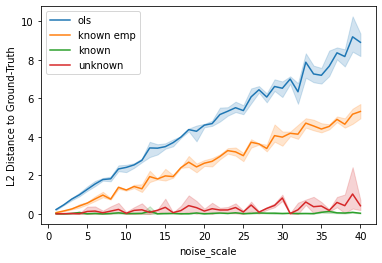

[Text(0.5, 0, 'noise_scale'), Text(0, 0.5, 'L1 Distance to Ground-Truth')]

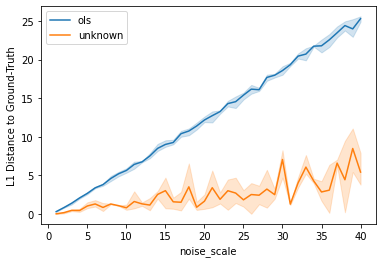

In [185]:
sns.lineplot(data=ols_logs, x='noise_var', y='ols_param_mse', label='ols')
sns.lineplot(data=known_emp_logs, x='noise_var', y='known_emp_param_mse', label='known emp')
ax = sns.lineplot(data=known_logs, x='noise_var', y='known_param_mse', label='known')
ax = sns.lineplot(data=unknown_logs, x='noise_var', y='unknown_param_mse', label='unknown')
ax.set(xlabel='noise_scale', ylabel='L2 Distance to Ground-Truth')
plt.show()

sns.lineplot(data=ols_logs, x='noise_var', y='ols_var_l1', label='ols')
ax = sns.lineplot(data=unknown_logs, x='noise_var', y='unknown_var_l1', label='unknown')
ax.set(xlabel='noise_scale', ylabel='L1 Distance to Ground-Truth')

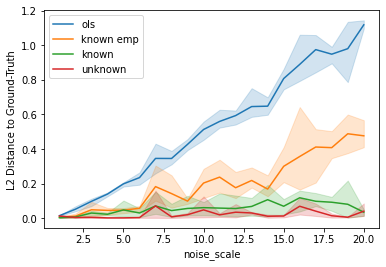

[Text(0.5, 0, 'noise_scale'), Text(0, 0.5, 'L1 Distance to Ground-Truth')]

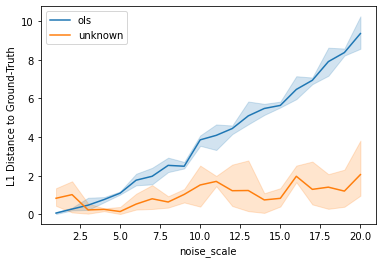

In [149]:
sns.lineplot(data=logs, x='noise_var', y='ols_param_mse', label='ols')
sns.lineplot(data=logs, x='noise_var', y='known_emp_param_mse', label='known emp')
ax = sns.lineplot(data=logs, x='noise_var', y='known_param_mse', label='known')
ax = sns.lineplot(data=logs, x='noise_var', y='unknown_param_mse', label='unknown')
ax.set(xlabel='noise_scale', ylabel='L2 Distance to Ground-Truth')
plt.show()

sns.lineplot(data=logs, x='noise_var', y='ols_var_l1', label='ols')
ax = sns.lineplot(data=logs, x='noise_var', y='unknown_var_l1', label='unknown')
ax.set(xlabel='noise_scale', ylabel='L1 Distance to Ground-Truth')

In [60]:
x_trunc.norm(dim=-1).max(), LA.norm(x_trunc, dim=-1, ord=2).max()

(tensor(203.6971), tensor(203.6971))

In [67]:
(x_trunc/beta).norm(dim=-1).max()

tensor(0.9110)

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
# data = ch.from_numpy(np.linspace(-3.0, 3.0, 100)).unsqueeze(1).float()

ax.scatter3D(X[indices][:,0], X[indices][:,1], noised[indices], color="green", alpha=.1)
ax.scatter3D(x_trunc[:,0], x_trunc[:,1], y_trunc, color="red", alpha=.75)

ax.view_init(10, -150)

In [ ]:
cleaned_logs = pd.DataFrame(columns=logs.columns)
for var in range(1, 21):
    noise_scale = logs[logs['noise_scale'] == var].reset_index()
    noise_scale.drop(index=noise_scale[['unknown_param_mse', 'unknown_var_mse']].sum(1).idxmax(), inplace=True)
    cleaned_logs = pd.concat([cleaned_logs, noise_scale])
cleaned_logs = cleaned_logs.reset_index()

In [145]:
dist.sample(ch.Size([10000])).norm(dim=-1).max()

tensor(1.6702)

In [154]:
u = Uniform(-1/d, 1/d)

s = u.sample(ch.Size([10000, d]))

In [46]:
(x_trunc@w+w0 - y_trunc)

tensor([[-8.0481],
        [-4.1819],
        [-3.8256],
        ...,
        [ 0.5905],
        [-2.1130],
        [-1.7292]])

In [47]:
unknown_var

tensor([[9.3957]], grad_fn=<MulBackward0>)

In [35]:
gt.weight, gt.bias

(Parameter containing:
 tensor([[0.5118]], requires_grad=True),
 Parameter containing:
 tensor([[0.5949]], requires_grad=True))

In [44]:
ols_params

tensor([0.1744, 2.7350])

In [52]:
ch.abs((x_trunc@w + w0) - y_trunc).mean(0)

tensor([2.5809])

In [68]:
((X@w + w0) - noised).var(0)

tensor([9.8567])

In [58]:
(x_trunc@w + w0 - y_trunc).var(0)

tensor([4.2200])

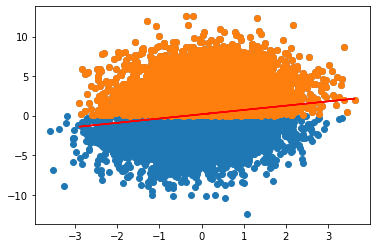

In [89]:
plt.scatter(X, noised)
plt.scatter(x_trunc, y_trunc)
plt.plot(x_trunc, x_trunc@w + w0, color='r')

In [61]:
data = Tensor(np.expand_dims(np.linspace(-3, 3), 1))

In [76]:
x_half, y_half = X[:5000], noised[:5000]

In [77]:
(x_half@w + w0 - y_half).var(0)

tensor([10.1086])

In [86]:
(x_trunc@w - y_trunc).var(0)

tensor([4.2200])

In [81]:
w0

tensor([[0.1702]])

In [24]:
rand = ch.randn(100, 16, 1)

In [25]:
rand > 0.0

tensor([[[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [ True]],

        [[ True],
         [False],
         [False],
         ...,
         [ True],
         [False],
         [False]],

        [[ True],
         [False],
         [ True],
         ...,
         [ True],
         [False],
         [False]],

        ...,

        [[False],
         [ True],
         [False],
         ...,
         [False],
         [ True],
         [ True]],

        [[False],
         [False],
         [False],
         ...,
         [ True],
         [False],
         [False]],

        [[ True],
         [False],
         [ True],
         ...,
         [ True],
         [ True],
         [False]]])

In [6]:
test = ch.nn.Linear(in_features=1, out_features=1)

In [8]:
test.copy_()

ModuleAttributeError: 'Linear' object has no attribute 'copy_'

In [4]:
ch.ones(1).clone()

tensor([1.])

In [110]:
lst = [1, 2, 3]

In [111]:
other = lst 

In [112]:
other

[1, 2, 3]

In [113]:
lst = [4, 5, 6]

In [114]:
other

[1, 2, 3]

In [115]:
lst

[4, 5, 6]